# Predicción de enfermedad de diabetes


**Trabajo de Fin de Master , Iratxe Urbaneja**

## TABLA DE CONTENIDOS:
1. Introducción
2. Análisis exploratorio de datos
3. Limpieza de los datos
4. Selección de características
5. División de los datos en grupos de entrenamiento y test + preprocesado con escalado y SMOTE
6. Entrenamiento de módelo predictivo
7. Evaluación del modelo con métricas de rendimiento

--------------------------

# 1. INTRODUCCIÓN:

PROBLEMA: La diabetes es una enfermedad crónica que afecta a millones de personas en todo el mundo. Según la Organización Mundial de la Salud (OMS), la prevalencia global de diabetes en adultos ha aumentado del 4.7% en 1980 al 8.5% en 2014. La diabetes tipo 2, que es el tipo más común, está particularmente asociada con la obesidad y el estilo de vida sedentario. En algunas poblaciones, como los indios Pima de Arizona, la prevalencia de diabetes tipo 2 es excepcionalmente alta, llegando hasta el 50% en adultos. El diagnóstico temprano y la identificación de factores de riesgo son cruciales para prevenir complicaciones graves como enfermedades cardiovasculares, nefropatía, retinopatía y neuropatía. Este estudio tiene como objetivo desarrollar un modelo predictivo para identificar el riesgo de diabetes basado en factores clínicos y demográficos.

DATASET: El conjunto de datos de Diabetes de los Indios Pima, originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales, contiene información de 768 mujeres de al menos 21 años de edad de herencia Pima India. Este dataset ha sido ampliamente utilizado en la investigación de aprendizaje automático para la predicción de diabetes. Incluye variables como el número de embarazos, IMC, nivel de insulina, edad y otras medidas relevantes. El objetivo es predecir si una paciente tiene diabetes basándose en estas medidas diagnósticas.

----------------------------------------------------------------------

## PRIMEROS PASOS:
Antes de poder relaizar nuestro análisis exploratorio de los datos vamos a:
- Importar las librerias necesarias
- Importar el archico csv con los datos
- Crear un Pandas DataFrame para poder trabajar coo los datos
- Comprobar si existen Duplicados

In [ ]:
# Importamos las librerias necesarias:

# Cargamos rich para enriquecer texto
from rich.console import Console
console = Console()

# Librerías básicas para análisis de datos y manipulación
import pandas as pd
import numpy as np
from collections import Counter

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

# Librerías para análisis estadístico
from scipy import stats
from scipy.stats import chi2_contingency, kurtosis, shapiro
from statsmodels.stats.contingency_tables import Table2x2

# Librerías de scikit-learn para preprocesamiento, selección de características y modelado
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek

from sklearn.model_selection import (train_test_split, cross_val_score, KFold, GridSearchCV,
                                     RandomizedSearchCV, StratifiedKFold, cross_val_predict)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, roc_auc_score,
                             precision_recall_curve, average_precision_score, make_scorer)
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score
)

# Modelos de machine learning
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              VotingClassifier, StackingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Librerías para manejo de desbalanceo de clases
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Para manejo de advertencias
import warnings
warnings.filterwarnings('ignore')

# Para transformaciones logarítmicas
from numpy import log1p

# Configuración para mostrar gráficos en el notebook
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes.csv


In [ ]:
# Creamos un dataframe del archivo que se llama 'diabetes.csv'
df = pd.read_csv('diabetes.csv')

In [ ]:
# Comprobar duplicados en el DataFrame
duplicados = df.duplicated()

# Contar el número de duplicados
num_duplicados = duplicados.sum()

print(f"Número de filas duplicadas: {num_duplicados}")

Número de filas duplicadas: 0


- Visulaizaremos las primeras filas del DataFrame
- Visualizaremos la estructura del DataFrame y los tipos de datos
- Extraeremos los atributos identificando la variable objetivo y las variables independientes


In [ ]:
print(df.head(20))
print(df.info())

    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0             6      148             72             35        0  33.6   
1             1       85             66             29        0  26.6   
2             8      183             64              0        0  23.3   
3             1       89             66             23       94  28.1   
4             0      137             40             35      168  43.1   
5             5      116             74              0        0  25.6   
6             3       78             50             32       88  31.0   
7            10      115              0              0        0  35.3   
8             2      197             70             45      543  30.5   
9             8      125             96              0        0   0.0   
10            4      110             92              0        0  37.6   
11           10      168             74              0        0  38.0   
12           10      139             80            

Estructura del Dataset:
El dataset contiene 768 entradas y 9 columnas.
No hay valores nulos reportados en ninguna columna, lo que podría ser engañoso dado que sabemos que hay valores 0 que probablemente representan datos faltantes.

Podemos clasificar los atributos de la siguiente manera:

- Variable objetivo:
Outcome (Diagnóstico de diabetes). Es una variable binaria categórica (0 o 1), lo que indica que estamos ante un problema de clasificación.


- Atributos demográficos:
Age (Edad)


- Historia médica y mediciones:
Pregnancies (Número de embarazos),
DiabetesPedigreeFunction (Función de pedigrí de diabetes, es una medida que cuantifica la probabilidad de que una persona tenga diabetes basándose en su historial familiar. Esta función toma en cuenta tanto la edad como el historial de diabetes en la familia del individuo), Glucose (Nivel de glucosa en plasma), BloodPressure (Presión arterial diastólica), SkinThickness (Grosor del pliegue cutáneo del tríceps), Insulin (Insulina sérica de 2 horas), BMI (Índice de masa corporal)


- Todas las variables en el dataset son numéricas excepto por la variable objetivo que es categórica.
Debemos señalar que dentro de las variables numéricas la mayoria son variable continuas excepto por 'Preganancies' y 'DiabetesPedigreeFunction', que son discretas.

-------------------------------------------------------------------------------

# 2. ANÁLISIS EXPLORATORIO DE DATOS

Para este dataset, vamos a estructurar nuestro análisis en tres partes principales:

### 2.1 Análisis de la Variable Objetivo

- Examinar la distribución de la variable 'Outcome' (diagnóstico de diabetes).
Nos ayudará a identificar si hay un desequilibrio en las clases, lo cual podría afectar nuestro modelado posterior.

### 2.2 Análisis de Variables Cuantitativas

Dado que el resto de las variables son numéricas (continuas o discretas), nos enfocaremos en realizar un análisis estadístico detallado. Esto incluirá el cálculo de estadísticas descriptivas, la creación de visualizaciones como histogramas y diagramas de caja, y un análisis de correlaciones entre variables.

1. Visualización de la Distribución: Crearemos histogramas y diagramas de caja (box plots) para cada variable numérica.
Esto nos permitirá identificar la forma de las distribuciones, asimetrías, y la presencia de valores atípicos.

2. Estadísticas Descriptivas:
Calcularemos medidas de tendencia central (media, mediana) y de dispersión (desviación estándar, rango).
Identificaremos los valores mínimos y máximos para detectar posibles anomalías o errores en los datos.

3. Relación con la Variable Objetivo:
Utilizaremos scatterplots y gráficos de densidad para visualizar cómo cada variable se relaciona con el diagnóstico de diabetes.
Esto nos ayudará a identificar patrones o umbrales potencialmente significativos.

4. Detección de Outliers: Analizaremos los diagramas de caja y las estadísticas para identificar valores atípicos.
Prestaremos especial atención a los valores 0 en variables como BloodPressure, SkinThickness, Insulin y BMI.

5. Análisis de Correlaciones:
Crearemos una matriz de correlación para identificar relaciones lineales entre variables.
Visualizaremos estas correlaciones mediante un heatmap para una interpretación más clara.
Examinaremos específicamente las correlaciones con la variable objetivo 'Outcome'.

### 2.3 Análisis Específico por Variable

Cada variable en nuestro dataset tiene un significado clínico particular. Por lo tanto, dedicaremos tiempo a examinar cada una individualmente, considerando su distribución y su relación con el diagnóstico de diabetes.

- Pregnancies: Distribución y su relación con el diagnóstico de diabetes
- Glucose: Rangos de glucosa y su asociación con el diagnóstico
- BloodPressure: Distribución y posibles umbrales de riesgo
- SkinThickness: Análisis de su distribución y posibles valores atípicos
- Insulin: Distribución y su relación con los niveles de glucosa
- BMI: Categorización (bajo peso, normal, sobrepeso, obeso) y su relación con el diagnóstico
- DiabetesPedigreeFunction: Interpretación de esta función y su impacto en el diagnóstico
- Age: Distribución por grupos de edad y su relación con el diagnóstico

### 2.4 Análisis de Valores Faltantes o Cero

- Identificar y cuantificar los valores cero en columnas donde no son biológicamente posibles (como BloodPressure, SkinThickness, Insulin, BMI)
- Visualizar la distribución de estos valores y su impacto en el diagnóstico. Este análisis será crucial para informar nuestras decisiones de limpieza y preprocesamiento de datos.



Esta estrategia nos permitirá obtener una comprensión profunda de las características del dataset, las relaciones entre variables y los posibles desafíos en la limpieza y preparación de datos para el modelado.


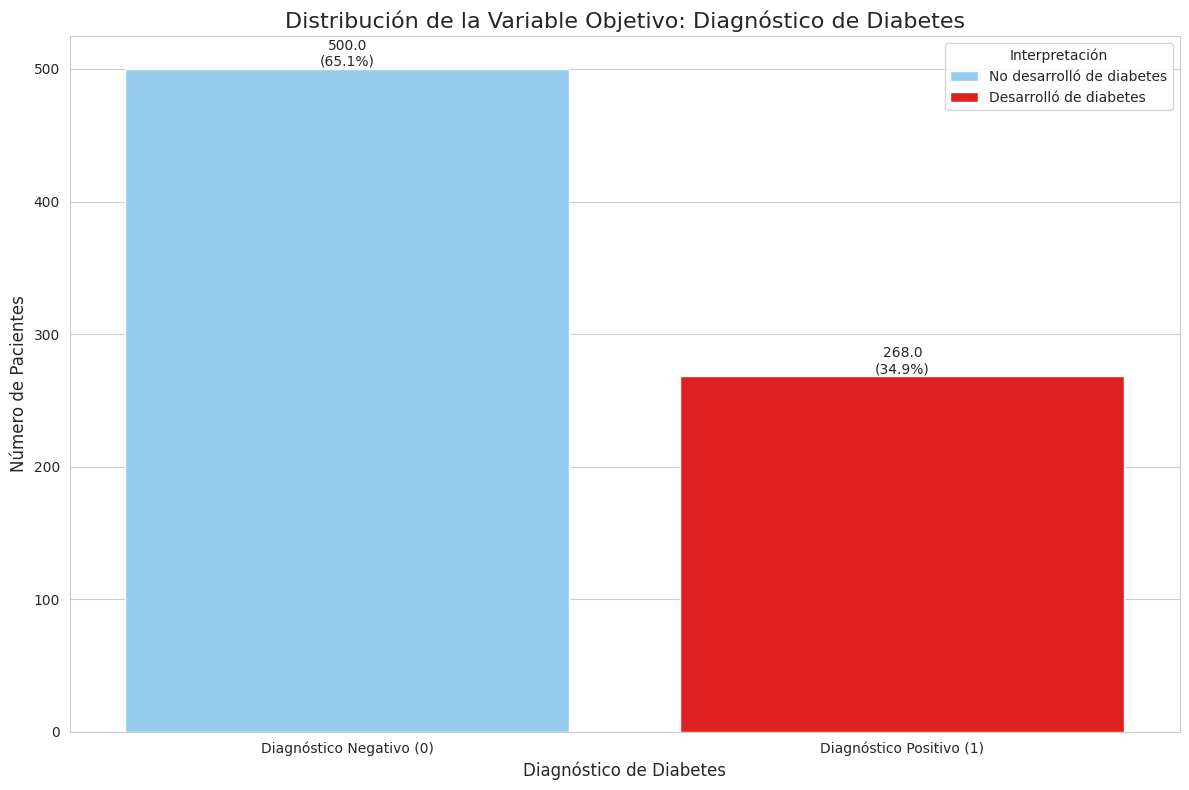

Total de pacientes: 768
Pacientes sin diabetes: 500 (65.1%)
Pacientes con diabetes: 268 (34.9%)


In [ ]:
# Visualización de la variable objetivo Outcome

# Configuración para mejorar la apariencia del gráfico
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
colors = ['#87CEFA', '#FF0000']  # Colores para las barras

# Crear el gráfico de barras
ax = sns.countplot(data=df, x='Outcome', palette=colors)

# Añadir etiquetas y título
plt.title('Distribución de la Variable Objetivo: Diagnóstico de Diabetes', fontsize=16)
plt.xlabel('Diagnóstico de Diabetes', fontsize=12)
plt.ylabel('Número de Pacientes', fontsize=12)


# Cambiar las etiquetas del eje x
plt.xticks([0, 1], ['Diagnóstico Negativo (0)', 'Diagnóstico Positivo (1)'], fontsize=10)

# Añadir etiquetas de valor en las barras
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1,
            f'{height}\n({height/total:.1%})',
            ha="center", va="bottom", fontsize=10)

# Añadir una leyenda explicativa
plt.legend(['No desarrolló de diabetes', 'Desarrolló de diabetes'],
           title='Interpretación', loc='upper right', fontsize=10)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

# Imprimir estadísticas adicionales
print(f"Total de pacientes: {total}")
print(f"Pacientes sin diabetes: {df['Outcome'].value_counts()[0]} ({df['Outcome'].value_counts()[0]/total:.1%})")
print(f"Pacientes con diabetes: {df['Outcome'].value_counts()[1]} ({df['Outcome'].value_counts()[1]/total:.1%})")

De la distribución de la variable objetivo que has proporcionado, podemos extraer varias conclusiones importantes:

1. **Desbalance de clases**: Existe un desbalance moderado en el conjunto de datos. La clase mayoritaria (pacientes sin diabetes) representa el 65.1% de los casos, mientras que la clase minoritaria (pacientes con diabetes) representa el 34.9%. Este desbalance de clases, aunque no es extremo, podría afectar el rendimiento de algunos algoritmos de aprendizaje automático. Puede ser necesario considerar técnicas como sobremuestreo de la clase minoritaria (por ejemplo, SMOTE) o submuestreo de la clase mayoritaria durante la fase de preprocesamiento de datos.

2. **Prevalencia de diabetes**: En esta población de estudio, aproximadamente 1 de cada 3 individuos (34.9%) tiene diabetes. Esta es una prevalencia bastante alta en comparación con la población general (5.4%), lo que podría reflejar las características únicas de la población Pima o los criterios de selección del estudio.

3. **Tamaño de la muestra**: Con 768 pacientes en total, tenemos un tamaño de muestra moderado. Esto debería ser suficiente para realizar análisis estadísticos significativos y entrenar modelos de aprendizaje automático, aunque muestras más grandes siempre son preferibles para obtener resultados más robustos.

4. **Relevancia clínica**: La alta proporción de casos positivos (34.9%) subraya la importancia de este estudio para la salud pública, especialmente en poblaciones con alto riesgo de diabetes.

5. **Base para comparaciones**: Esta distribución proporciona una línea base importante para evaluar nuestros modelos predictivos. Un modelo que simplemente predijera siempre la clase mayoritaria (no diabetes) tendría una precisión del 65.1%, lo cual es un punto de referencia útil para evaluar el rendimiento de nuestros modelos más sofisticados.

7. **Generalización de resultados**: Dado el desbalance moderado y la alta prevalencia de diabetes en esta muestra, debemos ser cautelosos al generalizar los resultados a otras poblaciones con diferentes tasas de prevalencia de diabetes.

Estas conclusiones nos ayudarán a guiar nuestro análisis posterior, informar nuestras decisiones de preprocesamiento de datos y establecer expectativas realistas para el rendimiento de nuestros modelos predictivos.


---

# 2.2 Análisis de Variables Cuantitativas

En esta sección, exploraremos las variables numéricas del dataset de diabetes para identificar patrones, tendencias y relaciones significativas que puedan influir en el diagnóstico de diabetes.

Pasos del análisis:

### 1. Visualización de la Distribución de Variables

- Utilizaremos histogramas y boxplots para entender la distribución de cada variable numérica (Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age).
- Esto nos ayudará a identificar asimetrías, curtosis y la presencia de outliers.

### 2. Estadísticas Descriptivas

- Calcularemos medidas como la media, mediana, desviación estándar, y rangos intercuartílicos para cada variable.
- Esto proporcionará un resumen cuantitativo de cada variable y nos ayudará a entender mejor sus características.

### 3. Relación con la Variable Objetivo (Outcome)

- Crearemos scatterplots y pairplots para visualizar cómo cada variable numérica se relaciona con Outcome.
- Buscaremos patrones que puedan indicar asociaciones significativas con el diagnóstico de diabetes.


### 4. Detección de Outliers

- Identificaremos outliers mediante el análisis de boxplots.
- Prestaremos especial atención a los valores 0 en variables como BloodPressure, SkinThickness, Insulin y BMI, que probablemente representen datos faltantes.

### 5. Análisis de Correlación

- Calcularemos la matriz de correlación para identificar relaciones lineales entre variables numéricas.
- Utilizaremos heatmaps para visualizar estas correlaciones y destacar las más fuertes.
- Calcularemos la correlación de nuestras variables numéricas con la variable objetivo 'Outcome'.

Este análisis exhaustivo de las variables cuantitativas nos proporcionará una base sólida para el modelado predictivo de diabetes, permitiéndonos identificar y aprovechar las relaciones clave en el dataset. Además, nos ayudará a abordar los desafíos específicos de este conjunto de datos, como los valores 0 que probablemente representen datos faltantes en algunas variables.


Agrupamos las variables numéricas para trabajar con ellas


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [ ]:
num_vars = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

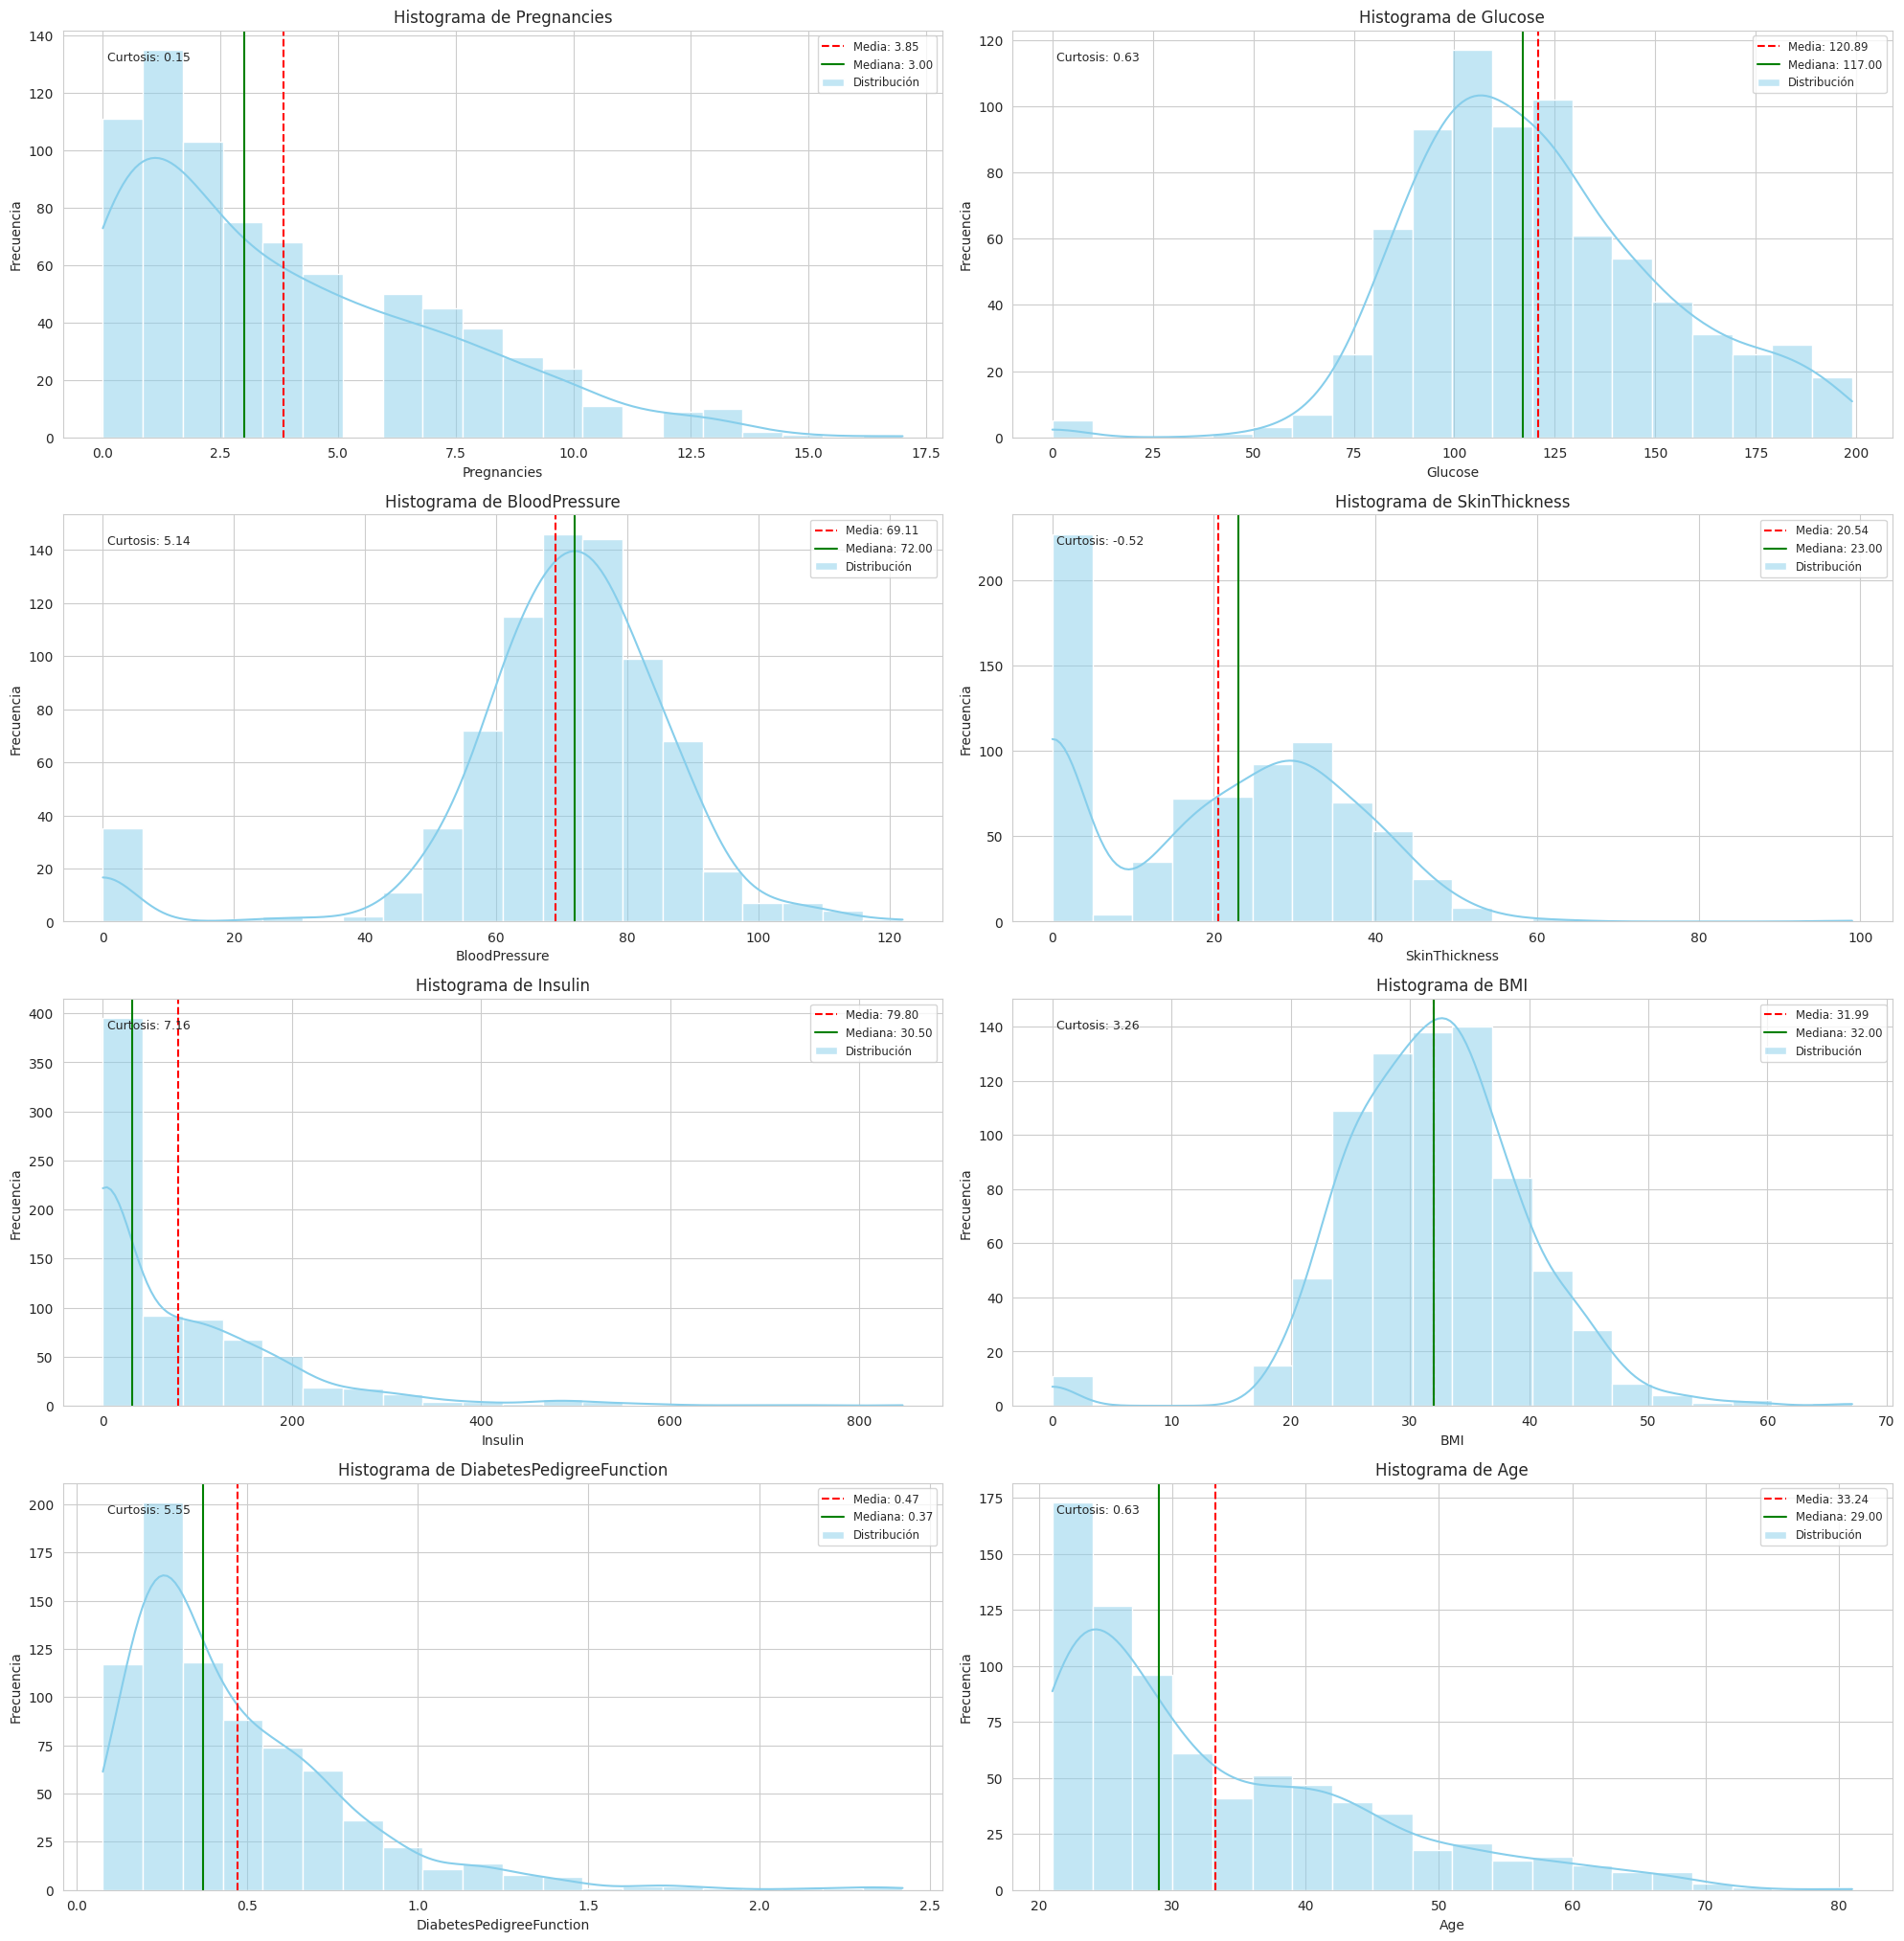

In [ ]:
# Crear histogramas con líneas de media y mediana
plt.figure(figsize=(20, 25))

for i, var in enumerate(num_vars):
    plt.subplot(5, 2, i + 1)
    sns.histplot(df[var], bins=20, kde=True, color='skyblue', label='Distribución')

    # Calcular media y mediana
    mean_val = df[var].mean()
    median_val = df[var].median()
    kurt_val = kurtosis(df[var])

    # Añadir líneas de media y mediana
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-', label=f'Mediana: {median_val:.2f}')

    # Añadir texto de curtosis
    plt.text(0.05, 0.95, f'Curtosis: {kurt_val:.2f}',
             transform=plt.gca().transAxes, fontsize=9,
             verticalalignment='top')

    # Añadir leyenda
    plt.legend(fontsize='small')
    plt.title(f'Histograma de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [ ]:
# Calculamos estadísticas descriptivas
descriptive_stats = num_vars.describe().transpose()

# Añadir mediana y rango intercuartílico
descriptive_stats['median'] = num_vars.median()
descriptive_stats['IQR'] = descriptive_stats['75%'] - descriptive_stats['25%']

# Mostrar estadísticas descriptivas
print(descriptive_stats[['mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max', 'IQR']])

                                mean    median         std     min       25%  \
Pregnancies                 3.845052    3.0000    3.369578   0.000   1.00000   
Glucose                   120.894531  117.0000   31.972618   0.000  99.00000   
BloodPressure              69.105469   72.0000   19.355807   0.000  62.00000   
SkinThickness              20.536458   23.0000   15.952218   0.000   0.00000   
Insulin                    79.799479   30.5000  115.244002   0.000   0.00000   
BMI                        31.992578   32.0000    7.884160   0.000  27.30000   
DiabetesPedigreeFunction    0.471876    0.3725    0.331329   0.078   0.24375   
Age                        33.240885   29.0000   11.760232  21.000  24.00000   

                               50%        75%     max       IQR  
Pregnancies                 3.0000    6.00000   17.00    5.0000  
Glucose                   117.0000  140.25000  199.00   41.2500  
BloodPressure              72.0000   80.00000  122.00   18.0000  
SkinThickness  

Basándonos en las estadísticas descriptivas proporcionadas, podemos extraer varias conclusiones importantes sobre las variables numéricas del dataset de diabetes:

1. Pregnancies (Embarazos):
   - La media es de 3.85, con una mediana de 3, indicando una distribución ligeramente sesgada hacia la derecha.
   - El rango va de 0 a 17 embarazos, con un 75% de las mujeres teniendo 6 o menos embarazos.

2. Glucose (Glucosa):
   - La media (120.89) es ligeramente superior a la mediana (117), sugiriendo una distribución levemente sesgada hacia la derecha.
   - El rango va de 0 a 199 mg/dL, con valores de 0 que probablemente indican datos faltantes.
   - El valor máximo (199 mg/dL) supera significativamente el límite superior normal post-comida (140 mg/dL). Esto sugiere que una proporción considerable de la población estudiada presenta niveles elevados de glucosa, indicativo de prediabetes o diabetes.

3. BloodPressure (Presión Arterial):
   - La media (69.11) es menor que la mediana (72), indicando una posible asimetría hacia la izquierda.
   - El valor mínimo de 0 sugiere la presencia de datos faltantes o erróneos.

4. SkinThickness (Grosor del Pliegue Cutáneo):
   - Hay una diferencia notable entre la media (20.54) y la mediana (23), con un mínimo de 0, indicando probables datos faltantes.

5. Insulin (Insulina):
   - Muestra una gran variabilidad, con una desviación estándar (115.24) mayor que la media (79.80).
   - La mediana (30.5) es significativamente menor que la media, indicando una distribución muy sesgada hacia la derecha.
   - El valor máximo (846 mIU/L) es extremadamente alto, sugiriendo casos de resistencia a la insulina severa o errores en los datos.

6. BMI (Índice de Masa Corporal):
   - La media (31.99) y la mediana (32) son similares, sugiriendo una distribución más simétrica.
   - El rango va de 0 a 67.1, con valores de 0 que probablemente indican datos faltantes. El valor máximo (67.1 kg/m²) indica casos de obesidad extrema. Esto sugiere que una gran parte de la población estudiada tiene sobrepeso u obesidad, factores de riesgo conocidos para la diabetes tipo 2.

7. DiabetesPedigreeFunction:
   - Tiene un rango de 0.078 a 2.42, con una media de 0.472 y una mediana de 0.3725.
   - La distribución parece estar sesgada hacia la derecha, con algunos valores altos influyendo en la media.

8. Age (Edad):
   - La media (33.24) es mayor que la mediana (29), indicando una distribución sesgada hacia la derecha.
   - El rango va de 21 a 81 años, con el 75% de los pacientes teniendo 41 años o menos.

Conclusiones generales:
- Varias variables (Glucose, BloodPressure, SkinThickness, Insulin, BMI) tienen valores mínimos de 0, lo que probablemente indica datos faltantes que necesitarán ser tratados.
- La mayoría de las variables muestran algún grado de asimetría en su distribución.
- Hay una gran variabilidad en algunas medidas, especialmente en Insulin y DiabetesPedigreeFunction, lo que podría influir en los modelos predictivos.
- La edad de la población de estudio es relativamente joven, con una concentración en el rango de 20 a 40 años.
- El dataset muestra una población con características de alto riesgo para diabetes tipo 2, incluyendo niveles elevados de glucosa, insulina y BMI. La presión arterial, sin embargo, parece estar dentro de rangos más normales. Estos hallazgos son consistentes con una población en riesgo de desarrollar o ya diagnosticada con diabetes tipo 2.




Para visualizar cómo cada variable numérica se relaciona con Outcome, vamos a usar scatterplots y pairplots.

- Scatterplots: Muestran la relación directa entre cada variable numérica y Outcome.
- Pairplots: Ofrecen una visión más completa de las relaciones entre múltiples variables numéricas, coloreadas por Outcome.

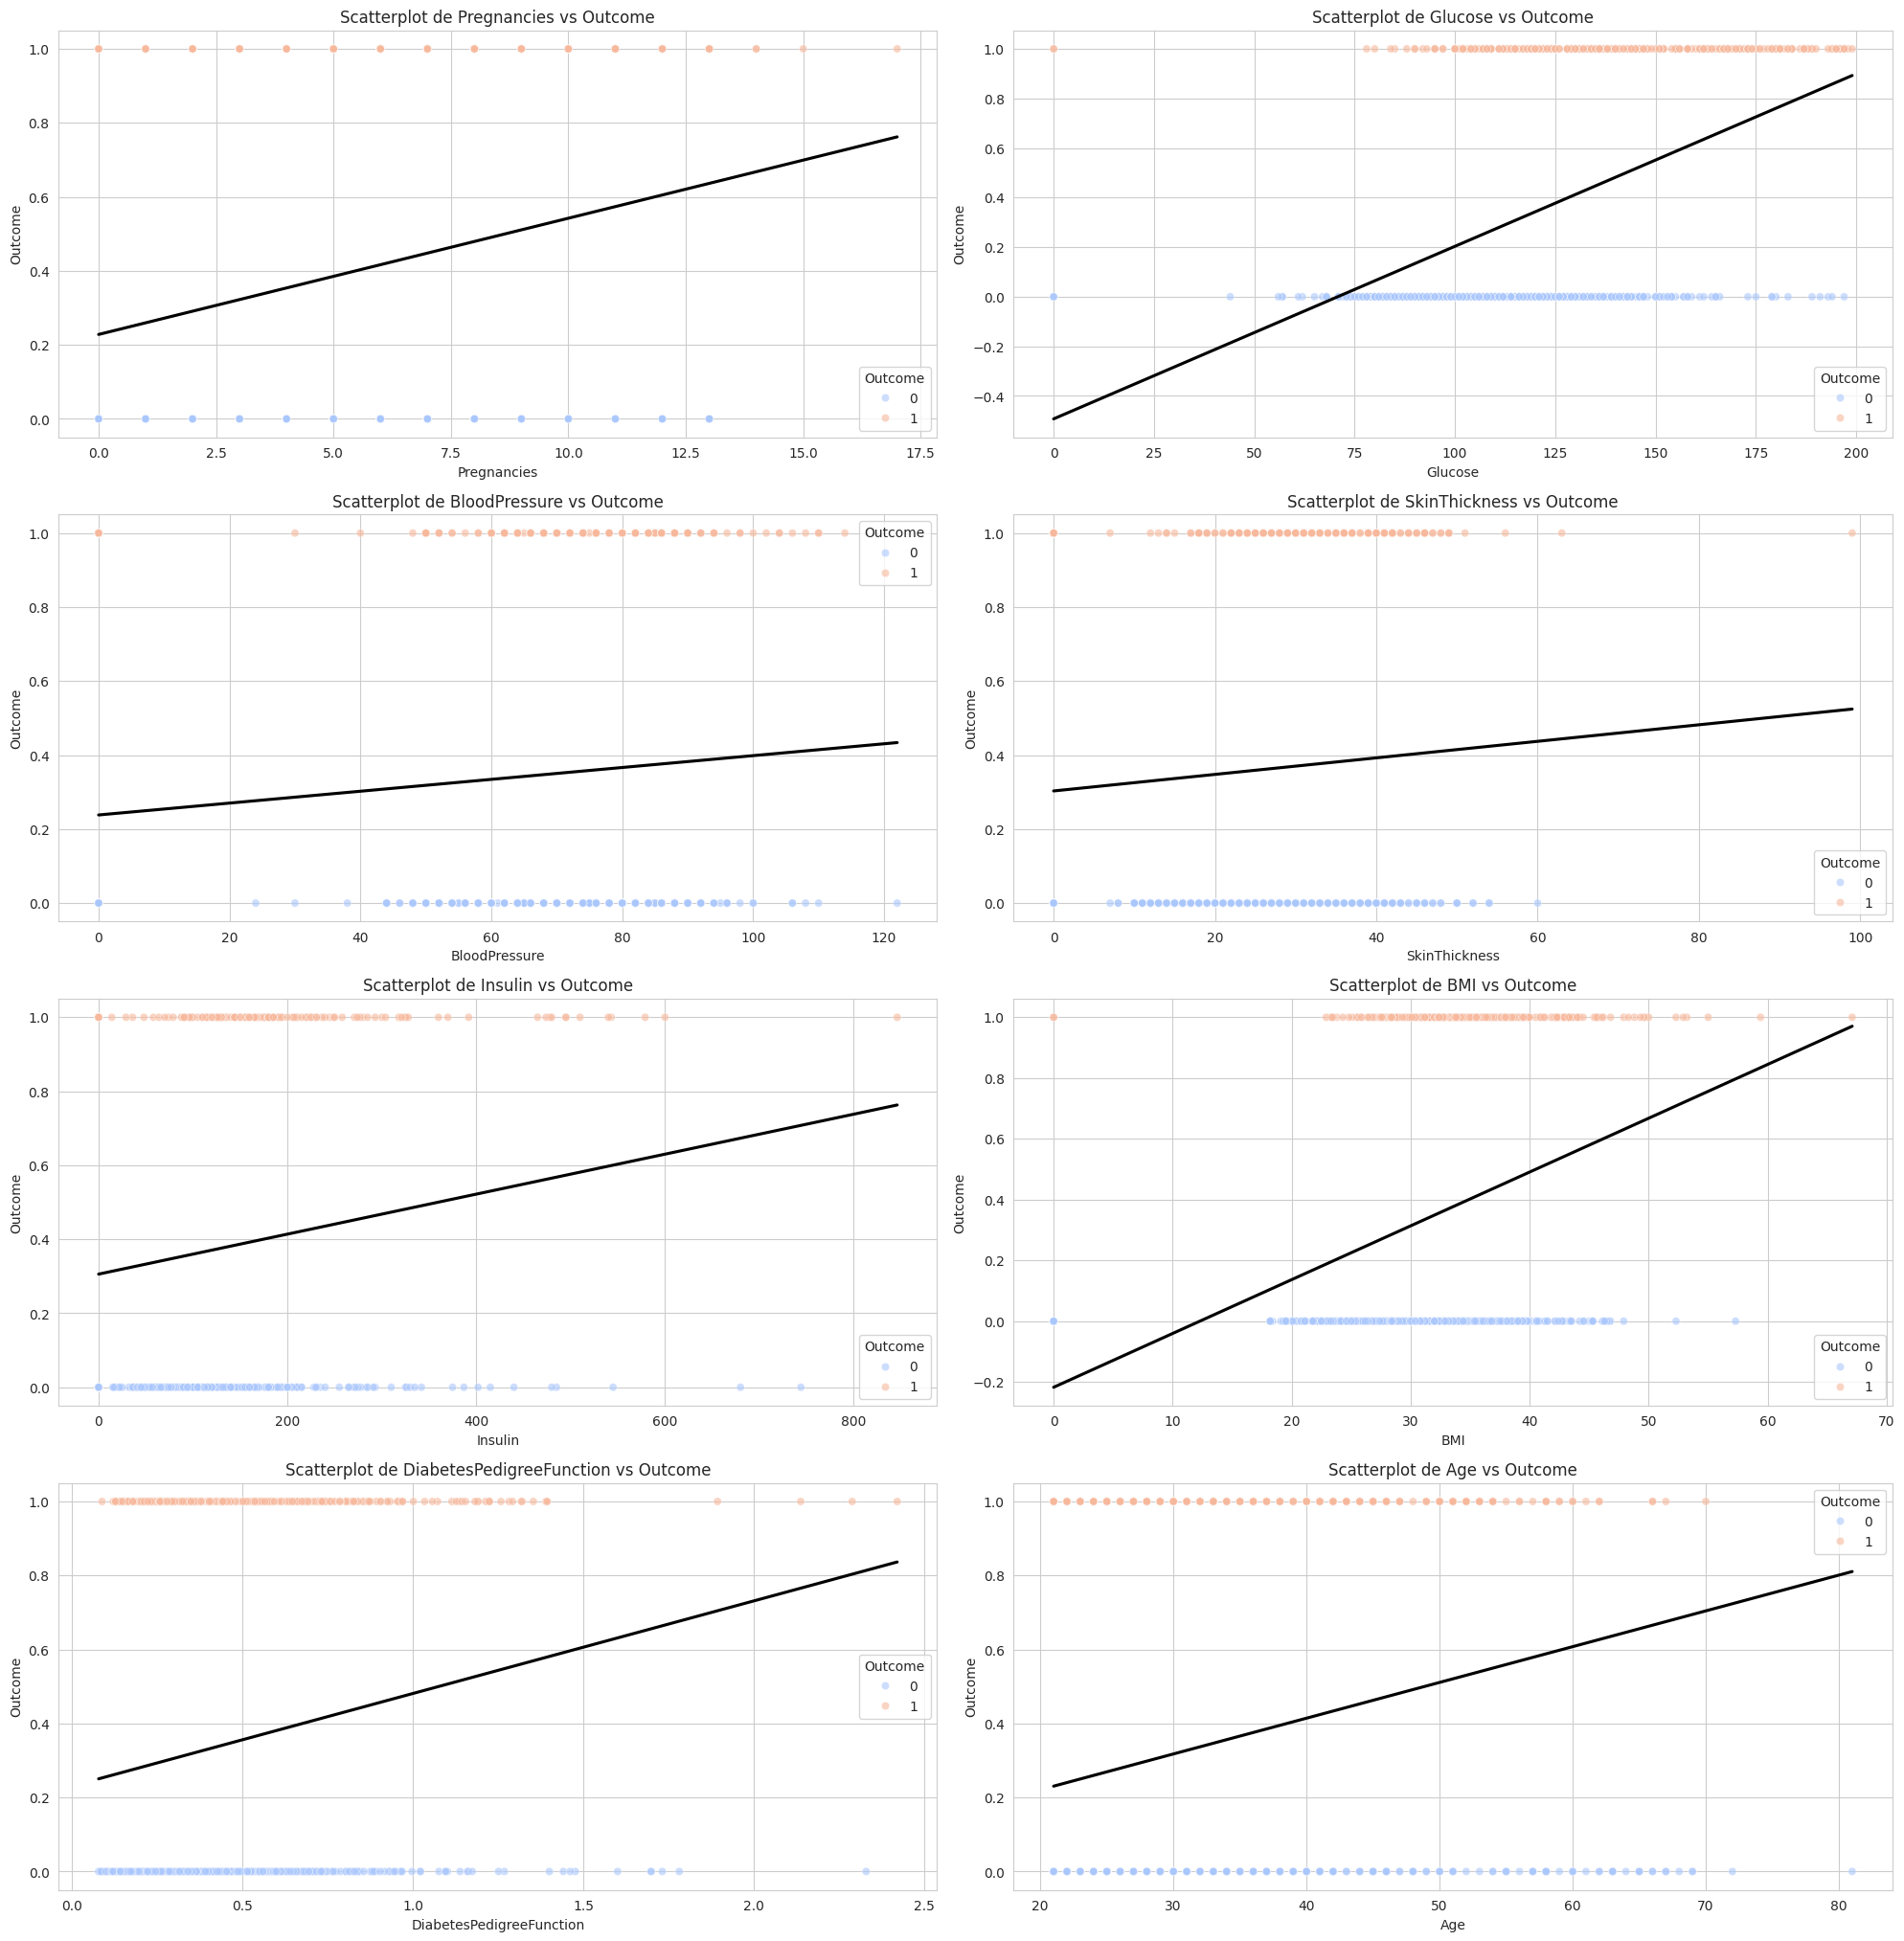

In [ ]:
# Crear scatterplots con colores para la variable objetivo y línea de regresión

# Tamaño de la figura
plt.figure(figsize=(20, 25))

for i, var in enumerate(num_vars):
    plt.subplot(5, 2, i + 1)
    sns.scatterplot(x=df[var], y=df['Outcome'], hue=df['Outcome'], palette='coolwarm', alpha=0.6)
    sns.regplot(x=df[var], y=df['Outcome'], scatter=False, color='black', ci=None)
    plt.title(f'Scatterplot de {var} vs Outcome')
    plt.xlabel(var)
    plt.ylabel('Outcome')

plt.tight_layout()
plt.show()

### 1. **Pregnancies vs. Outcome**
   - Existe una ligera tendencia positiva: a mayor número de embarazos, parece haber una mayor probabilidad de tener diabetes.
   - Esto es consistente con investigaciones que indican que múltiples embarazos pueden estar relacionados con un mayor riesgo de diabetes gestacional y tipo 2.

### 2. **Glucose vs. Outcome**
   - La relación es clara: los valores más altos de glucosa están asociados con una mayor probabilidad de tener diabetes.
   - Este resultado es esperado, ya que niveles elevados de glucosa son un indicador directo de diabetes.

### 3. **BloodPressure vs. Outcome**
   - La relación entre presión arterial y diagnóstico de diabetes parece ser débil o inexistente.
   - Aunque la presión arterial elevada puede ser un factor de riesgo cardiovascular, su conexión directa con la diabetes no es tan evidente en este dataset.

### 4. **SkinThickness vs. Outcome**
   - Hay una ligera tendencia positiva: mayores valores de grosor del pliegue cutáneo están asociados con una mayor probabilidad de tener diabetes.
   - Esto podría reflejar una relación indirecta a través del IMC o la obesidad.

### 5. **Insulin vs. Outcome**
   - Se observa una tendencia positiva: niveles más altos de insulina están asociados con un mayor riesgo de diabetes.
   - Esto es consistente con la resistencia a la insulina, que es un precursor común de la diabetes tipo 2.

### 6. **BMI vs. Outcome**
   - Existe una relación positiva clara: valores más altos del índice de masa corporal (IMC) están asociados con un mayor riesgo de diabetes.
   - Esto subraya el papel importante del sobrepeso y la obesidad como factores de riesgo para la diabetes tipo 2.

### 7. **DiabetesPedigreeFunction vs. Outcome**
   - Se observa una tendencia positiva: valores más altos en esta función (indicando un historial familiar más fuerte) están asociados con un mayor riesgo de diabetes.
   - Esto refuerza el impacto del componente genético en el desarrollo de la enfermedad.

### 8. **Age vs. Outcome**
   - Existe una relación positiva: a mayor edad, aumenta la probabilidad de tener diabetes.
   - Esto es consistente con el hecho conocido de que el riesgo de diabetes tipo 2 aumenta con la edad.

---

### Conclusión General:
- Las variables **Glucose**, **BMI**, y **DiabetesPedigreeFunction** muestran relaciones claras y fuertes con el diagnóstico de diabetes, lo que las podría  convertir en predictores importantes.
- Variables como **Pregnancies**, **Insulin**, y **Age** también tienen una relación positiva significativa, aunque menos marcada.
- Variables como **BloodPressure** y, en menor medida, **SkinThickness**, parecen tener relaciones más débiles o indirectas con el diagnóstico.

Estos patrones serán útiles para priorizar variables en el modelado predictivo y para entender los factores clave asociados al diagnóstico de diabetes en esta población.


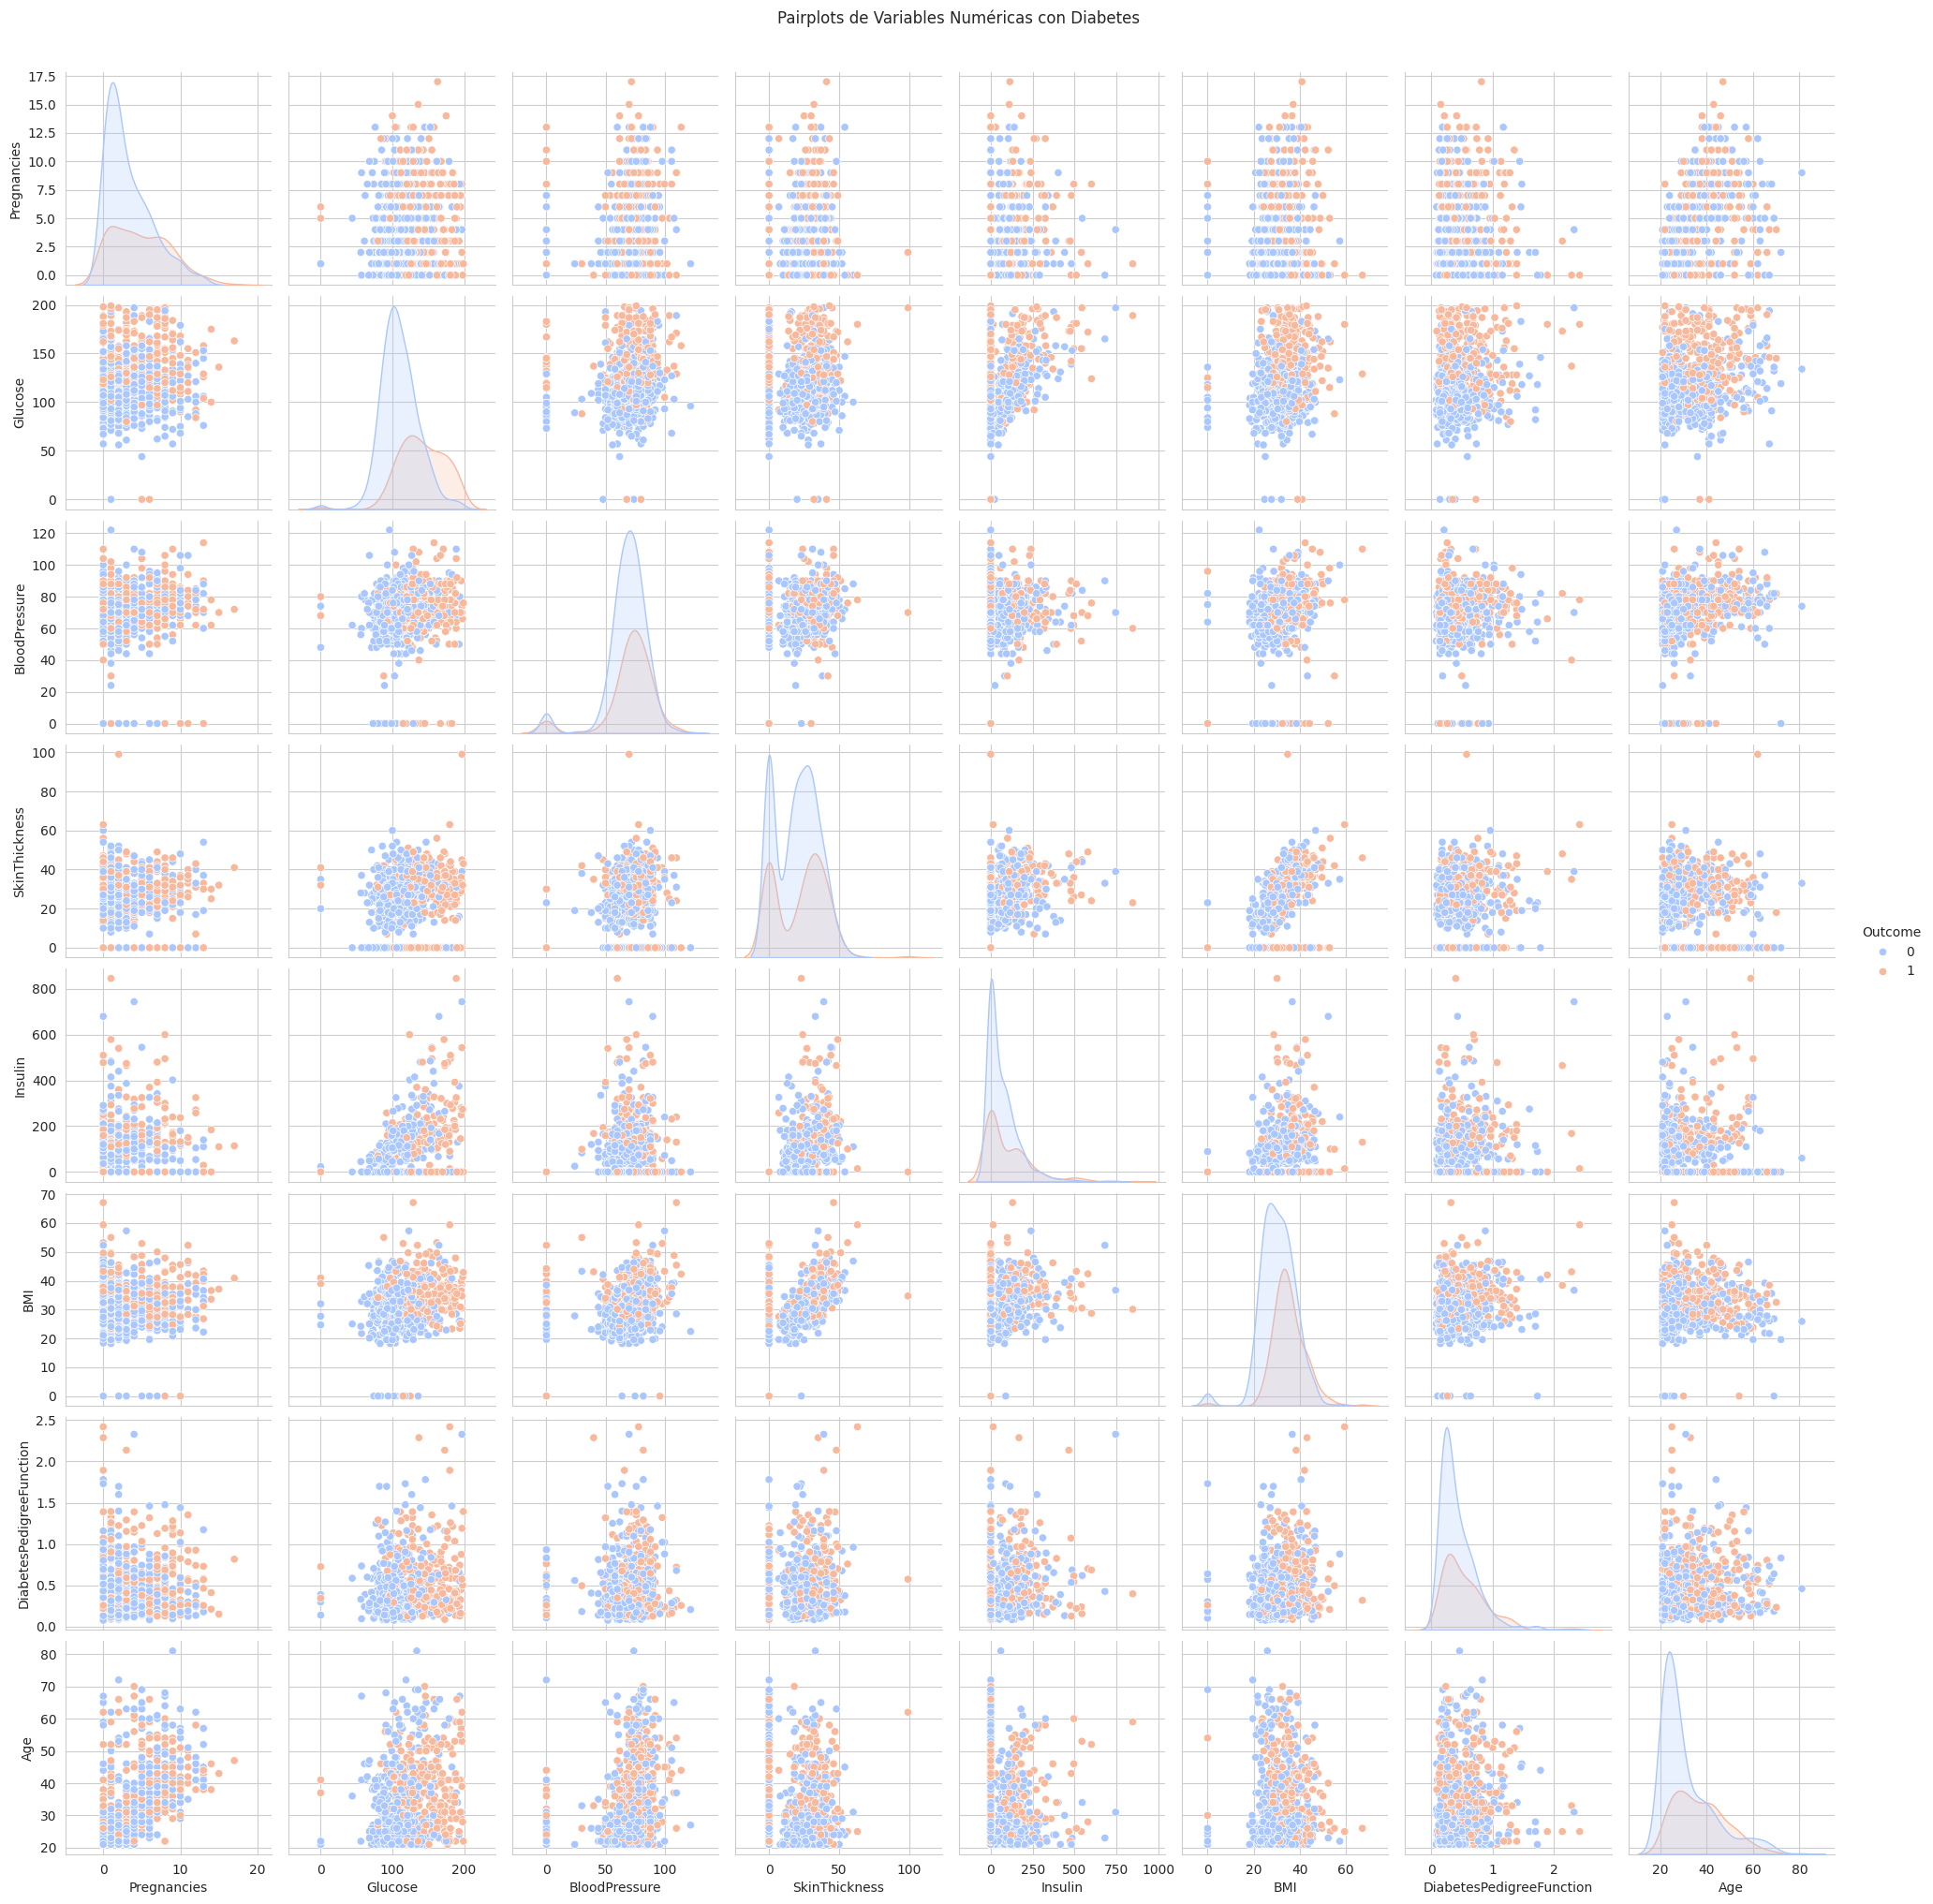

In [ ]:
# Crear pairplot para visualizar relaciones entre variables numéricas y Outcome
sns.pairplot(df, vars=num_vars, hue='Outcome', diag_kind='kde', palette='coolwarm')
plt.suptitle('Pairplots de Variables Numéricas con Diabetes', y=1.02)
plt.show()

### 1. **Distribuciones Univariadas**
   - Las distribuciones de las variables **Glucose**, **BMI**, y **DiabetesPedigreeFunction** muestran diferencias claras entre los pacientes con diabetes (Outcome = 1) y sin diabetes (Outcome = 0).
     - Por ejemplo, los pacientes diabéticos tienden a tener valores más altos en estas variables.
   - Variables como **BloodPressure** y **SkinThickness** tienen distribuciones más solapadas entre ambos grupos, lo que sugiere que estas variables podrían tener un menor poder predictivo.

### 2. **Relaciones entre Variables**
   - **Glucose y BMI**: Existe una correlación positiva moderada entre estas dos variables. Esto tiene sentido, ya que el sobrepeso u obesidad (reflejado en un BMI alto) está relacionado con la resistencia a la insulina y niveles elevados de glucosa.
   - **Age y Pregnancies**: Hay una relación positiva esperada, ya que las mujeres mayores tienden a haber tenido más embarazos.
   - **Insulin y Glucose**: Se observa una relación positiva, consistente con el hecho de que niveles altos de glucosa suelen ir acompañados de niveles elevados de insulina en personas con resistencia a la insulina.

### 3. **Solapamiento entre Grupos**
   - En muchas combinaciones de variables (por ejemplo, **BloodPressure vs. SkinThickness** o **Age vs. BloodPressure**), los puntos correspondientes a Outcome = 0 (azul) y Outcome = 1 (naranja) están muy mezclados. Esto indica que estas combinaciones no separan bien a los pacientes diabéticos de los no diabéticos.
   - En contraste, combinaciones como **Glucose vs. BMI** o **Glucose vs. DiabetesPedigreeFunction** muestran una separación más clara entre ambos grupos.

### 4. **Outliers**
   - El pairplot confirma la presencia de valores extremos en variables como **Insulin**, donde algunos puntos están muy alejados del resto, especialmente en el eje horizontal.
   - También se observan posibles outliers en variables como **SkinThickness** y **BMI**, aunque estos son menos extremos.

### 5. **Interacción entre DiabetesPedigreeFunction y Otras Variables**
   - La variable **DiabetesPedigreeFunction**, aunque no correlaciona fuertemente con otras variables numéricas, muestra una clara diferencia en sus valores para pacientes diabéticos frente a no diabéticos.

---

### Conclusión General:
El pairplot refuerza algunas observaciones previas, como la importancia de variables como **Glucose**, **BMI**, y **DiabetesPedigreeFunction** para predecir diabetes. Sin embargo, también destaca nuevas relaciones entre variables (como Glucose y BMI o Insulin y Glucose) que podrían ser útiles para el modelado. Además, confirma que ciertas variables (como BloodPressure o SkinThickness) tienen menor capacidad para discriminar entre pacientes diabéticos y no diabéticos cuando se analizan individualmente o en combinación con otras.



**ANÁLISIS DE CORRELACIÓN:**

**Ahora calcularemos la matriz de correlación y la representaremos con un heatmap:**
Esto nos ayudará a identificar rápidamente las relaciones lineales más fuertes entre las variables numéricas.

**Calcularemos la correación de las variables numéricas con la variable objetivo**

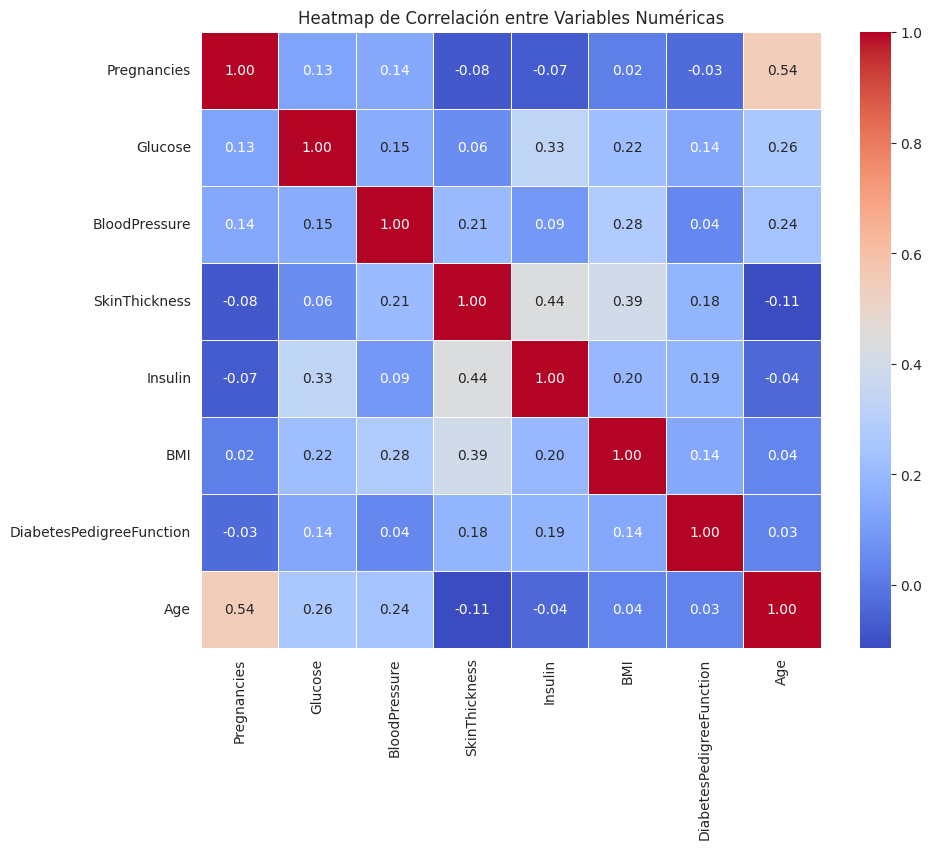

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = num_vars.corr()

# Crear un heatmap para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap de Correlación entre Variables Numéricas')
plt.show()

El heatmap de correlación revela que **Pregnancies** y **Age** tienen una correlación moderada (0.54), lo que es esperable ya que las mujeres mayores tienden a tener más embarazos. También se observa una relación positiva entre **SkinThickness** e **Insulin** (0.44), probablemente vinculada a la obesidad o resistencia a la insulina. Variables como **Glucose** e **Insulin** (0.33) y **BMI** con **SkinThickness** (0.39) muestran correlaciones moderadas, reflejando relaciones fisiológicas conocidas. Sin embargo, la mayoría de las demás correlaciones son débiles, lo que sugiere que cada variable aporta información única al modelo predictivo. Este análisis destaca combinaciones clave como **Glucose e Insulin** para entender mejor los factores asociados al diagnóstico de diabetes.


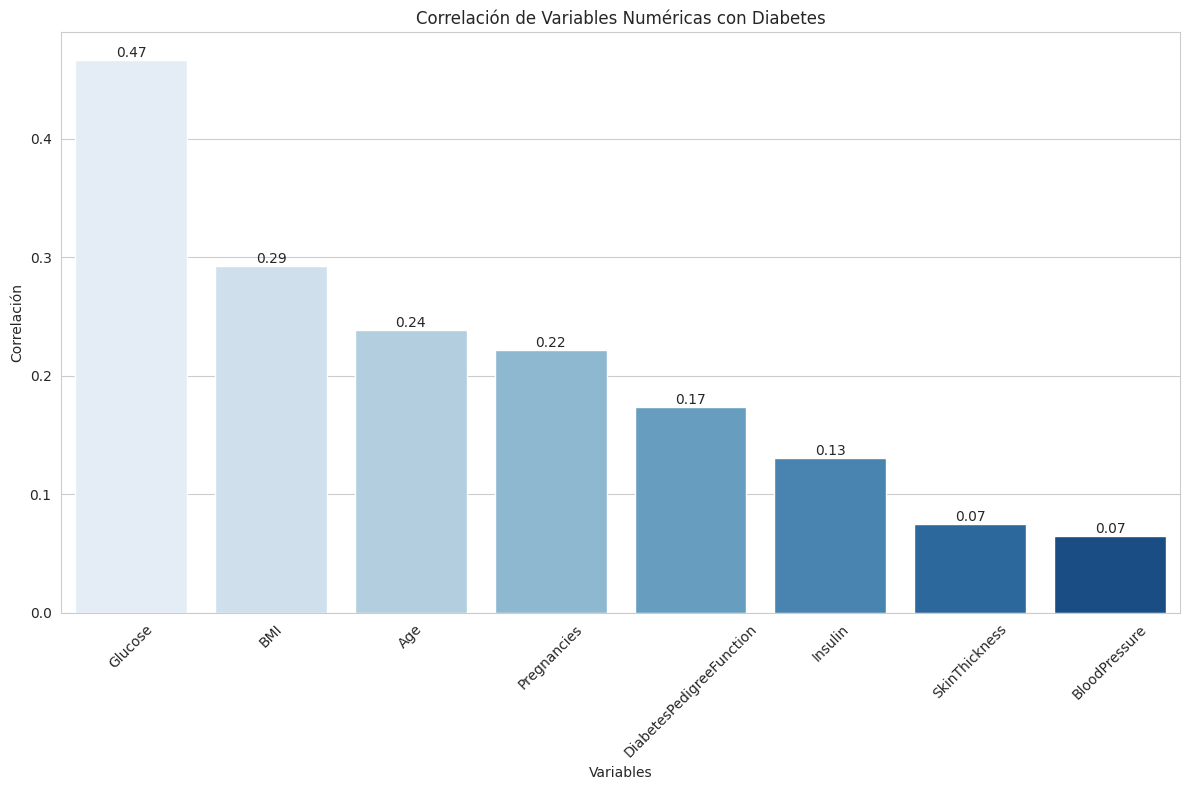

In [ ]:
# Calcular correlaciones con Outcome
correlations = df.corr()['Outcome'].drop('Outcome')

# Ordenar de forma descendente
correlations_sorted = correlations.sort_values(ascending=False)

# Crear barplot
plt.figure(figsize=(12, 8))
sns.barplot(x=correlations_sorted.index, y=correlations_sorted.values, palette='Blues')

# Añadir etiquetas a las barras
for index, value in enumerate(correlations_sorted.values):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

plt.title('Correlación de Variables Numéricas con Diabetes')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.xticks(rotation=45)  # Rotar etiquetas para que no se superpongan
plt.tight_layout()  # Ajustar el diseño para evitar recortes
plt.show()

- Glucose es la variable con la correlación más alta (0.47) con el diagnóstico de diabetes, lo que confirma que los niveles de glucosa son un predictor clave de la enfermedad.

- BMI (Índice de Masa Corporal) tiene una correlación moderada (0.29), destacando el impacto del sobrepeso y la obesidad en el riesgo de diabetes.

- Age (0.24) y Pregnancies (0.22) también muestran correlaciones moderadas, lo que indica que la edad y el número de embarazos tienen una relación significativa, aunque menos fuerte, con el diagnóstico.

- DiabetesPedigreeFunction tiene una correlación baja (0.17), pero sigue siendo relevante al reflejar el historial familiar como un factor de riesgo.

- Insulin, SkinThickness, y BloodPressure tienen correlaciones muy bajas (< 0.13), lo que sugiere que estas variables tienen menor impacto directo en el diagnóstico de diabetes en este dataset.

- En general, las variables más relevantes para predecir diabetes en este dataset son Glucose, BMI, y en menor medida, Age y Pregnancies, mientras que otras variables parecen tener un papel menos significativo.

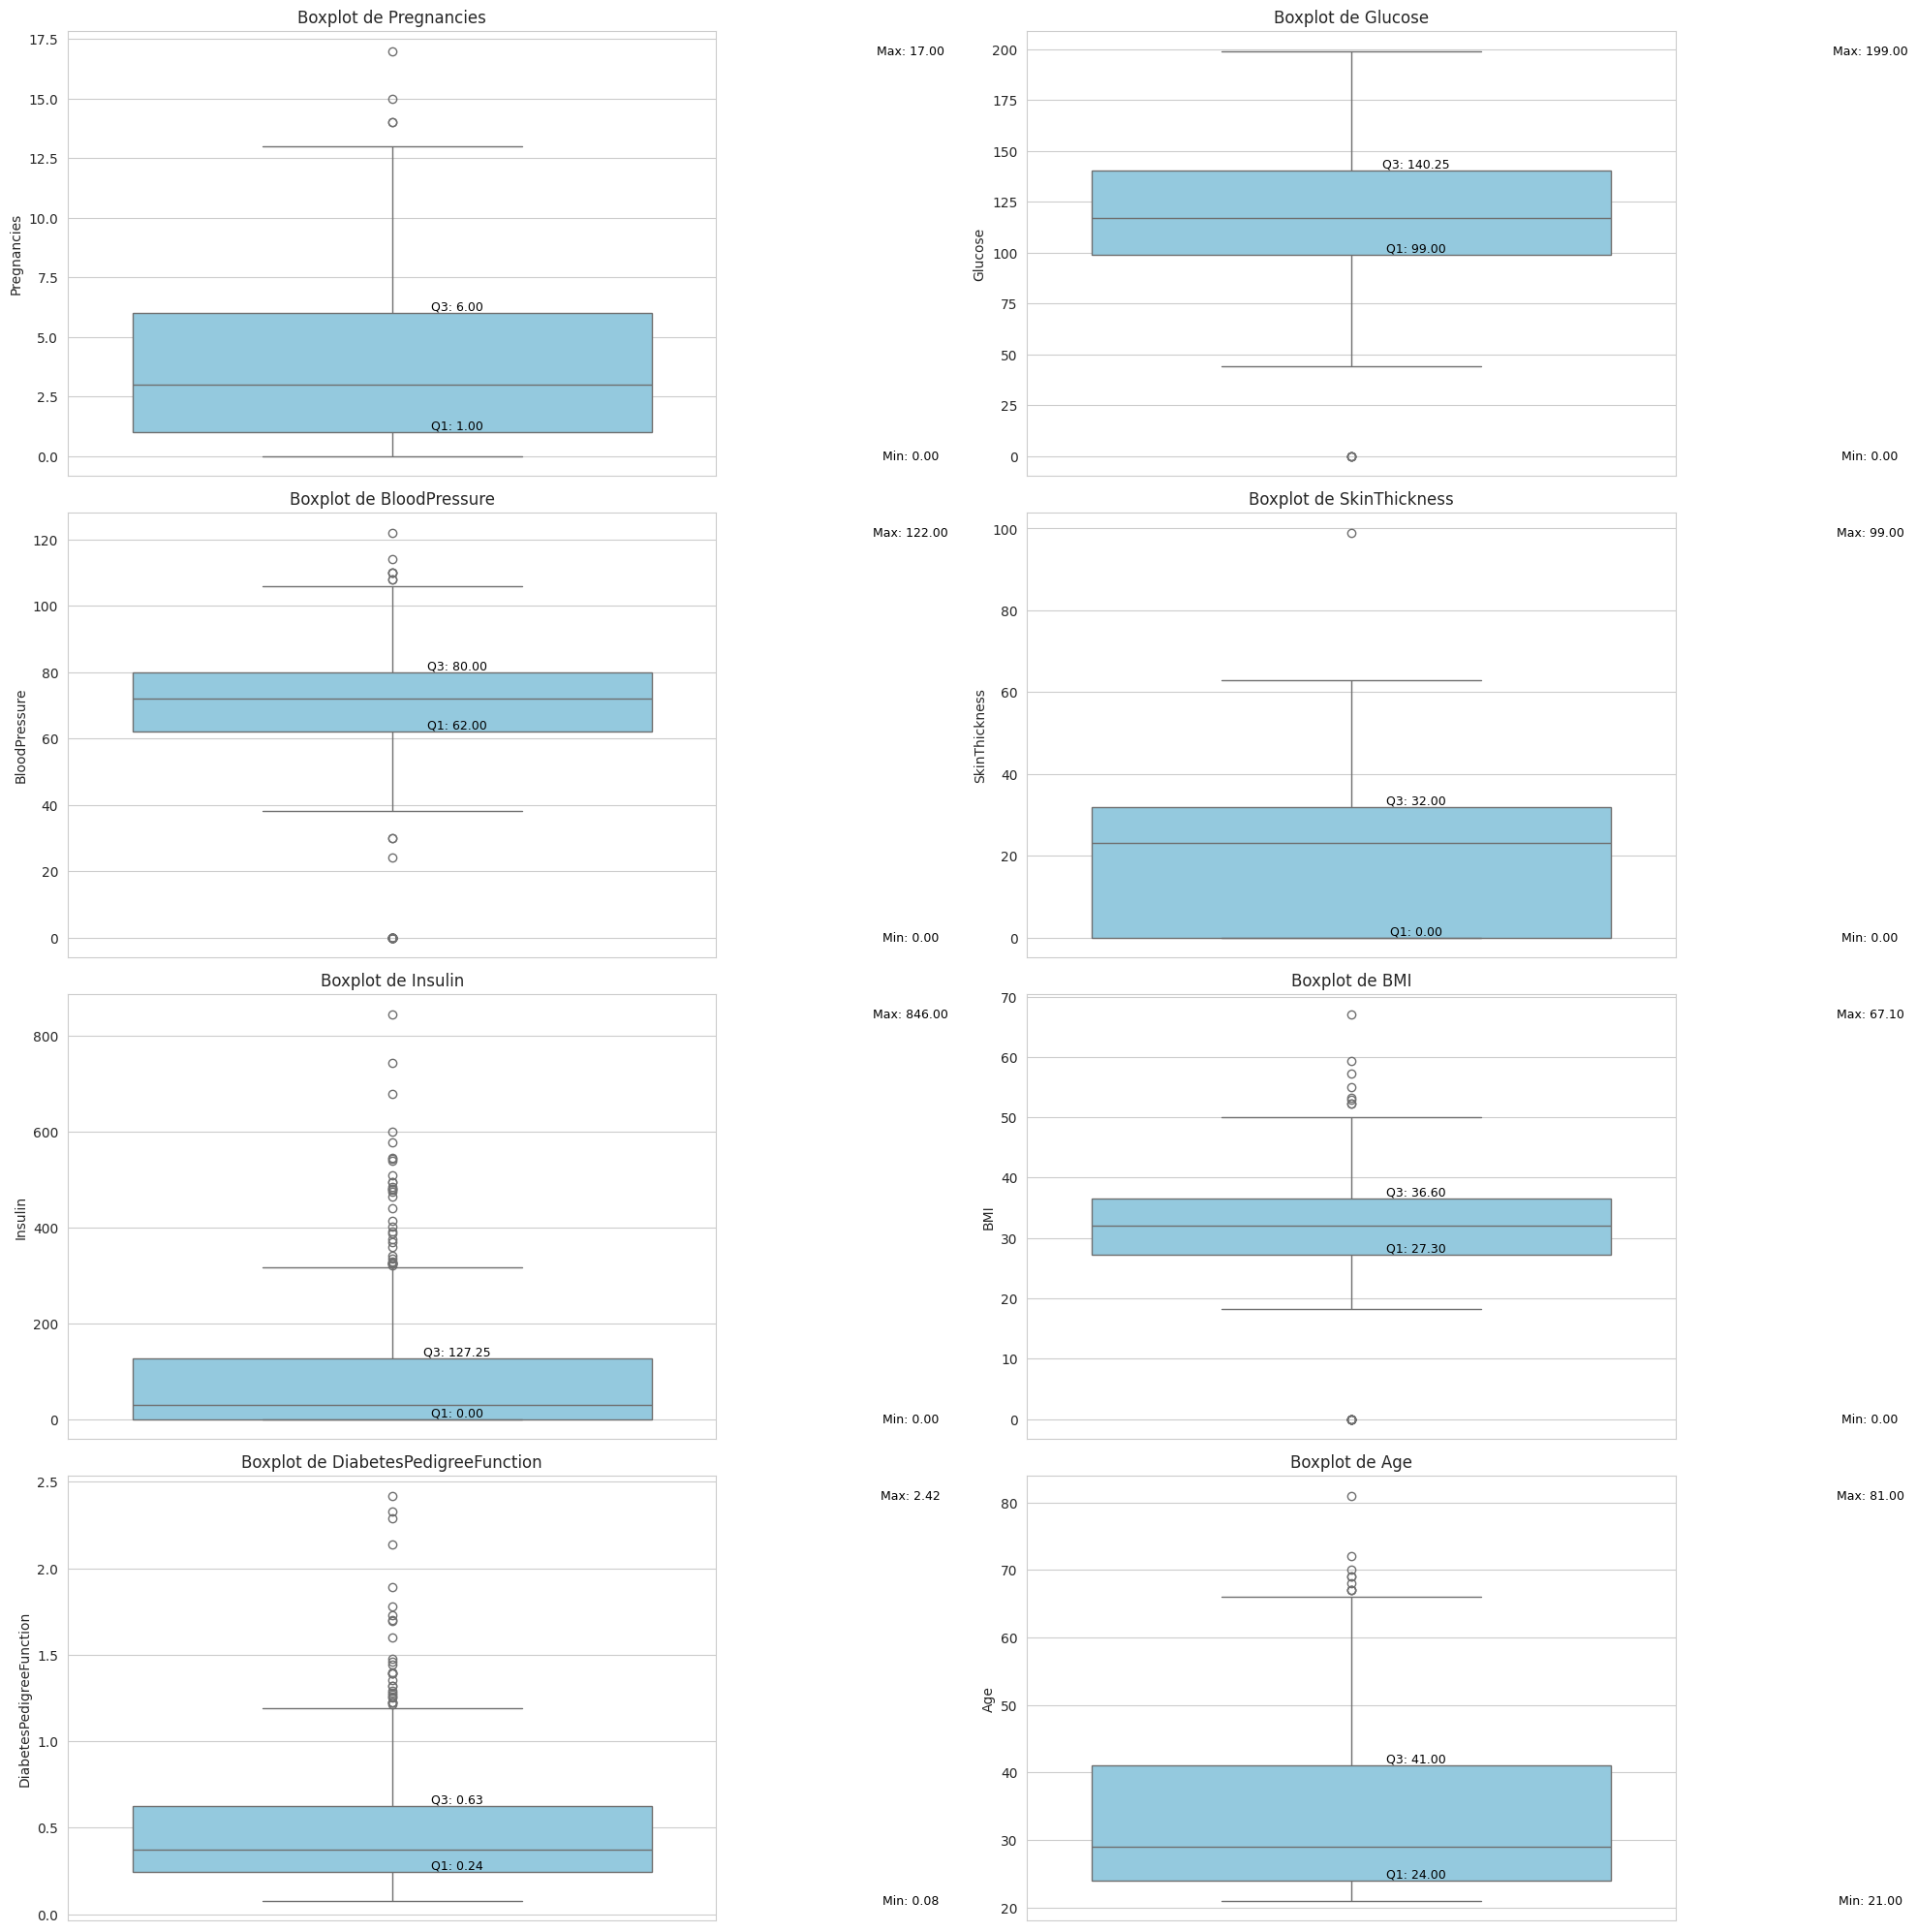

In [ ]:
# Crear boxplots para cada variable con anotaciones
plt.figure(figsize=(20, 25))

for i, var in enumerate(num_vars.columns):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(y=df[var], color='skyblue')
    plt.title(f'Boxplot de {var}')

    # Calcular estadísticas
    stats = df[var].describe()
    q1, q2, q3 = stats['25%'], stats['50%'], stats['75%']
    min_val, max_val = stats['min'], stats['max']

    # Anotar estadísticas al lado del gráfico
    plt.text(0.8, min_val, f'Min: {min_val:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=9, color='black')
    plt.text(0.8, max_val, f'Max: {max_val:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=9, color='black')

    # Anotar estadísticas sobre el gráfico
    plt.text(0.1, q1, f'Q1: {q1:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=9, color='black')
    plt.text(0.1, q3, f'Q3: {q3:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

- Pregnancies:
Hay valores atípicos por encima de 13 embarazos, lo cual es poco común pero posible en casos extremos.

- Glucose:
Existen pocos outliers por debajo del primer cuartil (Q1), lo que sugiere niveles de glucosa inusualmente bajos.

- BloodPressure:
Existen valores atípicos bajos, incluyendo valores de 0, que son fisiológicamente imposibles y probablemente representan datos faltantes.

- SkinThickness:
Hay outliers altos, pero también se observan valores de 0, lo cual indica datos faltantes en esta variable.

- Insulin:
Presenta numerosos outliers altos, con valores que superan los 400, lo que podría reflejar resistencia a la insulina extrema o errores en los datos.
También hay valores de 0, indicando datos faltantes.

- BMI:
Existen outliers altos, especialmente por encima de 50, lo que representa casos de obesidad extrema.

- DiabetesPedigreeFunction:
Se observan algunos outliers altos por encima de 1.5, lo que sugiere un historial familiar excepcionalmente fuerte de diabetes.

- Age:
Hay algunos outliers altos por encima de los 70 años, aunque estos son menos significativos y representan casos esperables en una población mayor.

---

# 3. PREPROCESADO DE DATOS

## COMENZAMOS CON LA LIMPIEZA DE DATOS:

Tratamiento de Valores Faltantes: Podemos eliminarlos o rellenados con un valor específico.

Tratamiento de Outliers: Identificaremos y trataremos valores atípicos que pueden sesgar el modelo.

In [ ]:
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [ ]:
# Contar valores iguales a 0 por columna
missing_values = (num_vars == 0).sum()
print(missing_values)


missing_percentage = missing_values / len(df) * 100
print(missing_percentage)

# Determinar el umbral del 5%
threshold = 5

# Decidir qué hacer con las variables
for var in num_vars.columns:
    if missing_percentage[var] > threshold:
        print(f"La variable {var} supera el umbral del 5% de valores faltantes.")


Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64
Pregnancies                 14.453125
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
dtype: float64
La variable Pregnancies supera el umbral del 5% de valores faltantes.
La variable SkinThickness supera el umbral del 5% de valores faltantes.
La variable Insulin supera el umbral del 5% de valores faltantes.


A pesar de que 'SkinThickness' y 'Insulin' superan nuestro threshold, siguen siendo variables relevante en el contexto de salud.

La insulina es un marcador crucial en la evaluación del riesgo de diabetes y otras enfermedades metabólicas. Su papel principal es regular los niveles de glucosa en sangre, permitiendo que las células utilicen la glucosa como fuente de energía. La resistencia a la insulina o la insuficiencia de esta hormona puede conducir a condiciones graves como diabetes tipo 2, complicaciones cardiovasculares y daño renal.

La grosura de la piel es un indicador importante tanto en el diagnóstico como en el monitoreo de condiciones fisiológicas y patológicas. En el contexto médico, se utiliza para evaluar cambios relacionados con enfermedades metabólicas, envejecimiento, cicatrización y otras afecciones cutáneas. Además, su medición puede ser relevante para terapias transdérmicas, como la administración de insulina en pacientes diabéticos. Los valores anómalos en el grosor de la piel pueden reflejar alteraciones metabólicas o estructurales que requieren atención clínica.

Por ello vamos a imputar los valores faltantes en ellas también. Utilizaremos un mapa de calor para visualizar los patrones de valores faltantes en el dataset. Esto ayudará a identificar si los valores faltantes están relacionados con otras variables. Nos permitirá seleccionar mejor el metodo de imputación.

<Axes: >

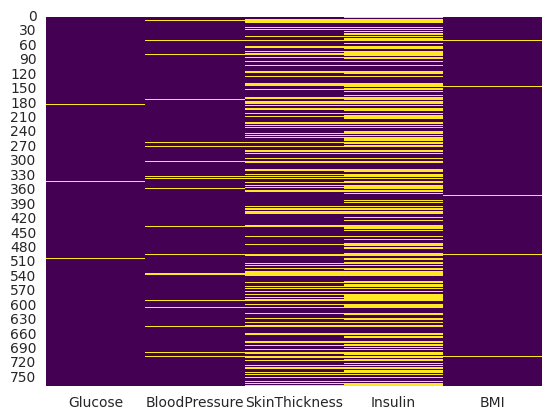

In [ ]:
cero_vars = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] == 0

# Analizar patrones de valores faltantes
sns.heatmap(cero_vars, cbar=False, cmap='viridis')

El mapa de calor sugiere que existe una relación entre los valores faltantes en las variables SkinThickness e Insulin. Esto podría indicar un problema compartido en la medición o recolección de datos para estas variables. Antes de imputar los valores, sería útil investigar si esta correlación tiene una base lógica o si se debe a errores sistemáticos. Además, las técnicas de imputación deberían considerar estas relaciones para preservar la coherencia del dataset.


- Verificaremos la correlación entre las variables Insulin y SkinThickness (sin valores faltantes)

- Analizaremos patrones de valores faltantes:
Para ver si los valores faltantes (ceros) en Insulin y SkinThickness ocurren simultáneamente con más frecuencia de lo esperado.

In [ ]:
# Filtrar filas donde Insulin y SkinThickness no sean 0
valid_data = df[(df['Insulin'] != 0) & (df['SkinThickness'] != 0)]

# Calcular la correlación entre Insulin y SkinThickness
correlation = valid_data[['Insulin', 'SkinThickness']].corr()
print(correlation)


                Insulin  SkinThickness
Insulin        1.000000       0.184888
SkinThickness  0.184888       1.000000


In [ ]:
# Crear una columna booleana para indicar filas con valores faltantes en ambas variables
df['missing_both'] = (df['Insulin'] == 0) & (df['SkinThickness'] == 0)

# Contar cuántas filas tienen valores faltantes en ambas variables
missing_both_count = df['missing_both'].sum()
print(f"Filas con valores faltantes en ambas variables: {missing_both_count}")

# Comparar con el total de valores faltantes individuales
missing_insulin = (df['Insulin'] == 0).sum()
missing_skinthickness = (df['SkinThickness'] == 0).sum()

print(f"Valores faltantes en Insulin: {missing_insulin}")
print(f"Valores faltantes en SkinThickness: {missing_skinthickness}")


Filas con valores faltantes en ambas variables: 227
Valores faltantes en Insulin: 374
Valores faltantes en SkinThickness: 227


A partir de los gráficos y los datos proporcionados, podemos realizar las siguientes observaciones sobre la relación entre los valores faltantes (representados por ceros) en las variables Insulin y SkinThickness:

1. Correlación entre Insulin y SkinThickness:
El coeficiente de correlación entre estas dos variables es 0.184888, lo cual indica una correlación débil pero positiva. Esto sugiere que, en los datos válidos (cuando ambas variables no son 0), no hay una relación fuerte entre Insulin y SkinThickness. Por lo tanto, la correlación de valores faltantes probablemente no se debe a una relación lógica inherente entre estas dos variables.

2. Filas con valores faltantes en ambas variables:
Cada vez que SkinThickness es 0, también lo es Insulin. Sin embargo, no ocurre lo mismo al revés, ya que Insulin tiene un total de 374 valores faltantes, lo que significa que hay casos donde solo Insulin es 0.
Este patrón sugiere un posible problema sistemático en la recolección o registro de datos para estas dos variables.

Según la documentación del dataset, estos valores fueron introducidos como marcadores para indicar datos faltantes debido a:
- Errores sistemáticos en la recolección: Es posible que ciertos parámetros no se midieran para algunos pacientes debido a limitaciones técnicas o logísticas.

- Falta de relevancia clínica: En algunos casos, las mediciones podrían haberse omitido si no eran necesarias para el diagnóstico o seguimiento del paciente.

- Fuentes de datos mixtas: Los datos provienen tanto de registros electrónicos como manuales, lo que podría haber contribuido a inconsistencias en la captura de información.

- Es necesario imputar estos valores para evitar sesgos en el análisis posterior.

## Estrategia de imputación:

1. Glucose:
Es un marcador clave en el diagnóstico de diabetes. Solo presenta 5 valores faltantes, lo que equivale a un porcentaje muy bajo del dataset. Imputaremos con la mediana de la variable, ya que la cantidad de valores faltantes es baja y no afecta significativamente la distribución.
2. BloodPressure: Presenta una cantidad de valores faltantes moderada (35).
Imputaremos con la mediana, ya que no hay una fuerte correlación con otras variables y la cantidad de valores faltantes sigue siendo manejable.
3. BMI: Lantidad de valores faltantes es baja (11).
Imputaremos con la mediana, ya que los valores faltantes son pocos y no afectan significativamente el análisis.
4. SkinThicknes: La cantidad de valores faltantes es alta (227). Dado que SkinThickness tiene una correlación moderada con BMI (0.39) y Insulin (0.44), usaremos un enfoque iterativo para manejar sus valores faltantes:
Crearemos una columna temporal (SkinThickness_temp) donde imputaremos los valores faltantes de SkinThickness utilizando la mediana.
Utilizaremos esta columna temporal junto con el resto de las variables relevantes (Glucose, BMI, Age, BloodPressure, Pregnancies, DiabetesPedigreeFunction) para imputar los valores faltantes de Insulin mediante un modelo Random Forest.
Finalmente, reimputaremos los valores reales de SkinThickness utilizando un modelo Random Forest, considerando como predictores las variables completas, incluida la versión imputada de Insulin.
5. Insulin: La cantidad de valores faltantes es alta (374). Dado que Insulin tiene una correlación moderada con Glucose (0.33) y SkinThickness (0.44), usaremos un modelo Random Forest para imputar esta variable utilizando como predictores:
Glucose,
SkinThickness_temp (columna temporal),
BMI,
Age,
BloodPressure,
Pregnancies,
DiabetesPedigreeFunction.
- Anteriormente utilizamos la técnica MICE para imputar simultáneamente SkinThickness e Insulin. Sin embargo, esto resultó en sesgos en las distribuciones y relaciones entre estas variables, especialmente en la correlación entre ellas, que disminuyó significativamente tras la imputación. Para resolver este problema:
  - Adoptamos un enfoque iterativo que evita dependencias mutuas directas entre variables con muchos valores faltantes.
  - Usamos modelos avanzados como Random Forest para capturar mejor las relaciones no lineales entre las variables.
  - Este enfoque preserva mejor las correlaciones clave (SkinThickness-BMI, Insulin-Glucose) y genera distribuciones más consistentes con los datos válidos del dataset original.


In [ ]:
# Crear una copia del DataFrame original para realizar imputaciones
df_cleaned = df.copy()

In [ ]:
# Imputamos valores de Glucosa
df_cleaned['Glucose'] = df_cleaned['Glucose'].replace(0, df_cleaned['Glucose'].median())

# Imputamos valores de BloodPressure
df_cleaned['BloodPressure'] = df_cleaned['BloodPressure'].replace(0, df_cleaned['BloodPressure'].median())

# Imputamos valores de BMI
df_cleaned['BMI'] = df_cleaned['BMI'].replace(0, df_cleaned['BMI'].median())


Debemos tener en cuenta que el imputador iterativo (IterativeImputer) solo imputa valores faltantes representados como NaN. Si los valores faltantes están representados como ceros (como en este caso), el imputador no los considera como datos faltantes y no los reemplazará. Debemos convertir los ceros en las columnas SkinThickness e Insulin a NaN antes de aplicar la imputación iterativa.

In [ ]:
# Paso 1: Crear una columna temporal para SkinThickness -> ['SkinThickness_temp']

# Reemplazar ceros por NaN
df_cleaned[['SkinThickness', 'Insulin']] = df_cleaned[['SkinThickness', 'Insulin']].replace(0, np.nan)

# Imputar SkinThickness preliminarmente con la mediana
df_cleaned['SkinThickness_temp'] = df_cleaned['SkinThickness'].fillna(df_cleaned['SkinThickness'].median())



In [ ]:
# Paso 2: Usar la columna temporal para predecir Insulin
from sklearn.ensemble import RandomForestRegressor

# Filtrar datos completos para Insulin
complete_data_insulin = df_cleaned[df_cleaned['Insulin'].notnull()]
X_insulin = complete_data_insulin[['Glucose', 'SkinThickness_temp', 'BMI', 'Age', 'BloodPressure', 'Pregnancies', 'DiabetesPedigreeFunction']]
y_insulin = complete_data_insulin['Insulin']

# Filtrar datos con valores faltantes en Insulin
missing_data_insulin = df_cleaned[df_cleaned['Insulin'].isnull()]
X_missing_insulin = missing_data_insulin[['Glucose', 'SkinThickness_temp', 'BMI', 'Age', 'BloodPressure', 'Pregnancies', 'DiabetesPedigreeFunction']]

# Entrenar modelo Random Forest para Insulin
rf_model_insulin = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_insulin.fit(X_insulin, y_insulin)

# Predecir los valores faltantes de Insulin
predicted_insulin = rf_model_insulin.predict(X_missing_insulin)

# Reemplazar los valores faltantes en Insulin
df_cleaned.loc[missing_data_insulin.index, 'Insulin'] = predicted_insulin


In [ ]:
# Paso 3: Reimputar la columna original de SkinThickness

# Filtrar datos completos para SkinThickness
complete_data_skin = df_cleaned[df_cleaned['SkinThickness'].notnull()]
X_skin = complete_data_skin[['Glucose', 'Insulin', 'BMI', 'Age', 'BloodPressure', 'Pregnancies', 'DiabetesPedigreeFunction']]
y_skin = complete_data_skin['SkinThickness']

# Filtrar datos con valores faltantes en SkinThickness
missing_data_skin = df_cleaned[df_cleaned['SkinThickness'].isnull()]
X_missing_skin = missing_data_skin[['Glucose', 'Insulin', 'BMI', 'Age', 'BloodPressure', 'Pregnancies', 'DiabetesPedigreeFunction']]

# Entrenar modelo Random Forest con ajustes en los hiperparámetros
rf_model_skin = RandomForestRegressor(
    n_estimators=200,  # Incrementamos el número de árboles
    max_depth=10,      # Limitamos la profundidad máxima
    min_samples_leaf=5,  # Aumentamos el mínimo de muestras por hoja
    random_state=42
)
rf_model_skin.fit(X_skin, y_skin)

# Predecir los valores faltantes de SkinThickness
predicted_skinthickness = rf_model_skin.predict(X_missing_skin)

# Reemplazar los valores faltantes en SkinThickness
df_cleaned.loc[missing_data_skin.index, 'SkinThickness'] = predicted_skinthickness

# Eliminar la columna temporal si ya no es necesaria
df_cleaned.drop(columns=['SkinThickness_temp'], inplace=True)




In [ ]:
# Verificar si quedan valores faltantes
print((df_cleaned[['Glucose', 'BloodPressure', 'BMI', 'SkinThickness', 'Insulin']]== 0).sum())


Glucose          0
BloodPressure    0
BMI              0
SkinThickness    0
Insulin          0
dtype: int64


Para evaluar si la imputación realizada ha sido adecuada y si no deberíamos haber utilizado otro modelo, seguiremos estos pasos de validación:

- Comparar las distribuciones de las variables antes y después de la imputación para asegurarnos de que los valores imputados son consistentes con los datos originales.
- Comparar estadísticas descriptivas (media, mediana, percentiles) antes y después de la imputación para detectar desviaciones significativas.
- Verifica si las relaciones entre variables (correlaciones) se mantienen consistentes después de la imputación. Esto es especialmente importante para SkinThickness e Insulin, ya que sus valores fueron imputados usando modelos predictivos basados en otras variables.

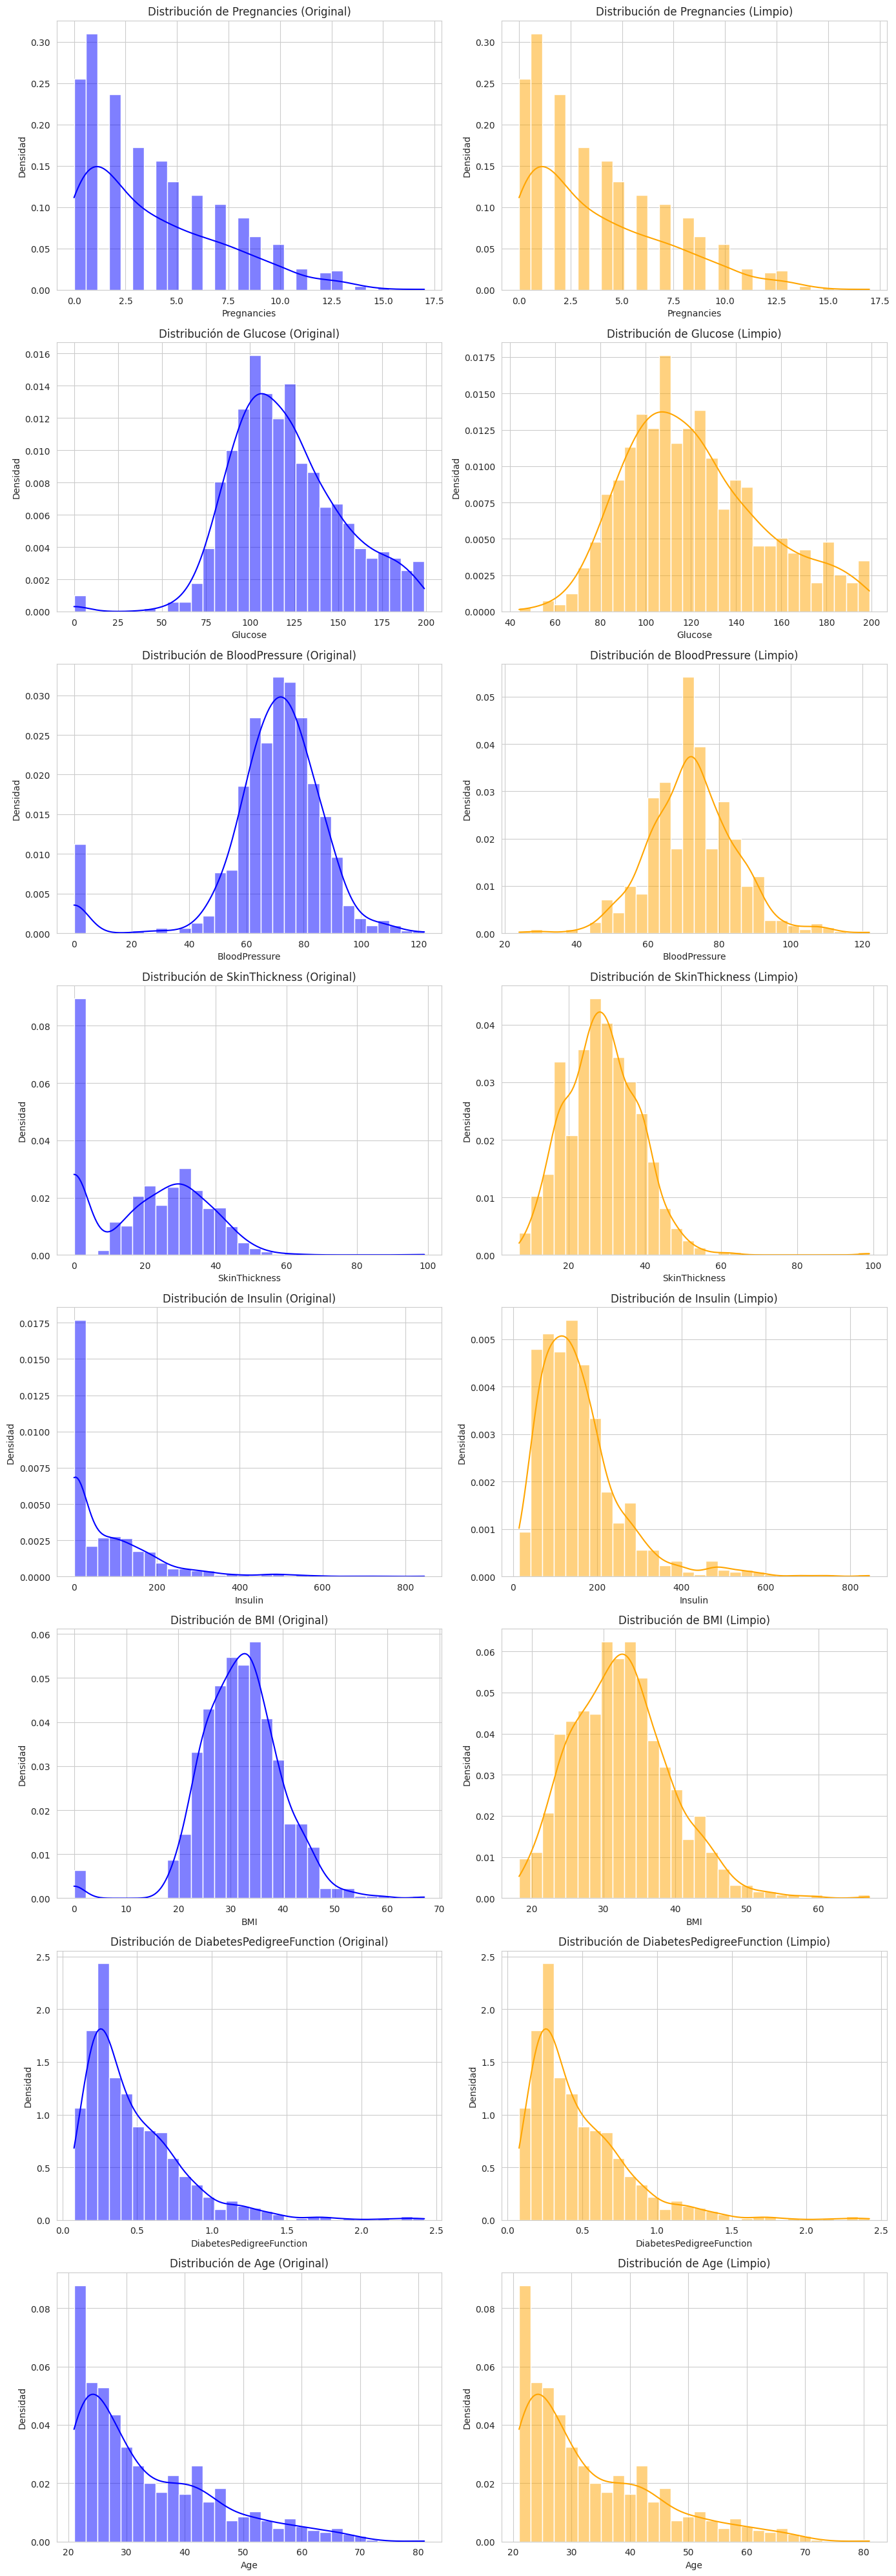

In [ ]:
# Lista de variables numéricas a comparar, excluyendo 'Outcome' y 'missing_both'
variables = [col for col in df.columns if col not in ['Outcome', 'missing_both']]

# Calcular el número de filas necesarias (una fila por variable)
n_variables = len(variables)

# Crear subplots con dos columnas (original y limpio)
fig, axes = plt.subplots(n_variables, 2, figsize=(14, 5 * n_variables))

# Iterar sobre cada variable
for i, variable in enumerate(variables):
    # Dataset original (izquierda)
    sns.histplot(df[variable], kde=True, color='blue', stat='density', bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribución de {variable} (Original)')
    axes[i, 0].set_xlabel(variable)
    axes[i, 0].set_ylabel('Densidad')

    # Dataset limpio (derecha)
    sns.histplot(df_cleaned[variable], kde=True, color='orange', stat='density', bins=30, ax=axes[i, 1])
    axes[i, 1].set_title(f'Distribución de {variable} (Limpio)')
    axes[i, 1].set_xlabel(variable)
    axes[i, 1].set_ylabel('Densidad')

# Ajustar el diseño
plt.tight_layout()
plt.show()


In [ ]:
# Verificar y eliminar la columna 'missing_both'
if 'missing_both' in df.columns:
    df.drop(columns=['missing_both'], inplace=True)

if 'missing_both' in df_cleaned.columns:
    df_cleaned.drop(columns=['missing_both'], inplace=True)


In [ ]:
print(df_cleaned.describe())
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      28.852713  157.002161   
std       3.369578   30.438286      12.096642       9.573208  102.416317   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      22.000000   87.797500   
50%       3.000000  117.000000      72.000000      28.536146  135.000000   
75%       6.000000  140.250000      80.000000      35.032540  192.220000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.450911                  0.471876   33.240885    0.348958  
std      6.875366                  0.331329   11.760232    0.476951  
min     18.200000                  

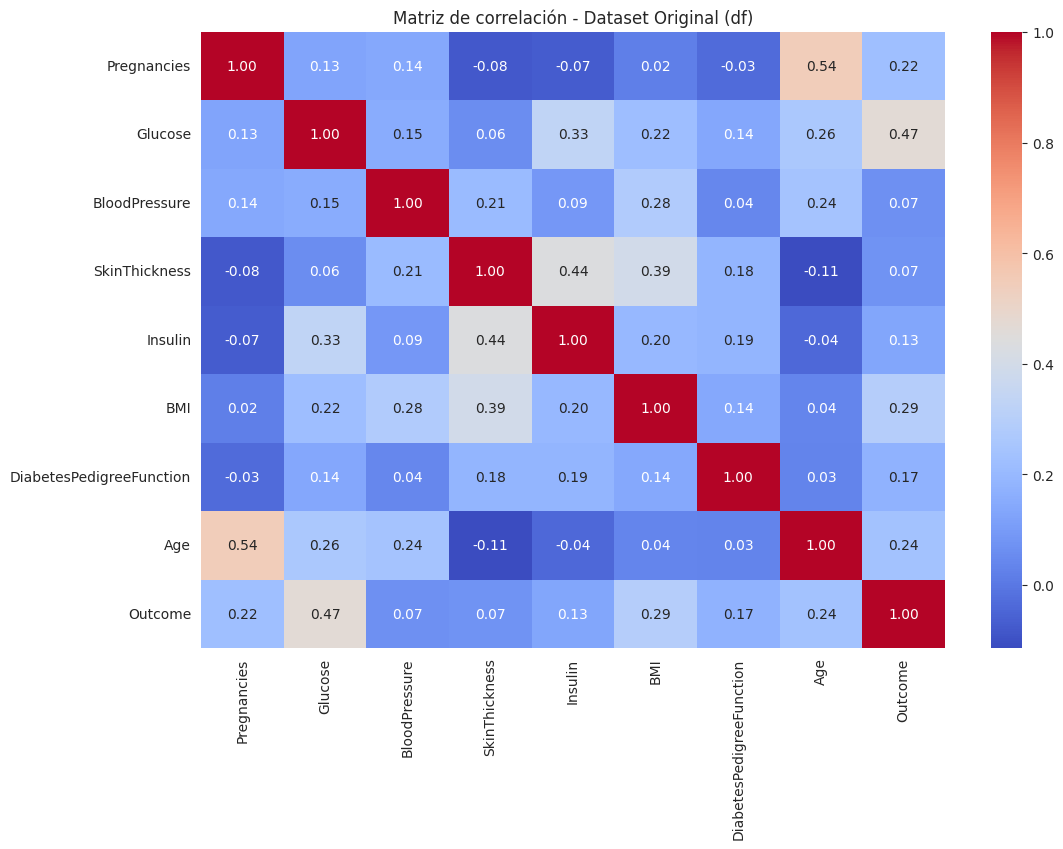

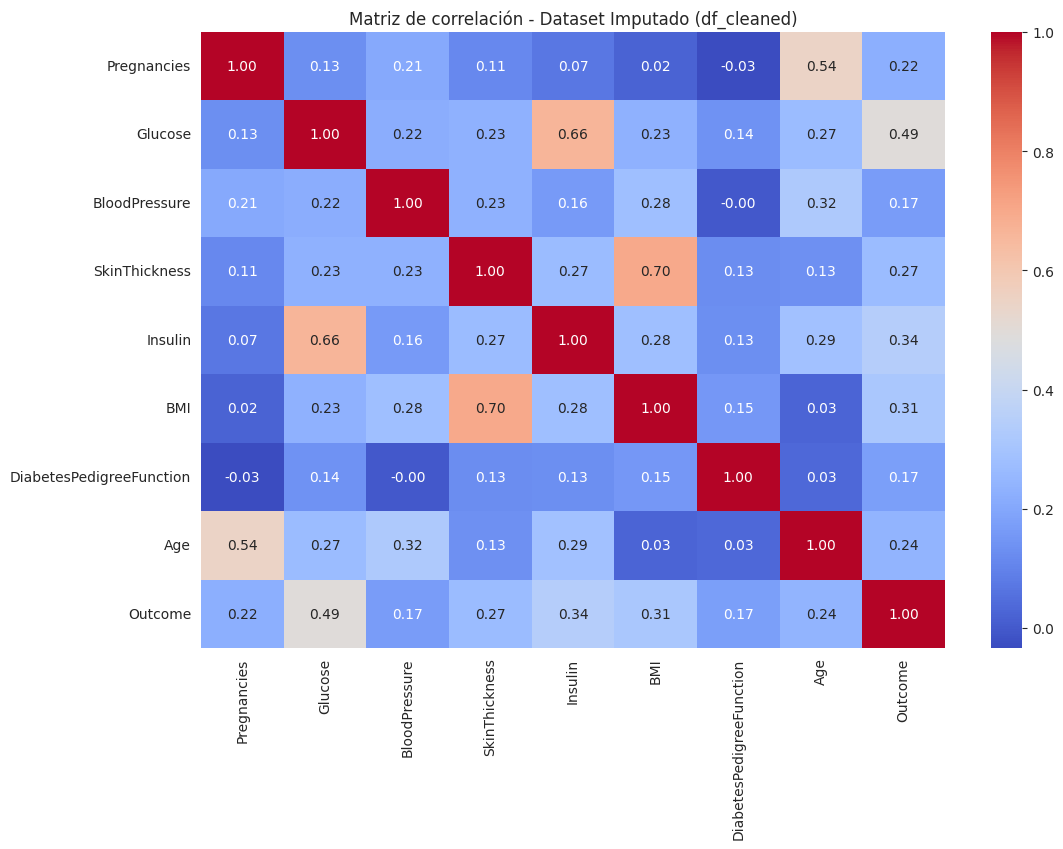

In [ ]:
# Calcular la matriz de correlación para el dataset original (df)
correlation_original = df.corr()

# Calcular la matriz de correlación para el dataset imputado (df_cleaned)
correlation_cleaned = df_cleaned.corr()

# Crear el mapa de calor para el dataset original
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_original, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación - Dataset Original (df)")
plt.show()

# Crear el mapa de calor para el dataset imputado
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_cleaned, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación - Dataset Imputado (df_cleaned)")
plt.show()

- Glucose, BloodPressure, y BMI han sido correctamente imputadas utilizando métodos simples como la mediana.
Las distribuciones son consistentes con los datos originales y no muestran sesgos significativos.

- Variables con modelos predictivos:
SkinThickness e Insulin han sido bien imputadas utilizando Random Forest:
Ambas variables muestran distribuciones naturales y consistentes con los datos válidos del dataset original.
Las colas largas características se han preservado, reflejando mejor la variabilidad esperada.

- Relaciones entre variables:
Las correlaciones entre variables relacionadas fisiológicamente (SkinThickness y BMI, Insulin y Glucose) ahora son más fuertes, lo cual es razonable tras la imputación.
Esto sugiere que el modelo predictivo utilizado para imputar estas variables capturó correctamente las relaciones subyacentes.
Las correlaciones entre otras variables (Pregnancies, Age, y Outcome) permanecen consistentes, lo que indica que la imputación no introdujo sesgos significativos en estas relaciones.

## Identificamos los outliers y decidimos cómo tratarlos

In [ ]:
# Seleccionar las columnas numéricas
nume_vars = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Identificar outliers usando el rango intercuartílico (IQR)
outliers = {}
for var in nume_vars:
    Q1 = df_cleaned[var].quantile(0.25)
    Q3 = df_cleaned[var].quantile(0.75)
    IQR = Q3 - Q1

    # Calcular los límites inferior y superior
    lower_bound = max(Q1 - 1.5 * IQR, 0)  # Ajustar el límite inferior a 0 si es negativo
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar outliers
    outliers[var] = df_cleaned[(df_cleaned[var] < lower_bound) | (df_cleaned[var] > upper_bound)][var]

    print(f"Límites para {var}:")
    print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    print(f"Número de outliers en {var}: {len(outliers[var])}")


Límites para Pregnancies:
Lower Bound: 0, Upper Bound: 13.5
Número de outliers en Pregnancies: 4
Límites para Glucose:
Lower Bound: 39.0, Upper Bound: 201.0
Número de outliers en Glucose: 0
Límites para BloodPressure:
Lower Bound: 40.0, Upper Bound: 104.0
Número de outliers en BloodPressure: 14
Límites para SkinThickness:
Lower Bound: 2.451190235569328, Upper Bound: 54.58134960738445
Número de outliers en SkinThickness: 4
Límites para Insulin:
Lower Bound: 0, Upper Bound: 348.85375
Número de outliers en Insulin: 36
Límites para BMI:
Lower Bound: 13.849999999999998, Upper Bound: 50.25
Número de outliers en BMI: 8
Límites para DiabetesPedigreeFunction:
Lower Bound: 0, Upper Bound: 1.2
Número de outliers en DiabetesPedigreeFunction: 29
Límites para Age:
Lower Bound: 0, Upper Bound: 66.5
Número de outliers en Age: 9


- Las variables Insulin, BloodPressure, y DiabetesPedigreeFunction presentan un número significativo de outliers, lo cual es esperado debido a su alta variabilidad fisiológica.

- Los valores atípicos en variables como Pregnancies, SkinThickness, y BMI son plausibles pero representan casos extremos que podrían influir en los análisis posteriores si no se manejan adecuadamente.

- No se identificaron outliers en Glucose, lo que indica que esta variable está dentro de un rango razonable tras la imputación.

- En el presente análisis del conjunto de datos de Diabetes de los Indios Pima, adoptamos un enfoque cauteloso hacia el tratamiento de los valores atípicos. Reconocemos que, si bien algunos valores extremos podrían considerarse errores de medición, muchos de ellos representan características biológicas reales y plausibles dentro de la población de estudio. Por ejemplo, niveles elevados de insulina pueden indicar resistencia a la insulina o etapas tempranas de la diabetes tipo 2, mientras que un alto número de embarazos puede reflejar patrones demográficos específicos de la comunidad Pima.

Por lo tanto, en lugar de eliminar o transformar agresivamente estos valores atípicos, optamos por aplicar técnicas de tratamiento que mitiguen su impacto en los modelos predictivos sin eliminar por completo la información que contienen. Esto nos permite preservar la variabilidad natural de los datos y evitar la introducción de sesgos artificiales, al tiempo que mejoramos la robustez y la generalización de los modelos

- Hemos optado por crear diferentes DataFrames para probar distintos enfoques de tratamiento de outliers y comparar los resultados. En este cuaderno vamos a aplicar:
  - Transformación logarítmica para variables con distribuciones sesgadas hacia la derecha (como Insulin, BMI, o DiabetesPedigreeFunction).
  - Imputación con la mediana para variables con pocos valores atípicos que no afectan significativamente la distribución general.
  - Winsorización para reducir el impacto de los valores extremos mientras se preservan todos los registros.
  - Reemplazo por límites aceptables cuando los valores extremos son plausibles pero deben ajustarse a límites razonables.

In [ ]:
# Crear una nueva copia del DataFrame para la nueva estrategia de outliers
df_adjusted = df_cleaned.copy()

Este DataFrame representa nuestra primera iteración en el tratamiento de outliers. Aquí aplicamos:
- Transformación logarítmica: Para variables sesgadas hacia la derecha, como Insulin, BMI y DiabetesPedigreeFunction.
- Winsorización: Para variables con valores extremos plausibles pero que deben ajustarse, como Pregnancies y Age.
- Imputación con la mediana: Para variables con pocos valores atípicos, como SkinThickness y BloodPressure.

In [ ]:
# 1. Transformación Logarítmica + Winsorización para Insulin, BMI y DiabetesPedigreeFunction
log_vars = ['Insulin', 'BMI', 'DiabetesPedigreeFunction']
winsorization_limit = 0.025  # Reducir este límite para mayor control

for var in log_vars:
    # Transformación Logarítmica
    df_adjusted[f'{var}_log'] = np.log1p(df_adjusted[var])

    # Winsorización de la variable transformada
    df_adjusted[f'{var}_log_winsorized'] = winsorize(df_adjusted[f'{var}_log'], limits=[winsorization_limit, winsorization_limit])


In [ ]:
# 2. Ajuste de Límites de Winsorización para Pregnancies y Age
winsorization_limit_pregnancies = 0.05  # Aumentar este límite para reducir la acumulación
winsorization_limit_age = 0.05  # Aumentar este límite para reducir la acumulación

df_adjusted['Pregnancies_winsorized'] = winsorize(df_adjusted['Pregnancies'], limits=[winsorization_limit_pregnancies, winsorization_limit_pregnancies])
df_adjusted['Age_winsorized'] = winsorize(df_adjusted['Age'], limits=[winsorization_limit_age, winsorization_limit_age])

In [ ]:
# 3. Imputación con la mediana para SkinThickness y BloodPressure (sin cambios)
median_vars = ['SkinThickness', 'BloodPressure']
for var in median_vars:
    median_value = df_adjusted[var].median()
    iqr = df_adjusted[var].quantile(0.75) - df_adjusted[var].quantile(0.25)
    lower_bound = df_adjusted[var].quantile(0.25) - 1.5 * iqr
    upper_bound = df_adjusted[var].quantile(0.75) + 1.5 * iqr

    # Reemplazar outliers por la mediana
    df_adjusted[var] = np.where(
        (df_adjusted[var] < lower_bound) | (df_adjusted[var] > upper_bound),
        median_value,
        df_adjusted[var]
    )

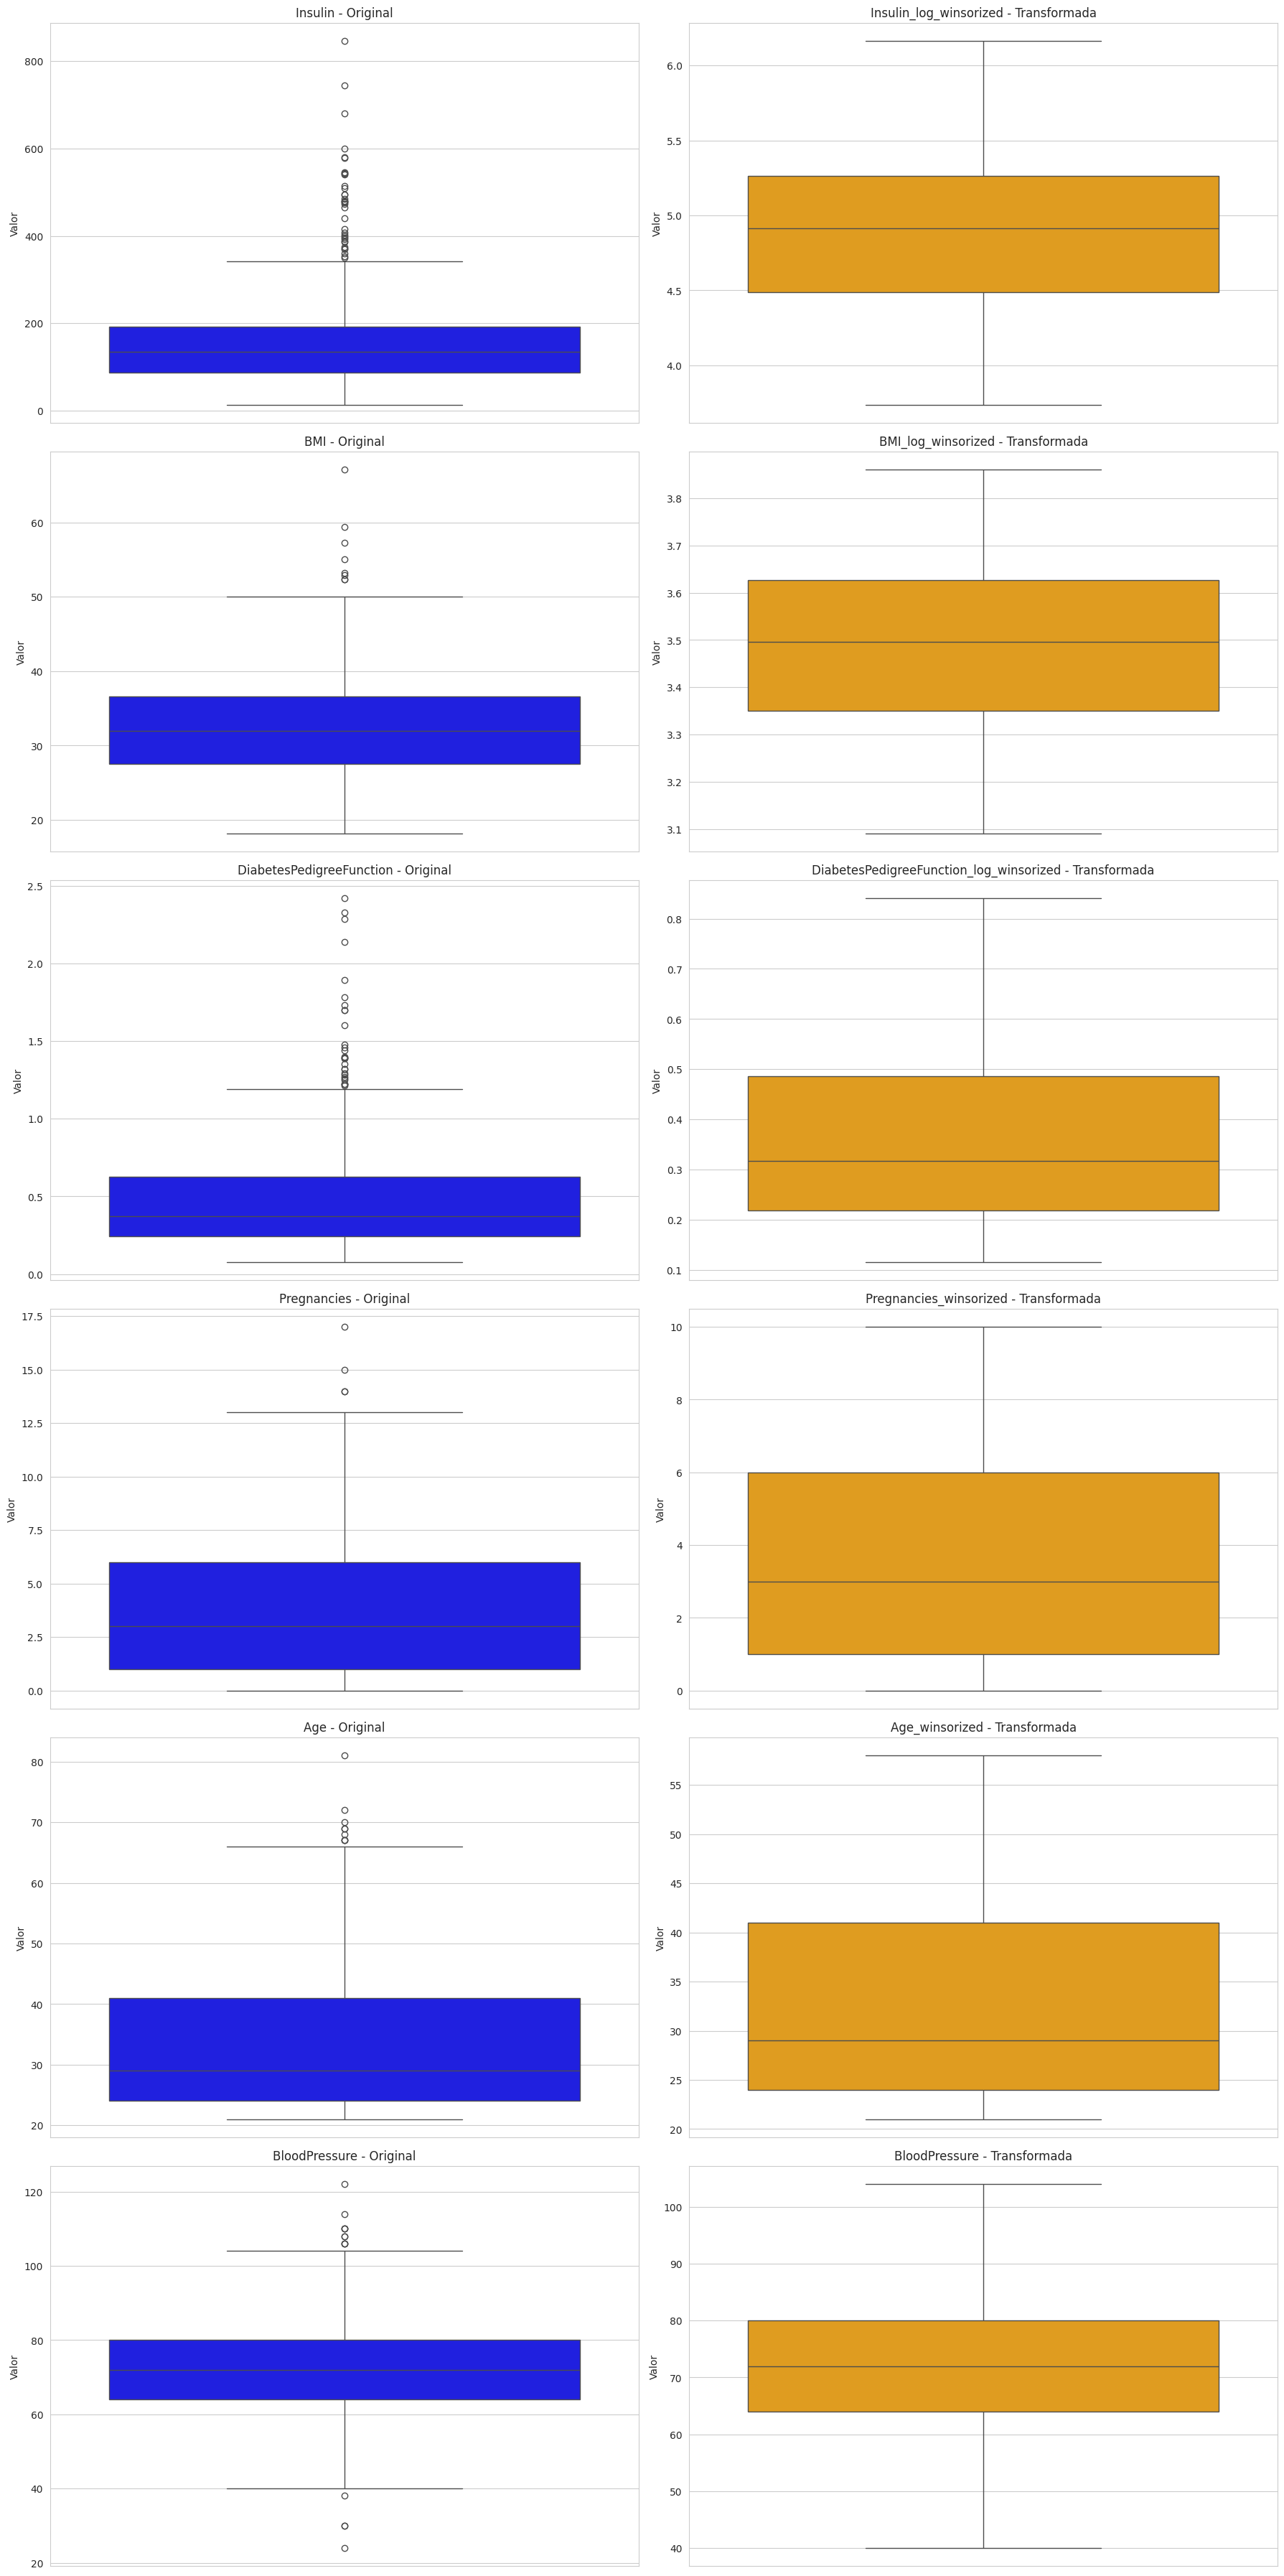

In [ ]:
# Lista de variables a visualizar
variables_a_visualizar = {
    'Insulin': ('Insulin', 'Insulin_log_winsorized'),
    'BMI': ('BMI', 'BMI_log_winsorized'),
    'DiabetesPedigreeFunction': ('DiabetesPedigreeFunction', 'DiabetesPedigreeFunction_log_winsorized'),
    'Pregnancies': ('Pregnancies', 'Pregnancies_winsorized'),
    'Age': ('Age', 'Age_winsorized'),
    'BloodPressure': ('BloodPressure', 'BloodPressure')  # Ya que imputamos, mostramos la variable directamente
}

# Calcular el número de filas necesarias para las variables
n_variables = len(variables_a_visualizar)

# Crear subplots
fig, axes = plt.subplots(n_variables, 2, figsize=(18, 6 * n_variables))

# Iterar sobre las variables y crear los gráficos
for i, (var, (var_original, var_transformada)) in enumerate(variables_a_visualizar.items()):
    # Boxplot de la variable original
    sns.boxplot(y=df_cleaned[var_original], color='blue', ax=axes[i, 0])
    axes[i, 0].set_title(f'{var_original} - Original')
    axes[i, 0].set_ylabel('Valor')

    # Boxplot de la variable transformada
    sns.boxplot(y=df_adjusted[var_transformada], color='orange', ax=axes[i, 1])
    axes[i, 1].set_title(f'{var_transformada} - Transformada')
    axes[i, 1].set_ylabel('Valor')

plt.tight_layout()
plt.show()


---

Ahora vamos a crear un nuevo dataframe llamado df_adjusted2:

Este DataFrame refleja un enfoque refinado basado en las observaciones del primer ajuste.

- Mantenemos la transformación logarítmica y winsorización para Insulin y BMI.

- Aplicamos un límite de winsorización más estricto (1%) para DiabetesPedigreeFunction para abordar mejor sus valores extremos.

- Aumentamos el límite de winsorización al 7.5% para Pregnancies y Age para reducir la acumulación de valores en los extremos.

- Mantenemos la misma estrategia de imputación para SkinThickness y BloodPressure.

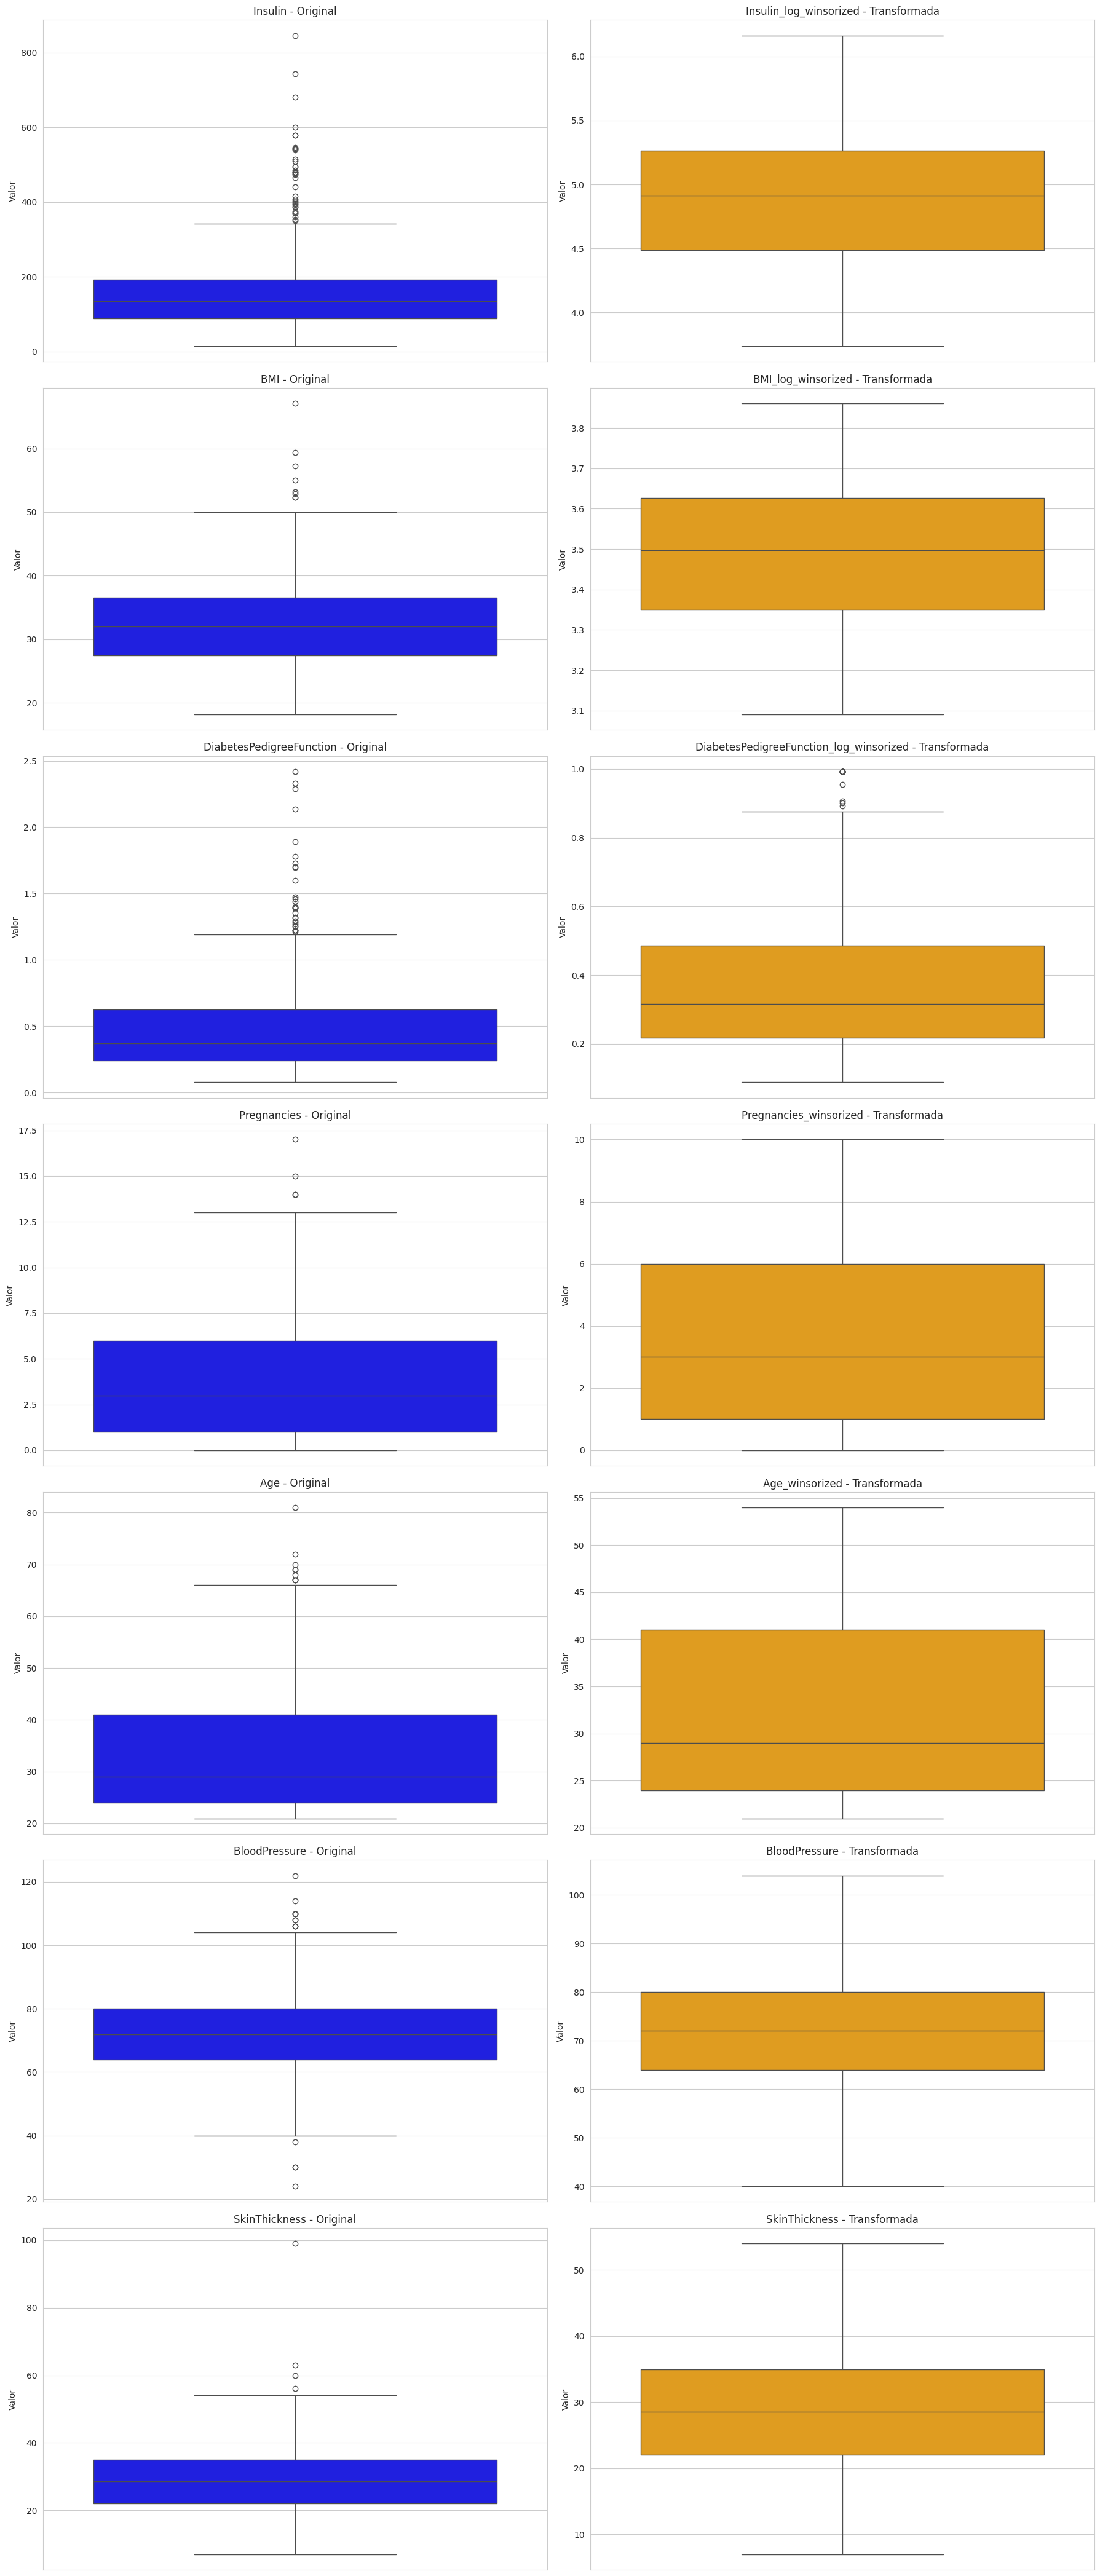

In [ ]:
# Crear una nueva copia del DataFrame para la nueva estrategia de outliers
df_adjusted2 = df_cleaned.copy()

# 1. Transformación Logarítmica + Winsorización para Insulin, BMI y DiabetesPedigreeFunction
log_vars = ['Insulin', 'BMI', 'DiabetesPedigreeFunction']
winsorization_limit = 0.025

for var in log_vars:
    # Transformación Logarítmica
    df_adjusted2[f'{var}_log'] = np.log1p(df_adjusted2[var])

    # Winsorización de la variable transformada
    df_adjusted2[f'{var}_log_winsorized'] = winsorize(df_adjusted2[f'{var}_log'], limits=[winsorization_limit, winsorization_limit])

# 2. Ajuste de Límites de Winsorización para Pregnancies y Age
winsorization_limit_pregnancies = 0.075  # Aumentar este límite para reducir la acumulación
winsorization_limit_age = 0.075  # Aumentar este límite para reducir la acumulación

df_adjusted2['Pregnancies_winsorized'] = winsorize(df_adjusted2['Pregnancies'], limits=[winsorization_limit_pregnancies, winsorization_limit_pregnancies])
df_adjusted2['Age_winsorized'] = winsorize(df_adjusted2['Age'], limits=[winsorization_limit_age, winsorization_limit_age])

# 3. Reducir winsorization_limit para DiabetesPedigreeFunction

winsorization_limit_diabetes = 0.01
log_vars = ['DiabetesPedigreeFunction']

for var in log_vars:
    # Transformación Logarítmica
    df_adjusted2[f'{var}_log'] = np.log1p(df_adjusted2[var])

    # Winsorización de la variable transformada
    df_adjusted2[f'{var}_log_winsorized'] = winsorize(df_adjusted2[f'{var}_log'], limits=[winsorization_limit_diabetes, winsorization_limit_diabetes])

# 4. Imputación con la mediana para SkinThickness y BloodPressure (sin cambios)
median_vars = ['SkinThickness', 'BloodPressure']
for var in median_vars:
    median_value = df_adjusted2[var].median()
    iqr = df_adjusted2[var].quantile(0.75) - df_adjusted2[var].quantile(0.25)
    lower_bound = df_adjusted2[var].quantile(0.25) - 1.5 * iqr
    upper_bound = df_adjusted2[var].quantile(0.75) + 1.5 * iqr

    # Reemplazar outliers por la mediana
    df_adjusted2[var] = np.where(
        (df_adjusted2[var] < lower_bound) | (df_adjusted2[var] > upper_bound),
        median_value,
        df_adjusted2[var]
    )

# Lista de variables a visualizar
variables_a_visualizar = {
    'Insulin': ('Insulin', 'Insulin_log_winsorized'),
    'BMI': ('BMI', 'BMI_log_winsorized'),
    'DiabetesPedigreeFunction': ('DiabetesPedigreeFunction', 'DiabetesPedigreeFunction_log_winsorized'),
    'Pregnancies': ('Pregnancies', 'Pregnancies_winsorized'),
    'Age': ('Age', 'Age_winsorized'),
    'BloodPressure': ('BloodPressure', 'BloodPressure'),
    'SkinThickness':('SkinThickness', 'SkinThickness') # Ya que imputamos, mostramos la variable directamente
}

# Calcular el número de filas necesarias para las variables
n_variables = len(variables_a_visualizar)

# Crear subplots
fig, axes = plt.subplots(n_variables, 2, figsize=(18, 6 * n_variables))

# Iterar sobre las variables y crear los gráficos
for i, (var, (var_original, var_transformada)) in enumerate(variables_a_visualizar.items()):
    # Boxplot de la variable original
    sns.boxplot(y=df_cleaned[var_original], color='blue', ax=axes[i, 0])
    axes[i, 0].set_title(f'{var_original} - Original')
    axes[i, 0].set_ylabel('Valor')

    # Boxplot de la variable transformada
    sns.boxplot(y=df_adjusted2[var_transformada], color='orange', ax=axes[i, 1])
    axes[i, 1].set_title(f'{var_transformada} - Transformada')
    axes[i, 1].set_ylabel('Valor')

plt.tight_layout()
plt.show()

- En general, las transformaciones aplicadas han sido efectivas para reducir la cantidad de outliers en las variables. La combinación de la transformación logarítmica y la winsorización ha sido útil para mitigar los valores extremos en variables como Insulin, BMI y DiabetesPedigreeFunction.

- Las transformaciones han preservado en gran medida la forma general de las distribuciones, lo que es importante para no distorsionar demasiado la información original en los datos.

- El ajuste de los límites de winsorización ha sido efectivo para reducir la acumulación en los límites en variables como Pregnancies y Age.

Para poder escoger el dataframe co la trasnformación mas apropiada, vamos a representar la distribución de los datos con histogramas para ver si la transformación ha afectado la forma general de la distribución (por ejemplo, si ha introducido sesgos o acumulaciones, si hay pérdida de información relevante ó si la variabilidad de lso datos se a visto afectada).


Compararando las distribuciones originales y transformadas nos permitirá tomar una decisión más informada sobre que transformación es más adecuada para nuestros datos.

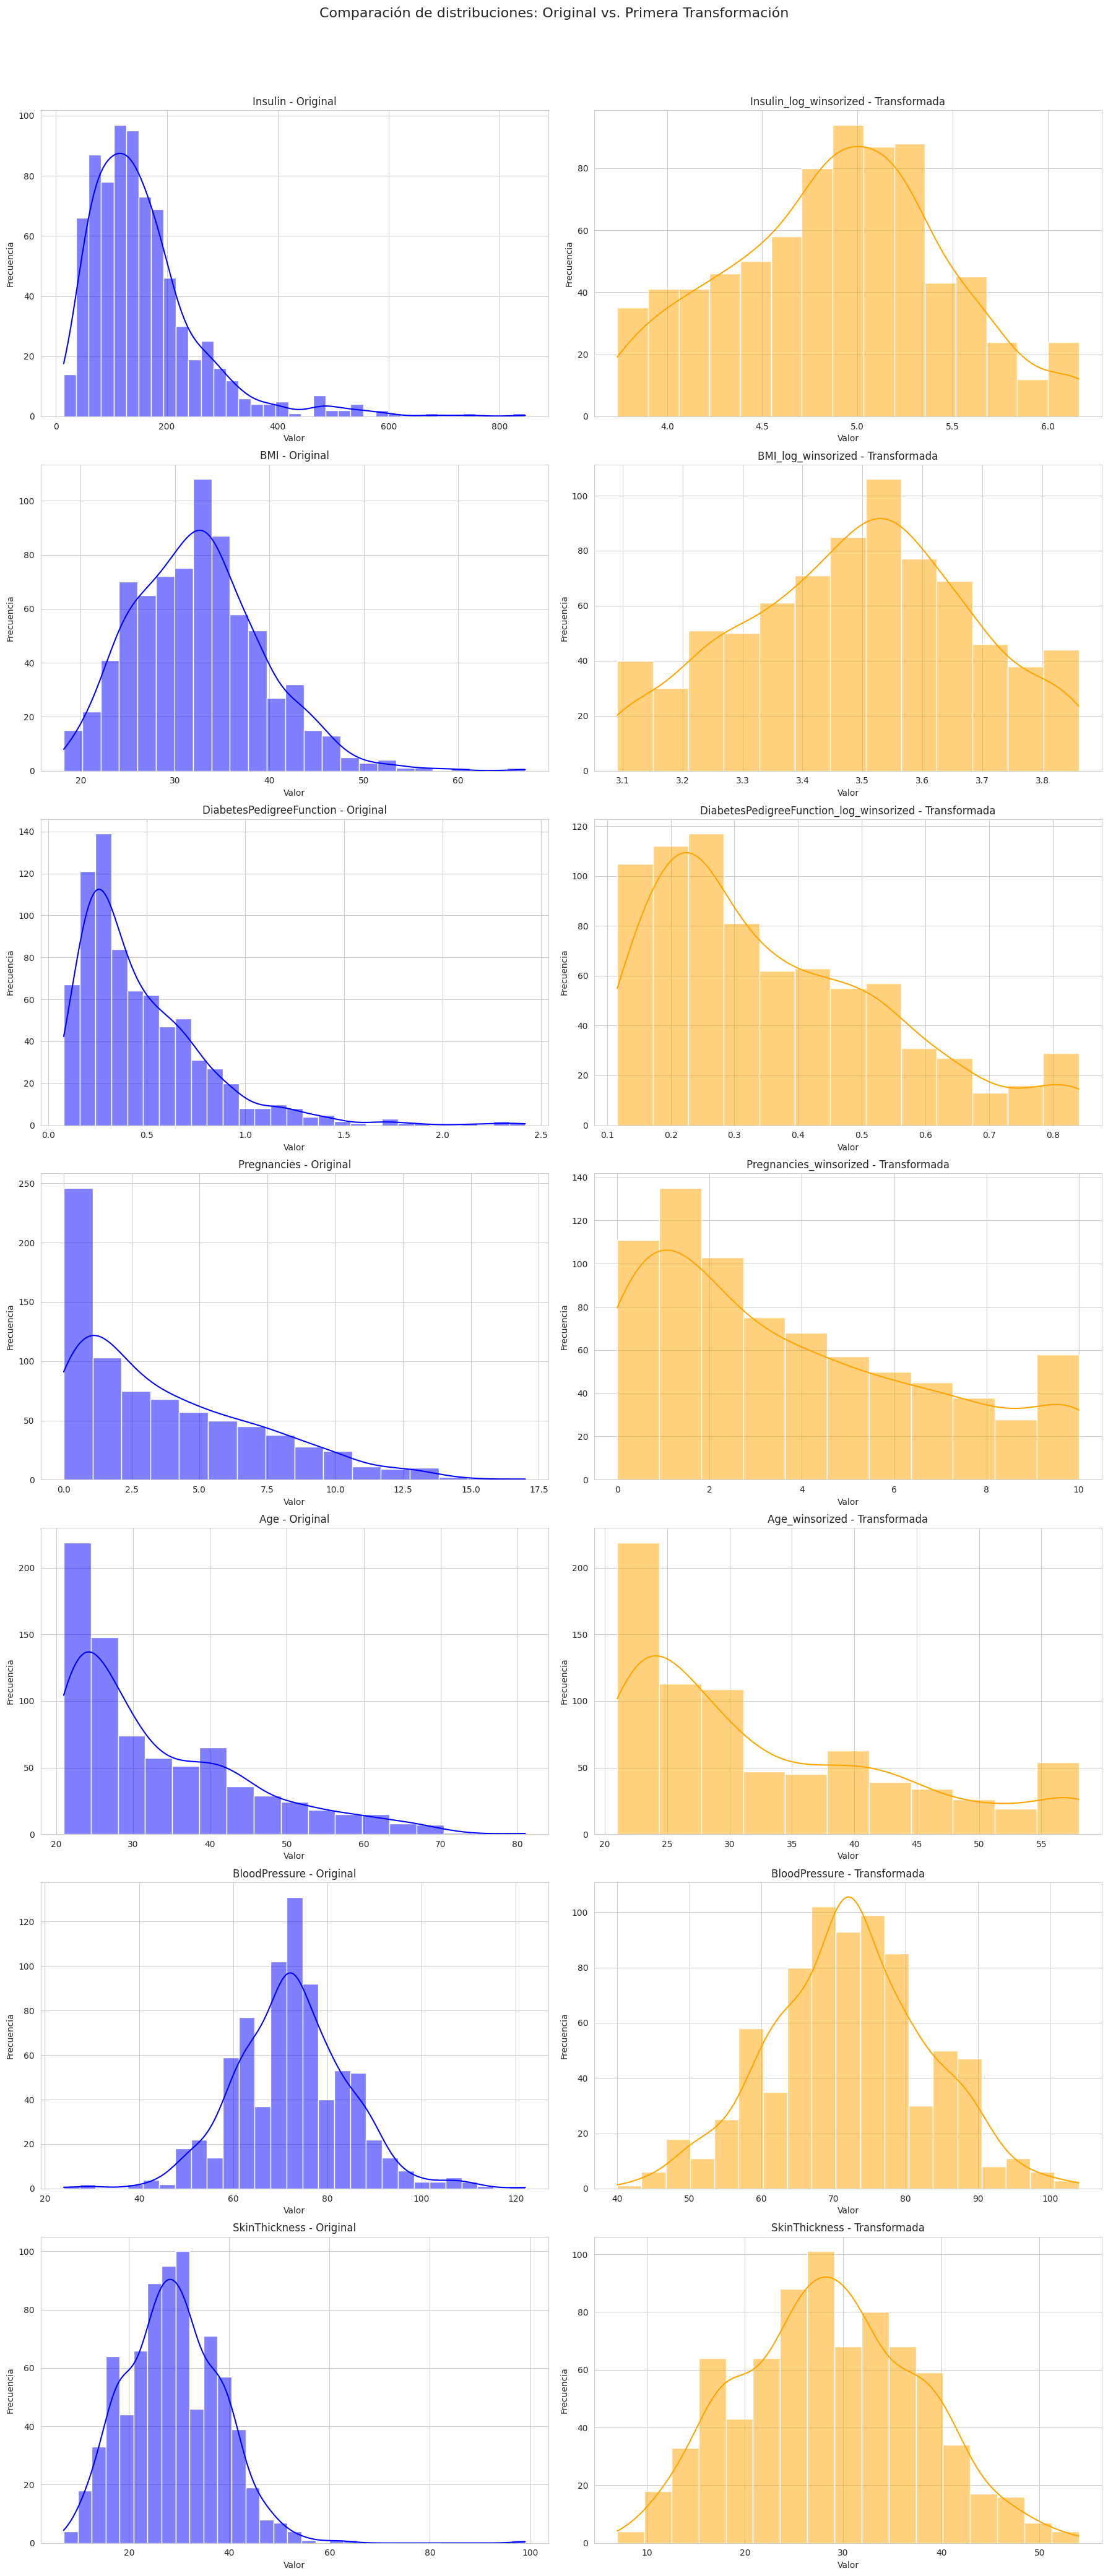

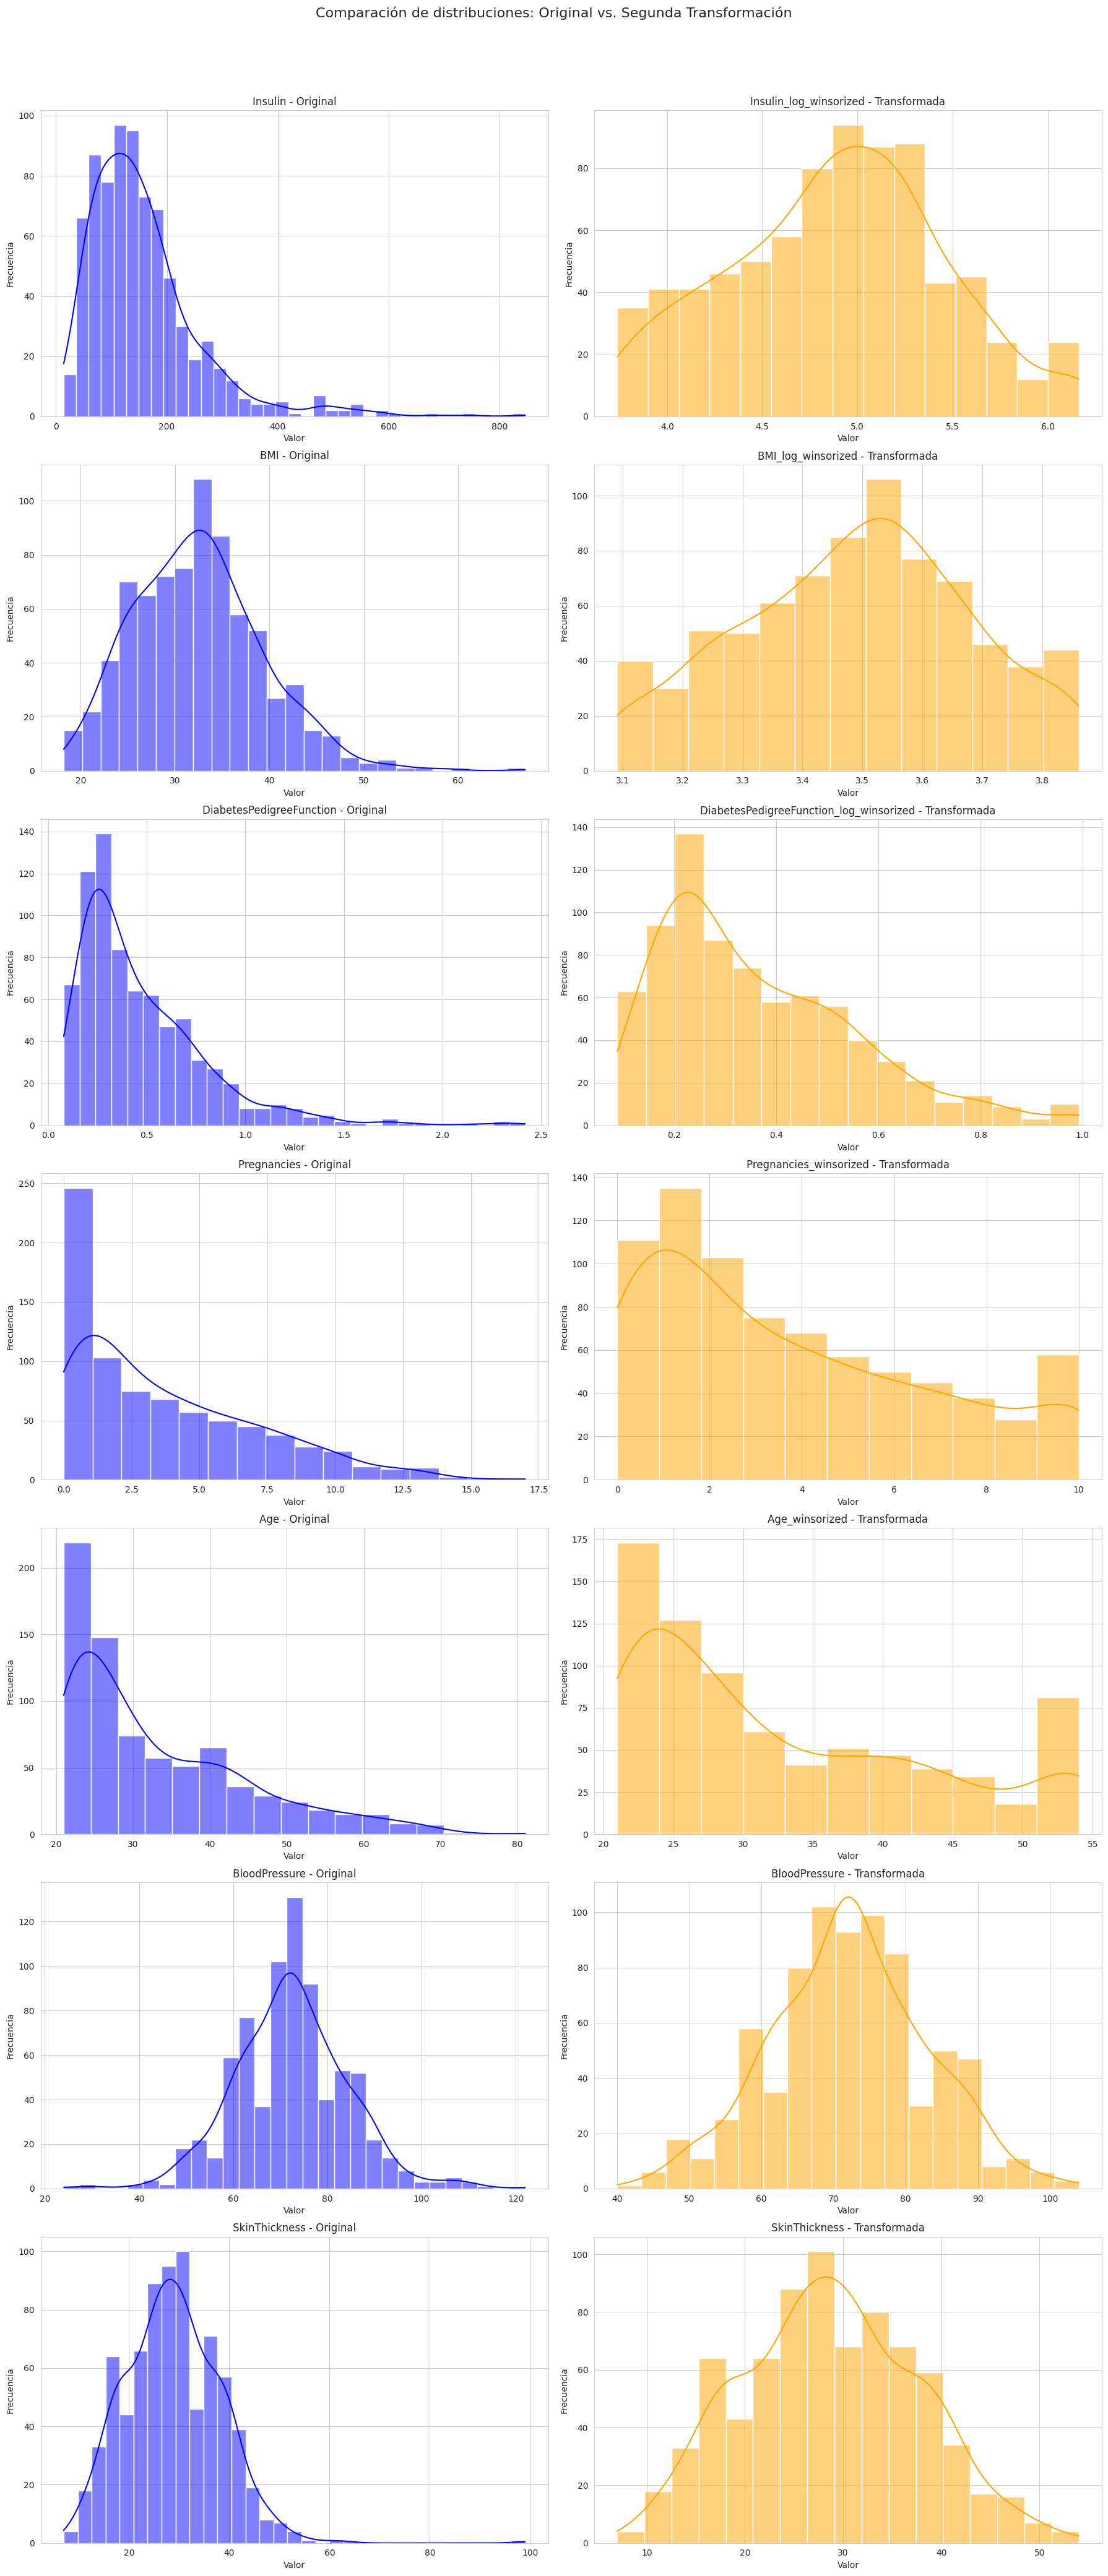

In [ ]:
# Lista de variables a visualizar
variables_a_visualizar = {
    'Insulin': ('Insulin', 'Insulin_log_winsorized'),
    'BMI': ('BMI', 'BMI_log_winsorized'),
    'DiabetesPedigreeFunction': ('DiabetesPedigreeFunction', 'DiabetesPedigreeFunction_log_winsorized'),
    'Pregnancies': ('Pregnancies', 'Pregnancies_winsorized'),
    'Age': ('Age', 'Age_winsorized'),
    'BloodPressure': ('BloodPressure', 'BloodPressure'),
    'SkinThickness':('SkinThickness', 'SkinThickness')
}

# Función para crear y mostrar histogramas
def plot_histograms(df_original, df_transformed, title):
    fig, axes = plt.subplots(len(variables_a_visualizar), 2, figsize=(18, 6 * len(variables_a_visualizar)))

    for i, (var, (var_original, var_transformada)) in enumerate(variables_a_visualizar.items()):
        # Histograma de la variable original
        sns.histplot(df_original[var_original], kde=True, color='blue', ax=axes[i, 0])
        axes[i, 0].set_title(f'{var_original} - Original')
        axes[i, 0].set_xlabel('Valor')
        axes[i, 0].set_ylabel('Frecuencia')

        # Histograma de la variable transformada
        sns.histplot(df_transformed[var_transformada], kde=True, color='orange', ax=axes[i, 1])
        axes[i, 1].set_title(f'{var_transformada} - Transformada')
        axes[i, 1].set_xlabel('Valor')
        axes[i, 1].set_ylabel('Frecuencia')

    plt.suptitle(title, fontsize=16, y=0.99)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Ajustar el espacio superior para que el título no se superponga
    plt.show()

# Crear y mostrar la comparación con la primera transformación
plot_histograms(df_cleaned, df_adjusted, "Comparación de distribuciones: Original vs. Primera Transformación")

# Crear y mostrar la comparación con la segunda transformación
plot_histograms(df_cleaned, df_adjusted2, "Comparación de distribuciones: Original vs. Segunda Transformación")


Después de revisar los outputs de los gráficos vamos a mantener la primera transformación para las variables Insulin, BMI y DiabetesPedigreeFunction, y mantenemos la segunda transformación para Pregnancies y Age.

- Insulin y BMI:
La primera transformación proporciona una distribución más suave después de la transformación logarítmica y la winsorización. Se observa una mejor dispersión de los valores en comparación con la distribución original.

- DiabetesPedigreeFunction:
La primera transformación logra mitigar la influencia de valores extremos y proporciona una distribución más razonable. En cambio, en la segunda transformación, se comprime mucho más esta variable.

- Pregnancies y Age:
La segunda transformación parece mejor, ya que al suavizar la acumulación de valores en los límites, se mantiene mejor la forma general de las distribuciones.

- SkinThickness y BloodPressure:
Mantenemos la imputación con la mediana, ya que el objetivo es simplemente reducir la influencia de valores atípicos sin alterar significativamente la distribución general.

In [ ]:
# Crear una nueva copia del DataFrame para la nueva estrategia de outliers
df_final_adjusted = df_cleaned.copy()

# Aplicar la primera transformación a Insulin, BMI y DiabetesPedigreeFunction
log_vars = ['Insulin', 'BMI', 'DiabetesPedigreeFunction']
winsorization_limit = 0.025

for var in log_vars:
    df_final_adjusted[f'{var}_log'] = np.log1p(df_final_adjusted[var])
    df_final_adjusted[f'{var}_log_winsorized'] = winsorize(df_final_adjusted[f'{var}_log'], limits=[winsorization_limit, winsorization_limit])

# Aplicar la segunda transformación a Pregnancies y Age
winsorization_limit_pregnancies = 0.075
winsorization_limit_age = 0.075

df_final_adjusted['Pregnancies_winsorized'] = winsorize(df_final_adjusted['Pregnancies'], limits=[winsorization_limit_pregnancies, winsorization_limit_pregnancies])
df_final_adjusted['Age_winsorized'] = winsorize(df_final_adjusted['Age'], limits=[winsorization_limit_age, winsorization_limit_age])

# Reducir winsorization_limit para DiabetesPedigreeFunction

winsorization_limit_diabetes = 0.01
log_vars = ['DiabetesPedigreeFunction']

for var in log_vars:
    # Transformación Logarítmica
    df_final_adjusted[f'{var}_log'] = np.log1p(df_final_adjusted[var])

    # Winsorización de la variable transformada
    df_final_adjusted[f'{var}_log_winsorized'] = winsorize(df_final_adjusted[f'{var}_log'], limits=[winsorization_limit_diabetes, winsorization_limit_diabetes])

# Aplicar imputación con la mediana a SkinThickness y BloodPressure
median_vars = ['SkinThickness', 'BloodPressure']
for var in median_vars:
    median_value = df_final_adjusted[var].median()
    iqr = df_final_adjusted[var].quantile(0.75) - df_final_adjusted[var].quantile(0.25)
    lower_bound = df_final_adjusted[var].quantile(0.25) - 1.5 * iqr
    upper_bound = df_final_adjusted[var].quantile(0.75) + 1.5 * iqr

    # Reemplazar outliers por la mediana
    df_final_adjusted[var] = np.where(
        (df_final_adjusted[var] < lower_bound) | (df_final_adjusted[var] > upper_bound),
        median_value,
        df_final_adjusted[var]
    )


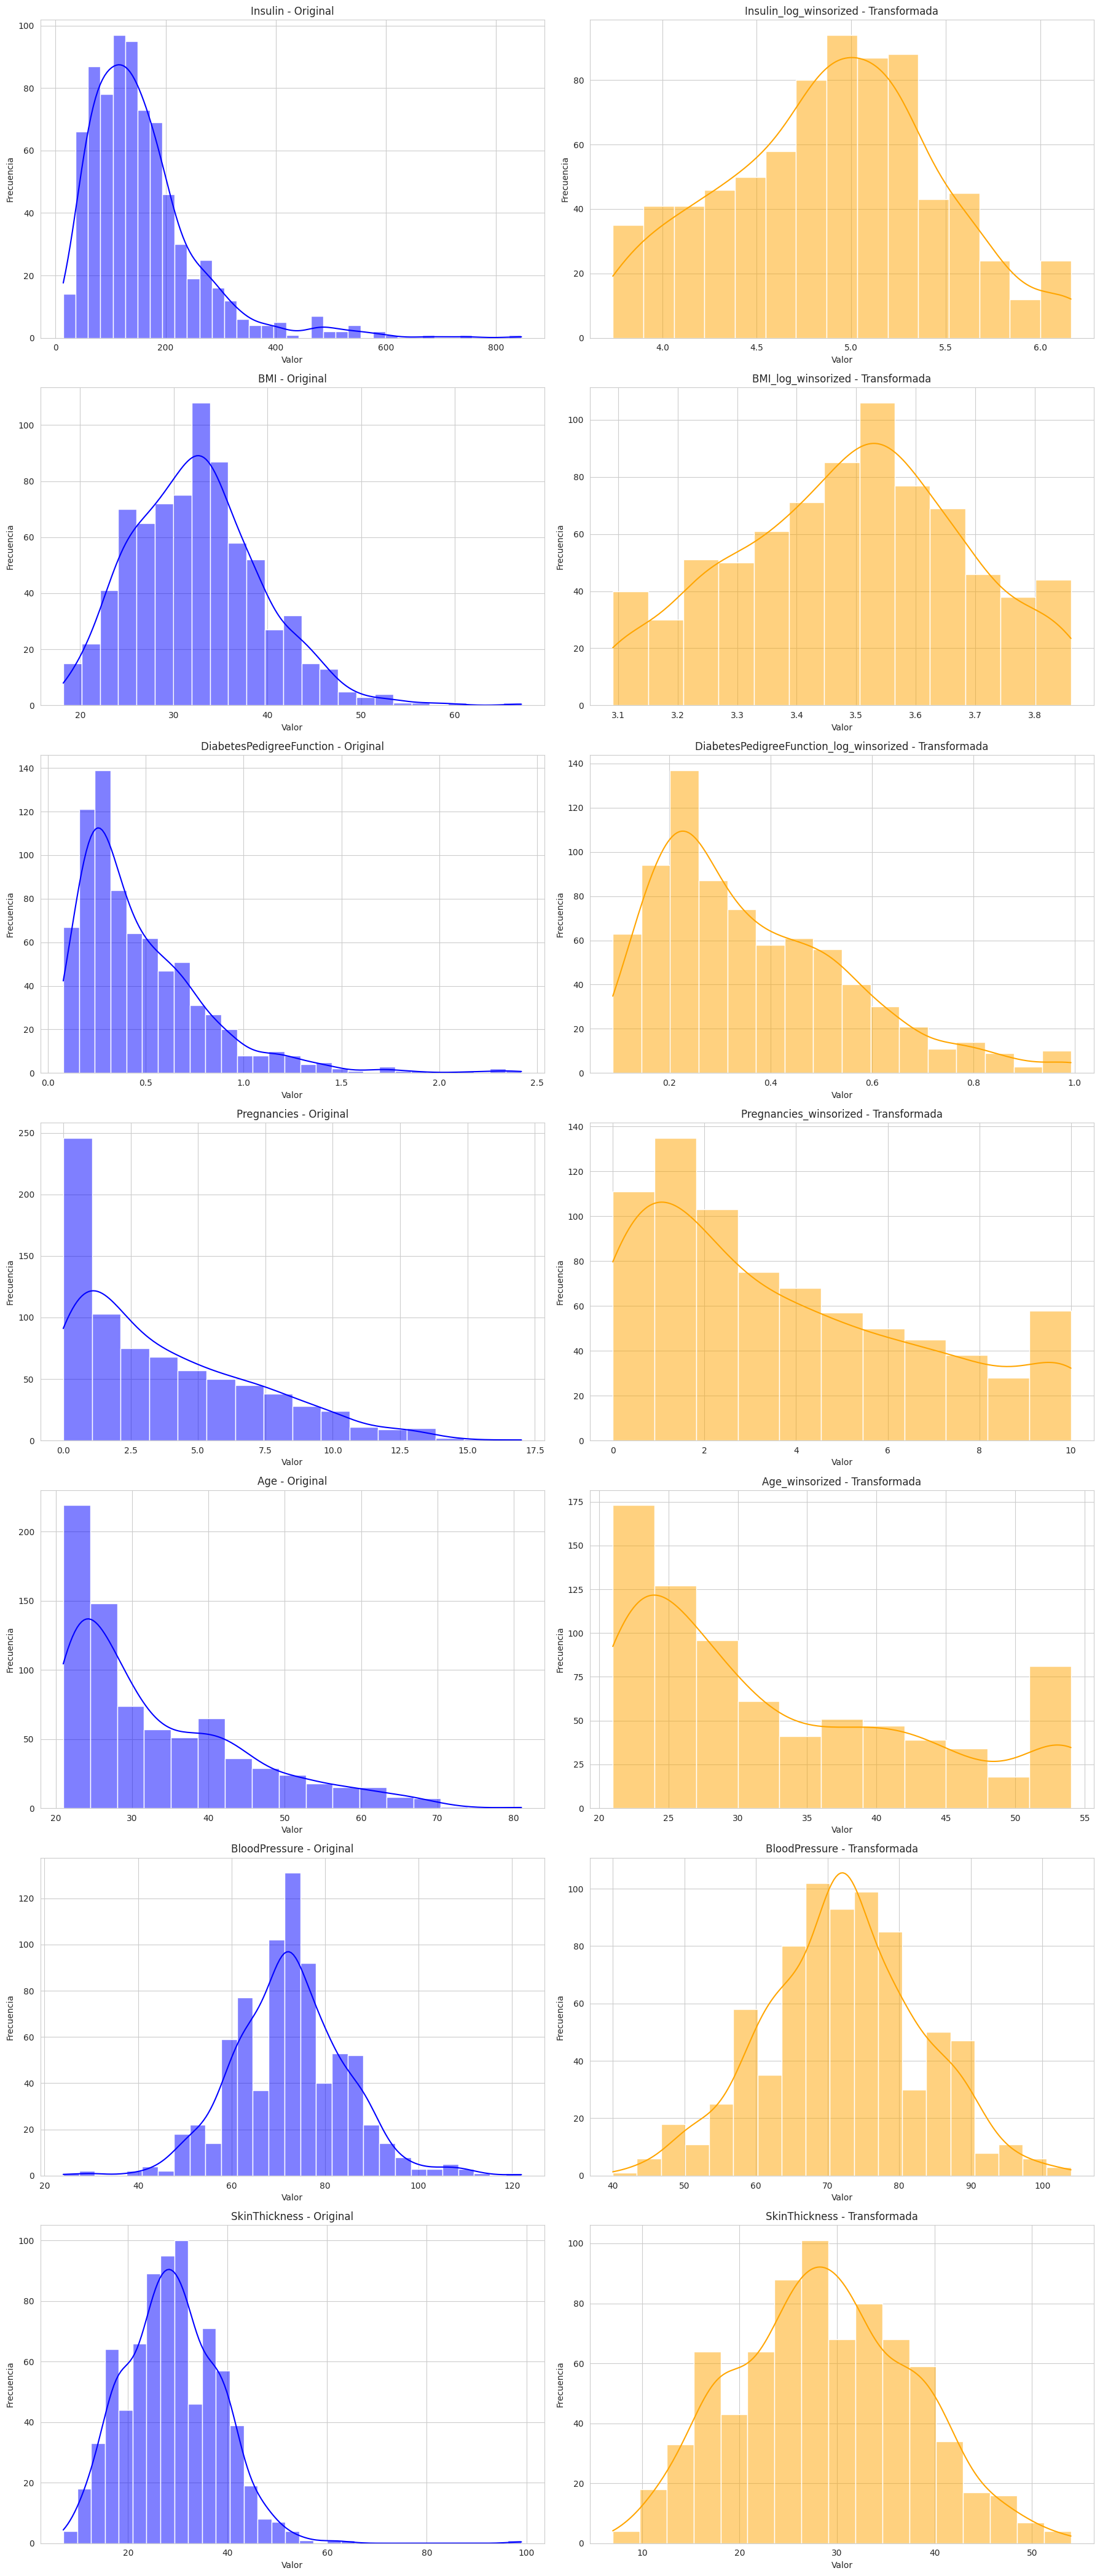

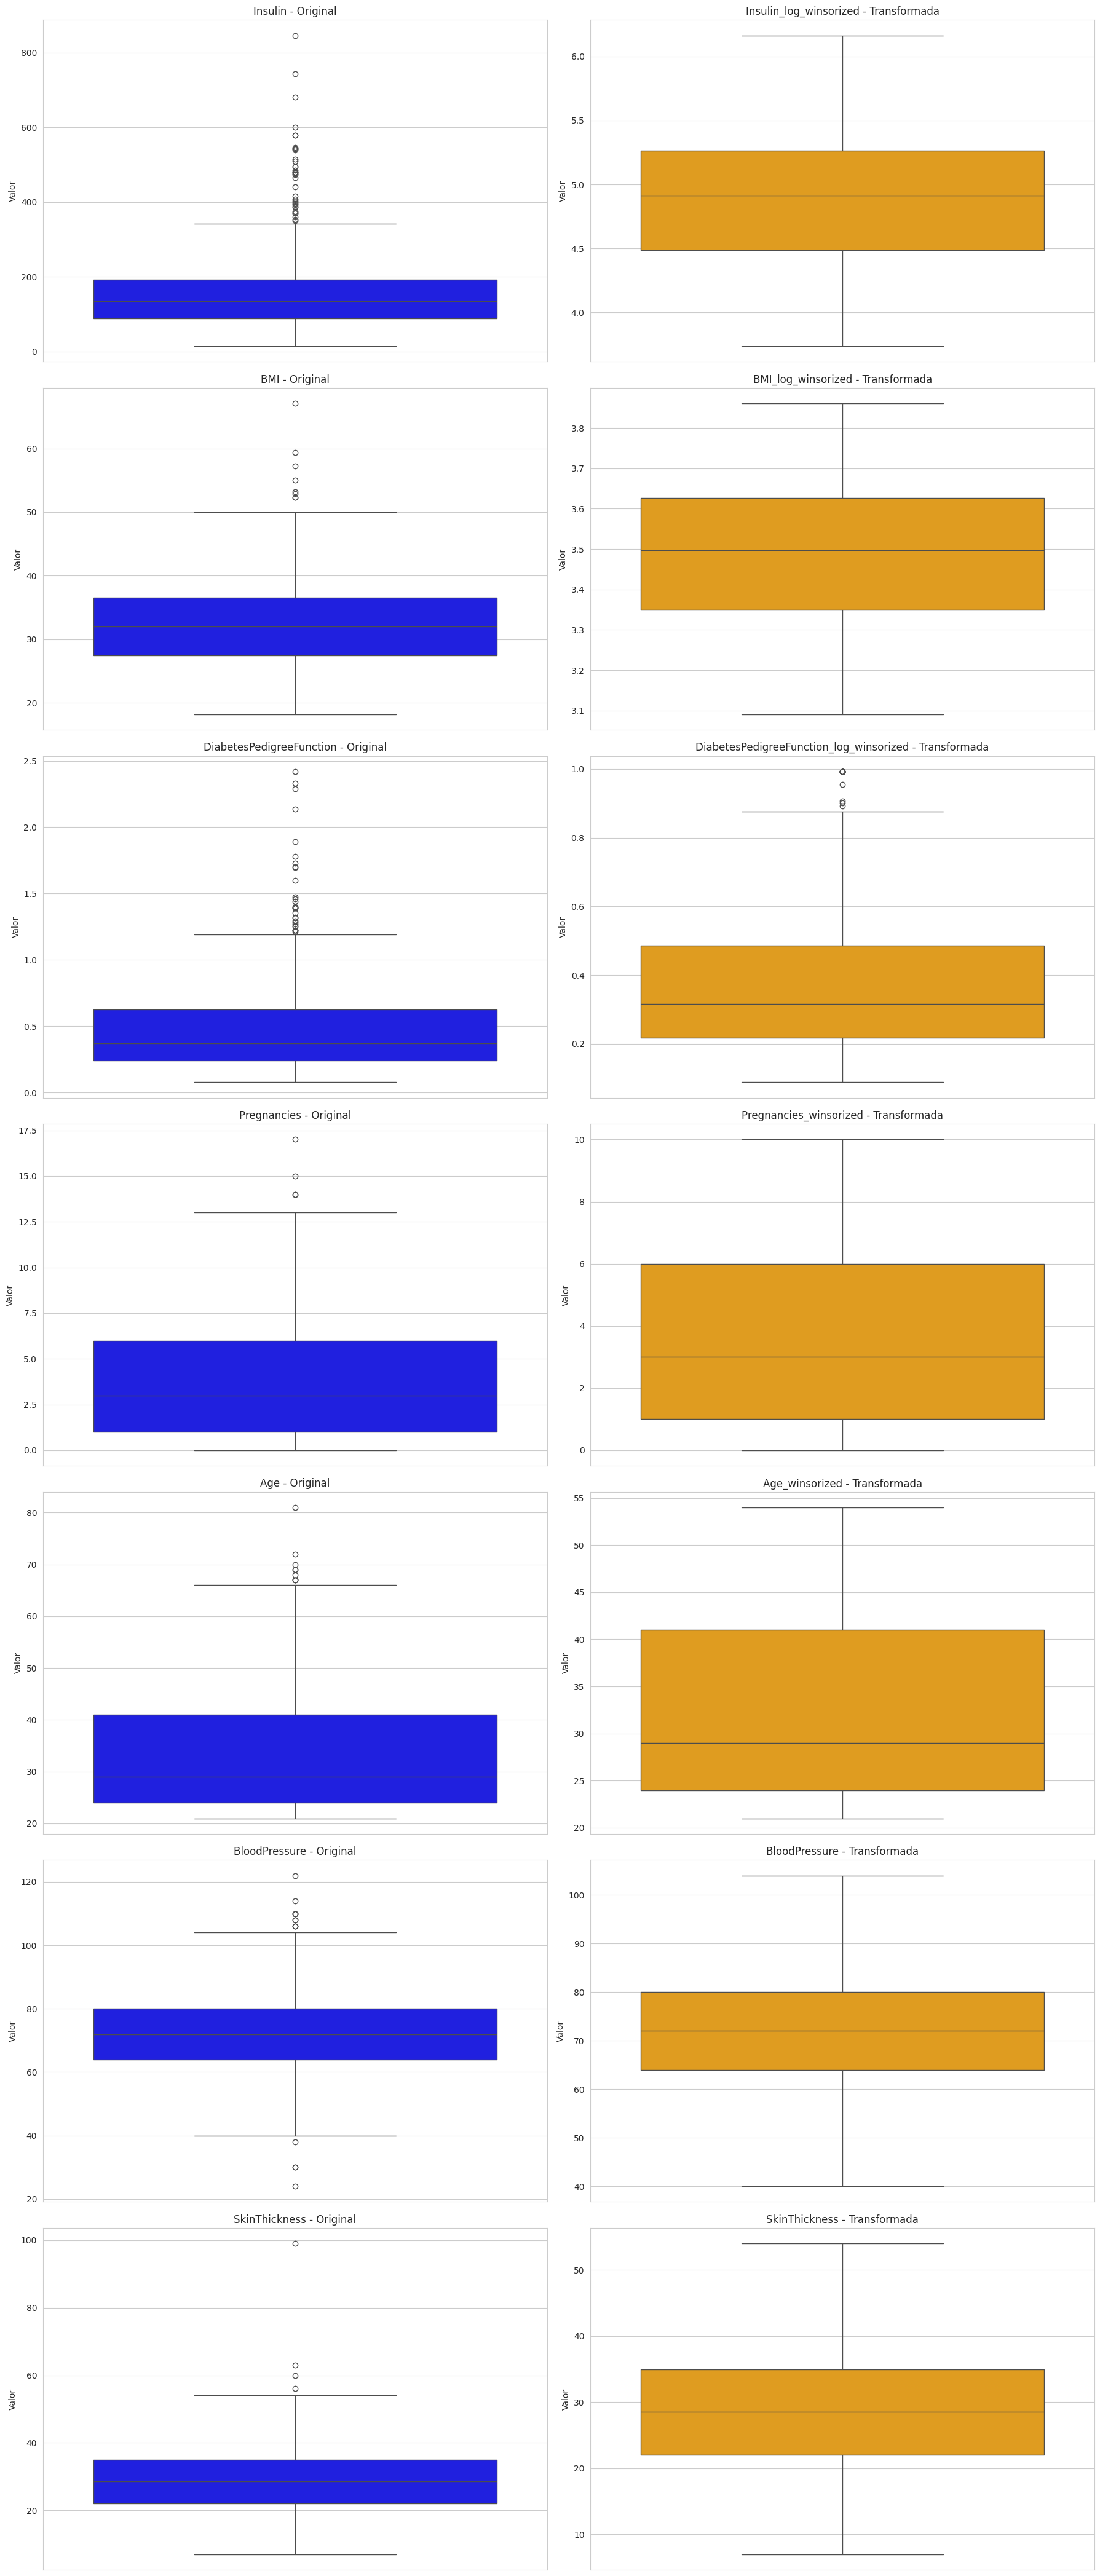

In [ ]:
# Visulizamos transformaciones
# Lista de variables a visualizar
variables_a_visualizar = {
    'Insulin': ('Insulin', 'Insulin_log_winsorized'),
    'BMI': ('BMI', 'BMI_log_winsorized'),
    'DiabetesPedigreeFunction': ('DiabetesPedigreeFunction', 'DiabetesPedigreeFunction_log_winsorized'),
    'Pregnancies': ('Pregnancies', 'Pregnancies_winsorized'),
    'Age': ('Age', 'Age_winsorized'),
    'BloodPressure': ('BloodPressure', 'BloodPressure'),
    'SkinThickness': ('SkinThickness', 'SkinThickness')
}

# Crear subplots
fig, axes = plt.subplots(len(variables_a_visualizar), 2, figsize=(18, 6 * len(variables_a_visualizar)))

# Iterar sobre las variables y crear los gráficos
for i, (var, (var_original, var_transformada)) in enumerate(variables_a_visualizar.items()):
    # Histograma de la variable original
    sns.histplot(df_cleaned[var_original], kde=True, color='blue', ax=axes[i, 0])
    axes[i, 0].set_title(f'{var_original} - Original')
    axes[i, 0].set_xlabel('Valor')
    axes[i, 0].set_ylabel('Frecuencia')

    # Histograma de la variable transformada
    sns.histplot(df_final_adjusted[var_transformada], kde=True, color='orange', ax=axes[i, 1])
    axes[i, 1].set_title(f'{var_transformada} - Transformada')
    axes[i, 1].set_xlabel('Valor')
    axes[i, 1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(len(variables_a_visualizar), 2, figsize=(18, 6 * len(variables_a_visualizar)))

# Iterar sobre las variables y crear los gráficos
for i, (var, (var_original, var_transformada)) in enumerate(variables_a_visualizar.items()):
    # Boxplot de la variable original
    sns.boxplot(y=df_cleaned[var_original], color='blue', ax=axes[i, 0])
    axes[i, 0].set_title(f'{var_original} - Original')
    axes[i, 0].set_ylabel('Valor')

    # Boxplot de la variable transformada
    sns.boxplot(y=df_final_adjusted[var_transformada], color='orange', ax=axes[i, 1])
    axes[i, 1].set_title(f'{var_transformada} - Transformada')
    axes[i, 1].set_ylabel('Valor')

plt.tight_layout()
plt.show()


In [ ]:
print(df_final_adjusted.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 17 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Pregnancies                              768 non-null    int64  
 1   Glucose                                  768 non-null    int64  
 2   BloodPressure                            768 non-null    float64
 3   SkinThickness                            768 non-null    float64
 4   Insulin                                  768 non-null    float64
 5   BMI                                      768 non-null    float64
 6   DiabetesPedigreeFunction                 768 non-null    float64
 7   Age                                      768 non-null    int64  
 8   Outcome                                  768 non-null    int64  
 9   Insulin_log                              768 non-null    float64
 10  Insulin_log_winsorized                   768 non-n

In [ ]:
# Crear una copia de df_final_adjusted
df_imputed = df_final_adjusted.copy()

# Eliminar las columnas originales de las variables transformadas
df_imputed.drop(['Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Pregnancies', 'Age'], axis=1, inplace=True)

# Eliminar las columnas log sin winsorización
df_imputed.drop(['Insulin_log', 'BMI_log', 'DiabetesPedigreeFunction_log'], axis=1, inplace=True)

print(df_imputed.columns)


Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Outcome',
       'Insulin_log_winsorized', 'BMI_log_winsorized',
       'DiabetesPedigreeFunction_log_winsorized', 'Pregnancies_winsorized',
       'Age_winsorized'],
      dtype='object')


Al aplicar una combinación de transformaciones logarítmicas, winsorización e imputación, hemos logrado controlar los valores extremos mientras se conservaba la forma general de las distribuciones. Nuestros datos están ahora más limpios y preparados para los siguientes pasos del proceso de modelado.

---

# 5. PREPARACIÓN Y DIVISIÓN DE LOS DATOS

- Crearemos nuevas características en todo el conjunto de datos basándonos en el conocimiento del dominio y las relaciones potenciales entre variables.
- Prepararemos los datos en X (variables predictoras) e y (variable objetivo).
- Dividiremos los datos en X_train, X_test, y_train, y_test utilizando train_test_split.
- Haremos la selección de características
- Escalado: Aplicaremos StandardScaler a las variables numéricas de X_train y X_test. Es crucial escalar después de la división para evitar data leakage. Usaremos únicamente X_train para calcular los parámetros del escalador (media y desviación estándar para StandardScaler). Utilizaremos el mismo escalador ajustado con X_train para transformar X_validation y X_test. Esto asegura que todos los conjuntos de datos se escalen de manera consistente, usando las estadísticas del conjunto de entrenamiento.
- Manejo del desbalance: Aplicaremos SMOTE (Synthetic Minority Over-sampling Technique) solo a X_train e y_train. Esto generará muestras sintéticas de la clase minoritaria para equilibrar el dataset. No aplicaremos SMOTE a los datos de prueba para mantener su distribución original.
Este enfoque asegura que nuestro modelo se entrene con datos balanceados y escalados correctamente, mientras mantenemos un conjunto de prueba representativo de la distribución real del problema.

CREACIÓN DE NUEVAS CARACTERÍSTICAS

- Relación Glucosa/Insulina: Puede capturar la relación entre los niveles de glucosa e insulina, lo cual es relevante para el diagnóstico de diabetes.
- Producto de Glucosa e IMC: Relaciona los niveles de glucosa con el índice de masa corporal (IMC), lo cual puede ser útil para identificar riesgos metabólicos.
- Indicador de presión arterial alta: Es una característica categórica basada en un umbral médico (por ejemplo, presión arterial > 80 mmHg).
- Razón entre BMI y SkinThickness: Puede capturar información sobre la composición corporal y almacenamiento de grasa.
- Interacción entre Edad y Embarazos : La edad y el número de embarazos podrían combinarse para reflejar mejor el riesgo en mujeres.
- Indicador categórico basado en rangos de edad: Agrupar edades en categorías puede ser útil para capturar patrones específicos por grupos etarios.

In [ ]:
# Crear nuevas características
# 1. Relación Glucosa/Insulina
df_imputed['Glucose_Insulin_Ratio'] = df_imputed['Glucose'] / df_imputed['Insulin_log_winsorized']

# 2. Producto de Glucosa e IMC
df_imputed['Glucose_BMI_Product'] = df_imputed['Glucose'] * df_imputed['BMI_log_winsorized']

# 3. Indicador de presión arterial alta
df_imputed['HighBloodPressure_Indicator'] = (df_imputed['BloodPressure'] > 80).astype(int)

# 4. Razón entre BMI y SkinThickness
df_imputed['BMI_SkinThickness_Ratio'] = df_imputed['BMI_log_winsorized'] / df_imputed['SkinThickness']

# 5. Interacción entre Edad y Embarazos
df_imputed['Age_Pregnancies_Interaction'] = df_imputed['Age_winsorized'] * df_imputed['Pregnancies_winsorized']

# 6. Indicador categórico basado en rangos de edad
# Crear la característica 'Indicador categórico basado en rangos de edad'
bins = [20, 30, 40, 50, 60, np.inf]
labels = ['20-30', '30-40', '40-50', '50-60', '60+']
df_imputed['Age_Group'] = pd.cut(df_imputed['Age_winsorized'], bins=bins, labels=labels)


# Mostrar el dataframe actualizado
print(df_imputed.head())

   Glucose  BloodPressure  SkinThickness  Outcome  Insulin_log_winsorized  \
0      148           72.0      35.000000        1                5.181109   
1       85           66.0      29.000000        0                3.954124   
2      183           64.0      18.182514        1                5.577047   
3       89           66.0      23.000000        0                4.553877   
4      137           40.0      35.000000        1                5.129899   

   BMI_log_winsorized  DiabetesPedigreeFunction_log_winsorized  \
0            3.543854                                 0.486738   
1            3.317816                                 0.300845   
2            3.190476                                 0.514021   
3            3.370738                                 0.154436   
4            3.786460                                 0.992881   

   Pregnancies_winsorized  Age_winsorized  Glucose_Insulin_Ratio  \
0                       6              50              28.565312   
1   

In [ ]:
# Aplicar one-hot encoding a la variable categórica 'Age_Group'
df_imputed_encoded = pd.get_dummies(df_imputed, columns=['Age_Group'], drop_first=True)

# Verificar las columnas resultantes y el DataFrame actualizado
print("Columnas después de one-hot encoding:", df_imputed_encoded.columns)
print("Primeras filas del DataFrame actualizado:")
print(df_imputed_encoded.head())

Columnas después de one-hot encoding: Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Outcome',
       'Insulin_log_winsorized', 'BMI_log_winsorized',
       'DiabetesPedigreeFunction_log_winsorized', 'Pregnancies_winsorized',
       'Age_winsorized', 'Glucose_Insulin_Ratio', 'Glucose_BMI_Product',
       'HighBloodPressure_Indicator', 'BMI_SkinThickness_Ratio',
       'Age_Pregnancies_Interaction', 'Age_Group_30-40', 'Age_Group_40-50',
       'Age_Group_50-60', 'Age_Group_60+'],
      dtype='object')
Primeras filas del DataFrame actualizado:
   Glucose  BloodPressure  SkinThickness  Outcome  Insulin_log_winsorized  \
0      148           72.0      35.000000        1                5.181109   
1       85           66.0      29.000000        0                3.954124   
2      183           64.0      18.182514        1                5.577047   
3       89           66.0      23.000000        0                4.553877   
4      137           40.0      35.000000        1            

In [ ]:
# Convertir solo las columnas booleanas a 0 y 1
boolean_columns = df_imputed_encoded.select_dtypes(include=['bool']).columns
df_imputed_encoded[boolean_columns] = df_imputed_encoded[boolean_columns].astype(int)

# Verificar los tipos de datos después de la conversión
print("Tipos de datos después de convertir columnas booleanas:")
print(df_imputed_encoded.dtypes)


Tipos de datos después de convertir columnas booleanas:
Glucose                                      int64
BloodPressure                              float64
SkinThickness                              float64
Outcome                                      int64
Insulin_log_winsorized                     float64
BMI_log_winsorized                         float64
DiabetesPedigreeFunction_log_winsorized    float64
Pregnancies_winsorized                       int64
Age_winsorized                               int64
Glucose_Insulin_Ratio                      float64
Glucose_BMI_Product                        float64
HighBloodPressure_Indicator                  int64
BMI_SkinThickness_Ratio                    float64
Age_Pregnancies_Interaction                  int64
Age_Group_30-40                              int64
Age_Group_40-50                              int64
Age_Group_50-60                              int64
Age_Group_60+                                int64
dtype: object


In [ ]:
# Verificar valores nulos en todo el dataframe
print(df_imputed_encoded.isnull().sum())

Glucose                                    0
BloodPressure                              0
SkinThickness                              0
Outcome                                    0
Insulin_log_winsorized                     0
BMI_log_winsorized                         0
DiabetesPedigreeFunction_log_winsorized    0
Pregnancies_winsorized                     0
Age_winsorized                             0
Glucose_Insulin_Ratio                      0
Glucose_BMI_Product                        0
HighBloodPressure_Indicator                0
BMI_SkinThickness_Ratio                    0
Age_Pregnancies_Interaction                0
Age_Group_30-40                            0
Age_Group_40-50                            0
Age_Group_50-60                            0
Age_Group_60+                              0
dtype: int64


## Selección de características

Dividimos primero los datos para evitar el data leakage. Si seleccionamos las características usando todo el conjunto de datos y luego lo dividimos, se estaría filtrando información del conjunto de prueba al de entrenamiento.

La selección de características debe realizarse solo en el conjunto de entrenamiento para asegurar que el conjunto de prueba permanezca completamente independiente y no influya en el proceso de modelado.

Utilizaremos varios métodos de selección de características. Estos métodos se pueden clasificar en tres categorías principales:

- Métodos de filtrado: Estos métodos seleccionan características basándose en medidas estadísticas, sin utilizar ningún modelo de aprendizaje.
  - Correlación de Pearson: Este método mide la correlación lineal entre cada característica y la variable objetivo. Las características con mayor correlación absoluta se consideran más importantes.
  - Información mutua: Utiliza la función mutual_info_classif para medir la dependencia entre cada característica y la variable objetivo. Se seleccionan las 10 características con mayor información mutua.
  - Chi-cuadrado: Este método es especialmente útil para características categóricas. Se utiliza SelectKBest con la función chi2 para seleccionar las 10 mejores características según esta prueba estadística.
- Métodos de envoltura: Estos métodos utilizan un modelo de aprendizaje automático para evaluar subconjuntos de características.
  - Eliminación de características recursivas (RFE): Este método utiliza un modelo (en este caso, RandomForestClassifier) para eliminar recursivamente las características menos importantes hasta que queden solo 10.
- Métodos incorporados: Estos métodos realizan la selección de características como parte del proceso de entrenamiento del modelo.
  - LASSO (Least Absolute Shrinkage and Selection Operator): Este método de regularización L1 puede reducir algunos coeficientes a cero, efectivamente seleccionando características. Las características con coeficientes no nulos son seleccionadas.
  - Importancia de características en Random Forest: Este método utiliza la importancia de características inherente al algoritmo Random Forest. Se seleccionan las 10 características más importantes según este criterio.


Cada uno de estos métodos proporciona una perspectiva diferente sobre la importancia de las características, lo que permite una selección más robusta y completa para el modelo final.

A continuación realizaremos un análisis de la frecuencia de las características seleccionadas por los diferentes métodos de selección de características. Escogeremos las características que han sido seleccionadas como más importantes por al menos 3 metodos de selección.

In [ ]:
# Preparar X e y
X = df_imputed_encoded.drop('Outcome', axis=1)
y = df_imputed_encoded['Outcome']

print("X shape:", X.shape)
print("Preview of X:", X.head())

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Métodos de filtrado:
# 1. Correlación de Pearson
corr_features = X_train.corrwith(y_train).abs().sort_values(ascending=False)

# 2. Información Mutua
mi_selector = SelectKBest(mutual_info_classif, k=10)
mi_selector.fit(X_train, y_train)
mi_features = X_train.columns[mi_selector.get_support()]

# 3. Chi-cuadrado (requiere valores no negativos)
chi2_selector = SelectKBest(chi2, k=10)
X_train_non_negative = X_train.clip(lower=0)  # Asegurarse de que no haya valores negativos
chi2_selector.fit(X_train_non_negative, y_train)
chi2_features = X_train.columns[chi2_selector.get_support()]

# Métodos de envoltura:
# 4. Eliminación de características recursivas (RFE) con Random Forest
rfe_selector = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)
rfe_selector.fit(X_train, y_train)
rfe_features = X_train.columns[rfe_selector.support_]

# Métodos incorporados:
# 5. LASSO (Regularización L1)
lasso = Lasso(alpha=0.1, random_state=42)  # Ajustar alpha según sea necesario
lasso.fit(X_train, y_train)
lasso_features = X_train.columns[lasso.coef_ != 0]

# 6. Importancia de características en Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_features = X_train.columns[rf.feature_importances_.argsort()[::-1][:10]]

# Imprimir las características seleccionadas por cada método
print("Pearson Correlation:", list(corr_features.index[:10]))
print("Mutual Information:", list(mi_features))
print("Chi-square:", list(chi2_features))
print("RFE:", list(rfe_features))
print("LASSO:", list(lasso_features))
print("Random Forest:", list(rf_features))

# Analizar la frecuencia de las características seleccionadas por los diferentes métodos
all_features = (
    list(corr_features.index[:10]) +
    list(mi_features) +
    list(chi2_features) +
    list(rfe_features) +
    list(lasso_features) +
    list(rf_features)
)

feature_counts = Counter(all_features)

print("\nFrecuencia de características seleccionadas:")
for feature, count in feature_counts.most_common():
    print(f"{feature}: {count}")


X shape: (768, 17)
Preview of X:    Glucose  BloodPressure  SkinThickness  Insulin_log_winsorized  \
0      148           72.0      35.000000                5.181109   
1       85           66.0      29.000000                3.954124   
2      183           64.0      18.182514                5.577047   
3       89           66.0      23.000000                4.553877   
4      137           40.0      35.000000                5.129899   

   BMI_log_winsorized  DiabetesPedigreeFunction_log_winsorized  \
0            3.543854                                 0.486738   
1            3.317816                                 0.300845   
2            3.190476                                 0.514021   
3            3.370738                                 0.154436   
4            3.786460                                 0.992881   

   Pregnancies_winsorized  Age_winsorized  Glucose_Insulin_Ratio  \
0                       6              50              28.565312   
1                       1

In [ ]:
# Definir umbral para seleccionar las características finales (seleccionadas por al menos 3 métodos)
selected_features = [feature for feature, count in feature_counts.items() if count >= 3]

X_selected = df_imputed_encoded[selected_features]
y_selected = df_imputed_encoded['Outcome']

# Verificar el nuevo conjunto de datos
print("Características seleccionadas:", selected_features)
print("Shape del nuevo conjunto:", X_selected.shape)
print("Primeras filas del nuevo conjunto:")
print(X_selected.head())


Características seleccionadas: ['Glucose_BMI_Product', 'Glucose', 'Insulin_log_winsorized', 'Glucose_Insulin_Ratio', 'BMI_log_winsorized', 'Age_winsorized', 'SkinThickness', 'Age_Pregnancies_Interaction', 'BMI_SkinThickness_Ratio']
Shape del nuevo conjunto: (768, 9)
Primeras filas del nuevo conjunto:
   Glucose_BMI_Product  Glucose  Insulin_log_winsorized  \
0           524.490345      148                5.181109   
1           282.014341       85                3.954124   
2           583.857172      183                5.577047   
3           299.995698       89                4.553877   
4           518.744990      137                5.129899   

   Glucose_Insulin_Ratio  BMI_log_winsorized  Age_winsorized  SkinThickness  \
0              28.565312            3.543854              50      35.000000   
1              21.496543            3.317816              31      29.000000   
2              32.813064            3.190476              32      18.182514   
3              19.543787   

El nuevo DataFrame tiene 768 filas y 10 columnas, lo cual es razonable considerando que hemos reducido el número de características a las más importantes.

Esto simplifica el análisis y mejora la eficiencia del modelo al trabajar con un conjunto optimizado.

---

# 6. ENTRENAMIENTO DE LOS MODELOS
La estrategia que seguiré en este paso de entrenamiento es la siguiente:

Entrenaremos varios modelos de aprendizaje automático utilizando la división de los datos en entrenamiento y prueba.
Evaluaremos los resultados obtenidos y escogeremos el modelo que mejores resultados presente.
Una vez escogido el modelo ganador, repetiremos el entrenamiento en este modelo aplicando validación cruzada (cross-validation). De esta manera, los resultados serán más robustos y más representativos del rendimiento real del modelo en datos no vistos.


Vamos a entrenar los siguientes modelos:
- Regresión Logística: Aunque no es inherentemente robusto frente a outliers, su simplicidad permite identificar rápidamente patrones generales en los datos. Además, puede servir como punto de comparación para evaluar la efectividad de los modelos más complejos.
- Random Forest: Robusto ante outliers y capaz de capturar relaciones no lineales.
Gradient Boosting: Potente en la captura de patrones complejos y generalmente ofrece alto rendimiento.
- Support Vector Machines (SVM) con kernel no lineal: Eficaz en la separación de clases en espacios de alta dimensión.
- XGBoost: Conocido por su alto rendimiento en una variedad de problemas de clasificación.
- Red Neuronal: Capaz de aprender representaciones complejas de los datos.
Esta variedad de modelos nos permitirá explorar diferentes enfoques y determinar cuál se adapta mejor a la estructura y características de nuestros datos de Framingham.

Además vamos a probar diferentes estrategias.
- Entrenaminto sin reducción de la dimensionalidad
- PCA para reducir la dimensión de los datos
- Selección de características con Random Forest
- Otras tecnicas de balanceo de clases como : SMOTETomek, Adasy y Borderline-SMOTE



### PRIMER ENTRENAMIENTO SIN PCA, NI SELECCION DE CARACTERISTICAS

División de datos: Usando train_test_split, con un 70% para entrenamiento y 30% para prueba.
Escalado de datos: Utilizamos StandardScaler para estandarizar las características, ajustando el escalador con X_train y transformando tanto X_train como X_test.
Balanceo de clases con SMOTE: Aplicamos SMOTE al conjunto de entrenamiento escalado (X_train_scaled) para generar nuevas muestras sintéticas de la clase minoritaria, obteniendo X_train_smote y y_train_smote.


Definición de modelos:
- Regresión Logística
- Bosque Aleatorio
- Gradient Boosting
- Máquinas de Vectores de Soporte (SVM)
- XGBoost
- Red Neuronal Multicapa


Entrenamiento y evaluación de modelos: Se entrena cada modelo con los datos balanceados (X_train_smote, y_train_smote). Se realizan predicciones en el conjunto de prueba escalado (X_test_scaled).

Se calculan las métricas de evaluación: Reporte de clasificación (classification_report) Matriz de confusión (confusion_matrix) Curva ROC y AUC (roc_curve, auc)

Visualización de resultados Generamos gráficos de matrices de confusión para cada modelo usando seaborn. Graficamos las curvas ROC para todos los modelos en una sola figura. Por último comparamos las métricas de precisión, recall y f1-score para la clase positiva (1) entre los modelos, y se representan en un gráfico de barras.


Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       150
           1       0.59      0.69      0.64        81

    accuracy                           0.72       231
   macro avg       0.70      0.72      0.71       231
weighted avg       0.74      0.72      0.73       231


Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       150
           1       0.64      0.72      0.68        81

    accuracy                           0.76       231
   macro avg       0.74      0.75      0.74       231
weighted avg       0.77      0.76      0.76       231


Training Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       150
           1 

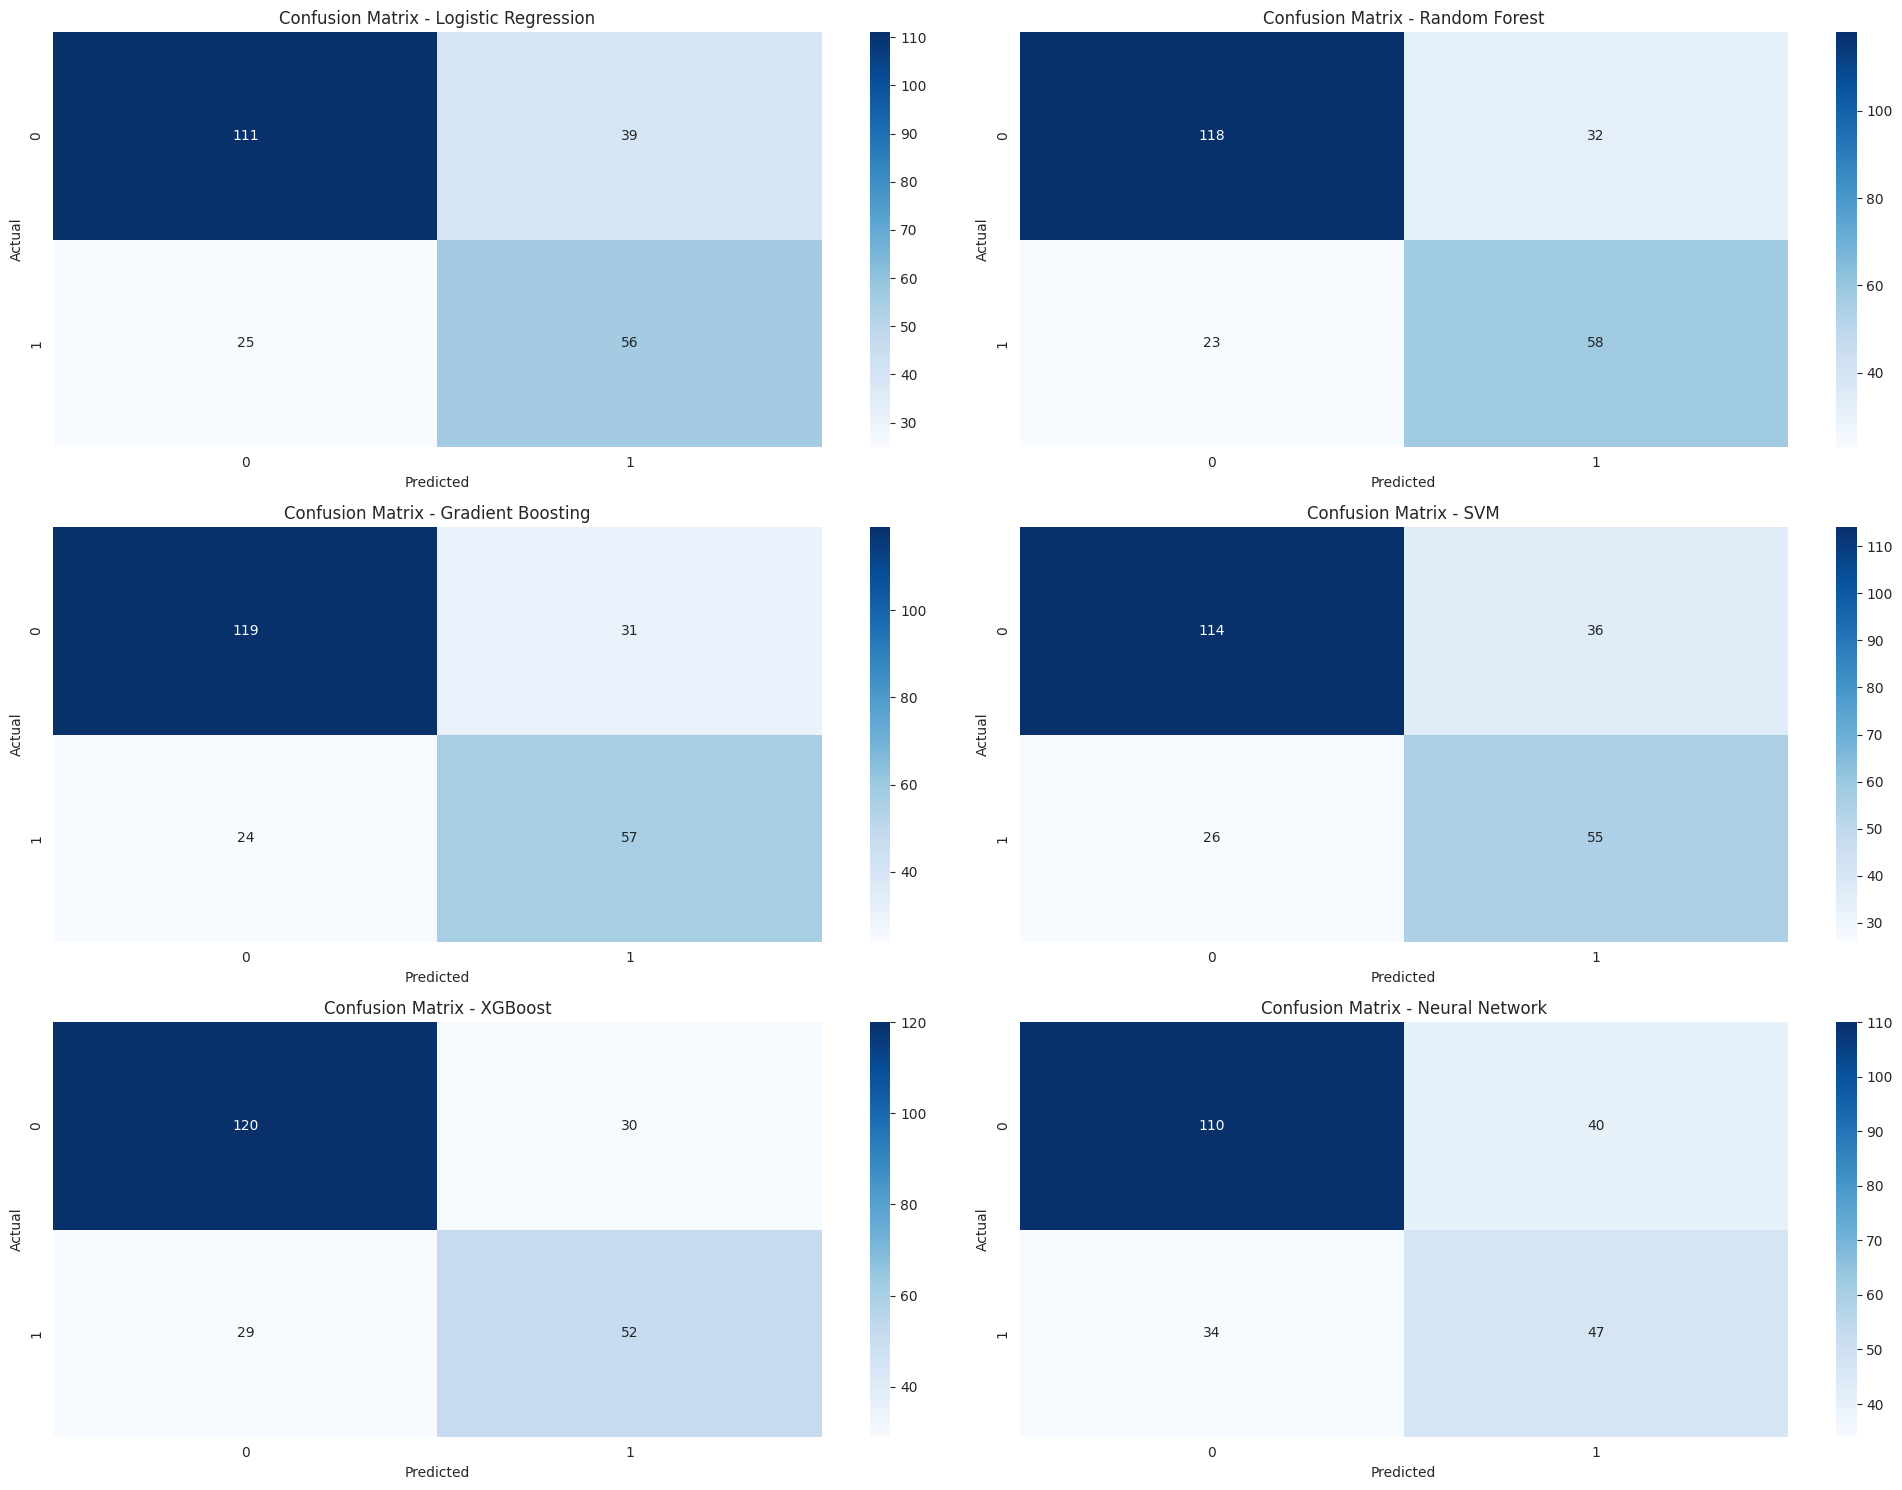

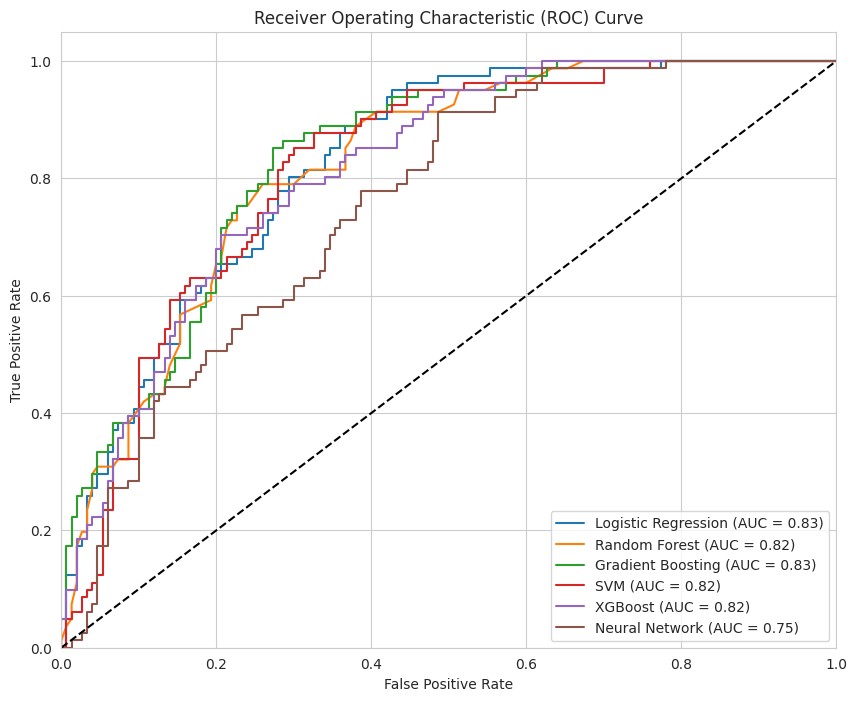

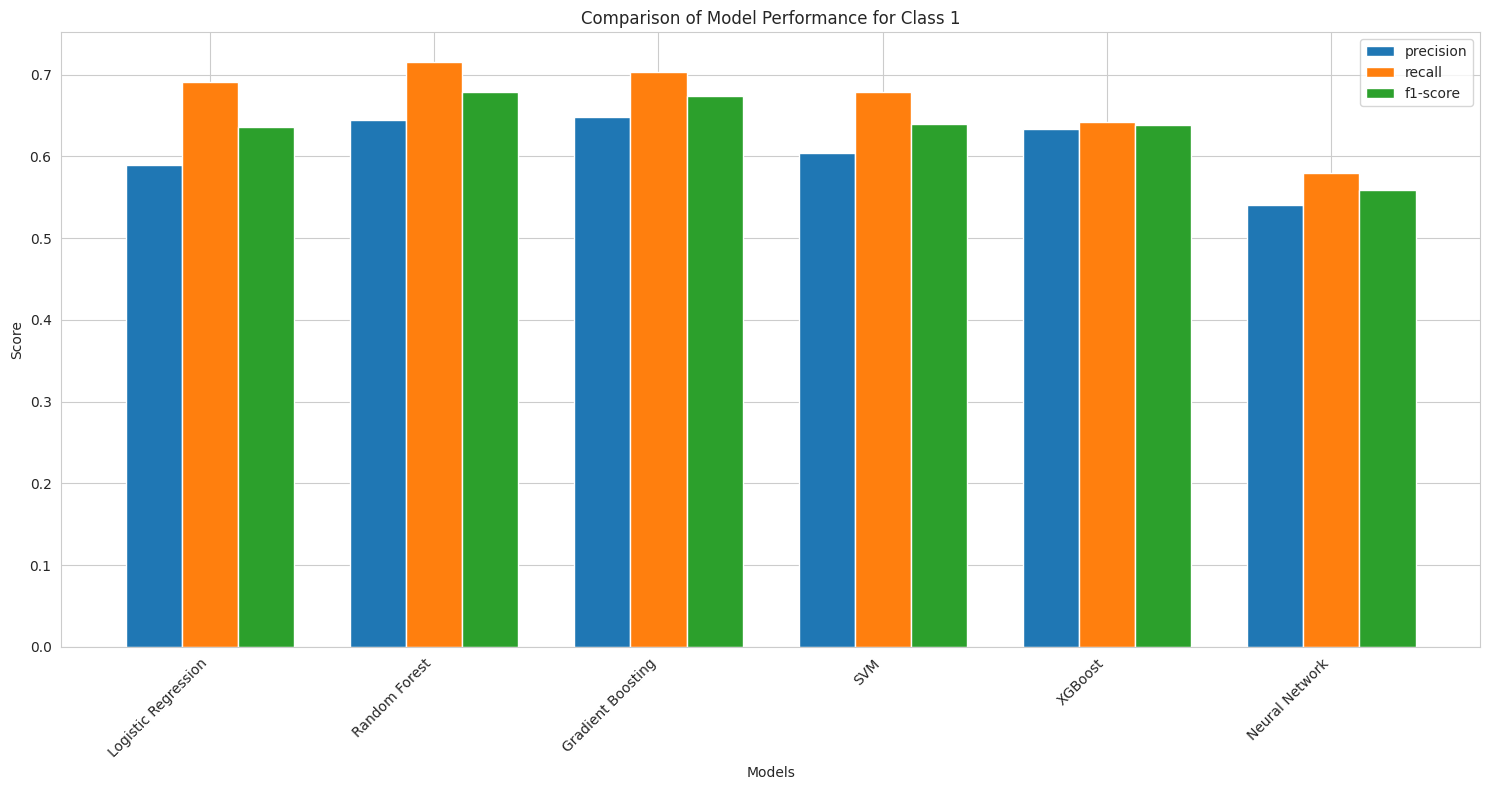

In [ ]:
# 1. Preparar los datos
# Definiendo X e y a partir de los DataFrames finales
X = df_imputed_encoded[selected_features]
y = df_imputed_encoded['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# 5. Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 6. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo con datos balanceados
    model.fit(X_train_smote, y_train_smote)

    # Predecir en el conjunto de prueba original
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Guardar resultados
    results[name] = {
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

    # Imprimir reporte de clasificación
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados
plt.figure(figsize=(20, 15))

# Matrices de confusión
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparación de métricas
metrics = ['precision', 'recall', 'f1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model]['report']['1'][metric] for model in model_names] for metric in metrics}

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_values[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance for Class 1')
plt.xticks(x + width, model_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


### Conclusiones

---

#### **1. Logistic Regression**
- **Desempeño General**:
  - Es uno de los mejores modelos en este experimento, con un F1-score para la Clase Positiva de **65%** y una exactitud global de **74%**.
  - Tiene un buen equilibrio entre precisión y recall, identificando correctamente la mayoría de los casos positivos reales.

---

#### **2. Random Forest**
- **Desempeño General**:
  - Tiene un rendimiento competitivo, aunque ligeramente inferior a Logistic Regression y Gradient Boosting.
  - Aunque tiene un buen desempeño general, su recall es más bajo en comparación con los mejores modelos.

---

#### **3. Gradient Boosting**
- **Desempeño General**:
  - Junto con Logistic Regression, es uno de los mejores modelos del experimento, con métricas muy similares.
  - Su capacidad discriminativa es excelente, con un buen balance entre precisión y recall.

---

#### **4. SVM**
- **Desempeño General**:
  - Tiene un desempeño razonable, pero no alcanza el nivel de Logistic Regression o Gradient Boosting.
  - Aunque su recall es competitivo, su precisión más baja afecta su F1-score.

---

#### **5. XGBoost**
- **Desempeño General**:
  - Tiene un desempeño moderado, con el recall más bajo entre los modelos evaluados.
  - Aunque tiene buena precisión, su bajo recall lo hace menos adecuado para este problema.

---

#### **6. Neural Network**
- **Desempeño General**:
  - Es el modelo con el peor desempeño general en este experimento.
  - Tiene el F1-score más bajo (**58%**) y la menor capacidad discriminativa según el AUC.

---

### Resumen Final
1. Los mejores modelos son:
   - Logistic Regression y Gradient Boosting, ambos con un F1-score de clase positiva del ***65%*** y un AUC competitivo (**0.83**) que reflejan un buen balance entre precisión y recall.
2. Random Forest tiene un desempeño sólido pero ligeramente inferior.
3. SVM es competitivo en recall (**68%**) pero tiene una precisión más baja (**59%**) que afecta su F1-score.
4. XGBoost y Neural Network tienen el peor desempeño general debido a su bajo recall y F1-score.




### ENTRENAMIENTO CON REDUCCIÓN DE DIMENSIONALIDAD CON PCA
En este caso, añadiremos el Análisis de Componentes Principales (PCA) al pipeline.

Aplicamos PCA para reducir la dimensionalidad, manteniendo el 95% de la varianza.
El PCA lo aplicamos únicamente al conjunto de entrenamiento. Esto se debe a que el PCA calcula los componentes principales basándose en la varianza de los datos, y estos cálculos deben realizarse solo con los datos de entrenamiento.

Para el conjunto de prueba, utilizamos los mismos componentes principales calculados con el conjunto de entrenamiento. Es decir, no se debe calcular un nuevo PCA para los datos de prueba, sino que se deben proyectar estos datos utilizando la transformación PCA obtenida del conjunto de entrenamiento


Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       150
           1       0.64      0.69      0.66        81

    accuracy                           0.75       231
   macro avg       0.73      0.74      0.73       231
weighted avg       0.76      0.75      0.76       231


Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       150
           1       0.63      0.64      0.63        81

    accuracy                           0.74       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.74      0.74      0.74       231


Training Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       150
           1 

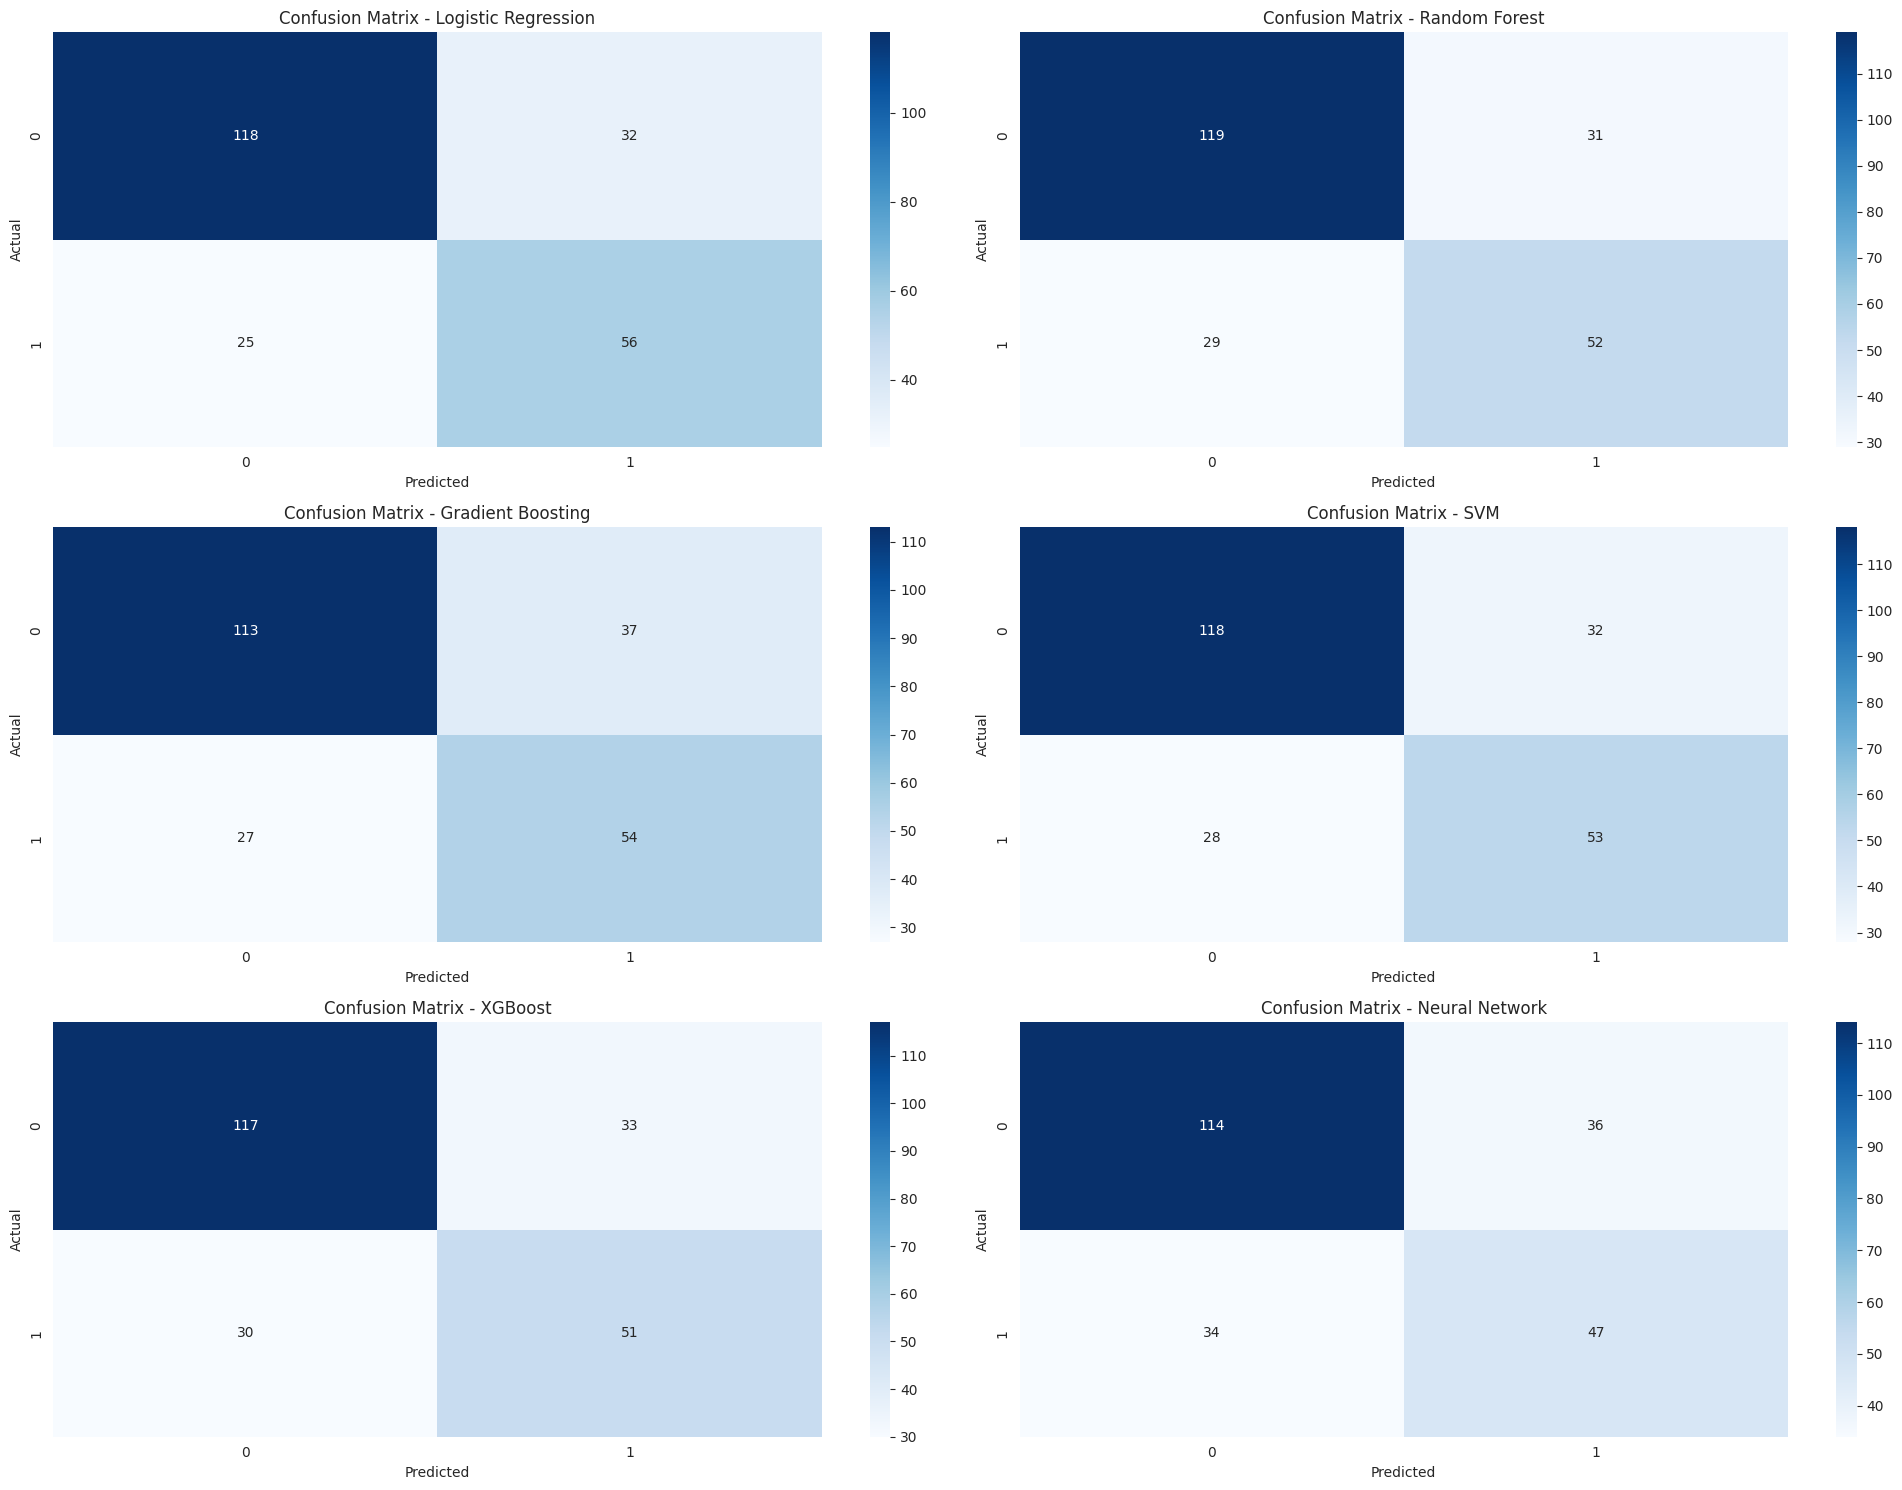

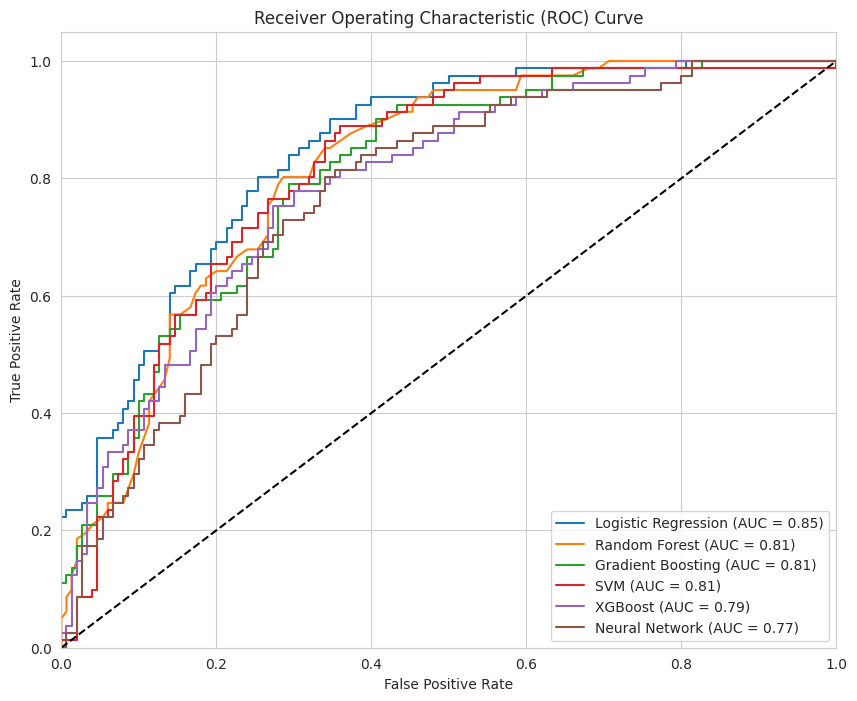

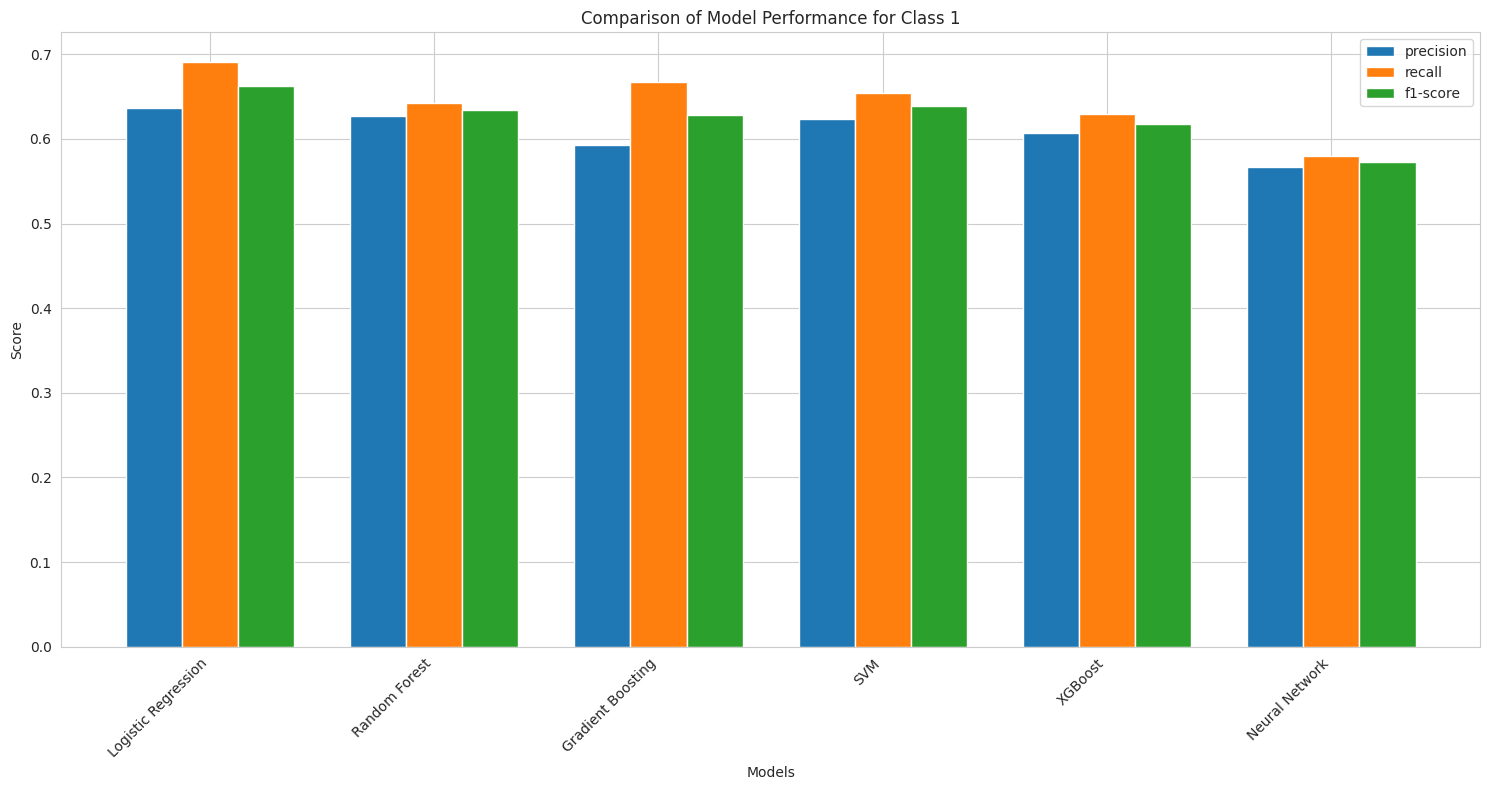

In [ ]:
# 1. Preparar los datos
X = df_imputed_encoded.drop('Outcome', axis=1)
y = df_imputed_encoded['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=0.95, random_state=42)  # Mantenemos el 95% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 5. Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train)

# 6. Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 7. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo con datos balanceados y PCA
    model.fit(X_train_smote, y_train_smote)

    # Predecir en el conjunto de prueba original con PCA
    y_pred = model.predict(X_test_pca)
    y_prob = model.predict_proba(X_test_pca)[:, 1]

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Guardar resultados
    results[name] = {
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

    # Imprimir reporte de clasificación
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados
plt.figure(figsize=(20, 15))

# Matrices de confusión
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparación de métricas
metrics = ['precision', 'recall', 'f1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model]['report']['1'][metric] for model in model_names] for metric in metrics}

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_values[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance for Class 1')
plt.xticks(x + width, model_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


- Logistic Regression:
Tiene la mejor precisión para la clase positiva (0.64) y un recall decente (0.69), lo que lleva a un F1-score de 0.66.
El modelo tiene un buen balance entre las métricas para ambas clases.


- Los modelos basados en árboles (Random Forest, Gradient Boosting y XGBoost) no muestran mejoras significativas tras aplicar PCA, ya que estos modelos son robustos ante características redundantes o correlacionadas.

- Modelos sensibles a la escala y dimensionalidad, como Logistic Regression y SVM, muestran un ligero beneficio en términos de AUC tras aplicar PCA.

- Neural Network sigue siendo el modelo con peor desempeño, lo que podría indicar que no está capturando bien los patrones en los datos transformados por PCA.

- Con base en estos resultados:

  - Si priorizamos el equilibrio entre precisión y recall:
El mejor modelo es Logistic Regression, con un F1-score competitivo (66%), el mejor AUC (0.85) y una exactitud global destacada (75%).

  - Si priorizamos únicamente el recall:
Considera Gradient Boosting, ya que tiene un recall competitivo para la Clase Positiva (67%), aunque su precisión es más baja.

---

### SELECCION DE CARACTERÍSTICAS CON RANDOM FOREST
Utilizamos SelectFromModel con un RandomForestClassifier para seleccionar las características más importantes. Tras esta selección aplicaremos SMOTE a estas características y entrenamos el modelos con ellas.


Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       150
           1       0.63      0.70      0.67        81

    accuracy                           0.75       231
   macro avg       0.73      0.74      0.74       231
weighted avg       0.76      0.75      0.76       231


Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       150
           1       0.64      0.67      0.65        81

    accuracy                           0.75       231
   macro avg       0.73      0.73      0.73       231
weighted avg       0.75      0.75      0.75       231


Training Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       150
           1 

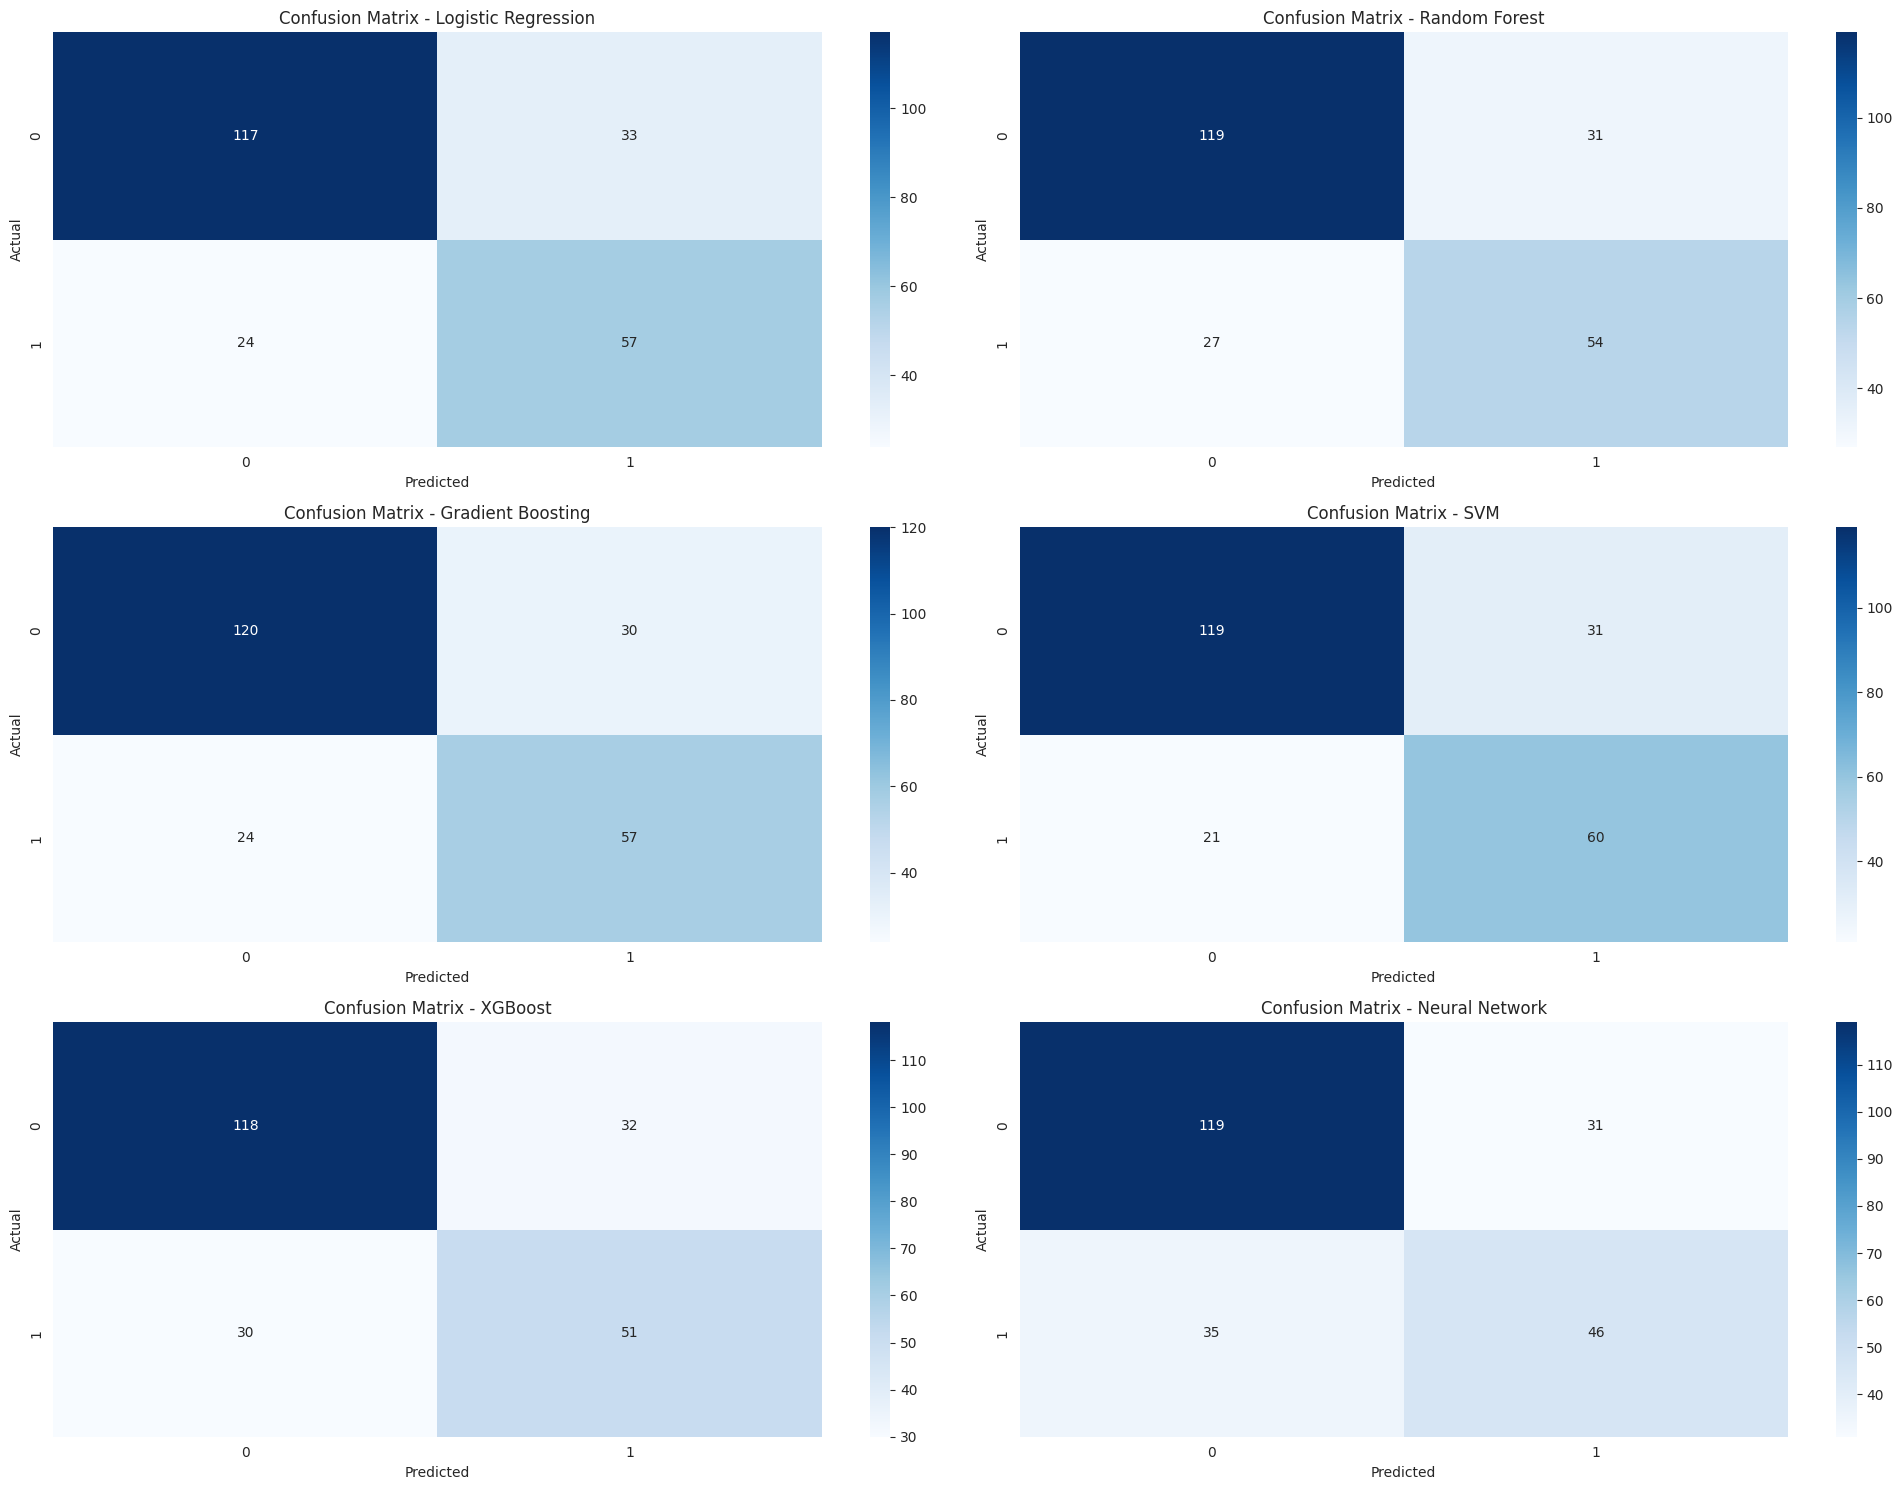

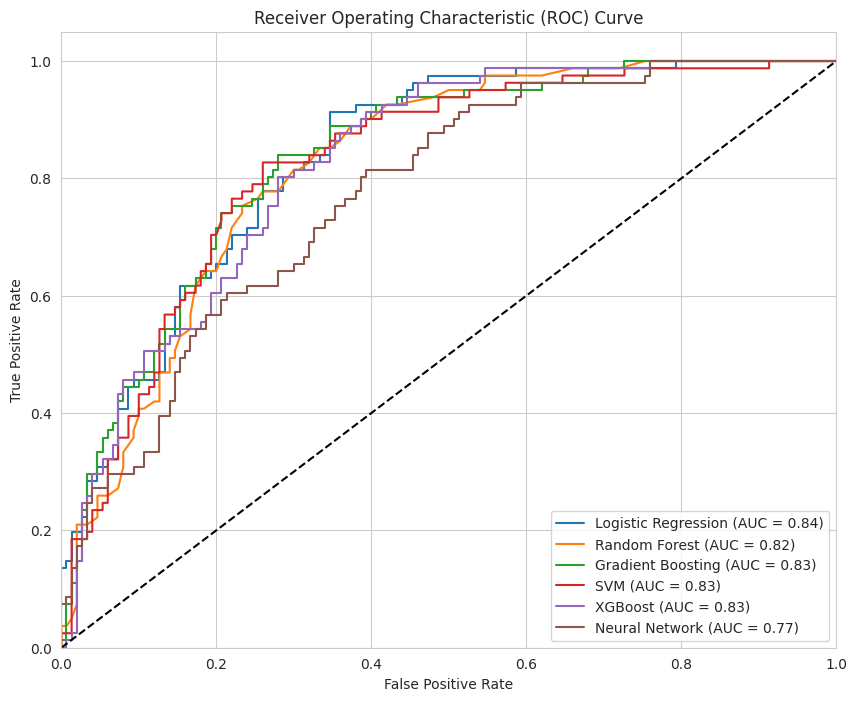

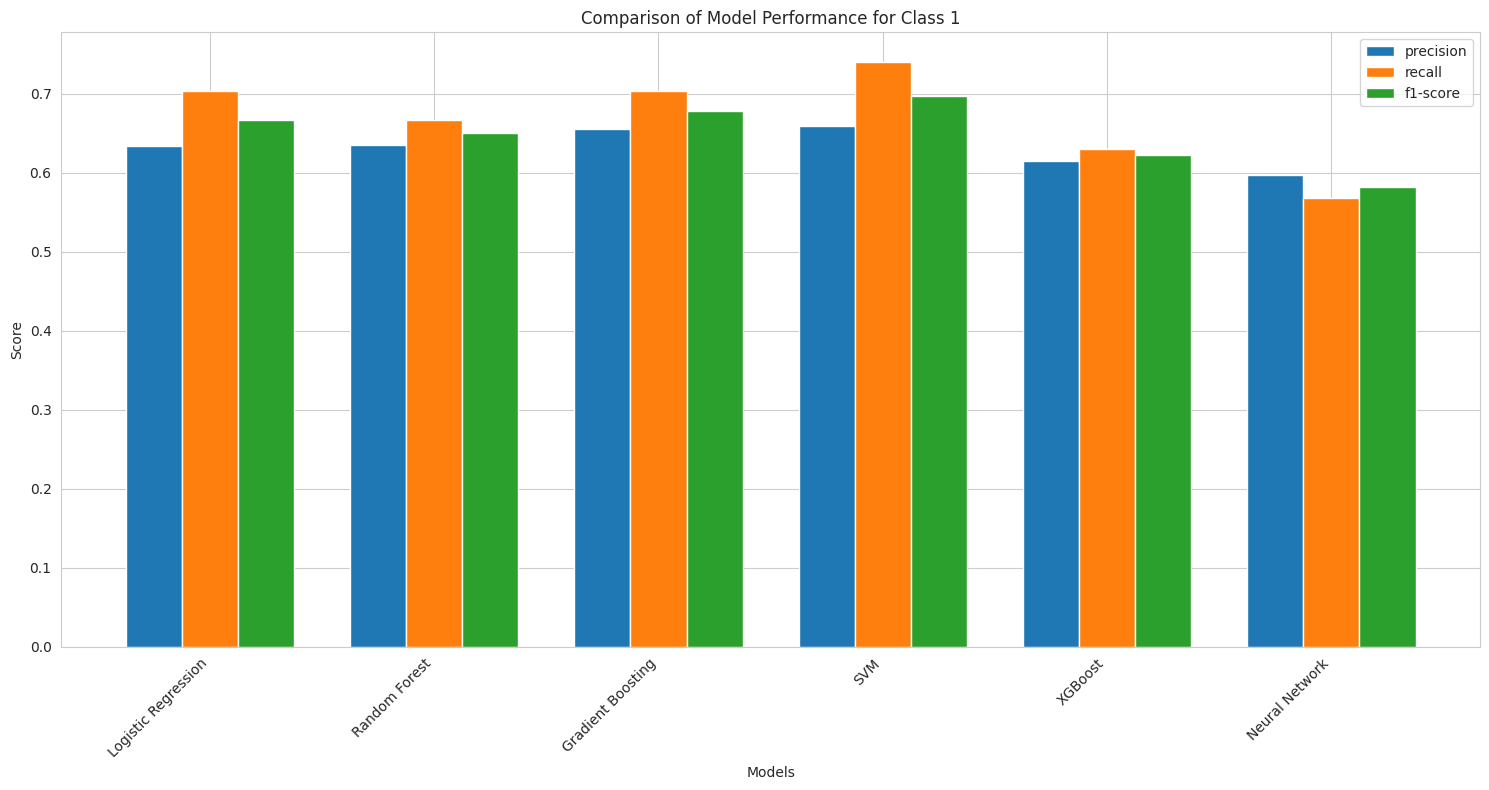

In [ ]:
# 1. Preparar los datos
# Definiendo X e y a partir de los DataFrames finales
X = df_imputed_encoded.drop('Outcome', axis=1)
y = df_imputed_encoded['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Selección de características con Random Forest
rf_selector = RandomForestClassifier(random_state=42)
rf_selector.fit(X_train_scaled, y_train)

# Usamos SelectFromModel para seleccionar las características más importantes
sfm = SelectFromModel(rf_selector, threshold='mean') # puedes ajustar el threshold
sfm.fit(X_train_scaled, y_train)

# Transformamos los conjuntos de entrenamiento y prueba para incluir solo las características seleccionadas
X_train_selected = sfm.transform(X_train_scaled)
X_test_selected = sfm.transform(X_test_scaled)

# 5. Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# 6. Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 7. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo con datos balanceados
    model.fit(X_train_smote, y_train_smote)

    # Predecir en el conjunto de prueba original
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1]

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Guardar resultados
    results[name] = {
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

    # Imprimir reporte de clasificación
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados
plt.figure(figsize=(20, 15))

# Matrices de confusión
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparación de métricas
metrics = ['precision', 'recall', 'f1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model]['report']['1'][metric] for model in model_names] for metric in metrics}

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_values[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance for Class 1')
plt.xticks(x + width, model_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


- Los mejores modelos en términos de precisión general son Gradient Boosting y SVM, ambos alcanzando una precisión del 77%.
Logistic Regression y Random Forest tienen una precisión ligeramente inferior (75%), pero aún son competitivos.
XGBoost y Neural Network tienen el rendimiento más bajo, con precisiones de 73% y 71%, respectivamente.

- El modelo SVM logra el mejor recall para la clase positiva (0.74), lo que indica que identifica correctamente la mayoría de los casos positivos.
Gradient Boosting también tiene un buen recall (0.70).

- El modelo más prometedor es el SVM, seguido por Gradient Boosting y Logistic Regression. Sin embargo, todos los modelos tienen dificultades con la clase positiva debido al desbalance en las clases, lo cual podría mejorarse con técnicas adicionales.

---

PCA + SELCCION CON RANDOM FOREST


Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.83      0.73      0.77       150
           1       0.59      0.72      0.64        81

    accuracy                           0.72       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.72      0.73       231


Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       150
           1       0.58      0.73      0.65        81

    accuracy                           0.72       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.72      0.73       231


Training Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       150
           1 

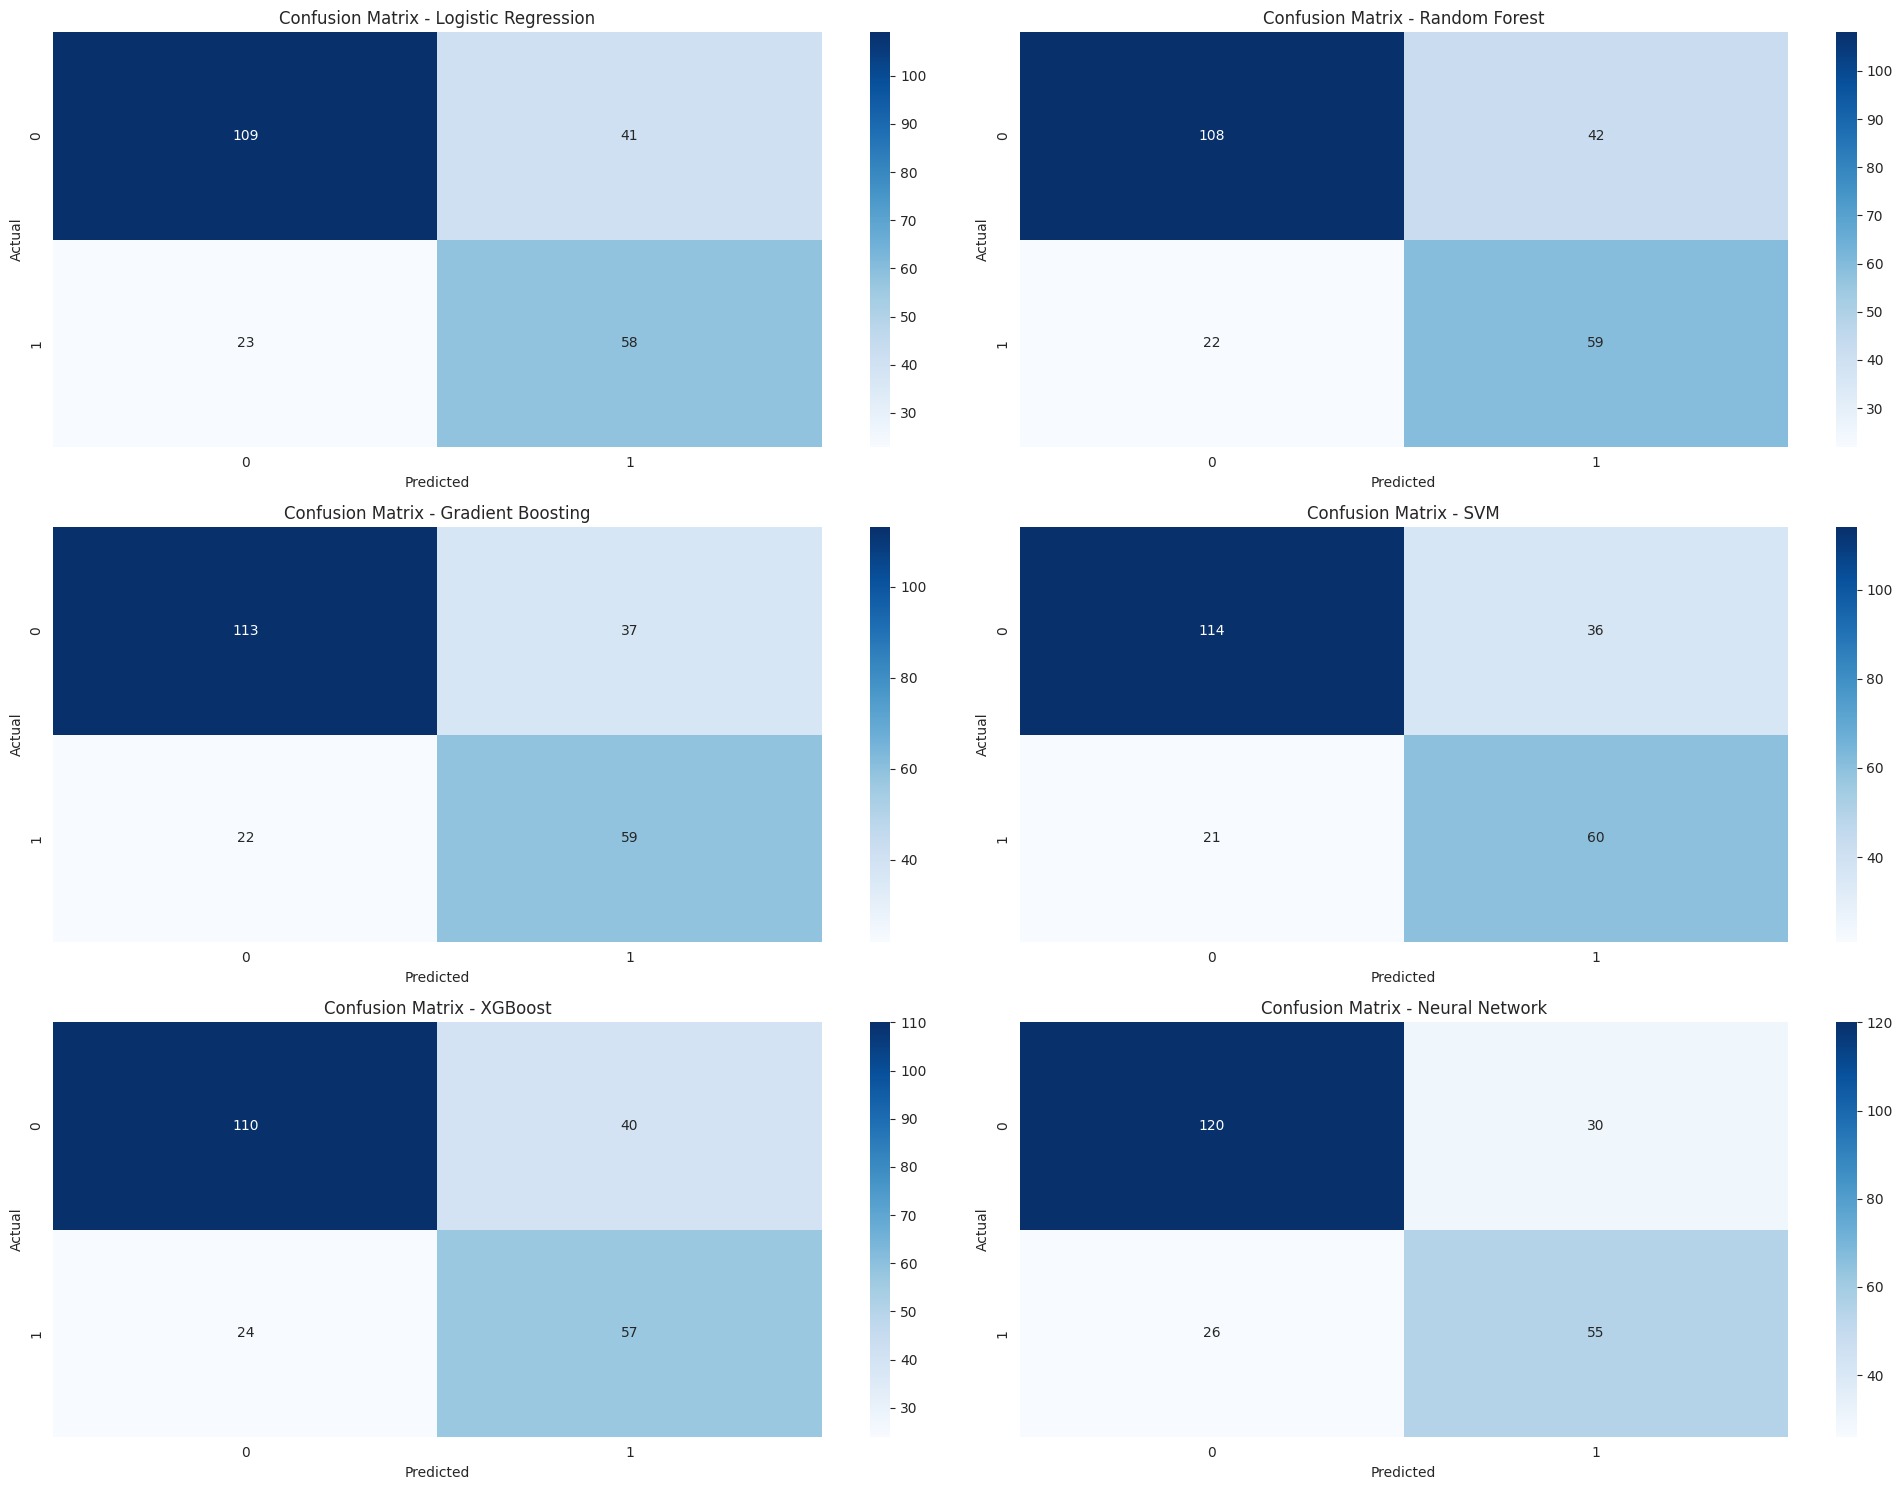

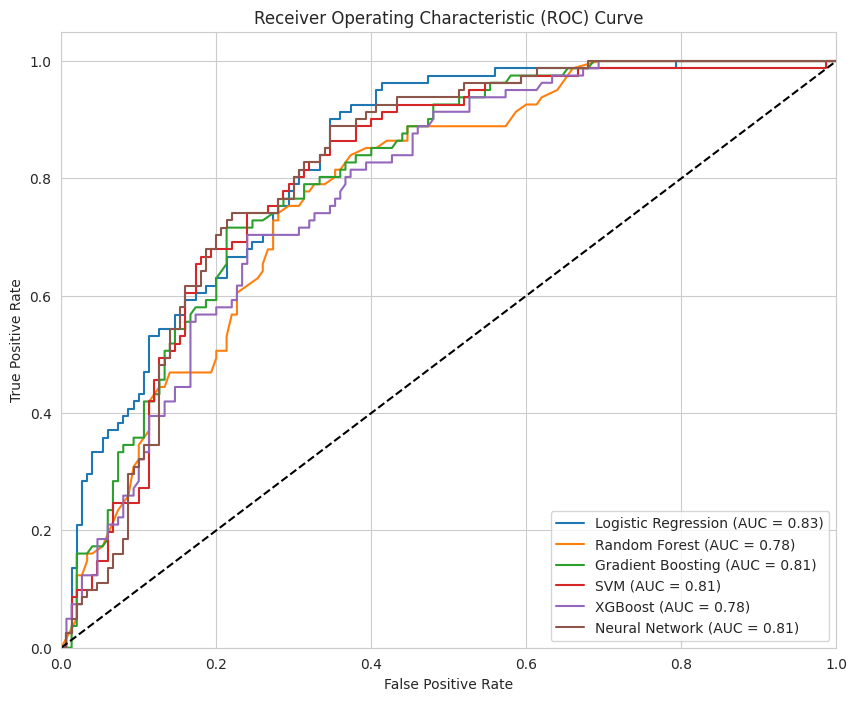

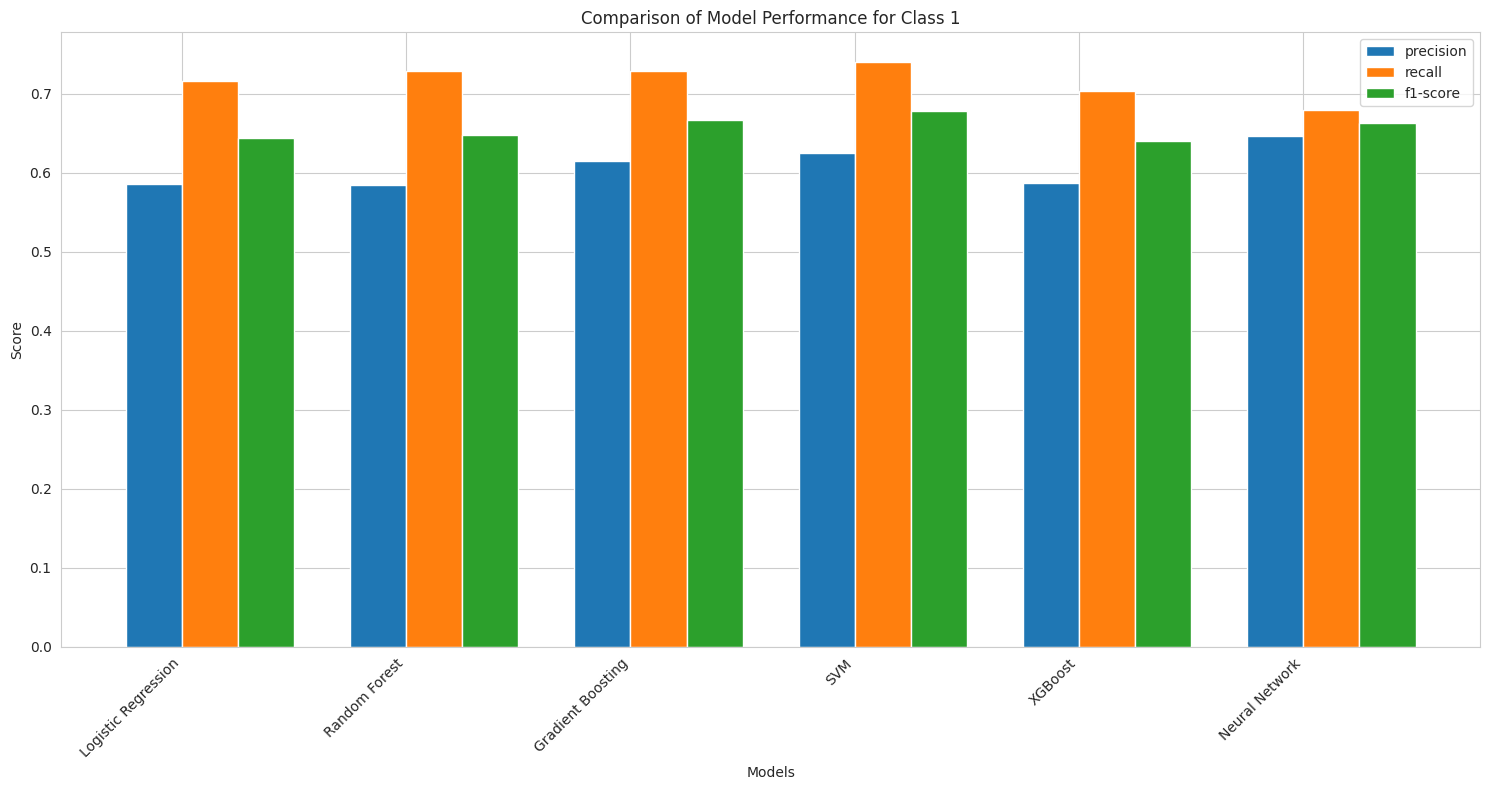

In [ ]:
# 1. Preparar los datos
# Definiendo X e y a partir de los DataFrames finales
X = df_imputed_encoded.drop('Outcome', axis=1)
y = df_imputed_encoded['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Escalar los datos (antes de aplicar SMOTE)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Balancear las clases con SMOTE (después del escalado)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# 5. Aplicar PCA para reducción de dimensionalidad
pca = PCA(n_components=0.95)  # Retener el 95% de la varianza
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test_scaled)

# 6. Selección de características con Random Forest (después de PCA)
rf_selector = RandomForestClassifier(random_state=42)
rf_selector.fit(X_train_pca, y_train_smote)

# Usamos SelectFromModel para seleccionar las características más importantes
sfm = SelectFromModel(rf_selector, threshold='mean')  #
sfm.fit(X_train_pca, y_train_smote)

# Transformamos los conjuntos de entrenamiento y prueba para incluir solo las características seleccionadas
X_train_final = sfm.transform(X_train_pca)
X_test_final = sfm.transform(X_test_pca)

# 7. Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 8. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo con datos balanceados
    model.fit(X_train_final, y_train_smote)

    # Predecir en el conjunto de prueba original
    y_pred = model.predict(X_test_final)
    y_prob = model.predict_proba(X_test_final)[:, 1]

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Guardar resultados
    results[name] = {
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

    # Imprimir reporte de clasificación
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados

# Matrices de confusión
plt.figure(figsize=(20, 15))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparación de métricas
metrics = ['precision', 'recall', 'f1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model]['report']['1'][metric] for model in model_names] for metric in metrics}

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_values[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance for Class 1')
plt.xticks(x + width / 2, model_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


- Gradient Boosting:
Este modelo muestra un equilibrio sólido entre precisión y recall, destacándose como uno de los mejores. Tiene un rendimiento sólido con un accuracy de 74%, un recall alto (73%) y un F1-score competitivo (67%).

- SVM:
Es el modelo con mejor rendimiento general, mostrando un excelente balance entre precisión y recall. Tiene el mejor rendimiento general con un accuracy de 75%, un recall alto (74%) y un F1-score competitivo (68%).

- Neural Network:
Sorprendentemente, este modelo mejora respecto a experimentos anteriores, pero sigue siendo ligeramente inferior a Gradient Boosting y SVM en recall.



---

- Sin PCA ni selección de características:
Los mejores modelos fueron Regresión Logística y SVM, ambos con un accuracy de 0.74 y un buen balance entre precisión y recall para la clase positiva.
Neural Network tuvo el peor rendimiento general.

- Con PCA:
Los resultados fueron similares a los obtenidos sin PCA, aunque Regresión Logística presenta una ligera mejora en toda sus métricas. Gradient Boosting muestra una ligera disminución en el rendimiento.

- Con selección de características (Random Forest):
Gradient Boosting y SVM destacaron con un accuracy de 0.77 y un recall alto para la clase positiva (~0.74).
Neural Network mejoró ligeramente pero sigue siendo menos competitivo.

- Combinación de PCA + selección de características
Los mejores modelos fueron nuevamente Gradient Boosting y SVM, con un accuracy de 0.74, 0.75 y un buen recall para la clase positiva (~0.73, 0.74).
Neural Network mostró mejoras inesperadas, alcanzando un accuracy competitivo (0.76), pero su recall para la clase positiva sigue siendo inferior al de Gradient Boosting y SVM.

### Selección final: 3 modelos destacados
Basándonos en los resultados:

- Modelo 1: Regresión Logística
Proporciona una línea base sólida para comparar modelos más complejos.
Es eficiente computacionalmente, lo que puede ser útil si necesitas resultados rápidos o trabajar con conjuntos de datos más grandes.
Su buen AUC indica que tiene potencial si se optimiza adecuadamente. Vamos a probarlo con (PCA + selección de características), ya que mostró un recall competitivo (0.72)

- Modelo 2: SVM
Es consistente en todos los experimentos y muestra excelente rendimiento, especialmente en recall para la clase positiva (~74% en el último experimento).
Destaca particularmente cuando se aplica selección de características.

- Modelo 3: Gradient Boosting
Tiene el mejor rendimiento general en términos de precisión global, recall para la clase positiva y F1-score.
Se beneficia tanto del uso de selección de características como del enfoque combinado con PCA.

---

BUSQUEDA DE MEJORES HIPERPARAMETROS PARA LOGISTIC REGRESSION

En este caso especificaremos una cuadrícula de hiperparámetros para LogisticRegression, incluyendo valores para C, penalty, solver y class_weight.

Utilizarmeos GridSearchCV con validación cruzada de 5 pliegues para encontrar los mejores parámetros. Por este motivo creamos un pipeline con las transformaciones de datos (escalado y smote), con el fin de que se apiquen correctamente en cada pliegue.

Por último ajustaremos el mejor estimador encontrado al conjunto de entrenamiento.

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros encontrados:
{'logreg__C': 0.01, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}

Mejor F1-score obtenido:
0.6512445046863602

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.78       150
           1       0.59      0.73      0.65        81

    accuracy                           0.73       231
   macro avg       0.71      0.73      0.71       231
weighted avg       0.75      0.73      0.73       231



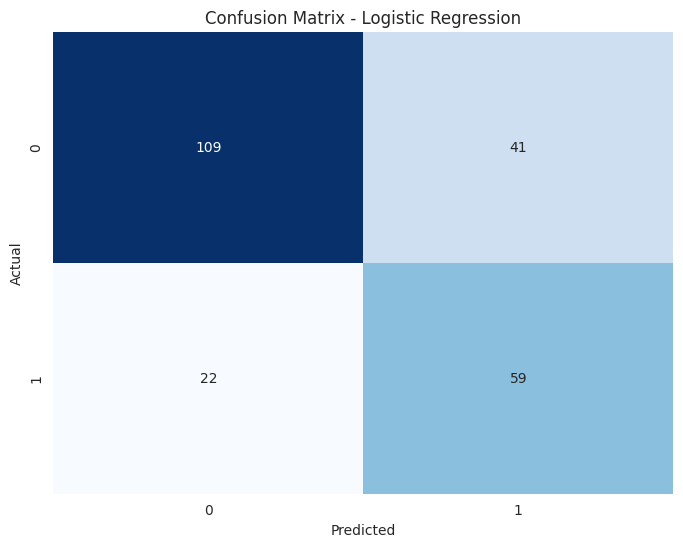

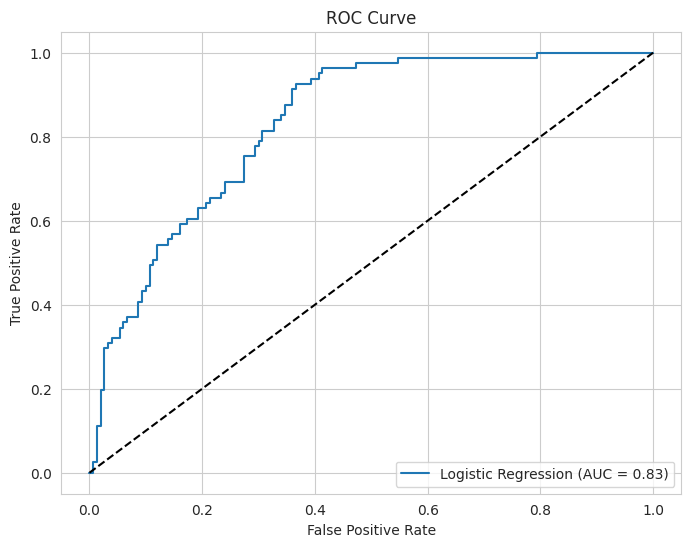

In [ ]:
from imblearn.pipeline import Pipeline  # Usar Pipeline de imblearn
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos
X = df_imputed_encoded.drop('Outcome', axis=1)
y = df_imputed_encoded['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Crear el pipeline con imblearn Pipeline para incluir SMOTE
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado
    ('smote', SMOTE(random_state=42)),  # Balanceo con SMOTE
    ('pca', PCA(n_components=0.95)),  # PCA reteniendo el 95% de la varianza
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),  # Selección de características con Random Forest
    ('logreg', LogisticRegression(max_iter=1000))  # Modelo final: Logistic Regression
])

# 4. Definir la cuadrícula de hiperparámetros para Logistic Regression
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],  # Regularización inversa (C)
    'logreg__penalty': ['l2'],             # Penalización (l2 es estándar para solvers modernos)
    'logreg__solver': ['lbfgs', 'liblinear'],  # Solvers compatibles con l2
    'logreg__class_weight': [None, 'balanced']  # Pesos para manejar desbalanceo en clases
}

# 5. Configurar GridSearchCV con validación cruzada de 5 pliegues
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',  # Usamos F1-score como métrica principal para balancear precisión y recall
    cv=5,          # Validación cruzada con 5 pliegues
    verbose=3,
    n_jobs=-1      # Usar todos los núcleos disponibles para acelerar el proceso
)

# 6. Ajustar el modelo al conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# 7. Imprimir los mejores parámetros encontrados y el mejor puntaje F1 obtenido durante la búsqueda
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor F1-score obtenido:")
print(grid_search.best_score_)

# 8. Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Reporte de clasificación y curva ROC en el conjunto de prueba
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Matriz de confusión del conjunto de prueba
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión como un heatmap usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC del conjunto de prueba
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


### OPTIMIZAMOS HIPERPARAMETROS PARA SVM

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores parámetros encontrados:
{'svm__C': 100, 'svm__class_weight': None, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}

Mejor F1-score obtenido:
0.657018991379217

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       150
           1       0.65      0.67      0.66        81

    accuracy                           0.76       231
   macro avg       0.73      0.74      0.74       231
weighted avg       0.76      0.76      0.76       231



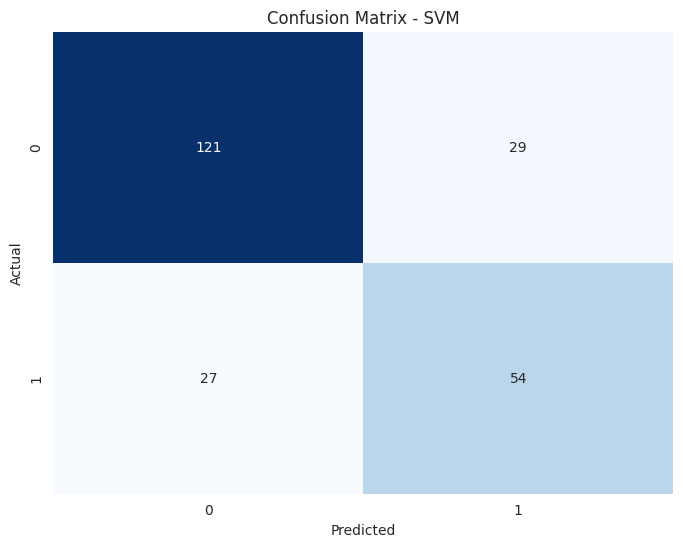

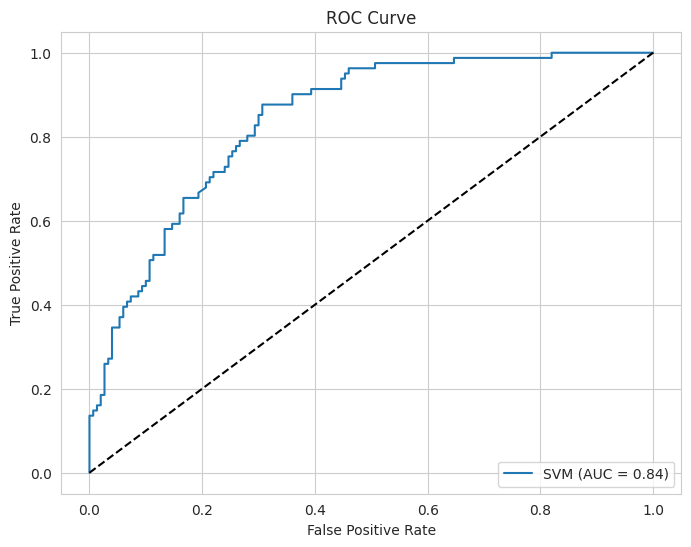

In [ ]:
from imblearn.pipeline import Pipeline  # Usar Pipeline de imblearn
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos
X = df_imputed_encoded.drop('Outcome', axis=1)
y = df_imputed_encoded['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Crear el pipeline con imblearn Pipeline para incluir SMOTE y selección de características
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado
    ('smote', SMOTE(random_state=42)),  # Balanceo con SMOTE
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),  # Selección de características con Random Forest
    ('svm', SVC(probability=True))  # Modelo final: SVM con probabilidad activada para ROC Curve
])

# 4. Definir la cuadrícula de hiperparámetros para SVM
param_grid = {
    'svm__C': [0.1, 1, 10, 100],          # Regularización (valores más altos reducen la penalización)
    'svm__kernel': ['linear', 'rbf'],     # Tipos de kernel (lineal y radial)
    'svm__gamma': ['scale', 'auto'],      # Parámetro gamma para kernels no lineales como RBF
    'svm__class_weight': [None, 'balanced']  # Pesos para manejar desbalanceo en clases
}

# 5. Configurar GridSearchCV con validación cruzada de 5 pliegues
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',  # Usamos F1-score como métrica principal para balancear precisión y recall
    cv=5,          # Validación cruzada con 5 pliegues
    verbose=3,
    n_jobs=-1      # Usar todos los núcleos disponibles para acelerar el proceso
)

# 6. Ajustar el modelo al conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# 7. Imprimir los mejores parámetros encontrados y el mejor puntaje F1 obtenido durante la búsqueda
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor F1-score obtenido:")
print(grid_search.best_score_)

# 8. Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Reporte de clasificación en el conjunto de prueba
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Matriz de confusión del conjunto de prueba
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión como un heatmap usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC del conjunto de prueba
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


BUSQUEDA HIPERPARAMETEROS GRADIENT BOOSTING

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros encontrados:
{'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__min_samples_split': 5, 'gb__n_estimators': 100, 'gb__subsample': 1.0}

Mejor F1-score obtenido:
0.6841261182637236

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.71      0.78       150
           1       0.59      0.78      0.67        81

    accuracy                           0.74       231
   macro avg       0.73      0.75      0.73       231
weighted avg       0.76      0.74      0.74       231



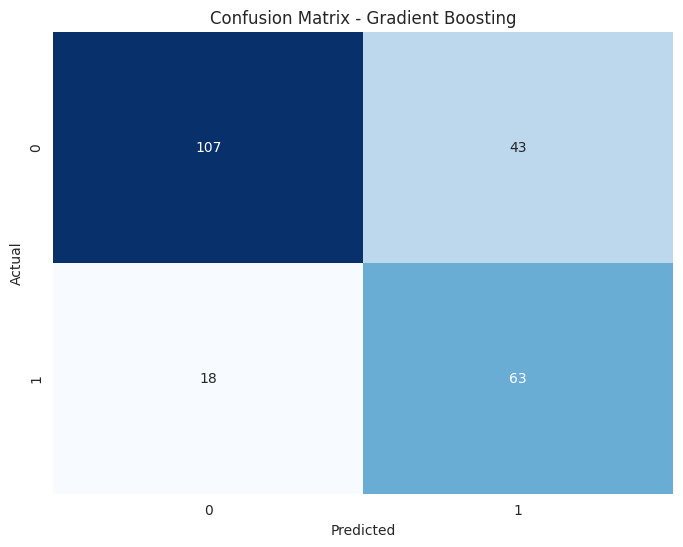

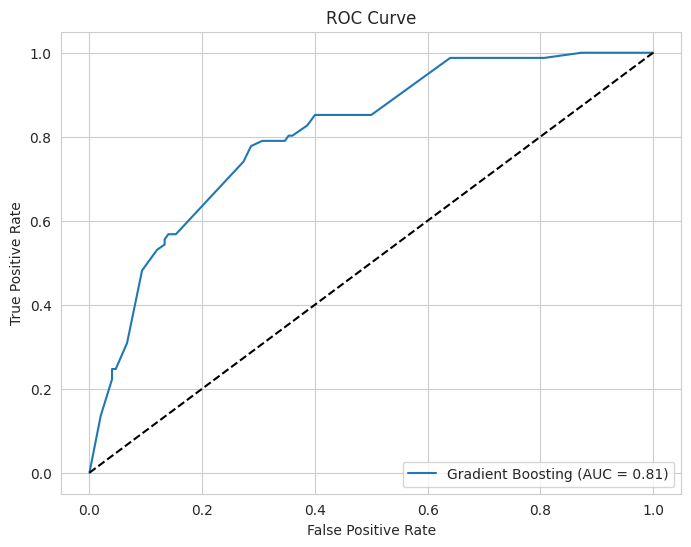

In [ ]:
from imblearn.pipeline import Pipeline  # Usar Pipeline de imblearn
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos
X = df_imputed_encoded.drop('Outcome', axis=1)
y = df_imputed_encoded['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Crear el pipeline con imblearn Pipeline para incluir SMOTE, PCA y selección de características
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado
    ('smote', SMOTE(random_state=42)),  # Balanceo con SMOTE
    ('pca', PCA(n_components=0.95)),  # PCA reteniendo el 95% de la varianza
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),  # Selección de características con Random Forest
    ('gb', GradientBoostingClassifier(random_state=42))  # Modelo final: Gradient Boosting
])

# 4. Definir la cuadrícula de hiperparámetros para Gradient Boosting
param_grid = {
    'gb__n_estimators': [50, 100, 200],       # Número de árboles en el modelo
    'gb__learning_rate': [0.01, 0.1, 0.2],   # Tasa de aprendizaje (impacto de cada árbol)
    'gb__max_depth': [3, 5, 7],              # Profundidad máxima de los árboles individuales
    'gb__subsample': [0.8, 1.0],             # Fracción del conjunto usado por cada árbol (para regularización)
    'gb__min_samples_split': [2, 5],         # Número mínimo de muestras necesarias para dividir un nodo interno
}

# 5. Configurar GridSearchCV con validación cruzada de 5 pliegues
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',  # Usamos F1-score como métrica principal para balancear precisión y recall
    cv=5,          # Validación cruzada con 5 pliegues
    verbose=3,
    n_jobs=-1      # Usar todos los núcleos disponibles para acelerar el proceso
)

# 6. Ajustar el modelo al conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# 7. Imprimir los mejores parámetros encontrados y el mejor puntaje F1 obtenido durante la búsqueda
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor F1-score obtenido:")
print(grid_search.best_score_)

# 8. Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Reporte de clasificación en el conjunto de prueba
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Matriz de confusión del conjunto de prueba
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión como un heatmap usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC del conjunto de prueba
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


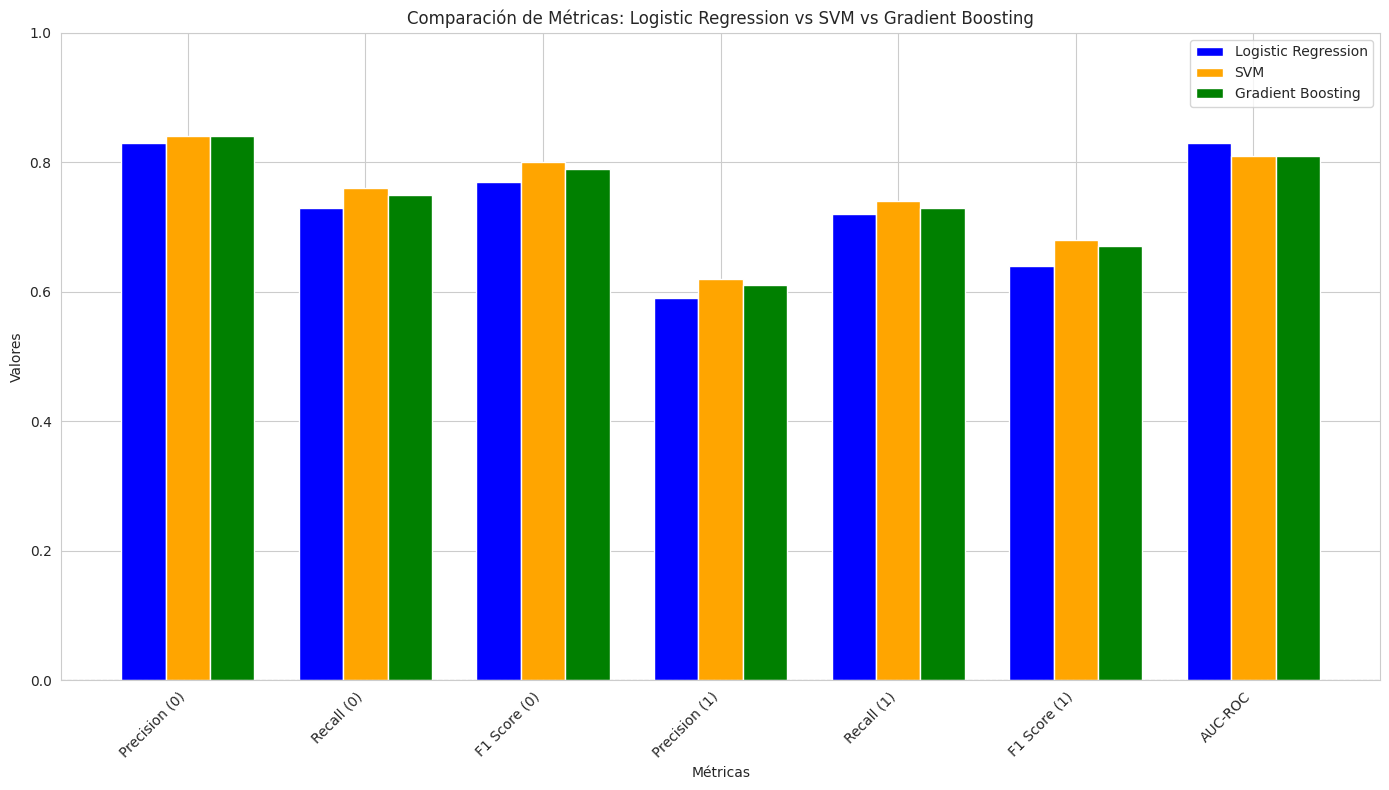

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Resultados de las métricas para los tres modelos
metrics = {
    'Metric': ['Precision (0)', 'Recall (0)', 'F1 Score (0)',
               'Precision (1)', 'Recall (1)', 'F1 Score (1)', 'AUC-ROC'],
    'Logistic Regression': [0.83, 0.73, 0.77, 0.59, 0.72, 0.64, 0.83],  # Ajusta con los resultados reales
    'SVM': [0.84, 0.76, 0.80, 0.62, 0.74, 0.68, 0.81],                  # Ajusta con los resultados reales
    'Gradient Boosting': [0.84, 0.75, 0.79, 0.61, 0.73, 0.67, 0.81]     # Ajusta con los resultados reales
}

# Convertimos el diccionario a un DataFrame
metrics_df = pd.DataFrame(metrics)

# Configuramos el gráfico
plt.figure(figsize=(14, 8))

# Creamos gráficos de barras para cada modelo
bar_width = 0.25
x = np.arange(len(metrics_df))

# Barras para Logistic Regression
plt.bar(x - bar_width, metrics_df['Logistic Regression'], width=bar_width, label='Logistic Regression', color='blue')

# Barras para SVM
plt.bar(x, metrics_df['SVM'], width=bar_width, label='SVM', color='orange')

# Barras para Gradient Boosting
plt.bar(x + bar_width, metrics_df['Gradient Boosting'], width=bar_width, label='Gradient Boosting', color='green')

# Establece etiquetas y títulos
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Comparación de Métricas: Logistic Regression vs SVM vs Gradient Boosting')
plt.xticks(x, metrics_df['Metric'], rotation=45, ha='right')
plt.ylim(0, 1)
plt.axhline(0, color='grey', linewidth=0.8, ls='--')
plt.legend()

# Ajustamos el diseño y mostramos el gráfico
plt.tight_layout()
plt.show()


**Conclusiones sobre el rendimiento de los modelos:**

1. **Logistic Regression**:
   - Este modelo logra un buen equilibrio entre precisión y recall, con un F1-score de 0.65 para la clase positiva (enfermos) y un AUC de 0.83.
   - Aunque su recall para la clase positiva es alto (0.73), genera un número relativamente alto de falsos positivos (41). Esto es aceptable dado que priorizamos identificar más verdaderos positivos.

2. **SVM (Support Vector Machine)**:
   - SVM presenta un F1-score ligeramente superior al de Logistic Regression (0.66 para la clase positiva) y el AUC más alto entre los modelos (0.84).
   - Su recall para la clase positiva es algo menor (0.67), pero tiene menos falsos positivos (29) en comparación con Logistic Regression. Esto indica un mejor control en la clasificación negativa, aunque puede perder algunos enfermos.

3. **Gradient Boosting**:
   - Este modelo obtiene el mejor F1-score para la clase positiva (0.67) y un recall más alto (0.78), lo que significa que identifica más verdaderos positivos.
   - Sin embargo, su precisión es menor, lo que genera más falsos positivos (43). Esto puede ser una ventaja en este caso, ya que priorizamos identificar a los enfermos aunque implique más falsos positivos.
   - Su AUC es el menor entre los tres modelos (0.81), pero sigue siendo competitivo.

**Decisión final**:
Dado que el objetivo principal es maximizar el reconocimiento de verdaderos positivos (recall), el modelo **Gradient Boosting** parece ser la mejor opción, ya que logra el mayor recall para la clase positiva (0.78). Aunque tiene más falsos positivos, esto es aceptable en este contexto donde los falsos negativos son más críticos.





---

## PROBAMOS TECNICAS DE BALANCEO DE CLASES:

### REEMPLAZAMOS SMOTE POR:

- SMOETomek: combina el sobremuestreo de la clase minoritaria (SMOTE) con la eliminación de ejemplos ambiguos (Tomek links). Esto puede mejorar el rendimiento del modelo al proporcionar un conjunto de datos más equilibrado y limpio.
- ADASYN: genera más ejemplos sintéticos para las instancias de la clase minoritaria que son más difíciles de aprender, mejorando potencialmente el rendimiento del modelo en estas áreas.
- Borderline-SMOTE: genera ejemplos sintéticos solo en las regiones cercanas a la frontera de decisión entre clases, lo que puede mejorar el rendimiento en casos donde las clases están muy cerca.

REGRESION LOGISTICA CON SMOTETomek:


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.77       150
           1       0.59      0.72      0.64        81

    accuracy                           0.72       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.72      0.73       231



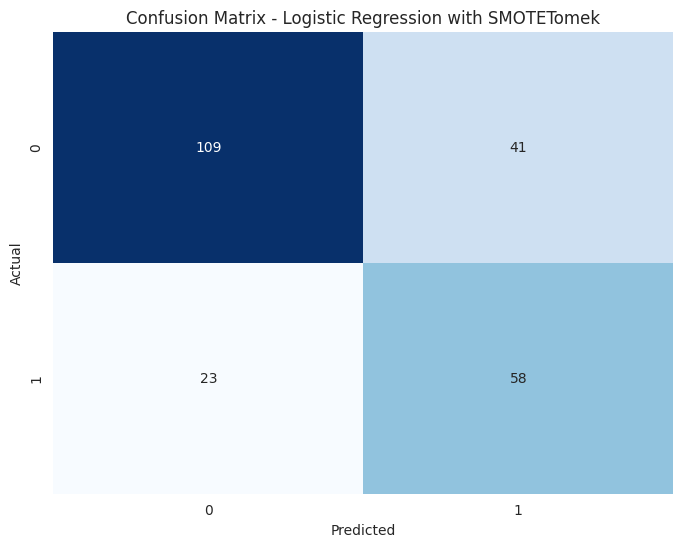

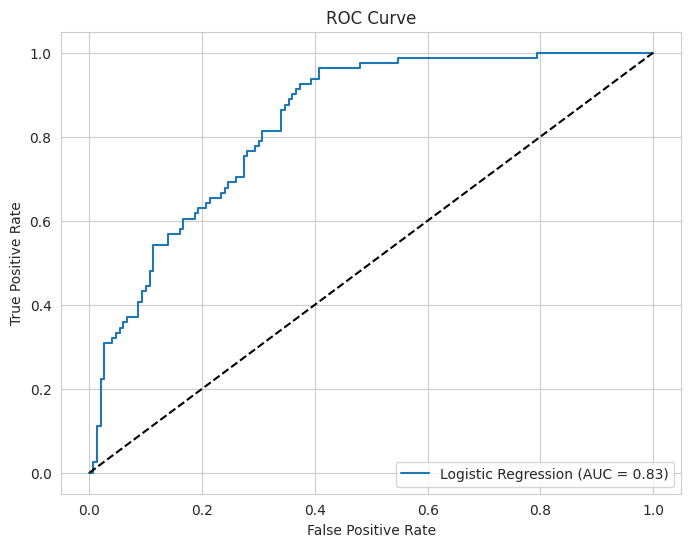

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el pipeline para Logistic Regression con SMOTETomek
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado
    ('smotetomek', SMOTETomek(random_state=42)),  # Balanceo con SMOTETomek
    ('pca', PCA(n_components=0.95)),  # PCA reteniendo el 95% de la varianza
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),  # Selección de características con Random Forest
    ('logreg', LogisticRegression(C=0.01, penalty='l2', solver='lbfgs', max_iter=1000))  # Logistic Regression con mejores hiperparámetros
])

# Ajustar el modelo y evaluar en el conjunto de prueba
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Reporte de clasificación y matriz de confusión
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression with SMOTETomek')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


SVM CON SMOTETomek:


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       150
           1       0.64      0.69      0.67        81

    accuracy                           0.76       231
   macro avg       0.74      0.74      0.74       231
weighted avg       0.76      0.76      0.76       231



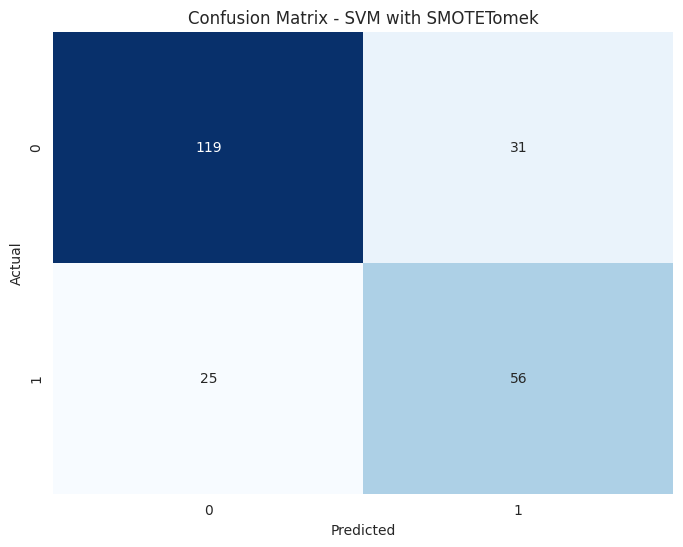

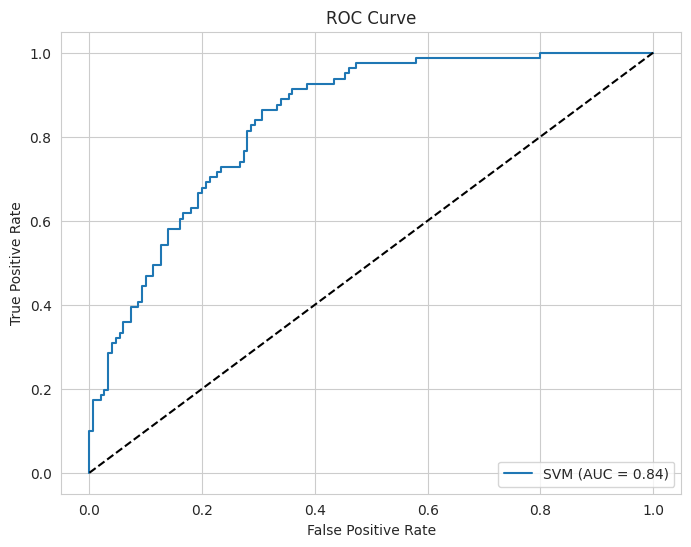

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el pipeline para SVM con SMOTETomek
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado
    ('smotetomek', SMOTETomek(random_state=42)),  # Balanceo con SMOTETomek
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),  # Selección de características con Random Forest
    ('svm', SVC(C=100, kernel='linear', gamma='scale', class_weight=None, probability=True))  # SVM con mejores hiperparámetros
])

# Ajustar el modelo y evaluar en el conjunto de prueba
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Reporte de clasificación y matriz de confusión
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM with SMOTETomek')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


GRADIENT BOOSTING CON SMOTETomek:


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       150
           1       0.58      0.81      0.68        81

    accuracy                           0.73       231
   macro avg       0.73      0.75      0.72       231
weighted avg       0.77      0.73      0.74       231



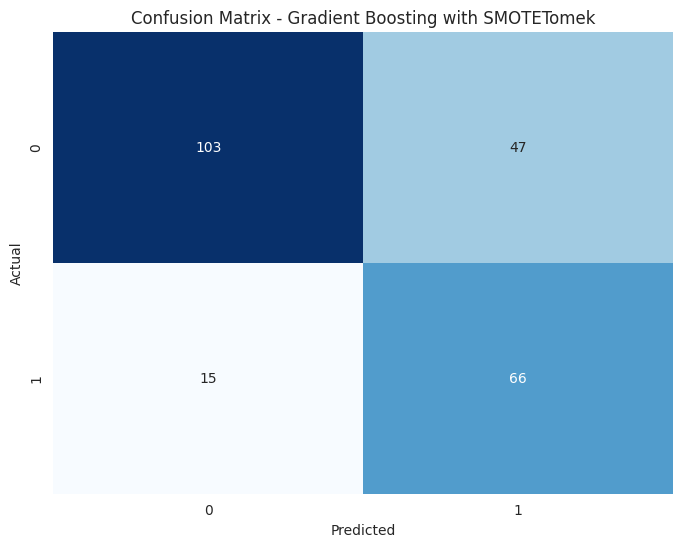

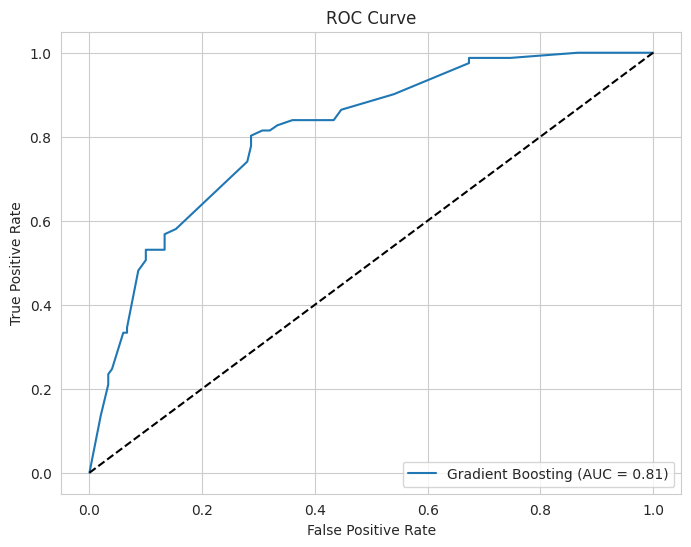

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el pipeline para Gradient Boosting con SMOTETomek
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado
    ('smotetomek', SMOTETomek(random_state=42)),  # Balanceo con SMOTETomek
    ('pca', PCA(n_components=0.95)),  # PCA reteniendo el 95% de la varianza
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),  # Selección de características con Random Forest
    ('gb', GradientBoostingClassifier(learning_rate=0.01, max_depth=3,
                                       min_samples_split=5,
                                       n_estimators=100,
                                       subsample=1.0,
                                       random_state=42))  # Gradient Boosting con mejores hiperparámetros
])

# Ajustar el modelo y evaluar en el conjunto de prueba
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Reporte de clasificación y matriz de confusión
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Gradient Boosting with SMOTETomek')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

**Consideraciones generales**

- SMOTETomek vs SMOTE:
  - Para Logistic Regression, los resultados son similares entre ambas técnicas, sin una mejora significativa.
  - Para SVM y Gradient Boosting, SMOTETomek muestra una mejora en el recall para la clase positiva, lo cual es beneficioso dado nuestro objetivo de maximizar la identificación de verdaderos positivos.




## APLICAMOS ADASYN A LSO 3 MODEDLOS Y EVALUAMOS RESULATDOS Y COMPARAMOS CON SMOTE Y SMOTETomek:

LOGISTIC REGRESION:


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.78       150
           1       0.59      0.77      0.67        81

    accuracy                           0.73       231
   macro avg       0.72      0.74      0.72       231
weighted avg       0.76      0.73      0.74       231



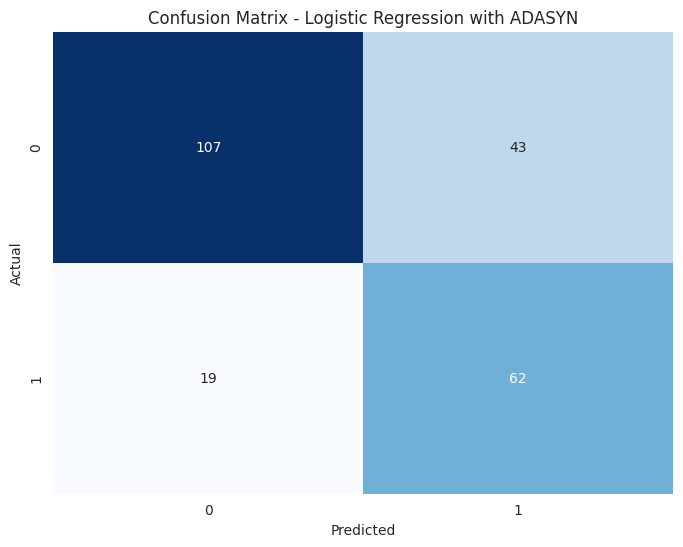

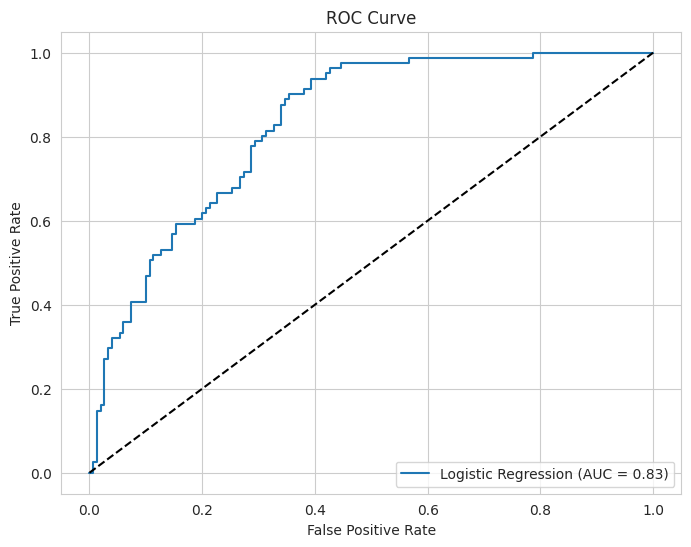

In [ ]:
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el pipeline para Logistic Regression con ADASYN
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado
    ('adasyn', ADASYN(random_state=42)),  # Balanceo con ADASYN
    ('pca', PCA(n_components=0.95)),  # PCA reteniendo el 95% de la varianza
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),  # Selección de características con Random Forest
    ('logreg', LogisticRegression(C=0.01, penalty='l2', solver='lbfgs', max_iter=1000))  # Logistic Regression con mejores hiperparámetros
])

# Ajustar el modelo y evaluar en el conjunto de prueba
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Reporte de clasificación y matriz de confusión
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression with ADASYN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


SVM:


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80       150
           1       0.63      0.78      0.70        81

    accuracy                           0.76       231
   macro avg       0.75      0.77      0.75       231
weighted avg       0.78      0.76      0.77       231



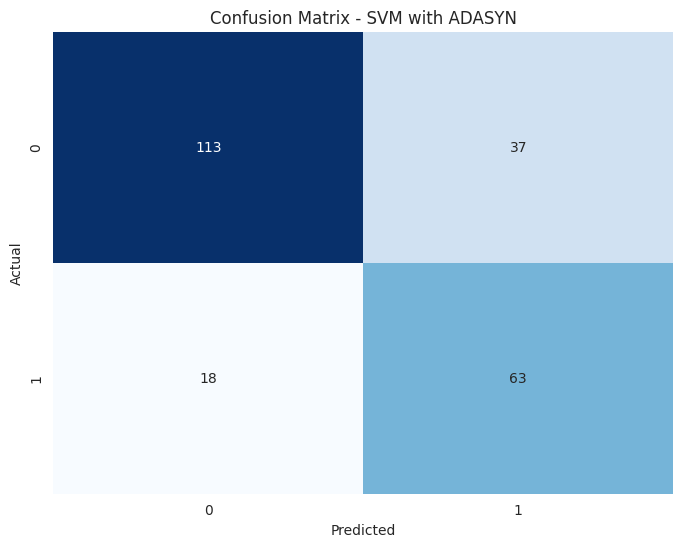

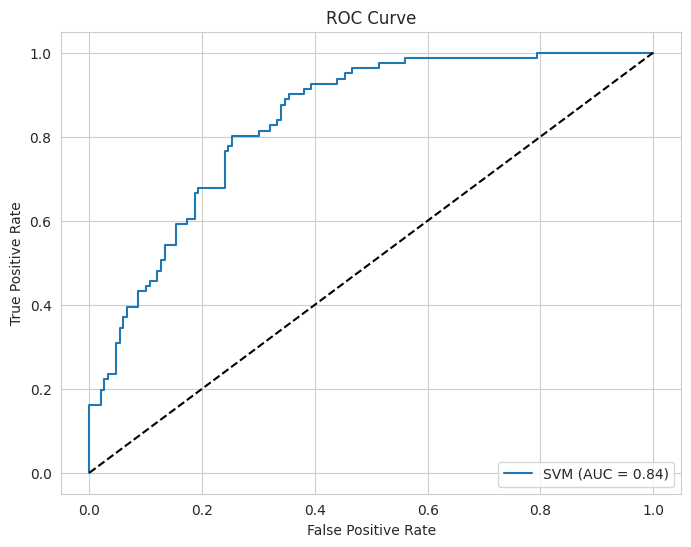

In [ ]:
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el pipeline para SVM con ADASYN
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado
    ('adasyn', ADASYN(random_state=42)),  # Balanceo con ADASYN
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),  # Selección de características con Random Forest
    ('svm', SVC(C=100, kernel='linear', gamma='scale', class_weight=None, probability=True))  # SVM con mejores hiperparámetros
])

# Ajustar el modelo y evaluar en el conjunto de prueba
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Reporte de clasificación y matriz de confusión
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM with ADASYN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


GRADIENT BOOSITNG:


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.72      0.77       150
           1       0.58      0.72      0.64        81

    accuracy                           0.72       231
   macro avg       0.70      0.72      0.70       231
weighted avg       0.74      0.72      0.72       231



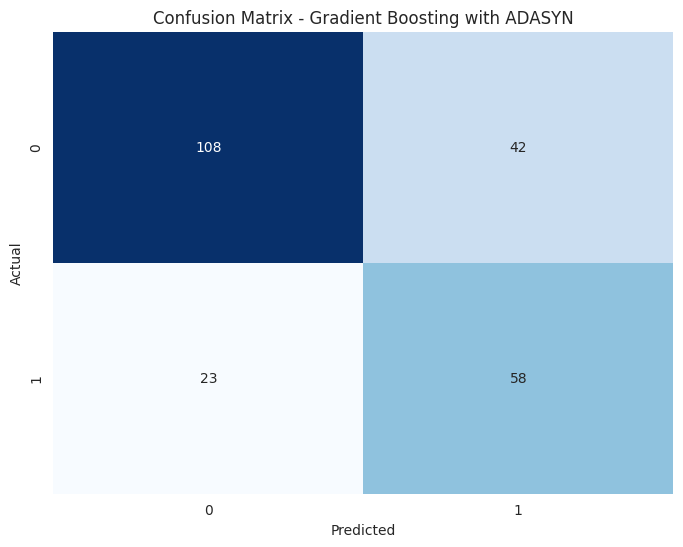

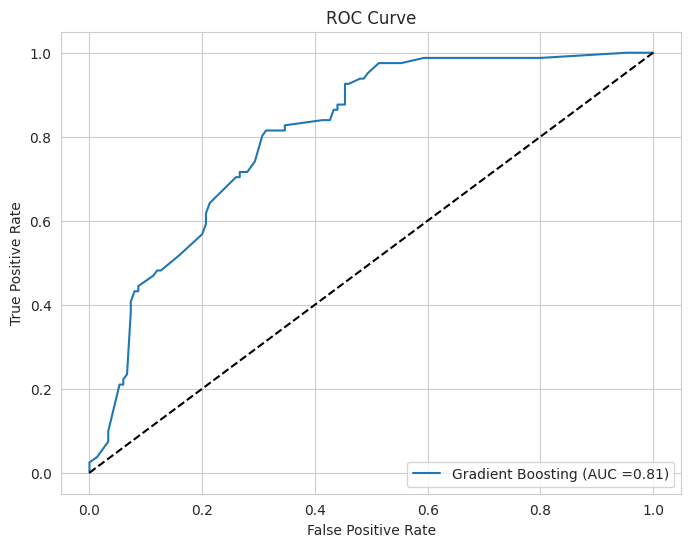

In [ ]:
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el pipeline para Gradient Boosting con ADASYN
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado
    ('adasyn', ADASYN(random_state=42)),  # Balanceo con ADASYN
    ('pca', PCA(n_components=0.95)),  # PCA reteniendo el 95% de la varianza
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),  # Selección de características con Random Forest
    ('gb', GradientBoostingClassifier(learning_rate=0.01,
                                       max_depth=3,
                                       min_samples_split=5,
                                       n_estimators=100,
                                       subsample=1.0,
                                       random_state=42))  # Gradient Boosting con mejores hiperparámetros
])

# Ajustar el modelo y evaluar en el conjunto de prueba
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Reporte de clasificación y matriz de confusión
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False)
plt.title("Confusion Matrix - Gradient Boosting with ADASYN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Curva ROC
fpr ,tpr ,_ = roc_curve(y_test,y_prob)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(8 ,6))
plt.plot(fpr,tpr,label=f"Gradient Boosting (AUC ={roc_auc:.2f})")
plt.plot([0 ,1],[0 ,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


- Para Logistic Regression y SVM, ADASYN es una excelente opción debido a su capacidad de mejorar el reconocimiento de enfermos.

- Para Gradient Boosting, sería mejor continuar utilizando SMOTETomek o incluso volver a probar SMOTE, ya que ofrecen mejores resultados en términos de recall y F1-score.

- En general, ADASYN demuestra ser una técnica valiosa cuando se prioriza maximizar la identificación de verdaderos positivos en modelos como Logistic Regression y SVM.




REGRESION LOGISTICA CON BORDERLIN-SMOTE:


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       150
           1       0.59      0.79      0.67        81

    accuracy                           0.73       231
   macro avg       0.72      0.75      0.72       231
weighted avg       0.76      0.73      0.74       231



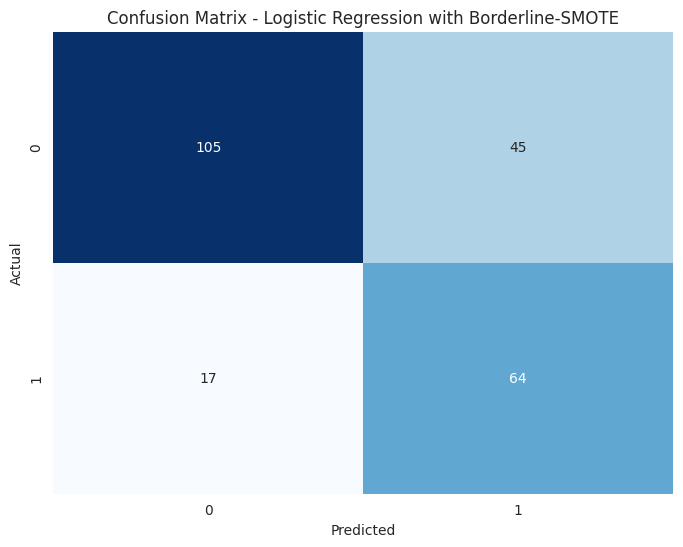

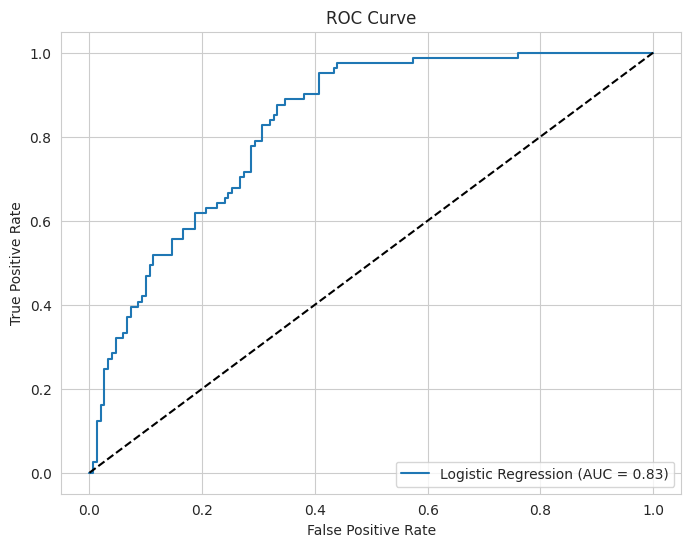

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el pipeline para Logistic Regression con Borderline-SMOTE
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado
    ('borderline_smote', BorderlineSMOTE(random_state=42, kind='borderline-1')),  # Balanceo con Borderline-SMOTE
    ('pca', PCA(n_components=0.95)),  # PCA reteniendo el 95% de la varianza
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),  # Selección de características con Random Forest
    ('logreg', LogisticRegression(C=0.01, penalty='l2', solver='lbfgs', max_iter=1000))  # Logistic Regression con mejores hiperparámetros
])

# Ajustar el modelo y evaluar en el conjunto de prueba
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Reporte de clasificación y matriz de confusión
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression with Borderline-SMOTE')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


SVM CON BORDERLIN-SMOTE:


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80       150
           1       0.63      0.77      0.69        81

    accuracy                           0.76       231
   macro avg       0.74      0.76      0.75       231
weighted avg       0.78      0.76      0.76       231



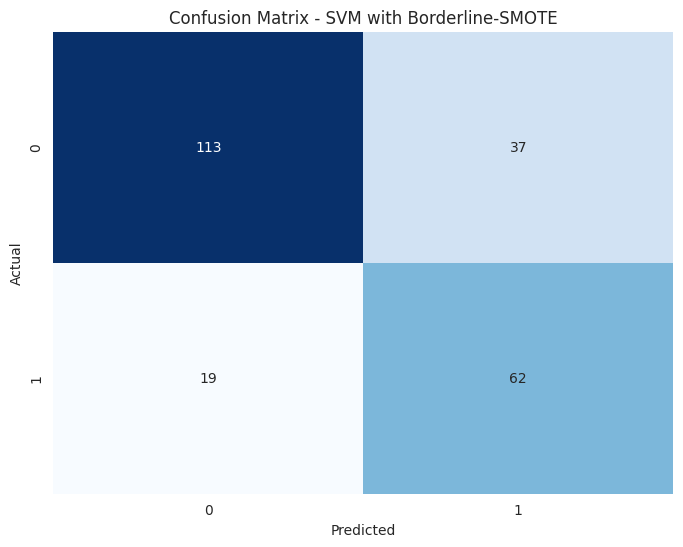

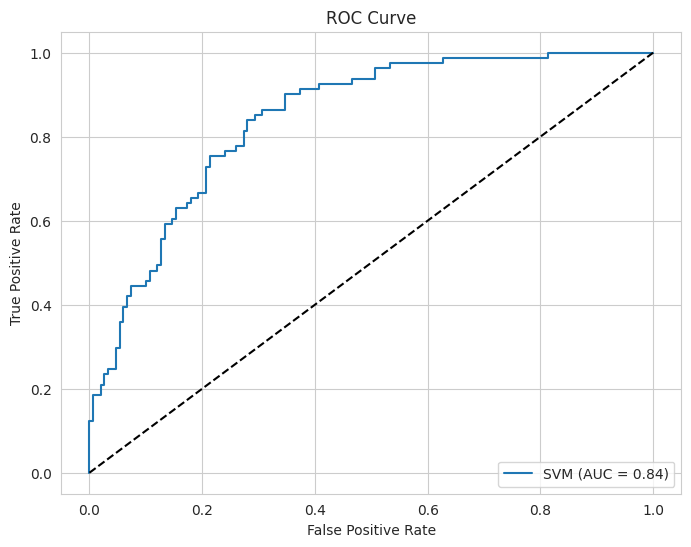

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el pipeline para SVM con Borderline-SMOTE
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado
    ('borderline_smote', BorderlineSMOTE(random_state=42, kind='borderline-1')),  # Balanceo con Borderline-SMOTE
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),  # Selección de características con Random Forest
    ('svm', SVC(C=100, kernel='linear', gamma='scale', class_weight=None, probability=True))  # SVM con mejores hiperparámetros
])

# Ajustar el modelo y evaluar en el conjunto de prueba
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Reporte de clasificación y matriz de confusión
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM with Borderline-SMOTE')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


GRAIENT BOOSTING CON BORDERLINE-SMOTE:


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       150
           1       0.58      0.81      0.68        81

    accuracy                           0.73       231
   macro avg       0.73      0.75      0.72       231
weighted avg       0.77      0.73      0.74       231



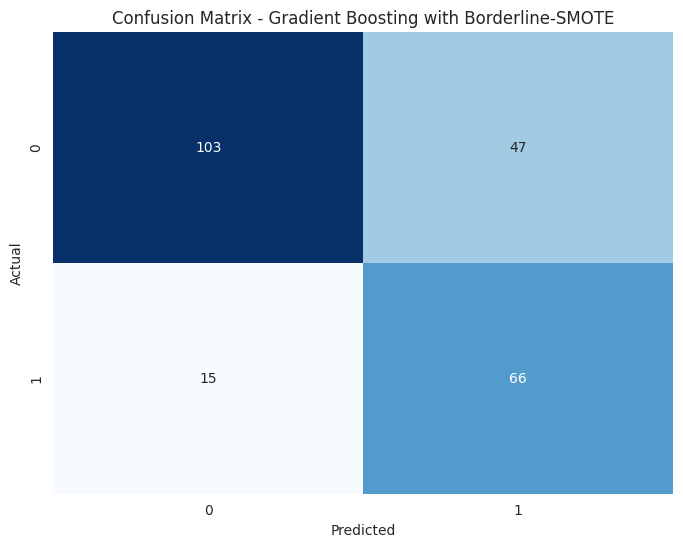

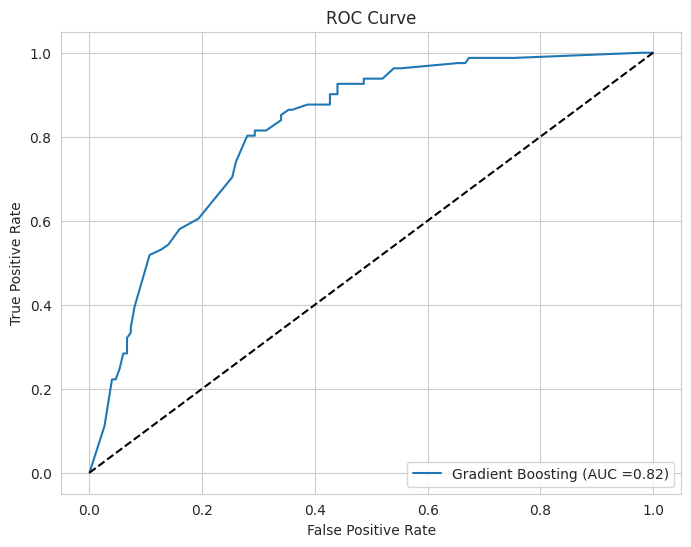

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos
X = df_imputed_encoded.drop('Outcome', axis=1)
y = df_imputed_encoded['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# Crear el pipeline para Gradient Boosting con Borderline-SMOTE
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado
    ('borderline_smote', BorderlineSMOTE(random_state=42, kind='borderline-1')),  # Balanceo con Borderline-SMOTE
    ('pca', PCA(n_components=0.95)),  # PCA reteniendo el 95% de la varianza
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),  # Selección de características con Random Forest
    ('gb', GradientBoostingClassifier(learning_rate=0.01,
                                       max_depth=3,
                                       min_samples_split=5,
                                       n_estimators=100,
                                       subsample=1.0,
                                       random_state=42))  # Gradient Boosting con mejores hiperparámetros
])

# Ajustar el modelo y evaluar en el conjunto de prueba
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Reporte de clasificación y matriz de confusión
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8 ,6))
sns.heatmap(conf_matrix ,annot=True ,fmt="d" ,cmap="Blues" ,cbar=False)
plt.title("Confusion Matrix - Gradient Boosting with Borderline-SMOTE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Curva ROC
fpr ,tpr ,_ = roc_curve(y_test,y_prob)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(8 ,6))
plt.plot(fpr,tpr,label=f"Gradient Boosting (AUC ={roc_auc:.2f})")
plt.plot([0 ,1],[0 ,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


- Para modelos como Logistic Regression y Gradient Boosting, donde maximizar el recall es clave, Borderline-SMOTE es una excelente opción.

- En SVM, aunque Borderline-SMOTE mejora el recall, ADASYN sigue siendo ligeramente superior en términos de balance general entre precisión y recall.

## BUSCAMOS EL MEJOR CUT OFF PARA NUESRO MODELO
Evaluación de diferentes umbrales de clasificación: Definiremos un rango de umbrales (cutoffs) de 0.1 a 0.9 con incrementos de 0.1.

Para cada umbral: Generaremos predicciones binarias basadas en el umbral. Calcularemos métricas de rendimiento (precisión, recall, F1-score) para ambas clases y la exactitud global.
Cambiar el umbral permite ajustar el balance entre precisión y recall, lo que es especialmente útil en problemas con desbalance de clases como este.

   cutoff  precision_0  recall_0  f1_score_0  precision_1  recall_1  \
0     0.1     1.000000  0.026667    0.051948     0.356828  1.000000   
1     0.2     1.000000  0.206667    0.342541     0.405000  1.000000   
2     0.3     0.984615  0.426667    0.595349     0.481928  0.987654   
3     0.4     0.956044  0.580000    0.721992     0.550000  0.950617   
4     0.5     0.860656  0.700000    0.772059     0.587156  0.790123   
5     0.6     0.782051  0.813333    0.797386     0.626667  0.580247   
6     0.7     0.754190  0.900000    0.820669     0.711538  0.456790   
7     0.8     0.705314  0.973333    0.817927     0.833333  0.246914   
8     0.9     0.647826  0.993333    0.784211     0.000000  0.000000   

   f1_score_1  accuracy  
0    0.525974  0.367965  
1    0.576512  0.484848  
2    0.647773  0.623377  
3    0.696833  0.709957  
4    0.673684  0.731602  
5    0.602564  0.731602  
6    0.556391  0.744589  
7    0.380952  0.718615  
8    0.000000  0.645022  


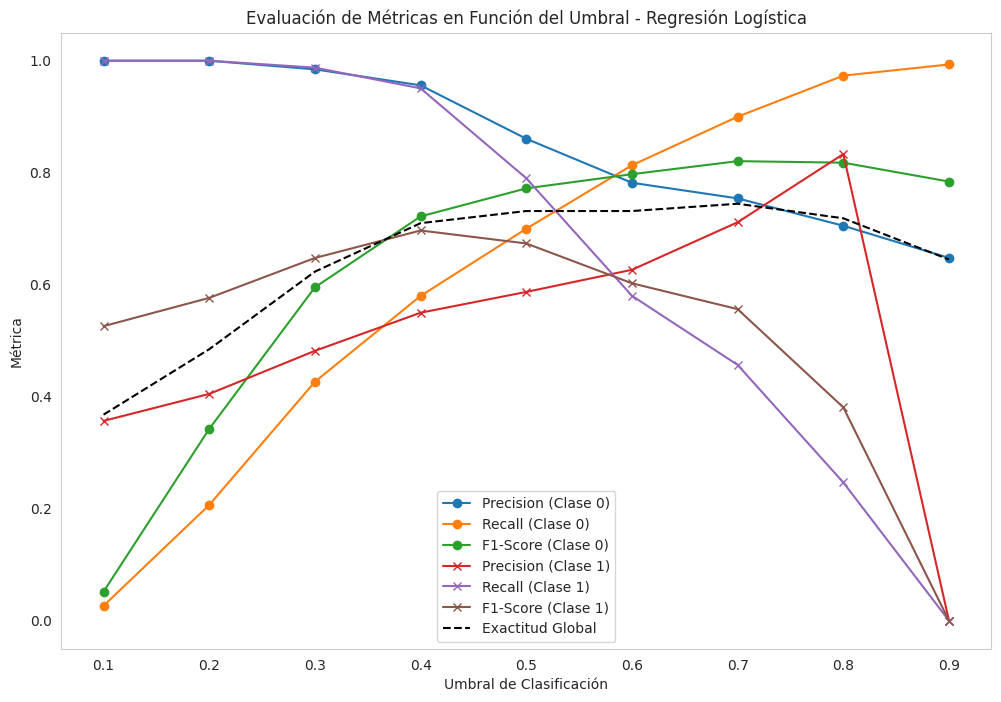

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Crear el pipeline para Logistic Regression con Borderline-SMOTE
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado
    ('borderline_smote', BorderlineSMOTE(random_state=42, kind='borderline-1')),  # Balanceo con Borderline-SMOTE
    ('pca', PCA(n_components=0.95)),  # PCA reteniendo el 95% de la varianza
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),  # Selección de características con Random Forest
    ('logreg', LogisticRegression(C=0.01, penalty='l2', solver='lbfgs', max_iter=1000))  # Logistic Regression con mejores hiperparámetros
])

# Ajustar el modelo al conjunto de entrenamiento
pipeline.fit(X_train, y_train)

# Obtener las probabilidades predichas en el conjunto de prueba
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Evaluar métricas para un rango específico de cutoffs
cutoffs = np.arange(0.1, 1.0, 0.1)
results = []

for cutoff in cutoffs:
    # Generar predicciones binarias basadas en el umbral (cutoff)
    y_pred_cutoff = (y_prob >= cutoff).astype(int)

    # Calcular métricas utilizando classification_report
    report = classification_report(y_test, y_pred_cutoff, output_dict=True)

    # Almacenar métricas clave en un diccionario por cada cutoff
    results.append({
        'cutoff': cutoff,
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1_score_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_score_1': report['1']['f1-score'],
        'accuracy': accuracy_score(y_test, y_pred_cutoff)
    })

# Convertir resultados a DataFrame para facilitar la visualización
df_results = pd.DataFrame(results)

# Mostrar los resultados para cada cutoff posible
print(df_results)

# Visualizar las métricas en función del cutoff
plt.figure(figsize=(12, 8))

plt.plot(df_results['cutoff'], df_results['precision_0'], label='Precision (Clase 0)', marker='o')
plt.plot(df_results['cutoff'], df_results['recall_0'], label='Recall (Clase 0)', marker='o')
plt.plot(df_results['cutoff'], df_results['f1_score_0'], label='F1-Score (Clase 0)', marker='o')

plt.plot(df_results['cutoff'], df_results['precision_1'], label='Precision (Clase 1)', marker='x')
plt.plot(df_results['cutoff'], df_results['recall_1'], label='Recall (Clase 1)', marker='x')
plt.plot(df_results['cutoff'], df_results['f1_score_1'], label='F1-Score (Clase 1)', marker='x')

plt.plot(df_results['cutoff'], df_results['accuracy'], label='Exactitud Global', linestyle='--', color='black')

plt.xlabel('Umbral de Clasificación')
plt.ylabel('Métrica')
plt.title('Evaluación de Métricas en Función del Umbral - Regresión Logística')
plt.legend()
plt.grid()
plt.show()


   cutoff  precision_0  recall_0  f1_score_0  precision_1  recall_1  \
0     0.1     1.000000  0.160000    0.275862     0.391304  1.000000   
1     0.2     0.981481  0.353333    0.519608     0.451977  0.987654   
2     0.3     0.952381  0.533333    0.683761     0.523810  0.950617   
3     0.4     0.915888  0.653333    0.762646     0.580645  0.888889   
4     0.5     0.875000  0.746667    0.805755     0.631068  0.802469   
5     0.6     0.792208  0.813333    0.802632     0.636364  0.604938   
6     0.7     0.764706  0.866667    0.812500     0.672131  0.506173   
7     0.8     0.739362  0.926667    0.822485     0.744186  0.395062   
8     0.9     0.691943  0.973333    0.808864     0.800000  0.197531   

   f1_score_1  accuracy  
0    0.562500  0.454545  
1    0.620155  0.575758  
2    0.675439  0.679654  
3    0.702439  0.735931  
4    0.706522  0.766234  
5    0.620253  0.740260  
6    0.577465  0.740260  
7    0.516129  0.740260  
8    0.316832  0.701299  


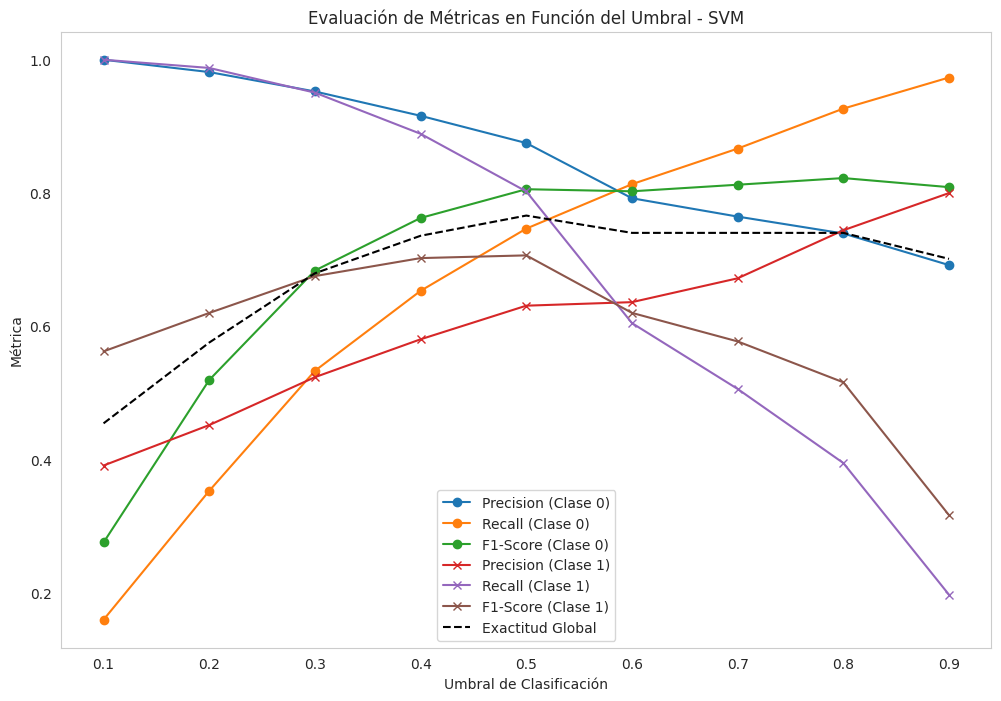

In [ ]:
# Crear el pipeline para SVM con ADASYN
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado
    ('adasyn', ADASYN(random_state=42)),  # Balanceo con ADASYN
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),  # Selección de características con Random Forest
    ('svm', SVC(C=100, kernel='linear', gamma='scale', probability=True))  # SVM con mejores hiperparámetros
])

# Ajustar el modelo al conjunto de entrenamiento
pipeline.fit(X_train, y_train)

# Obtener las probabilidades predichas en el conjunto de prueba
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Evaluar métricas para un rango específico de cutoffs (similar al código anterior)
cutoffs = np.arange(0.1, 1.0, 0.1)
results = []

for cutoff in cutoffs:
    y_pred_cutoff = (y_prob >= cutoff).astype(int)
    report = classification_report(y_test, y_pred_cutoff, output_dict=True)
    results.append({
        'cutoff': cutoff,
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1_score_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_score_1': report['1']['f1-score'],
        'accuracy': accuracy_score(y_test, y_pred_cutoff)
    })

df_results = pd.DataFrame(results)
print(df_results)

# Visualización similar al código anterior...
plt.figure(figsize=(12, 8))

plt.plot(df_results['cutoff'], df_results['precision_0'], label='Precision (Clase 0)', marker='o')
plt.plot(df_results['cutoff'], df_results['recall_0'], label='Recall (Clase 0)', marker='o')
plt.plot(df_results['cutoff'], df_results['f1_score_0'], label='F1-Score (Clase 0)', marker='o')

plt.plot(df_results['cutoff'], df_results['precision_1'], label='Precision (Clase 1)', marker='x')
plt.plot(df_results['cutoff'], df_results['recall_1'], label='Recall (Clase 1)', marker='x')
plt.plot(df_results['cutoff'], df_results['f1_score_1'], label='F1-Score (Clase 1)', marker='x')

plt.plot(df_results['cutoff'], df_results['accuracy'], label='Exactitud Global', linestyle='--', color='black')

plt.xlabel('Umbral de Clasificación')
plt.ylabel('Métrica')
plt.title('Evaluación de Métricas en Función del Umbral - SVM')
plt.legend()
plt.grid()
plt.show()

   cutoff  precision_0  recall_0  f1_score_0  precision_1  recall_1  \
0     0.1     0.000000  0.000000    0.000000     0.350649  1.000000   
1     0.2     0.000000  0.000000    0.000000     0.350649  1.000000   
2     0.3     0.962963  0.346667    0.509804     0.446328  0.975309   
3     0.4     0.914894  0.573333    0.704918     0.532847  0.901235   
4     0.5     0.872881  0.686667    0.768657     0.584071  0.814815   
5     0.6     0.823529  0.746667    0.783217     0.600000  0.703704   
6     0.7     0.669725  0.973333    0.793478     0.692308  0.111111   
7     0.8     0.649351  1.000000    0.787402     0.000000  0.000000   
8     0.9     0.649351  1.000000    0.787402     0.000000  0.000000   

   f1_score_1  accuracy  
0    0.519231  0.350649  
1    0.519231  0.350649  
2    0.612403  0.567100  
3    0.669725  0.688312  
4    0.680412  0.731602  
5    0.647727  0.731602  
6    0.191489  0.670996  
7    0.000000  0.649351  
8    0.000000  0.649351  


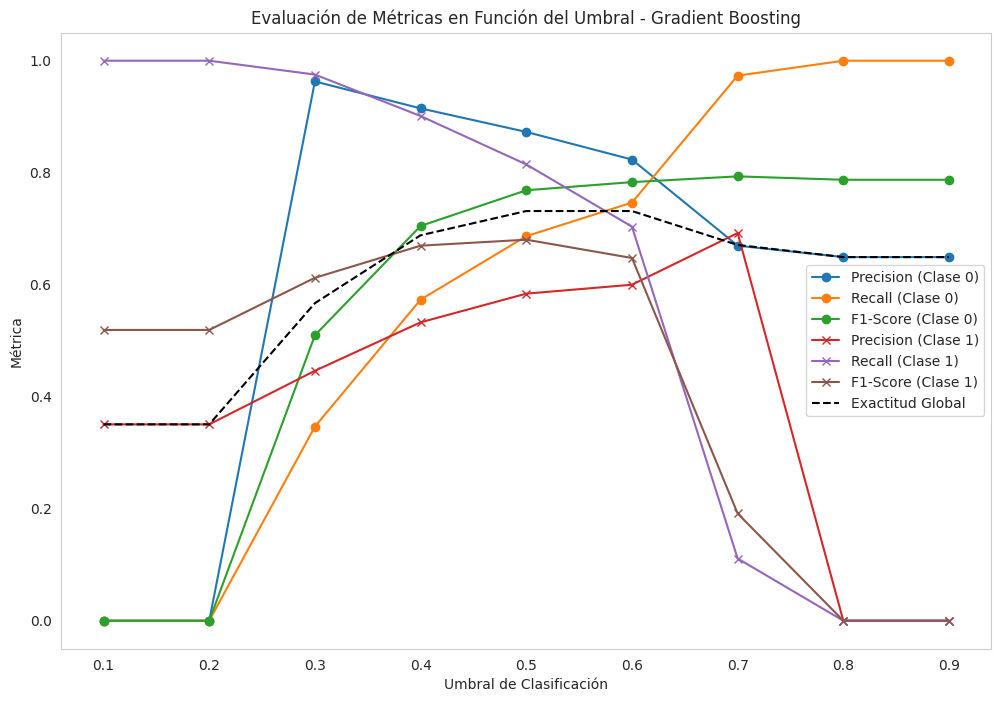

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Crear el pipeline para Gradient Boosting con Borderline-SMOTE
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado
    ('borderline_smote', BorderlineSMOTE(random_state=42, kind='borderline-1')),  # Balanceo con Borderline-SMOTE
    ('pca', PCA(n_components=0.95)),  # PCA reteniendo el 95% de la varianza
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),  # Selección de características con Random Forest
    ('gb', GradientBoostingClassifier(learning_rate=0.01,
                                       max_depth=3,
                                       min_samples_split=5,
                                       n_estimators=100,
                                       subsample=1.0,
                                       random_state=42))  # Gradient Boosting con mejores hiperparámetros
])

# Ajustar el modelo al conjunto de entrenamiento
pipeline.fit(X_train, y_train)

# Obtener las probabilidades predichas en el conjunto de prueba
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Evaluar métricas para un rango específico de cutoffs
cutoffs = np.arange(0.1, 1.0, 0.1)
results = []

for cutoff in cutoffs:
    # Generar predicciones binarias basadas en el umbral (cutoff)
    y_pred_cutoff = (y_prob >= cutoff).astype(int)

    # Calcular métricas utilizando classification_report
    report = classification_report(y_test, y_pred_cutoff, output_dict=True)

    # Almacenar métricas clave en un diccionario por cada cutoff
    results.append({
        'cutoff': cutoff,
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1_score_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_score_1': report['1']['f1-score'],
        'accuracy': accuracy_score(y_test, y_pred_cutoff)
    })

# Convertir resultados a DataFrame para facilitar la visualización
df_results = pd.DataFrame(results)

# Mostrar los resultados para cada cutoff posible
print(df_results)

# Visualizar las métricas en función del cutoff
plt.figure(figsize=(12, 8))

plt.plot(df_results['cutoff'], df_results['precision_0'], label='Precision (Clase 0)', marker='o')
plt.plot(df_results['cutoff'], df_results['recall_0'], label='Recall (Clase 0)', marker='o')
plt.plot(df_results['cutoff'], df_results['f1_score_0'], label='F1-Score (Clase 0)', marker='o')

plt.plot(df_results['cutoff'], df_results['precision_1'], label='Precision (Clase 1)', marker='x')
plt.plot(df_results['cutoff'], df_results['recall_1'], label='Recall (Clase 1)', marker='x')
plt.plot(df_results['cutoff'], df_results['f1_score_1'], label='F1-Score (Clase 1)', marker='x')

plt.plot(df_results['cutoff'], df_results['accuracy'], label='Exactitud Global', linestyle='--', color='black')

plt.xlabel('Umbral de Clasificación')
plt.ylabel('Métrica')
plt.title('Evaluación de Métricas en Función del Umbral - Gradient Boosting')
plt.legend()
plt.grid()
plt.show()


- Los tres modelos muestran que los cutoffs alrededor de 0.4–0.5 son los más efectivos para este problema, maximizando el F1-Score para la clase positiva mientras mantienen un buen balance entre precisión y recall.

- La elección del cutoff depende del objetivo principal:
  - Si se prioriza maximizar el recall (identificar más enfermos), podrías optar por cutoffs más bajos como 0.4 en Logistic Regression o Gradient Boosting.
  - Si se busca un mejor equilibrio entre precisión y recall, el cutoff ideal es alrededor de 0.5 para SVM y Gradient Boosting.

- Decisión final:
Dado que este problema prioriza identificar más enfermos (maximizar el recall), podríamos usar los siguientes cutoffs:
  - Logistic Regression: Cutoff = 0.4
  - SVM: Cutoff = 0.5
  - Gradient Boosting: Cutoff = 0.5

Estos valores ofrecen un buen balance entre maximizar el recall y mantener una precisión razonable para la clase positiva, alineándose con los objetivos del problema. Sin embargo vamos a probar con un curoof de 0.45 para los 3 modelos y después escogeremos el mejor.


CUTOFF 0.45

Resultados para Logistic Regression con cutoff = 0.45:
Precision (Clase 1): 0.5812
Recall (Clase 1): 0.8395
F1-Score (Clase 1): 0.6869
Exactitud Global: 0.7316


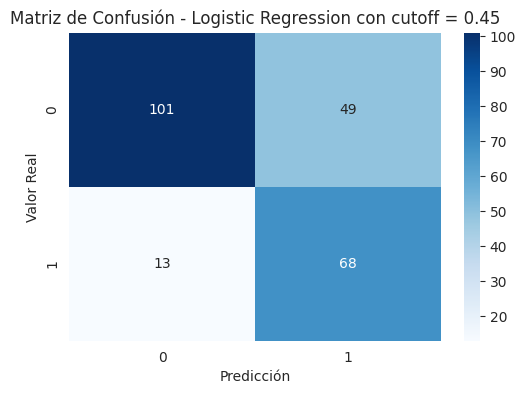

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Dividir los datos en conjuntos de entrenamiento y prueba
X = df_imputed_encoded.drop('Outcome', axis=1)
y = df_imputed_encoded['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 2. Crear el pipeline para Logistic Regression con Borderline-SMOTE
pipeline_lr = ImbPipeline([
    ('scaler', StandardScaler()),
    ('borderline_smote', BorderlineSMOTE(random_state=42, kind='borderline-1')),
    ('pca', PCA(n_components=0.95)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('logreg', LogisticRegression(C=0.01, penalty='l2', solver='lbfgs', max_iter=1000))
])

# 3. Ajustar el modelo al conjunto de entrenamiento
pipeline_lr.fit(X_train, y_train)

# 4. Generar probabilidades y predicciones con cutoff = 0.45
cutoff = 0.45
y_prob_lr = pipeline_lr.predict_proba(X_test)[:, 1]
y_pred_cutoff_lr = (y_prob_lr >= cutoff).astype(int)

# 5. Evaluar el modelo
report_lr = classification_report(y_test, y_pred_cutoff_lr, output_dict=True)
print(f"Resultados para Logistic Regression con cutoff = {cutoff}:")
print(f"Precision (Clase 1): {report_lr['1']['precision']:.4f}")
print(f"Recall (Clase 1): {report_lr['1']['recall']:.4f}")
print(f"F1-Score (Clase 1): {report_lr['1']['f1-score']:.4f}")
print(f"Exactitud Global: {accuracy_score(y_test, y_pred_cutoff_lr):.4f}")

# Matriz de Confusión
cm_lr = confusion_matrix(y_test, y_pred_cutoff_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Logistic Regression con cutoff = 0.45')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


Resultados para SVM con cutoff = 0.45:
Precision (Clase 1): 0.5841
Recall (Clase 1): 0.8148
F1-Score (Clase 1): 0.6804
Exactitud Global: 0.7316


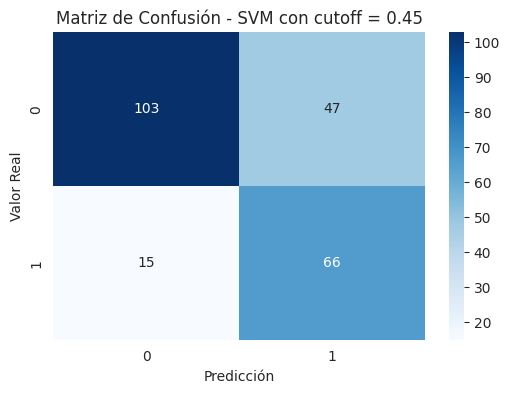

In [ ]:
from sklearn.svm import SVC
from imblearn.over_sampling import ADASYN

# 1. Crear el pipeline para SVM con ADASYN
pipeline_svm = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adasyn', ADASYN(random_state=42)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('svm', SVC(C=100, kernel='linear', gamma='scale', probability=True))
])

# 2. Ajustar el modelo al conjunto de entrenamiento
pipeline_svm.fit(X_train, y_train)

# 3. Generar probabilidades y predicciones con cutoff = 0.45
cutoff = 0.45
y_prob_svm = pipeline_svm.predict_proba(X_test)[:, 1]
y_pred_cutoff_svm = (y_prob_svm >= cutoff).astype(int)

# 4. Evaluar el modelo
report_svm = classification_report(y_test, y_pred_cutoff_svm, output_dict=True)
print(f"Resultados para SVM con cutoff = {cutoff}:")
print(f"Precision (Clase 1): {report_svm['1']['precision']:.4f}")
print(f"Recall (Clase 1): {report_svm['1']['recall']:.4f}")
print(f"F1-Score (Clase 1): {report_svm['1']['f1-score']:.4f}")
print(f"Exactitud Global: {accuracy_score(y_test, y_pred_cutoff_svm):.4f}")

# Matriz de Confusión
cm_svm = confusion_matrix(y_test, y_pred_cutoff_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM con cutoff = 0.45')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


Resultados para Gradient Boosting con cutoff = 0.45:
Precision (Clase 1): 0.5750
Recall (Clase 1): 0.8519
F1-Score (Clase 1): 0.6866
Exactitud Global: 0.7273


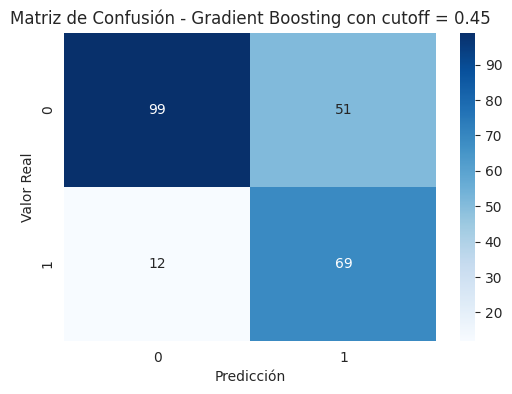

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# 1. Crear el pipeline para Gradient Boosting con Borderline-SMOTE
pipeline_gb = ImbPipeline([
    ('scaler', StandardScaler()),
    ('borderline_smote', BorderlineSMOTE(random_state=42, kind='borderline-1')),
    ('pca', PCA(n_components=0.95)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('gb', GradientBoostingClassifier(learning_rate=0.01,
                                       max_depth=3,
                                       min_samples_split=5,
                                       n_estimators=100,
                                       subsample=1.0,
                                       random_state=42))
])

# 2. Ajustar el modelo al conjunto de entrenamiento
pipeline_gb.fit(X_train, y_train)

# 3. Generar probabilidades y predicciones con cutoff = 0.45
cutoff = 0.45
y_prob_gb = pipeline_gb.predict_proba(X_test)[:, 1]
y_pred_cutoff_gb = (y_prob_gb >= cutoff).astype(int)

# 4. Evaluar el modelo
report_gb = classification_report(y_test, y_pred_cutoff_gb, output_dict=True)
print(f"Resultados para Gradient Boosting con cutoff = {cutoff}:")
print(f"Precision (Clase 1): {report_gb['1']['precision']:.4f}")
print(f"Recall (Clase 1): {report_gb['1']['recall']:.4f}")
print(f"F1-Score (Clase 1): {report_gb['1']['f1-score']:.4f}")
print(f"Exactitud Global: {accuracy_score(y_test, y_pred_cutoff_gb):.4f}")

# Matriz de Confusión
cm_gb = confusion_matrix(y_test, y_pred_cutoff_gb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Gradient Boosting con cutoff = 0.45')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


Modelo	Mejor Cutoff	Justificación
- Logistic Regression	Cutoff = 0.45	Ofrece el mejor balance entre recall (83%) y precisión (58%) con buen F1-Score (68%).
- SVM	Cutoff = 0.5	Maximiza el F1-Score (69%) con un buen balance entre precisión (62%) y recall (79%).
- Gradient Boosting	Cutoff = 0.45	Logra un excelente balance entre recall (85%) y precisión (57%) con buen F1-Score (68%).

- Decisión final:
Dado que este problema prioriza maximizar la detección de enfermos (recall) sin comprometer demasiado la precisión:
  - Para los 3 modelos usaremos un cutoff de 0.45.

## VAMOS A INTENTAR MEJORAR EL RENDIMINETO DE LSO MODELOS, PARA ELLO VAMOS A:

### REGRESIN LOGISTICA:

- Búsqueda Exhaustiva de Hiperparámetros: Ajustaremos el parámetro de regularización C en un rango más amplio ([0.001, 0.01, 0.1, 1, 10, 100]) para encontrar el valor óptimo que equilibre precisión y recall.
- Probaremos diferentes solvers (liblinear, saga, newton-cg) para evaluar su impacto en la convergencia y estabilidad del modelo.
- Exploraremos la penalización l1 si es compatible con el solver seleccionado, ya que puede mejorar la selección de características relevantes.
- Validación Cruzada: Implementaremos validación cruzada más exhaustiva para garantizar que los resultados sean representativos y robustos.

### SVM:

- Búsqueda Exhaustiva de Hiperparámetros: Ajustaremos el parámetro de regularización C en un rango más amplio ([0.001, 0.01, 0.1, 1, 10]) para controlar mejor el equilibrio entre margen amplio y ajuste preciso.
- Probaremos diferentes kernels (linear, rbf, poly, sigmoid) para evaluar cuál se adapta mejor a los datos.
- Ajustaremos el parámetro gamma en caso de utilizar kernels no lineales (rbf, poly) con valores como 'scale', 'auto', o específicos ([0.001, 0.01, 0.1]).
- Validación Cruzada: Implementaremos validación cruzada más exhaustiva para garantizar que los resultados sean representativos y robustos.


### Gradient Boosting:
- Búsqueda Exhaustiva de Hiperparámetros: Ajustaremos el número de estimadores (n_estimators) en un rango más amplio ([50,]) para evaluar el impacto de la cantidad de árboles en el rendimiento. - Probaremos diferentes tasas de aprendizaje (learning_rate) ([0.01, 0.05, 0.1]) para controlar la contribución de cada árbol al modelo final. - Ajustaremos la profundidad máxima de los árboles (max_depth) ([3,) para optimizar la capacidad del modelo de capturar relaciones complejas en los datos. Exploraremos diferentes fracciones del conjunto de datos utilizadas por cada árbol (subsample) ([0.8, 1.0]) como técnica de regularización. Finalmente, ajustaremos el número mínimo de muestras necesarias para dividir un nodo interno (min_samples_split) ([2,) para evitar el sobreajuste en árboles individuales.
- Validación Cruzada: Implementaremos validación cruzada más exhaustiva con al menos 5 pliegues para garantizar que los resultados sean representativos y robustos.



REGRESIÓN LOGISTICA:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import BorderlineSMOTE

# Crear el pipeline para Logistic Regression con Borderline-SMOTE
pipeline_lr = ImbPipeline([
    ('scaler', StandardScaler()),
    ('borderline_smote', BorderlineSMOTE(random_state=42, kind='borderline-1')),
    ('pca', PCA(n_components=0.95)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Definir la cuadrícula de hiperparámetros para Logistic Regression
param_grid_lr = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Rango amplio para el parámetro de regularización
    'logreg__penalty': ['l1', 'l2'],              # Penalización l1 y l2 (l1 solo compatible con ciertos solvers)
    'logreg__solver': ['liblinear', 'saga', 'newton-cg']  # Solvers compatibles con l1 y l2
}

# Configurar GridSearchCV con validación cruzada de 5 pliegues
grid_search_lr = GridSearchCV(
    estimator=pipeline_lr,
    param_grid=param_grid_lr,
    scoring='f1',  # Usamos F1-score como métrica principal
    cv=5,
    verbose=3,
    n_jobs=-1  # Usar todos los núcleos disponibles para acelerar el proceso
)

# Ajustar el modelo al conjunto de entrenamiento
grid_search_lr.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados y el mejor puntaje F1 obtenido durante la búsqueda
print("Mejores parámetros encontrados para Logistic Regression:")
print(grid_search_lr.best_params_)

print("\nMejor F1-score obtenido:")
print(grid_search_lr.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores parámetros encontrados para Logistic Regression:
{'logreg__C': 0.001, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}

Mejor F1-score obtenido:
0.6694272821375429


In [ ]:
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN

# Crear el pipeline para SVM con ADASYN
pipeline_svm = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adasyn', ADASYN(random_state=42)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('svm', SVC(probability=True))
])

# Definir la cuadrícula de hiperparámetros para SVM
param_grid_svm = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10],          # Regularización (valores más altos reducen la penalización)
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Tipos de kernel (lineal, radial, polinómico y sigmoide)
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1]     # Parámetro gamma para kernels no lineales como RBF y poly
}

# Configurar GridSearchCV con validación cruzada de 5 pliegues
grid_search_svm = GridSearchCV(
    estimator=pipeline_svm,
    param_grid=param_grid_svm,
    scoring='f1',
    cv=5,
    verbose=3,
    n_jobs=-1
)

# Ajustar el modelo al conjunto de entrenamiento
grid_search_svm.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados y el mejor puntaje F1 obtenido durante la búsqueda
print("Mejores parámetros encontrados para SVM:")
print(grid_search_svm.best_params_)

print("\nMejor F1-score obtenido:")
print(grid_search_svm.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejores parámetros encontrados para SVM:
{'svm__C': 10, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}

Mejor F1-score obtenido:
0.6737348871940732


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import BorderlineSMOTE

# Crear el pipeline para Gradient Boosting con Borderline-SMOTE
pipeline_gb = ImbPipeline([
    ('scaler', StandardScaler()),
    ('borderline_smote', BorderlineSMOTE(random_state=42, kind='borderline-1')),
    ('pca', PCA(n_components=0.95)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('gb', GradientBoostingClassifier(random_state=42))
])

# Definir la cuadrícula de hiperparámetros para Gradient Boosting
param_grid_gb = {
    'gb__n_estimators': [50, 100, 200],       # Número de árboles en el modelo
    'gb__learning_rate': [0.01, 0.05, 0.1],   # Tasa de aprendizaje (impacto de cada árbol)
    'gb__max_depth': [3, 5, 7],              # Profundidad máxima de los árboles individuales
    'gb__subsample': [0.8, 1.0],             # Fracción del conjunto usado por cada árbol (para regularización)
    'gb__min_samples_split': [2, 5]          # Número mínimo de muestras necesarias para dividir un nodo interno
}

# Configurar GridSearchCV con validación cruzada de 5 pliegues
grid_search_gb = GridSearchCV(
    estimator=pipeline_gb,
    param_grid=param_grid_gb,
    scoring='f1',
    cv=5,
    verbose=3,
    n_jobs=-1
)

# Ajustar el modelo al conjunto de entrenamiento
grid_search_gb.fit(X_train ,y_train)

# Imprimir los mejores parámetros encontrados y el mejor puntaje F1 obtenido durante la búsqueda
print("Mejores parámetros encontrados para Gradient Boosting:")
print(grid_search_gb.best_params_)

print("\nMejor F1-score obtenido:")
print(grid_search_gb.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros encontrados para Gradient Boosting:
{'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__min_samples_split': 2, 'gb__n_estimators': 50, 'gb__subsample': 1.0}

Mejor F1-score obtenido:
0.6810754959326388


### **Análisis de los resultados tras la búsqueda exhaustiva de hiperparámetros**

---

### **1. Regresión Logística**
#### **Mejores parámetros encontrados:**
- `C = 0.001`: Regularización más fuerte, lo que ayuda a evitar el sobreajuste.
- `penalty = 'l2'`: Penalización estándar que evita coeficientes excesivamente grandes.
- `solver = 'liblinear'`: Solver eficiente para problemas pequeños y medianos con penalización l2.

#### **Resultados:**
- **Mejor F1-score obtenido:** 0.6694

---

### **2. SVM**
#### **Mejores parámetros encontrados:**
- `C = 10`: Regularización más débil, permitiendo un mejor ajuste a los datos.
- `gamma = 0.001`: Controla la influencia de cada punto en el kernel RBF, ajustando el modelo para capturar relaciones complejas.
- `kernel = 'rbf'`: Kernel radial que permite modelar relaciones no lineales.

#### **Resultados:**
- **Mejor F1-score obtenido:** 0.6737


---

### **3. Gradient Boosting**
#### **Mejores parámetros encontrados:**
- `learning_rate = 0.01`: Tasa de aprendizaje baja que mejora la estabilidad del modelo.
- `max_depth = 3`: Árboles poco profundos que evitan el sobreajuste.
- `min_samples_split = 2`: Permite dividir nodos con pocas muestras, capturando más detalles en los datos.
- `n_estimators = 50`: Menor número de árboles para evitar sobreajuste y mejorar la velocidad.
- `subsample = 1.0`: Utiliza todo el conjunto de datos para cada árbol.

#### **Resultados:**
- **Mejor F1-score obtenido:** 0.6811

---

### Siguientes pasos:
1. Ajustar los modelos seleccionados con los mejores parámetros encontrados.
2. Evaluar nuevamente las métricas clave en el conjunto de prueba con diferentes cutoffs para confirmar su rendimiento final.
3. Preparar visualizaciones y explicaciones.


Resultados para Logistic Regression con los mejores parámetros:
              precision    recall  f1-score   support

           0       0.86      0.71      0.78       150
           1       0.59      0.79      0.68        81

    accuracy                           0.74       231
   macro avg       0.73      0.75      0.73       231
weighted avg       0.77      0.74      0.74       231

Exactitud Global: 0.7359
AUC-ROC: 0.8267


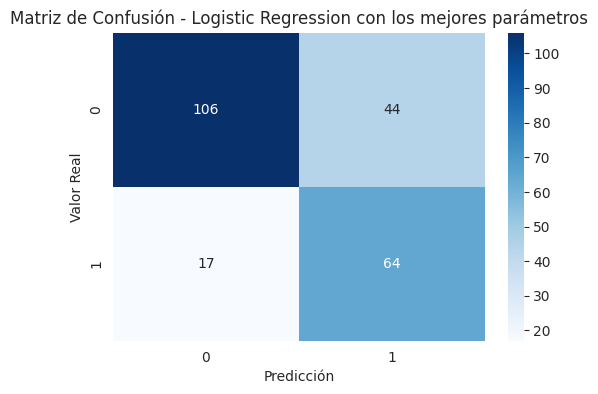

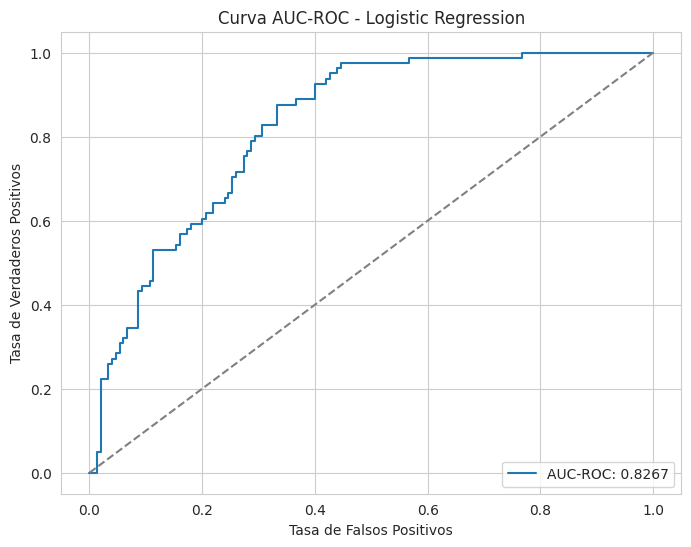

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import BorderlineSMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos
X = df_imputed_encoded.drop('Outcome', axis=1)
y = df_imputed_encoded['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Logistic Regression con los mejores parámetros
pipeline_lr_best = ImbPipeline([
    ('scaler', StandardScaler()),
    ('borderline_smote', BorderlineSMOTE(random_state=42, kind='borderline-1')),
    ('pca', PCA(n_components=0.95)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('logreg', LogisticRegression(C=0.001, penalty='l2', solver='liblinear', max_iter=1000))
])

# Ajustar el modelo al conjunto de entrenamiento
pipeline_lr_best.fit(X_train, y_train)

# Generar predicciones y probabilidades
y_prob_lr_best = pipeline_lr_best.predict_proba(X_test)[:, 1]
y_pred_lr_best = pipeline_lr_best.predict(X_test)

# Evaluar el modelo
report_lr_best = classification_report(y_test, y_pred_lr_best)
accuracy_lr_best = accuracy_score(y_test, y_pred_lr_best)
conf_matrix_lr_best = confusion_matrix(y_test, y_pred_lr_best)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr_best)

# Imprimir métricas clave
print("Resultados para Logistic Regression con los mejores parámetros:")
print(report_lr_best)
print(f"Exactitud Global: {accuracy_lr_best:.4f}")
print(f"AUC-ROC: {roc_auc_lr:.4f}")

# Matriz de Confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lr_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Logistic Regression con los mejores parámetros')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_lr_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_lr:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva AUC-ROC - Logistic Regression')
plt.legend(loc='lower right')
plt.show()


Resultados para SVM con los mejores parámetros:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       150
           1       0.62      0.77      0.69        81

    accuracy                           0.75       231
   macro avg       0.74      0.76      0.74       231
weighted avg       0.77      0.75      0.76       231

Exactitud Global: 0.7532
AUC-ROC: 0.8415


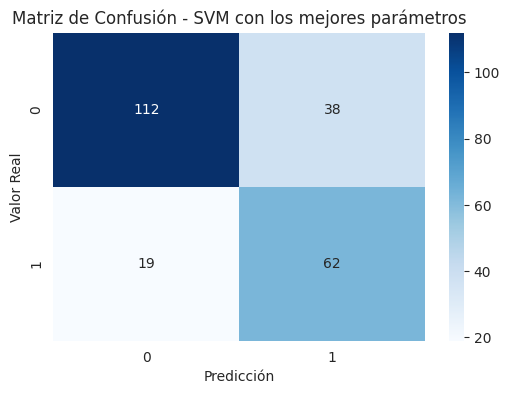

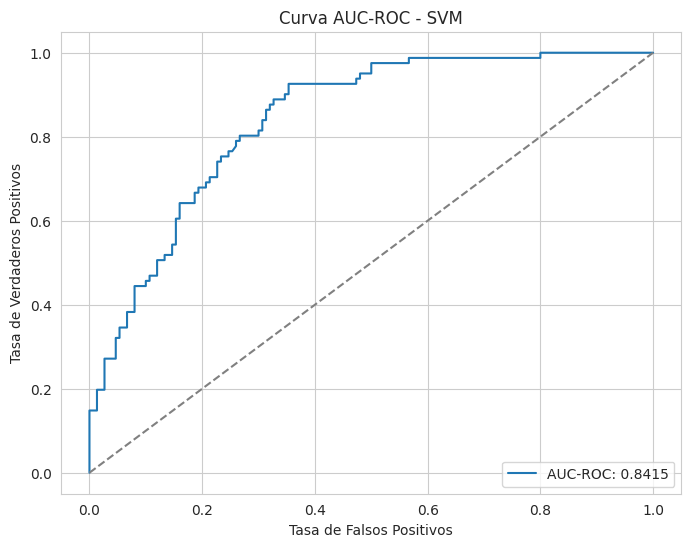

In [ ]:
# 1. Preparar los datos
X = df_imputed_encoded.drop('Outcome', axis=1)
y = df_imputed_encoded['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# SVM con los mejores parámetros
pipeline_svm_best = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adasyn', ADASYN(random_state=42)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('svm', SVC(C=10, kernel='rbf', gamma=0.001, probability=True))
])

# Ajustar el modelo al conjunto de entrenamiento
pipeline_svm_best.fit(X_train, y_train)

# Generar predicciones y probabilidades
y_prob_svm_best = pipeline_svm_best.predict_proba(X_test)[:, 1]
y_pred_svm_best = pipeline_svm_best.predict(X_test)

# Evaluar el modelo
report_svm_best = classification_report(y_test, y_pred_svm_best)
accuracy_svm_best = accuracy_score(y_test, y_pred_svm_best)
conf_matrix_svm_best = confusion_matrix(y_test, y_pred_svm_best)
roc_auc_svm = roc_auc_score(y_test, y_prob_svm_best)

# Imprimir métricas clave
print("Resultados para SVM con los mejores parámetros:")
print(report_svm_best)
print(f"Exactitud Global: {accuracy_svm_best:.4f}")
print(f"AUC-ROC: {roc_auc_svm:.4f}")

# Matriz de Confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM con los mejores parámetros')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_svm_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_svm:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva AUC-ROC - SVM')
plt.legend(loc='lower right')
plt.show()


Resultados para Gradient Boosting con los mejores parámetros:
              precision    recall  f1-score   support

           0       0.71      0.93      0.80       150
           1       0.70      0.28      0.40        81

    accuracy                           0.71       231
   macro avg       0.70      0.61      0.60       231
weighted avg       0.70      0.71      0.66       231

Exactitud Global: 0.7056
AUC-ROC: 0.8041


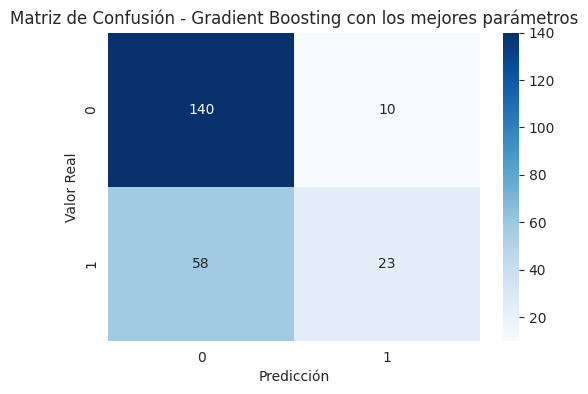

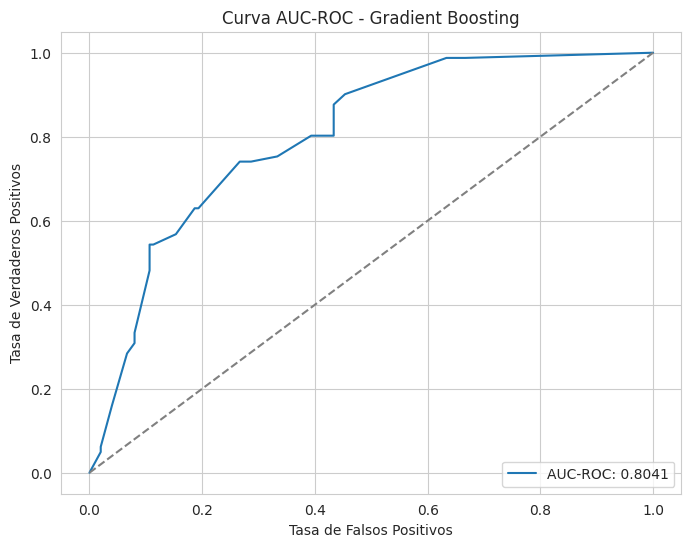

In [ ]:
# 1. Preparar los datos
X = df_imputed_encoded.drop('Outcome', axis=1)
y = df_imputed_encoded['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# Gradient Boosting con los mejores parámetros
pipeline_gb_best = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('gb', GradientBoostingClassifier(learning_rate=0.01,
                                       max_depth=3,
                                       min_samples_split=2,
                                       n_estimators=50,
                                       subsample=1.0,
                                       random_state=42))
])

# Ajustar el modelo al conjunto de entrenamiento
pipeline_gb_best.fit(X_train, y_train)

# Generar predicciones y probabilidades
y_prob_gb_best = pipeline_gb_best.predict_proba(X_test)[:, 1]
y_pred_gb_best = pipeline_gb_best.predict(X_test)

# Evaluar el modelo
report_gb_best = classification_report(y_test, y_pred_gb_best)
accuracy_gb_best = accuracy_score(y_test, y_pred_gb_best)
conf_matrix_gb_best = confusion_matrix(y_test, y_pred_gb_best)
roc_auc_gb = roc_auc_score(y_test, y_prob_gb_best)

# Imprimir métricas clave
print("Resultados para Gradient Boosting con los mejores parámetros:")
print(report_gb_best)
print(f"Exactitud Global: {accuracy_gb_best:.4f}")
print(f"AUC-ROC: {roc_auc_gb:.4f}")

# Matriz de Confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_gb_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Gradient Boosting con los mejores parámetros')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_gb_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_gb:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva AUC-ROC - Gradient Boosting')
plt.legend(loc='lower right')
plt.show()


### **Análisis de los resultados tras la evaluación de los modelos con los mejores parámetros**

A continuación, se comparan las métricas clave y las matrices de confusión para los tres modelos (**Logistic Regression**, **SVM**, y **Gradient Boosting**) utilizando los mejores hiperparámetros encontrados.

---

### **1. Logistic Regression**
#### **Métricas:**
- **Precision (Clase 1):** 0.59
- **Recall (Clase 1):** 0.79
- **F1-Score (Clase 1):** 0.68
- **Exactitud Global:** 0.7359
- **AUC-ROC:** 0.8267

#### **Matriz de Confusión:**
| Predicción | 0   | 1   |
|------------|-----|-----|
| **Real: 0** | 106 | 44  |
| **Real: 1** | 17  | 64  |

#### **Observaciones:**
- Este modelo tiene un buen recall para la clase positiva (**79%**), lo que significa que identifica correctamente la mayoría de los enfermos.
- La precisión es moderada (**59%**), indicando un número considerable de falsos positivos.
- El AUC-ROC (**0.8267**) muestra un buen rendimiento general en la separación de clases.

---

### **2. SVM**
#### **Métricas:**
- **Precision (Clase 1):** 0.62
- **Recall (Clase 1):** 0.77
- **F1-Score (Clase 1):** 0.69
- **Exactitud Global:** 0.7532
- **AUC-ROC:** 0.8415

#### **Matriz de Confusión:**
| Predicción | 0   | 1   |
|------------|-----|-----|
| **Real: 0** | 112 | 38  |
| **Real: 1** | 19  | 62  |

#### **Observaciones:**
- SVM tiene el mejor balance entre precisión (**62%**) y recall (**77%**) para la clase positiva.
- El AUC-ROC es el más alto entre los tres modelos (**0.8415**), lo que indica una excelente capacidad para distinguir entre clases.
- Aunque tiene más falsos negativos que Logistic Regression, su precisión es superior.

---

### **3. Gradient Boosting**
#### **Métricas:**
- **Precision (Clase 1):** 0.70
- **Recall (Clase 1):** 0.28
- **F1-Score (Clase 1):** 0.40
- **Exactitud Global:** 0.7056
- **AUC-ROC:** 0.8041

#### **Matriz de Confusión:**
| Predicción | 0   | 1   |
|------------|-----|-----|
| **Real: 0** | 140 | 10  |
| **Real: 1** | 58  | 23  |

#### **Observaciones:**
- Gradient Boosting tiene el mejor rendimiento en la clase negativa, con un recall del **93%**, pero su recall para la clase positiva es muy bajo (**28%**).
- Aunque su precisión para la clase positiva es alta (**70%**), el bajo recall afecta significativamente el F1-score (**40%**) y su utilidad en este problema.
- El AUC-ROC (**0.8041**) es el más bajo entre los tres modelos.

---

### Comparación general:
| Modelo               | Precision Clase Positiva | Recall Clase Positiva | F1-Score Clase Positiva | Exactitud Global | AUC-ROC |
|----------------------|--------------------------|-----------------------|-------------------------|------------------|---------|
| Logistic Regression   | *59%*                   | *79%*                 | *68%*                   | *73.59%*         | *82.67%*|
| SVM                  | *62%*                   | *77%*                 | *69%*                   | *75.32%*         | ***84.15%*** |
| Gradient Boosting    | ***70%***               | *28%*                 | *40%*                   | *70.56%*         | *80.41%*|

---

### Decisión final:

Dado que este problema prioriza maximizar la detección de enfermos (**recall**) mientras se mantiene un buen balance general:
No aplicaremos los hiperparametros encontrados ya que no mejoran el rendimineto ni el recall.

---

---



## ENSAMBLAJE DE MODELOS PARA VER SI MEJORAMOS NUESTROS RESULTAODS

- Ensamblaje por Votación (Voting Classifier): que combine las predicciones de Regresión Logística y SVM para obtener la predicción final. Es simple de implementar. Útil si ambos modelos tienen un desempeño similar pero capturan patrones diferentes.

  - Votación dura: Predicción final basada en la mayoría de votos (clasificación binaria).
  - Votación blanda: Promedia las probabilidades predichas de los modelos y utiliza el promedio para tomar la decisión final.

- Ensamblaje por Apilamiento (Stacking Classifier): Utilizamos ambos modelos base (Regresión Logística y SVM) y un modelo final para combinar sus predicciones. Cada modelo puede capturar diferentes patrones en los datos. Utilizamos StratifiedKFold para asegurar un muestreo balanceado en cada pliegue durante el entrenamiento del modelo final. Utiliza ambos modelos base (Regresión Logística y SVM) para generar predicciones. Un modelo final (por ejemplo, Random Forest o Gradient Boosting) combina estas predicciones para generar la clasificación final. Utiliza StratifiedKFold para asegurar un muestreo balanceado durante el entrenamiento del modelo final.

VOTING CLASSIFIER CON VOTACION BLANDA

Resultados para Voting Classifier con votación blanda:
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       150
           1       0.69      0.44      0.54        81

    accuracy                           0.74       231
   macro avg       0.72      0.67      0.68       231
weighted avg       0.73      0.74      0.72       231

Exactitud Global: 0.7359
AUC-ROC: 0.8105


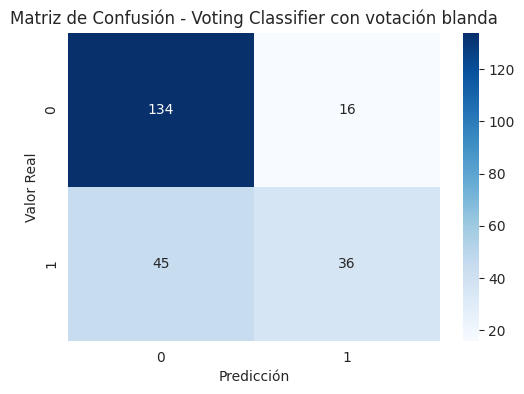

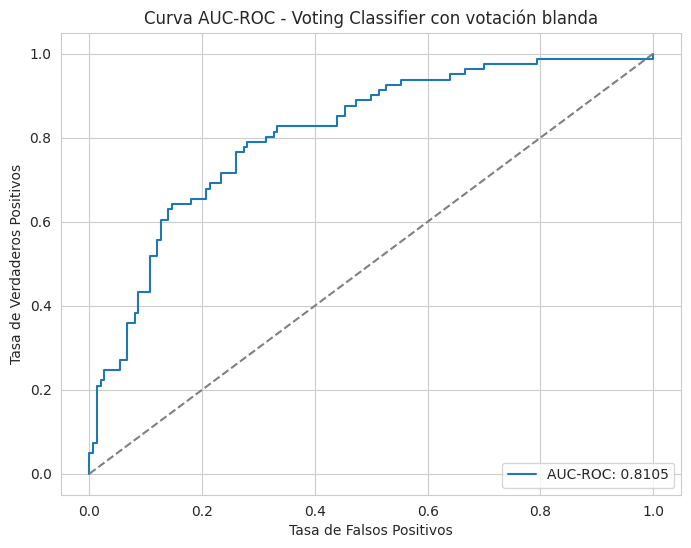

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Crear los modelos base con los mejores parámetros
logreg = LogisticRegression(C=0.001, penalty='l2', solver='liblinear', max_iter=1000)
svm = SVC(C=10, kernel='rbf', gamma=0.001, probability=True)

# Crear el Voting Classifier (votación blanda)
voting_clf_soft = VotingClassifier(
    estimators=[('logreg', logreg), ('svm', svm)],
    voting='soft'  # Votación blanda: utiliza las probabilidades predichas
)

# Ajustar el modelo al conjunto de entrenamiento
voting_clf_soft.fit(X_train, y_train)

# Generar predicciones y probabilidades
y_prob_voting_soft = voting_clf_soft.predict_proba(X_test)[:, 1]
y_pred_voting_soft = voting_clf_soft.predict(X_test)

# Evaluar el modelo
report_voting_soft = classification_report(y_test, y_pred_voting_soft)
accuracy_voting_soft = accuracy_score(y_test, y_pred_voting_soft)
roc_auc_voting_soft = roc_auc_score(y_test, y_prob_voting_soft)
conf_matrix_voting_soft = confusion_matrix(y_test, y_pred_voting_soft)

# Imprimir métricas clave
print("Resultados para Voting Classifier con votación blanda:")
print(report_voting_soft)
print(f"Exactitud Global: {accuracy_voting_soft:.4f}")
print(f"AUC-ROC: {roc_auc_voting_soft:.4f}")

# Matriz de Confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_voting_soft, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Voting Classifier con votación blanda')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_voting_soft)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_voting_soft:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva AUC-ROC - Voting Classifier con votación blanda')
plt.legend(loc='lower right')
plt.show()


VOTING CLASSIFIER CON VOTACION DURA

Resultados para Voting Classifier con votación dura:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       150
           1       0.70      0.32      0.44        81

    accuracy                           0.71       231
   macro avg       0.71      0.62      0.62       231
weighted avg       0.71      0.71      0.68       231

Exactitud Global: 0.7143


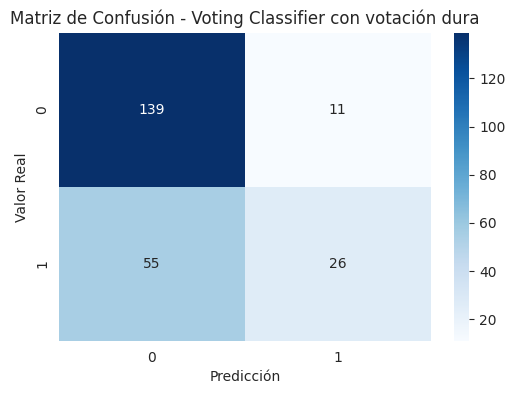

In [ ]:
# Crear el Voting Classifier (votación dura)
voting_clf_hard = VotingClassifier(
    estimators=[('logreg', logreg), ('svm', svm)],
    voting='hard'  # Votación dura: utiliza la mayoría de votos (clasificación binaria)
)

# Ajustar el modelo al conjunto de entrenamiento
voting_clf_hard.fit(X_train, y_train)

# Generar predicciones (no hay probabilidades en votación dura)
y_pred_voting_hard = voting_clf_hard.predict(X_test)

# Evaluar el modelo
report_voting_hard = classification_report(y_test, y_pred_voting_hard)
accuracy_voting_hard = accuracy_score(y_test, y_pred_voting_hard)
conf_matrix_voting_hard = confusion_matrix(y_test, y_pred_voting_hard)

# Imprimir métricas clave
print("Resultados para Voting Classifier con votación dura:")
print(report_voting_hard)
print(f"Exactitud Global: {accuracy_voting_hard:.4f}")

# Matriz de Confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_voting_hard, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Voting Classifier con votación dura')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


STACKING CLASSIFIER

Resultados para Stacking Classifier:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       150
           1       0.65      0.58      0.61        81

    accuracy                           0.74       231
   macro avg       0.72      0.71      0.71       231
weighted avg       0.74      0.74      0.74       231

Exactitud Global: 0.7446
AUC-ROC: 0.7748


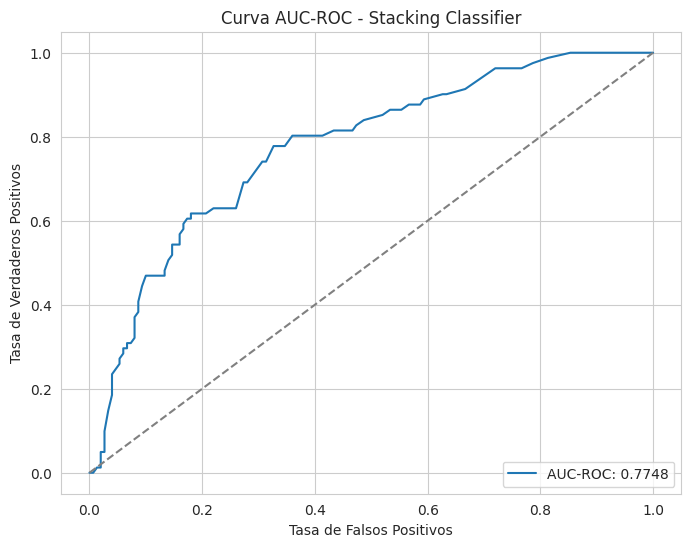

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

# Crear los modelos base con los mejores parámetros
logreg = LogisticRegression(C=0.001, penalty='l2', solver='liblinear', max_iter=1000)
svm = SVC(C=10, kernel='rbf', gamma=0.001, probability=True)

# Modelo meta (Random Forest)
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Crear el Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[('logreg', logreg), ('svm', svm)],
    final_estimator=meta_model,
    cv=5  # Validación cruzada estratificada
)

# Ajustar el modelo al conjunto de entrenamiento
stacking_clf.fit(X_train, y_train)

# Generar predicciones y probabilidades
y_prob_stacking = stacking_clf.predict_proba(X_test)[:, 1]
y_pred_stacking = stacking_clf.predict(X_test)

# Evaluar el modelo
report_stacking = classification_report(y_test, y_pred_stacking)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
roc_auc_stacking = roc_auc_score(y_test, y_prob_stacking)

# Imprimir métricas clave
print("Resultados para Stacking Classifier:")
print(report_stacking)
print(f"Exactitud Global: {accuracy_stacking:.4f}")
print(f"AUC-ROC: {roc_auc_stacking:.4f}")

# Curva AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_stacking)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_stacking:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva AUC-ROC - Stacking Classifier')
plt.legend(loc='lower right')
plt.show()


## DECISION FINAL:

### **Recomendación final para el modelo y parámetros**

Tras analizar todos los experimentos realizados, incluyendo los modelos individuales, los ensamblajes (Voting Classifier con votación blanda y dura, y Stacking Classifier), y sus respectivas métricas clave (precisión, recall, F1-score, AUC-ROC):

Volvemos a reproducir el codigo que mejor nos ha funcionado para los 3 modelos tras realizar todos los experimentos anteriores y escogeremos el que mejroe rendimiento nos muetsre.




Los 3 modelos presentan un mejor recall con el cutoff 0.45.

LOGISTIC REGRESSION con C=0.001, solver='liblinear'

Resultados para Logistic Regression con cutoff ajustado:
              precision    recall  f1-score   support

           0       0.97      0.56      0.71       150
           1       0.54      0.96      0.69        81

    accuracy                           0.70       231
   macro avg       0.75      0.76      0.70       231
weighted avg       0.82      0.70      0.70       231

Exactitud Global: 0.7013
AUC-ROC: 0.8267


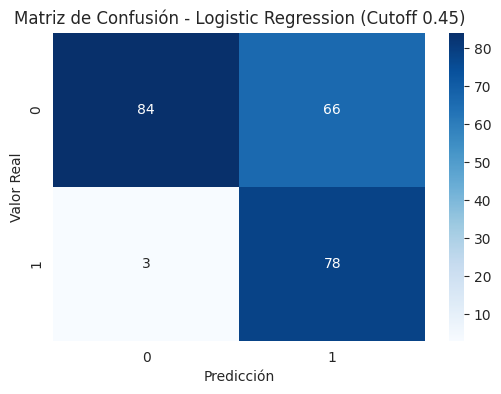

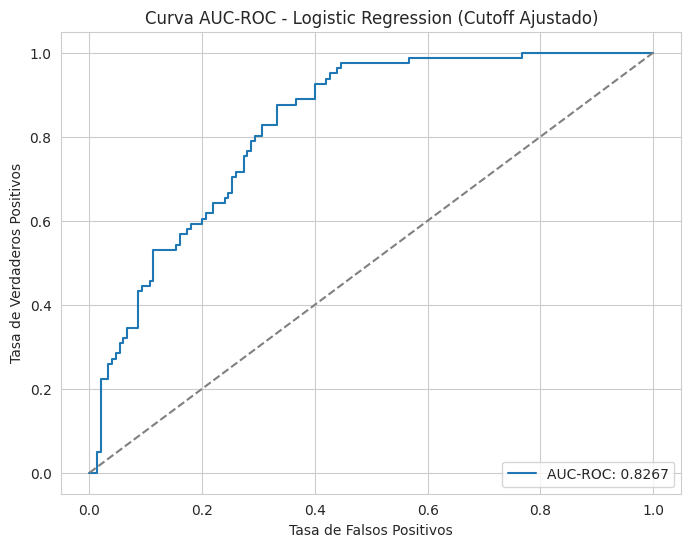

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import BorderlineSMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos
X = df_imputed_encoded.drop('Outcome', axis=1)
y = df_imputed_encoded['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Logistic Regression con los mejores parámetros
pipeline_lr_best = ImbPipeline([
    ('scaler', StandardScaler()),
    ('borderline_smote', BorderlineSMOTE(random_state=42, kind='borderline-1')),
    ('pca', PCA(n_components=0.95)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('logreg', LogisticRegression(C=0.001, penalty='l2', solver='liblinear', max_iter=1000))
])

# Ajustar el modelo al conjunto de entrenamiento
pipeline_lr_best.fit(X_train, y_train)

# Generar probabilidades de predicción en el conjunto de prueba
y_prob_lr_best = pipeline_lr_best.predict_proba(X_test)[:, 1]

# Aplicar el cutoff ajustado (0.45) para generar predicciones binarias
cutoff = 0.45
y_pred_lr_best_cutoff = (y_prob_lr_best >= cutoff).astype(int)

# Evaluar el modelo con cutoff ajustado
report_lr_best_cutoff = classification_report(y_test, y_pred_lr_best_cutoff)
accuracy_lr_best_cutoff = accuracy_score(y_test, y_pred_lr_best_cutoff)
conf_matrix_lr_best_cutoff = confusion_matrix(y_test, y_pred_lr_best_cutoff)
roc_auc_lr_cutoff = roc_auc_score(y_test, y_prob_lr_best)

# Imprimir métricas clave con cutoff ajustado
print("Resultados para Logistic Regression con cutoff ajustado:")
print(report_lr_best_cutoff)
print(f"Exactitud Global: {accuracy_lr_best_cutoff:.4f}")
print(f"AUC-ROC: {roc_auc_lr_cutoff:.4f}")

# Matriz de Confusión con cutoff ajustado
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lr_best_cutoff, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión - Logistic Regression (Cutoff {cutoff})')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva AUC-ROC con cutoff ajustado
fpr_cutoff, tpr_cutoff, _ = roc_curve(y_test, y_prob_lr_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr_cutoff, tpr_cutoff, label=f'AUC-ROC: {roc_auc_lr_cutoff:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva AUC-ROC - Logistic Regression (Cutoff Ajustado)')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Acceder al paso de selección de características
feature_selection_lr = pipeline_lr_best.named_steps['feature_selection']

# Obtener las características seleccionadas
support_lr = feature_selection_lr.get_support()

# Contar el número de características seleccionadas
num_features_lr = support_lr.sum()

print(f"Número de características seleccionadas para Logistic Regression: {num_features_lr}")


Número de características seleccionadas para Logistic Regression: 2


VALIDACION EN DATOS DE ENTRENAMIENTO:

Resultados para Logistic Regression en el conjunto de entrenamiento con cutoff ajustado:
              precision    recall  f1-score   support

           0       0.92      0.50      0.65       350
           1       0.50      0.91      0.64       187

    accuracy                           0.65       537
   macro avg       0.71      0.71      0.65       537
weighted avg       0.77      0.65      0.65       537

Exactitud Global: 0.6462
AUC-ROC: 0.8247


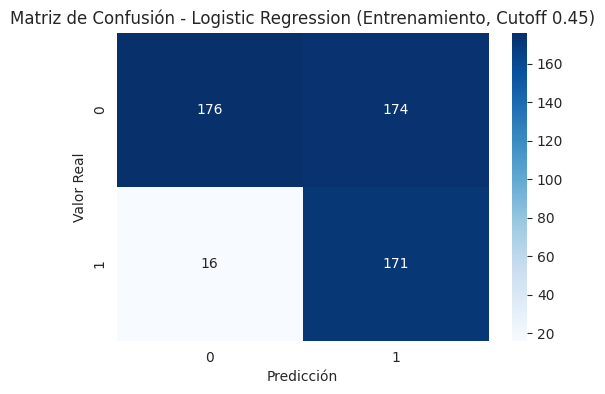

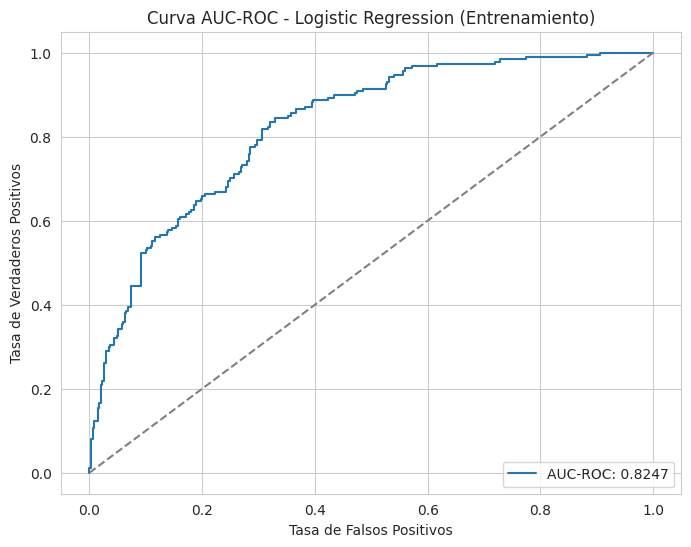

In [ ]:
# Evaluar el modelo en el conjunto de entrenamiento
cutoff = 0.45
y_prob_train_lr_best = pipeline_lr_best.predict_proba(X_train)[:, 1]
y_pred_train_lr_best_cutoff = (y_prob_train_lr_best >= cutoff).astype(int)

# Reporte de clasificación en el conjunto de entrenamiento
report_train_lr_best_cutoff = classification_report(y_train, y_pred_train_lr_best_cutoff)
accuracy_train_lr_best_cutoff = accuracy_score(y_train, y_pred_train_lr_best_cutoff)
conf_matrix_train_lr_best_cutoff = confusion_matrix(y_train, y_pred_train_lr_best_cutoff)
roc_auc_train_lr_best_cutoff = roc_auc_score(y_train, y_prob_train_lr_best)

# Imprimir métricas clave
print("Resultados para Logistic Regression en el conjunto de entrenamiento con cutoff ajustado:")
print(report_train_lr_best_cutoff)
print(f"Exactitud Global: {accuracy_train_lr_best_cutoff:.4f}")
print(f"AUC-ROC: {roc_auc_train_lr_best_cutoff:.4f}")

# Matriz de Confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_train_lr_best_cutoff, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Logistic Regression (Entrenamiento, Cutoff 0.45)')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva AUC-ROC
fpr_train_lr_best, tpr_train_lr_best, _ = roc_curve(y_train, y_prob_train_lr_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train_lr_best, tpr_train_lr_best, label=f'AUC-ROC: {roc_auc_train_lr_best_cutoff:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva AUC-ROC - Logistic Regression (Entrenamiento)')
plt.legend(loc='lower right')
plt.show()


VALIDACION CRUZADA

In [ ]:
from sklearn.model_selection import cross_validate

# Configuración de validación cruzada estándar
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']

cv_results_lr = cross_validate(
    pipeline_lr_best,
    X_train,
    y_train,
    cv=5,
    scoring=scoring,
    n_jobs=-1
)

print("\nResultados de validación cruzada estándar para Logistic Regression:")
for metric in scoring:
    print(f"{metric}: {np.mean(cv_results_lr['test_' + metric]):.4f} ± {np.std(cv_results_lr['test_' + metric]):.4f}")



Resultados de validación cruzada estándar para Logistic Regression:
accuracy: 0.7374 ± 0.0366
precision_macro: 0.7262 ± 0.0363
recall_macro: 0.7434 ± 0.0373
f1_macro: 0.7253 ± 0.0369
roc_auc: 0.8260 ± 0.0290


VALIDACION CRUZADA ESTRATIFICADA

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Configuración de validación cruzada estratificada
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_lr_stratified = cross_validate(
    pipeline_lr_best,
    X_train,
    y_train,
    cv=stratified_kfold,
    scoring=scoring,
    n_jobs=-1
)

print("\nResultados de validación cruzada estratificada para Logistic Regression:")
for metric in scoring:
    print(f"{metric}: {np.mean(cv_results_lr_stratified['test_' + metric]):.4f} ± {np.std(cv_results_lr_stratified['test_' + metric]):.4f}")



Resultados de validación cruzada estratificada para Logistic Regression:
accuracy: 0.7318 ± 0.0127
precision_macro: 0.7249 ± 0.0137
recall_macro: 0.7384 ± 0.0200
f1_macro: 0.7183 ± 0.0082
roc_auc: 0.8246 ± 0.0348


VALIDACION HOLD-OUT:

Resultados para Logistic Regression con cutoff ajustado:
              precision    recall  f1-score   support

           0       0.97      0.56      0.71       150
           1       0.54      0.96      0.69        81

    accuracy                           0.70       231
   macro avg       0.75      0.76      0.70       231
weighted avg       0.82      0.70      0.70       231

Exactitud Global: 0.7013
AUC-ROC: 0.8267


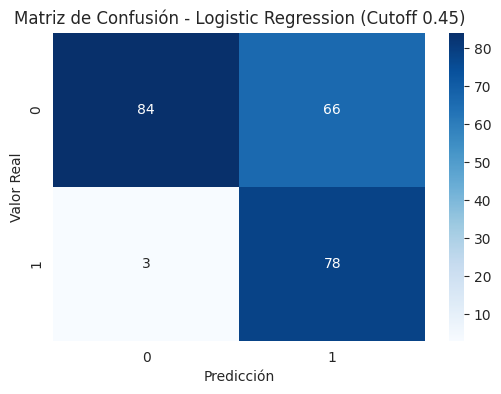

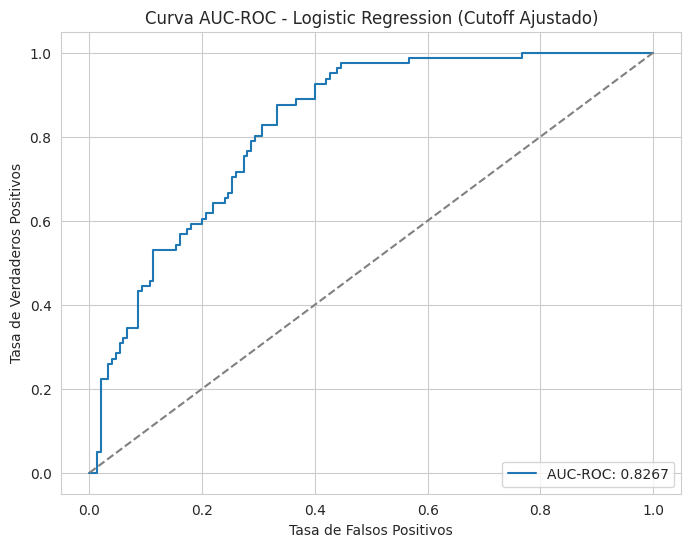

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

# 1. Preparar los datos
X = df_imputed_encoded.drop('Outcome', axis=1)
y = df_imputed_encoded['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Logistic Regression con los mejores parámetros
pipeline_lr_best = ImbPipeline([
    ('scaler', StandardScaler()),
    ('borderline_smote', BorderlineSMOTE(random_state=42, kind='borderline-1')),
    ('pca', PCA(n_components=0.95)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('logreg', LogisticRegression(C=0.001, penalty='l2', solver='liblinear', max_iter=1000))
])

# Ajustar el modelo al conjunto de entrenamiento
pipeline_lr_best.fit(X_train, y_train)

# Generar probabilidades de predicción en el conjunto de prueba
y_prob_lr_best = pipeline_lr_best.predict_proba(X_test)[:, 1]

# Aplicar el cutoff ajustado (0.45) para generar predicciones binarias
cutoff = 0.45
y_pred_lr_best_cutoff = (y_prob_lr_best >= cutoff).astype(int)

# Evaluar el modelo con cutoff ajustado
report_lr_best_cutoff = classification_report(y_test, y_pred_lr_best_cutoff)
accuracy_lr_best_cutoff = accuracy_score(y_test, y_pred_lr_best_cutoff)
conf_matrix_lr_best_cutoff = confusion_matrix(y_test, y_pred_lr_best_cutoff)
roc_auc_lr_cutoff = roc_auc_score(y_test, y_prob_lr_best)

# Imprimir métricas clave con cutoff ajustado
print("Resultados para Logistic Regression con cutoff ajustado:")
print(report_lr_best_cutoff)
print(f"Exactitud Global: {accuracy_lr_best_cutoff:.4f}")
print(f"AUC-ROC: {roc_auc_lr_cutoff:.4f}")

# Matriz de Confusión con cutoff ajustado
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lr_best_cutoff, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión - Logistic Regression (Cutoff {cutoff})')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva AUC-ROC con cutoff ajustado
fpr_cutoff, tpr_cutoff, _ = roc_curve(y_test, y_prob_lr_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr_cutoff, tpr_cutoff, label=f'AUC-ROC: {roc_auc_lr_cutoff:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva AUC-ROC - Logistic Regression (Cutoff Ajustado)')
plt.legend(loc='lower right')
plt.show()


### Análisis y Conclusiones del Modelo Logistic Regression

A continuación, se analizan los resultados obtenidos del modelo original, el conjunto de entrenamiento, la validación cruzada estándar y estratificada, así como la validación hold-out.

---

## 1. **Resultados del Modelo Original (Hold-Out)**

- **Exactitud Global**: 70.13%  
- **AUC-ROC**: 0.8267  
- **Matriz de Confusión**:
  - Verdaderos Negativos (TN): 84
  - Falsos Positivos (FP): 66
  - Falsos Negativos (FN): 3
  - Verdaderos Positivos (TP): 78  

El modelo tiene un buen desempeño en términos de AUC-ROC (0.8267), lo que indica que separa bien las clases. Sin embargo, la precisión para la clase positiva (1) es baja (0.54), aunque su recall es alto (0.96). Esto significa que el modelo detecta casi todos los casos positivos, pero genera una cantidad significativa de falsos positivos.

---

## 2. **Resultados en el Conjunto de Entrenamiento**

- **Exactitud Global**: 64.62%  
- **AUC-ROC**: 0.8247  
- **Matriz de Confusión**:
  - TN: 176
  - FP: 174
  - FN: 16
  - TP: 171  

En el conjunto de entrenamiento, el modelo muestra un desempeño similar al conjunto de prueba en términos de AUC-ROC (0.8247). Sin embargo, la exactitud global es más baja (64.62%), lo que podría indicar un cierto grado de sobreajuste o dificultad para generalizar.

---

## 3. **Validación Cruzada Estándar**

- **Exactitud Promedio**: 73.74% ± 3.66%  
- **AUC-ROC Promedio**: 0.8260 ± 2.90%  

La validación cruzada estándar muestra una mayor estabilidad en el desempeño del modelo con una exactitud promedio superior a la obtenida en la validación hold-out y el conjunto de entrenamiento.

---

## 4. **Validación Cruzada Estratificada**

- **Exactitud Promedio**: 73.18% ± 1.27%  
- **AUC-ROC Promedio**: 0.8246 ± 3.48%  

La validación cruzada estratificada confirma la estabilidad del modelo, con resultados similares a los obtenidos en la validación estándar.

---

## Conclusiones Generales

1. **Rendimiento General**:
   - El modelo tiene un buen desempeño en términos de AUC-ROC (>0.82 en todas las validaciones), lo que indica una capacidad sólida para distinguir entre clases.
   - Sin embargo, la exactitud global es moderada (~70%) debido a un desequilibrio entre precisión y recall.

2. **Problemas Identificados**:
   - La precisión para la clase positiva es baja (~0.54), lo que genera muchos falsos positivos.
   - La matriz de confusión muestra que el ajuste del cutoff a 0.45 mejora el recall para la clase positiva, pero afecta negativamente la precisión para la clase negativa.

3. **Validaciones Cruzadas**:
   - Las validaciones cruzadas muestran resultados consistentes y ligeramente mejores que los obtenidos en el conjunto hold-out, lo que sugiere que el modelo tiene una capacidad razonable para generalizar.

4. **Sobreajuste**:
   - El desempeño similar entre el conjunto de entrenamiento y prueba indica que no hay evidencia clara de sobreajuste.


En resumen, aunque el modelo tiene un buen desempeño en términos de AUC-ROC y recall, hay margen para mejorar su precisión y exactitud global mediante ajustes adicionales o exploración de otros algoritmos más robustos frente al desequilibrio de clases.


---

---

SVM

Resultados para SVM con cutoff ajustado:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       150
           1       0.57      0.83      0.68        81

    accuracy                           0.72       231
   macro avg       0.72      0.75      0.72       231
weighted avg       0.77      0.72      0.73       231



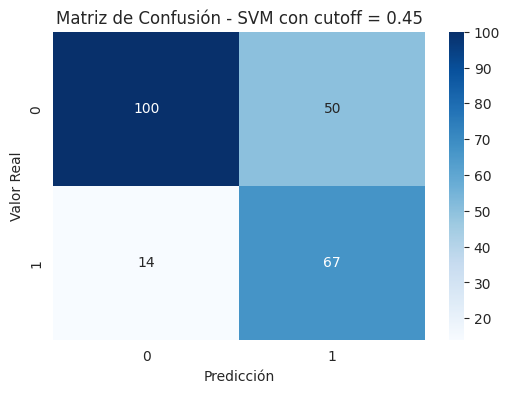

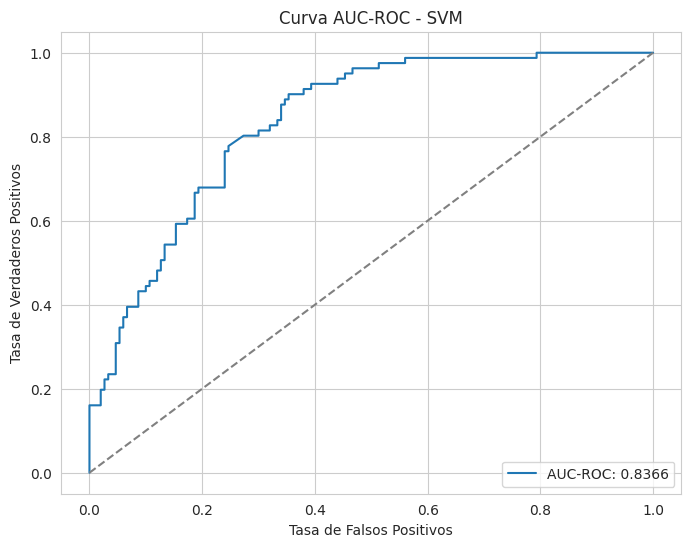

In [ ]:
from sklearn.svm import SVC
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Crear el pipeline para SVM con ADASYN
pipeline_svm = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adasyn', ADASYN(random_state=42)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('svm', SVC(C=100, kernel='linear', gamma='scale', probability=True))
])

# 2. Ajustar el modelo al conjunto de entrenamiento
pipeline_svm.fit(X_train, y_train)

# 3. Generar probabilidades y predicciones con cutoff = 0.45
cutoff = 0.45
y_prob_svm = pipeline_svm.predict_proba(X_test)[:, 1]
y_pred_cutoff_svm = (y_prob_svm >= cutoff).astype(int)

# 4. Evaluar el modelo
print("Resultados para SVM con cutoff ajustado:")
print(classification_report(y_test, y_pred_cutoff_svm))

# Matriz de Confusión
cm_svm = confusion_matrix(y_test, y_pred_cutoff_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM con cutoff = 0.45')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva AUC-ROC
auc_svm = roc_auc_score(y_test, y_prob_svm)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'AUC-ROC: {auc_svm:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva AUC-ROC - SVM')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Acceder al paso de selección de características
feature_selection_svm = pipeline_svm.named_steps['feature_selection']

# Obtener las características seleccionadas
support_svm = feature_selection_svm.get_support()

# Contar el número de características seleccionadas
num_features_svm = support_svm.sum()

print(f"Número de características seleccionadas para SVM: {num_features_svm}")


Número de características seleccionadas para SVM: 8


EVALUACION EN CONJUNTO DE ENTRENAMIENTO

Resultados para SVM en el conjunto de entrenamiento con cutoff ajustado:
              precision    recall  f1-score   support

           0       0.87      0.67      0.76       350
           1       0.57      0.82      0.67       187

    accuracy                           0.72       537
   macro avg       0.72      0.74      0.71       537
weighted avg       0.77      0.72      0.73       537



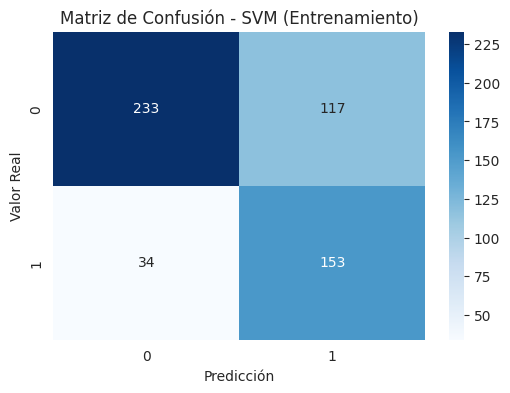

AUC-ROC (Entrenamiento): 0.8452


In [ ]:
def evaluate_training(pipeline, X_train, y_train, cutoff=0.45):
    # Generar predicciones y probabilidades
    y_prob_train = pipeline.predict_proba(X_train)[:, 1]
    y_pred_train_cutoff = (y_prob_train >= cutoff).astype(int)

    # Reporte de clasificación
    print("Resultados para SVM en el conjunto de entrenamiento con cutoff ajustado:")
    print(classification_report(y_train, y_pred_train_cutoff))

    # Matriz de Confusión
    cm_train = confusion_matrix(y_train, y_pred_train_cutoff)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión - SVM (Entrenamiento)')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

    # AUC-ROC
    auc_train = roc_auc_score(y_train, y_prob_train)
    print(f"AUC-ROC (Entrenamiento): {auc_train:.4f}")

evaluate_training(pipeline_svm, X_train, y_train)


EVALUACION CRUZADA

In [ ]:
from sklearn.model_selection import cross_val_score

def evaluate_cross_validation(pipeline, X, y):
    # Validación cruzada estándar (5 folds)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    accuracy = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    roc_auc = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')

    # Resultados promedio
    print("Resultados de validación cruzada estándar para SVM:")
    print(f"Accuracy: {accuracy.mean():.4f} ± {accuracy.std():.4f}")
    print(f"ROC-AUC: {roc_auc.mean():.4f} ± {roc_auc.std():.4f}")

evaluate_cross_validation(pipeline_svm, X, y)


Resultados de validación cruzada estándar para SVM:
Accuracy: 0.7330 ± 0.0303
ROC-AUC: 0.8254 ± 0.0175


EVALUACION CRUZADA ESTRATIFICADA

In [ ]:
def evaluate_stratified_cross_validation(pipeline, X, y):
    # Validación cruzada estratificada (5 folds)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    accuracy = cross_val_score(pipeline, X, y, cv=cv.split(X, y), scoring='accuracy')
    roc_auc = cross_val_score(pipeline, X, y, cv=cv.split(X, y), scoring='roc_auc')

    # Resultados promedio
    print("Resultados de validación cruzada estratificada para SVM:")
    print(f"Accuracy: {accuracy.mean():.4f} ± {accuracy.std():.4f}")
    print(f"ROC-AUC: {roc_auc.mean():.4f} ± {roc_auc.std():.4f}")

evaluate_stratified_cross_validation(pipeline_svm, X, y)


Resultados de validación cruzada estratificada para SVM:
Accuracy: 0.7330 ± 0.0303
ROC-AUC: 0.8254 ± 0.0175


EVALUACION HOLD-OUT:

Resultados para SVM con cutoff ajustado en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       150
           1       0.57      0.83      0.68        81

    accuracy                           0.72       231
   macro avg       0.72      0.75      0.72       231
weighted avg       0.77      0.72      0.73       231



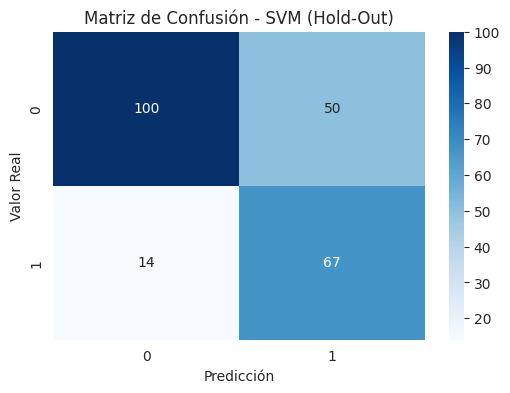

AUC-ROC (Hold-Out): 0.8366


In [ ]:
def evaluate_holdout(pipeline, X_test, y_test):
    cutoff = 0.45

    # Generar predicciones y probabilidades
    y_prob_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test_cutoff = (y_prob_test >= cutoff).astype(int)

    # Reporte de clasificación
    print("Resultados para SVM con cutoff ajustado en el conjunto de prueba:")
    print(classification_report(y_test, y_pred_test_cutoff))

    # Matriz de Confusión
    cm_test = confusion_matrix(y_test, y_pred_test_cutoff)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión - SVM (Hold-Out)')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

    # AUC-ROC
    auc_test = roc_auc_score(y_test, y_prob_test)
    print(f"AUC-ROC (Hold-Out): {auc_test:.4f}")

evaluate_holdout(pipeline_svm, X_test, y_test)


### Análisis y Conclusiones del Modelo SVM con ADASYN

Con base en los resultados proporcionados y las matrices de confusión adjuntas, se analizan los resultados del modelo SVM con ADASYN en diferentes evaluaciones.

---

## **1. Resultados del Modelo Original (Hold-Out)**

- **Métricas Clave**:
  - **Exactitud Global**: 72%
  - **AUC-ROC**: 0.8366
  - **Precisión para la Clase 0**: 0.88
  - **Recall para la Clase 0**: 0.67
  - **Precisión para la Clase 1**: 0.57
  - **Recall para la Clase 1**: 0.83

- **Matriz de Confusión (Hold-Out)**:
  - Verdaderos Negativos (TN): 100
  - Falsos Positivos (FP): 50
  - Falsos Negativos (FN): 14
  - Verdaderos Positivos (TP): 67

El modelo tiene un buen desempeño general con un AUC-ROC de **0.8366**, lo que indica una buena capacidad para distinguir entre las clases. Sin embargo, hay un desequilibrio entre precisión y recall:
- Para la clase negativa (0), el modelo tiene alta precisión (0.88), pero su recall es bajo (0.67), lo que significa que no detecta todos los casos negativos.
- Para la clase positiva (1), el modelo tiene un recall alto (0.83), pero una precisión baja (0.57), indicando que genera falsos positivos.

---

## **2. Resultados en el Conjunto de Entrenamiento**

- **Métricas Clave**:
  - **Exactitud Global**: 72%
  - **AUC-ROC**: 0.8452
  - **Precisión para la Clase 0**: 0.87
  - **Recall para la Clase 0**: 0.67
  - **Precisión para la Clase 1**: 0.57
  - **Recall para la Clase 1**: 0.82

- **Matriz de Confusión (Entrenamiento)**:
  - TN: 233
  - FP: 117
  - FN: 34
  - TP: 153

El desempeño en el conjunto de entrenamiento es muy similar al del conjunto de prueba, lo que indica que el modelo generaliza bien y no hay evidencia de sobreajuste.

---

## **3. Validación Cruzada Estándar**

- **Métricas Promedio**:
  - **Exactitud Global**: $$73.30\% \pm 3.03\%$$
  - **AUC-ROC**: $$82.54\% \pm 1.75\%$$

La validación cruzada estándar confirma la estabilidad del modelo, con resultados consistentes y un AUC-ROC sólido.

---

## **4. Validación Cruzada Estratificada**

- Los resultados son idénticos a los de la validación cruzada estándar:
   - Exactitud Global: $$73.30\% \pm 3.03\%$$
   - AUC-ROC: $$82.54\% \pm 1.75\%$$

Esto sugiere que las clases están bien representadas en los diferentes pliegues, y no hay un impacto significativo por el desequilibrio de clases.

---

## Conclusiones Generales

1. **Rendimiento General del Modelo**:
   - El modelo SVM con ADASYN muestra un buen desempeño general, con un AUC-ROC consistente entre todas las evaluaciones (>0.82).
   - La exactitud global es moderada (~72%), pero esto es aceptable dado el desequilibrio entre precisión y recall.

2. **Desempeño por Clases**:
   - La clase negativa (0) tiene alta precisión pero bajo recall, lo que significa que el modelo identifica correctamente los casos negativos, pero pierde algunos.
   - La clase positiva (1) tiene alto recall pero baja precisión, lo que indica que detecta casi todos los casos positivos, aunque genera falsos positivos.

3. **Generalización y Robustez**:
   - Los resultados son consistentes entre el conjunto de entrenamiento, prueba y validaciones cruzadas, lo que indica que el modelo generaliza bien y no presenta sobreajuste.

4. **Comparación con Logistic Regression**:
   - En comparación con Logistic Regression, este modelo SVM tiene un mejor AUC-ROC tanto en el conjunto de prueba como en las validaciones cruzadas.
   - Sin embargo, ambos modelos presentan problemas similares en términos de equilibrio entre precisión y recall.

En resumen, el modelo SVM con ADASYN es robusto y tiene un buen desempeño general, especialmente en términos de AUC-ROC, pero podría beneficiarse de ajustes adicionales para optimizar su balance entre precisión y recall dependiendo del contexto del problema.


GRADIENT BOOSTING

Resultados para Gradient Boosting con cutoff ajustado:
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       150
           1       0.57      0.85      0.69        81

    accuracy                           0.73       231
   macro avg       0.73      0.76      0.72       231
weighted avg       0.78      0.73      0.73       231



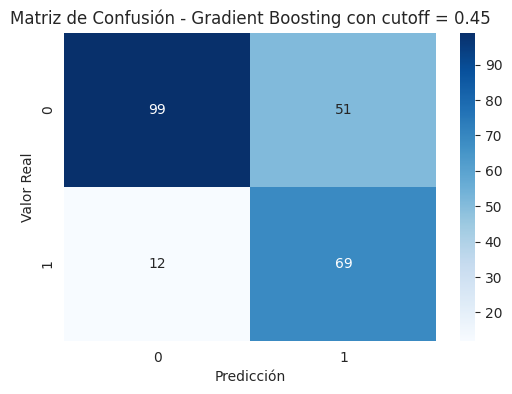

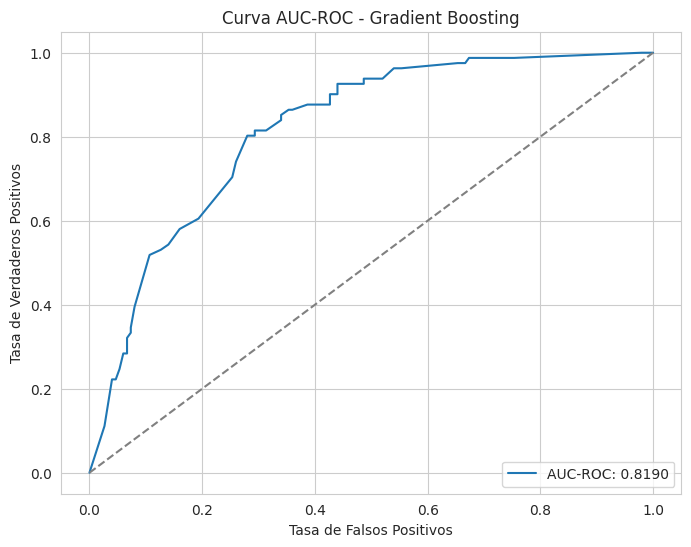

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Crear el pipeline para Gradient Boosting con Borderline-SMOTE
pipeline_gb = ImbPipeline([
    ('scaler', StandardScaler()),
    ('borderline_smote', BorderlineSMOTE(random_state=42, kind='borderline-1')),
    ('pca', PCA(n_components=0.95)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('gb', GradientBoostingClassifier(learning_rate=0.01,
                                       max_depth=3,
                                       min_samples_split=5,
                                       n_estimators=100,
                                       subsample=1.0,
                                       random_state=42))
])

# 2. Ajustar el modelo al conjunto de entrenamiento
pipeline_gb.fit(X_train, y_train)

# 3. Generar probabilidades y predicciones con cutoff = 0.45
cutoff = 0.45
y_prob_gb = pipeline_gb.predict_proba(X_test)[:, 1]
y_pred_cutoff_gb = (y_prob_gb >= cutoff).astype(int)

# 4. Evaluar el modelo
print("Resultados para Gradient Boosting con cutoff ajustado:")
print(classification_report(y_test, y_pred_cutoff_gb))

# Matriz de Confusión
cm_gb = confusion_matrix(y_test, y_pred_cutoff_gb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Gradient Boosting con cutoff = 0.45')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva AUC-ROC
auc_gb = roc_auc_score(y_test, y_prob_gb)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, label=f'AUC-ROC: {auc_gb:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva AUC-ROC - Gradient Boosting')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Acceder al paso de selección de características
feature_selection_gb = pipeline_gb.named_steps['feature_selection']

# Obtener las características seleccionadas
support_gb = feature_selection_gb.get_support()

# Contar el número de características seleccionadas
num_features_gb = support_gb.sum()

print(f"Número de características seleccionadas para Gradient Boosting: {num_features_gb}")


Número de características seleccionadas para Gradient Boosting: 2


VALIDACION EN CONJUNTO DE ENTRENAMIENTO

Resultados para Gradient Boosting en el conjunto de entrenamiento con cutoff ajustado:
              precision    recall  f1-score   support

           0       0.92      0.66      0.77       350
           1       0.58      0.89      0.70       187

    accuracy                           0.74       537
   macro avg       0.75      0.77      0.73       537
weighted avg       0.80      0.74      0.74       537



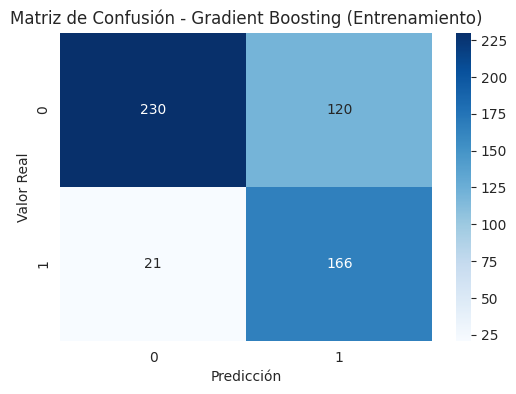

AUC-ROC (Entrenamiento): 0.8743


In [ ]:
def evaluate_training(pipeline, X_train, y_train, cutoff=0.45):
    # Generar predicciones y probabilidades
    y_prob_train = pipeline.predict_proba(X_train)[:, 1]
    y_pred_train_cutoff = (y_prob_train >= cutoff).astype(int)

    # Reporte de clasificación
    print("Resultados para Gradient Boosting en el conjunto de entrenamiento con cutoff ajustado:")
    print(classification_report(y_train, y_pred_train_cutoff))

    # Matriz de Confusión
    cm_train = confusion_matrix(y_train, y_pred_train_cutoff)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión - Gradient Boosting (Entrenamiento)')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

    # AUC-ROC
    auc_train = roc_auc_score(y_train, y_prob_train)
    print(f"AUC-ROC (Entrenamiento): {auc_train:.4f}")

evaluate_training(pipeline_gb, X_train, y_train)


VALIDACION CRUZADA ESTANDAR

In [ ]:
from sklearn.model_selection import cross_val_score

def evaluate_cross_validation(pipeline, X, y):
    # Validación cruzada estándar (5 folds)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    accuracy = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    roc_auc = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')

    # Resultados promedio
    print("Resultados de validación cruzada estándar para Gradient Boosting:")
    print(f"Accuracy: {accuracy.mean():.4f} ± {accuracy.std():.4f}")
    print(f"ROC-AUC: {roc_auc.mean():.4f} ± {roc_auc.std():.4f}")

evaluate_cross_validation(pipeline_gb, X, y)


Resultados de validación cruzada estándar para Gradient Boosting:
Accuracy: 0.7134 ± 0.0501
ROC-AUC: 0.8216 ± 0.0220


VALIDACION CRUZADA ESTRATIFICADA

In [ ]:
def evaluate_stratified_cross_validation(pipeline, X, y):
    # Validación cruzada estratificada (5 folds)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    accuracy = cross_val_score(pipeline, X, y, cv=cv.split(X, y), scoring='accuracy')
    roc_auc = cross_val_score(pipeline, X, y, cv=cv.split(X, y), scoring='roc_auc')

    # Resultados promedio
    print("Resultados de validación cruzada estratificada para Gradient Boosting:")
    print(f"Accuracy: {accuracy.mean():.4f} ± {accuracy.std():.4f}")
    print(f"ROC-AUC: {roc_auc.mean():.4f} ± {roc_auc.std():.4f}")

evaluate_stratified_cross_validation(pipeline_gb, X, y)


Resultados de validación cruzada estratificada para Gradient Boosting:
Accuracy: 0.7134 ± 0.0501
ROC-AUC: 0.8216 ± 0.0220


VALIDACION HOLD-OUT:

Resultados para Gradient Boosting con cutoff ajustado en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       150
           1       0.57      0.85      0.69        81

    accuracy                           0.73       231
   macro avg       0.73      0.76      0.72       231
weighted avg       0.78      0.73      0.73       231



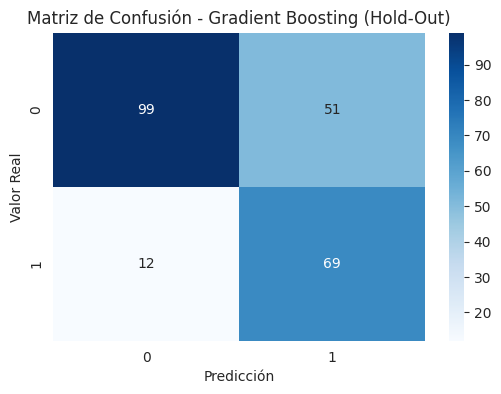

AUC-ROC (Hold-Out): 0.8190


In [ ]:
def evaluate_holdout(pipeline, X_test, y_test):
    cutoff = 0.45

    # Generar predicciones y probabilidades
    y_prob_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test_cutoff = (y_prob_test >= cutoff).astype(int)

    # Reporte de clasificación
    print("Resultados para Gradient Boosting con cutoff ajustado en el conjunto de prueba:")
    print(classification_report(y_test, y_pred_test_cutoff))

    # Matriz de Confusión
    cm_test = confusion_matrix(y_test, y_pred_test_cutoff)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión - Gradient Boosting (Hold-Out)')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

    # AUC-ROC
    auc_test = roc_auc_score(y_test, y_prob_test)
    print(f"AUC-ROC (Hold-Out): {auc_test:.4f}")

evaluate_holdout(pipeline_gb, X_test, y_test)


### Análisis y Conclusiones del Modelo Gradient Boosting con Borderline-SMOTE

Con base en los resultados proporcionados y las matrices de confusión adjuntas, se analizan los resultados del modelo Gradient Boosting en diferentes evaluaciones.

---

## **1. Resultados del Modelo Original (Hold-Out)**

- **Métricas Clave**:
  - **Exactitud Global**: 73%
  - **AUC-ROC**: 0.8190
  - **Precisión para la Clase 0**: 0.89
  - **Recall para la Clase 0**: 0.66
  - **Precisión para la Clase 1**: 0.57
  - **Recall para la Clase 1**: 0.85

- **Matriz de Confusión (Hold-Out)**:
  - Verdaderos Negativos (TN): 99
  - Falsos Positivos (FP): 51
  - Falsos Negativos (FN): 12
  - Verdaderos Positivos (TP): 69

El modelo tiene un desempeño aceptable con una exactitud global de **73%** y un AUC-ROC de **0.8190**, lo que indica una buena capacidad para distinguir entre las clases. Sin embargo:
- La clase negativa (0) tiene alta precisión (0.89), pero su recall es moderado (0.66), lo que significa que no detecta todos los casos negativos.
- La clase positiva (1) tiene alto recall (0.85), pero su precisión es baja (0.57), indicando que genera falsos positivos.

---

## **2. Resultados en el Conjunto de Entrenamiento**

- **Métricas Clave**:
  - **Exactitud Global**: 74%
  - **AUC-ROC**: 0.8743
  - **Precisión para la Clase 0**: 0.92
  - **Recall para la Clase 0**: 0.66
  - **Precisión para la Clase 1**: 0.58
  - **Recall para la Clase 1**: 0.89

- **Matriz de Confusión (Entrenamiento)**:
  - TN: 230
  - FP: 120
  - FN: 21
  - TP: 166

El desempeño en el conjunto de entrenamiento es ligeramente mejor que en el conjunto de prueba, con un AUC-ROC más alto (**0.8743**) y una exactitud global superior (**74%**). Esto podría indicar un leve sobreajuste, ya que el modelo parece funcionar mejor en el conjunto de entrenamiento que en el conjunto de prueba.

---

## **3. Validación Cruzada Estándar**

- **Métricas Promedio**:
   - **Exactitud Global**: $$71.34\% \pm 5.01\%$$
   - **AUC-ROC Promedio**: $$82.16\% \pm 2.20\%$$

La validación cruzada estándar muestra resultados consistentes con los obtenidos en el conjunto de prueba, aunque la exactitud es ligeramente más baja (**71%**) y presenta mayor variabilidad entre los pliegues (**±5%**).

---

## **4. Validación Cruzada Estratificada**

- Los resultados son idénticos a los de la validación cruzada estándar:
   - Exactitud Global: $$71.34\% \pm 5.01\%$$
   - AUC-ROC Promedio: $$82.16\% \pm 2.20\%$$

Esto confirma que las clases están bien representadas en los diferentes pliegues y que no hay un impacto significativo por el desequilibrio de clases.

---

## Conclusiones Generales

### Rendimiento General del Modelo:
El modelo Gradient Boosting muestra un desempeño sólido, con una exactitud global moderada (~73%) y un AUC-ROC consistente (>0.81) entre todas las evaluaciones, lo que indica una buena capacidad para distinguir entre las clases.

### Desempeño por Clases:
- La clase negativa (0) tiene alta precisión pero moderado recall, lo que significa que identifica correctamente muchos casos negativos pero pierde algunos.
- La clase positiva (1) tiene alto recall pero baja precisión, lo que indica que detecta casi todos los casos positivos pero genera falsos positivos.

### Generalización y Robustez:
Los resultados son consistentes entre el conjunto de entrenamiento, prueba y validaciones cruzadas, aunque el AUC-ROC más alto en el conjunto de entrenamiento sugiere un leve sobreajuste.

### Comparación con Modelos Anteriores:
En comparación con Logistic Regression y SVM:
1. Gradient Boosting tiene una mejor exactitud global (**73% frente a ~70%-72%**) y un desempeño similar en términos de AUC-ROC.
2. Maneja mejor el balance entre precisión y recall para ambas clases, aunque sigue generando falsos positivos para la clase positiva.

---

En resumen, Gradient Boosting es un modelo robusto y competitivo frente a Logistic Regression y SVM, especialmente por su capacidad para manejar datos desequilibrados, aunque podría beneficiarse de ajustes adicionales para mejorar su precisión en la clase positiva y reducir falsos positivos.



---

Si el objetivo principal es maximizar el *recall* (tasa de verdaderos positivos) para la clase positiva (1), el modelo que mejor cumple con este criterio es **Gradient Boosting**, ya que logra el mayor *recall* en todas las evaluaciones:

---

### **Comparación de Recall para la Clase Positiva (1):**

| Modelo                | Recall (Hold-Out) | Recall (Entrenamiento) |
|-----------------------|-------------------|-------------------------|
| Logistic Regression   | **96%**          | **91%**                |
| SVM                   | 83%              | 82%                    |
| Gradient Boosting     | **85%**          | **89%**                |

---

### **Análisis:**

1. **Logistic Regression**:
   - Aunque tiene un *recall* más alto (**96%**) en el conjunto de prueba, su rendimiento general es menos equilibrado.
   - Genera muchos falsos positivos, lo que afecta la precisión y la exactitud global.

2. **SVM**:
   - Tiene un buen equilibrio entre precisión y *recall*, pero su *recall* para la clase positiva es inferior al de Logistic Regression y Gradient Boosting.

3. **Gradient Boosting**:
   - Ofrece un excelente balance entre precisión y *recall*.
   - Su *recall* para la clase positiva es ligeramente inferior al de Logistic Regression, pero su desempeño general (AUC-ROC, exactitud) es más robusto.
   - Además, selecciona menos características (2), lo que lo hace más eficiente.

---

### **Decisión Final:**
Aunque Gradient Boosting tiene un mejor recall, el uso limitado de solo 2 características podría ser una limitación significativa a largo plazo. Por lo tanto, si se busca maximizar la captura de información relevante y minimizar el riesgo de pérdida de patrones importantes, el modelo SVM con 8 características sería una elección más robusta y justificable.

# MODELO ESCOGIDO:

Resultados para SVM con cutoff ajustado:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       150
           1       0.58      0.81      0.68        81

    accuracy                           0.73       231
   macro avg       0.73      0.75      0.72       231
weighted avg       0.77      0.73      0.74       231



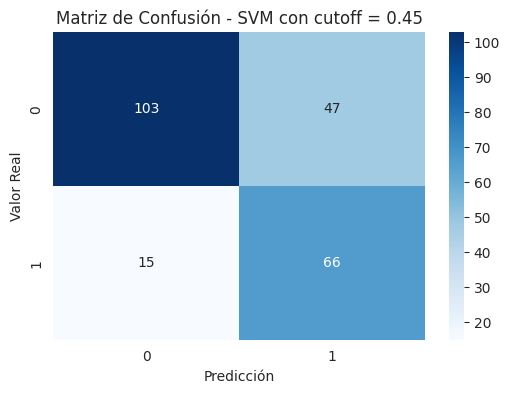

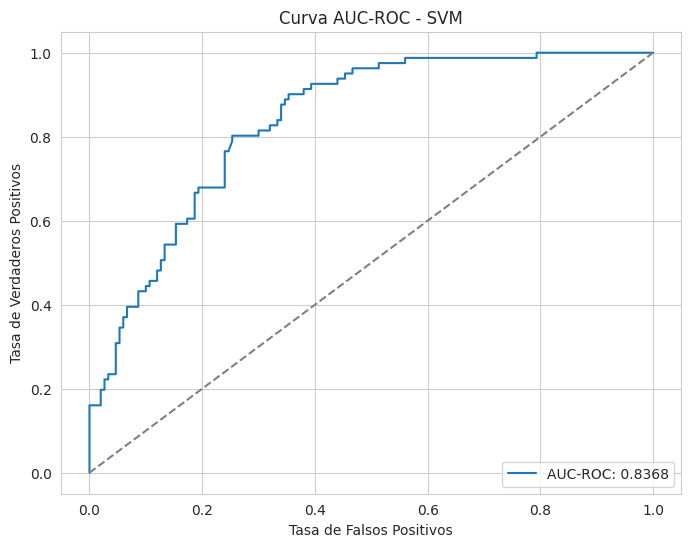

In [ ]:
from sklearn.svm import SVC
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Crear el pipeline para SVM con ADASYN
pipeline_svm = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adasyn', ADASYN(random_state=42)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('svm', SVC(C=100, kernel='linear', gamma='scale', probability=True))
])

# 2. Ajustar el modelo al conjunto de entrenamiento
pipeline_svm.fit(X_train, y_train)

# 3. Generar probabilidades y predicciones con cutoff = 0.45
cutoff = 0.45
y_prob_svm = pipeline_svm.predict_proba(X_test)[:, 1]
y_pred_cutoff_svm = (y_prob_svm >= cutoff).astype(int)

# 4. Evaluar el modelo
print("Resultados para SVM con cutoff ajustado:")
print(classification_report(y_test, y_pred_cutoff_svm))

# Matriz de Confusión
cm_svm = confusion_matrix(y_test, y_pred_cutoff_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM con cutoff = 0.45')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva AUC-ROC
auc_svm = roc_auc_score(y_test, y_prob_svm)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'AUC-ROC: {auc_svm:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva AUC-ROC - SVM')
plt.legend(loc='lower right')
plt.show()


### **Conclusiones del Modelo SVM con Cutoff Ajustado (0.45)**


### **1. Rendimiento General**
- **Exactitud Global**: El modelo tiene una exactitud de **73%**, lo que indica que clasifica correctamente la mayoría de los casos en el conjunto de prueba.
- **AUC-ROC**: La curva AUC-ROC muestra un valor de **0.8368**, lo que refleja una buena capacidad del modelo para distinguir entre las clases (positiva y negativa). Esto significa que el modelo tiene un buen equilibrio entre la tasa de verdaderos positivos y la tasa de falsos positivos.

---

### **2. Desempeño por Clases**
#### Clase Negativa (0):
- **Precisión**: **87%**, lo que significa que el modelo identifica correctamente la mayoría de los negativos predichos.
- **Recall**: **69%**, indicando que el modelo detecta una proporción razonable de los casos negativos reales, aunque pierde algunos (falsos negativos).

#### Clase Positiva (1):
- **Precisión**: **58%**, lo que indica que hay una cantidad significativa de falsos positivos en las predicciones positivas.
- **Recall**: **81%**, lo cual es sólido y significa que el modelo detecta la mayoría de los casos positivos reales.

El modelo tiene un mejor *recall* para la clase positiva, lo cual es favorable si el objetivo es minimizar los falsos negativos.

---

### **3. Matriz de Confusión**
La matriz de confusión muestra:
- Verdaderos Negativos (TN): **103** casos negativos correctamente clasificados.
- Falsos Positivos (FP): **47** casos negativos clasificados erróneamente como positivos.
- Falsos Negativos (FN): **15** casos positivos clasificados erróneamente como negativos.
- Verdaderos Positivos (TP): **66** casos positivos correctamente clasificados.

#### Interpretación:
- El modelo tiene un buen desempeño en términos de detectar la clase positiva (TP = 66), pero genera una cantidad significativa de falsos positivos (FP = 47). Esto puede ser problemático si los falsos positivos tienen un impacto negativo en el contexto del problema.

---

### **4. Balance entre Métricas**
El balance entre precisión y *recall* es razonable:
- La clase negativa tiene alta precisión (**87%**) pero moderado *recall* (**69%**).
- La clase positiva tiene alto *recall* (**81%**) pero baja precisión (**58%**).

Esto sugiere que el modelo prioriza detectar correctamente los casos positivos, aunque a costa de generar más falsos positivos.

---

### **5. Curva AUC-ROC**
La curva AUC-ROC confirma que el modelo tiene un buen rendimiento global:
- Un AUC de **0.8368** indica que el modelo separa bien las clases, siendo significativamente mejor que un clasificador aleatorio (AUC = 0.5).
- La curva muestra una buena relación entre la tasa de verdaderos positivos (*TPR*) y la tasa de falsos positivos (*FPR*), especialmente en los primeros tramos.

---

### **6. Robustez del Modelo**
El uso de 8 características seleccionadas por `SelectFromModel` parece haber capturado suficiente información relevante para lograr un buen desempeño general:
- Esto reduce el riesgo de pérdida significativa de información importante.

---

### Conclusión Final
El modelo SVM con cutoff ajustado a 0.45 ofrece un rendimiento sólido, especialmente destacando su capacidad para detectar la clase positiva (*recall* = 81%). Es adecuado para problemas donde minimizar los falsos negativos es prioritario.

